In [2]:
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image, vutils

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, Image

os.makedirs("images", exist_ok=True)

In [13]:
parser = argparse.ArgumentParser()

In [14]:
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
parser.add_argument("--clip_value", type=float, default=0.01, help="lower and upper clip value for disc. weights")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")

_StoreAction(option_strings=['--sample_interval'], dest='sample_interval', nargs=None, const=None, default=400, type=<class 'int'>, choices=None, help='interval betwen image samples', metavar=None)

In [15]:
opt = parser.parse_args(args=[])

In [17]:
print(opt)

Namespace(b1=0.5, b2=0.999, batch_size=64, channels=1, clip_value=0.01, img_size=28, latent_dim=100, lr=0.0002, n_cpu=8, n_critic=5, n_epochs=200, sample_interval=400)


In [24]:
img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False

In [19]:
cuda

True

In [21]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [25]:
# Loss weight for gradient penalty
lambda_gp = 10

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

0it [00:00, ?it/s]

9920512it [00:00, 19201230.79it/s]                             


Extracting ../../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 185962.28it/s]           
0it [00:00, ?it/s]

Extracting ../../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5138209.09it/s]                            
0it [00:00, ?it/s]

Extracting ../../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 58797.31it/s]            


Extracting ../../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [26]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [27]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [28]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [29]:
batches_done = 0
for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % opt.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

            if batches_done % opt.sample_interval == 0:
                save_image(fake_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

            batches_done += opt.n_critic

[Epoch 0/200] [Batch 0/938] [D loss: 8.172504] [G loss: 0.019057]
[Epoch 0/200] [Batch 5/938] [D loss: 4.768697] [G loss: 0.020611]
[Epoch 0/200] [Batch 10/938] [D loss: -3.178628] [G loss: 0.007275]
[Epoch 0/200] [Batch 15/938] [D loss: -15.835818] [G loss: -0.032768]
[Epoch 0/200] [Batch 20/938] [D loss: -26.306061] [G loss: -0.108113]
[Epoch 0/200] [Batch 25/938] [D loss: -32.189476] [G loss: -0.195252]
[Epoch 0/200] [Batch 30/938] [D loss: -34.054520] [G loss: -0.278267]
[Epoch 0/200] [Batch 35/938] [D loss: -35.304855] [G loss: -0.351644]
[Epoch 0/200] [Batch 40/938] [D loss: -35.096519] [G loss: -0.447341]
[Epoch 0/200] [Batch 45/938] [D loss: -34.948921] [G loss: -0.538750]
[Epoch 0/200] [Batch 50/938] [D loss: -34.867554] [G loss: -0.658094]
[Epoch 0/200] [Batch 55/938] [D loss: -34.964355] [G loss: -0.764765]
[Epoch 0/200] [Batch 60/938] [D loss: -34.813221] [G loss: -0.892921]
[Epoch 0/200] [Batch 65/938] [D loss: -34.341457] [G loss: -1.034761]
[Epoch 0/200] [Batch 70/938] [

[Epoch 0/200] [Batch 580/938] [D loss: -0.926852] [G loss: -12.435295]
[Epoch 0/200] [Batch 585/938] [D loss: -1.127504] [G loss: -11.990305]
[Epoch 0/200] [Batch 590/938] [D loss: -0.972981] [G loss: -10.664732]
[Epoch 0/200] [Batch 595/938] [D loss: -1.151427] [G loss: -8.587397]
[Epoch 0/200] [Batch 600/938] [D loss: -1.170270] [G loss: -7.690365]
[Epoch 0/200] [Batch 605/938] [D loss: -1.332444] [G loss: -7.151072]
[Epoch 0/200] [Batch 610/938] [D loss: -1.388932] [G loss: -7.322064]
[Epoch 0/200] [Batch 615/938] [D loss: -1.614894] [G loss: -5.639732]
[Epoch 0/200] [Batch 620/938] [D loss: -1.139668] [G loss: -5.793193]
[Epoch 0/200] [Batch 625/938] [D loss: -1.305106] [G loss: -8.904249]
[Epoch 0/200] [Batch 630/938] [D loss: -1.121442] [G loss: -9.881765]
[Epoch 0/200] [Batch 635/938] [D loss: -1.515200] [G loss: -11.546931]
[Epoch 0/200] [Batch 640/938] [D loss: -1.450273] [G loss: -12.721714]
[Epoch 0/200] [Batch 645/938] [D loss: -1.332167] [G loss: -12.598001]
[Epoch 0/200] 

[Epoch 1/200] [Batch 230/938] [D loss: -4.478335] [G loss: -1.601343]
[Epoch 1/200] [Batch 235/938] [D loss: -5.074445] [G loss: -2.046534]
[Epoch 1/200] [Batch 240/938] [D loss: -5.242225] [G loss: -2.810036]
[Epoch 1/200] [Batch 245/938] [D loss: -4.397020] [G loss: -3.001888]
[Epoch 1/200] [Batch 250/938] [D loss: -4.517260] [G loss: -2.192941]
[Epoch 1/200] [Batch 255/938] [D loss: -5.171959] [G loss: -2.673688]
[Epoch 1/200] [Batch 260/938] [D loss: -5.080922] [G loss: -2.501021]
[Epoch 1/200] [Batch 265/938] [D loss: -4.828602] [G loss: -1.663600]
[Epoch 1/200] [Batch 270/938] [D loss: -4.883252] [G loss: -2.243417]
[Epoch 1/200] [Batch 275/938] [D loss: -4.099473] [G loss: -2.512271]
[Epoch 1/200] [Batch 280/938] [D loss: -4.912423] [G loss: -2.798235]
[Epoch 1/200] [Batch 285/938] [D loss: -4.708055] [G loss: -2.446167]
[Epoch 1/200] [Batch 290/938] [D loss: -4.985713] [G loss: -1.505709]
[Epoch 1/200] [Batch 295/938] [D loss: -4.309078] [G loss: -2.064499]
[Epoch 1/200] [Batch

[Epoch 1/200] [Batch 825/938] [D loss: -6.420261] [G loss: 4.906897]
[Epoch 1/200] [Batch 830/938] [D loss: -6.609461] [G loss: 5.789404]
[Epoch 1/200] [Batch 835/938] [D loss: -6.552684] [G loss: 4.818975]
[Epoch 1/200] [Batch 840/938] [D loss: -6.670835] [G loss: 5.352898]
[Epoch 1/200] [Batch 845/938] [D loss: -6.539487] [G loss: 4.133884]
[Epoch 1/200] [Batch 850/938] [D loss: -7.021831] [G loss: 4.265151]
[Epoch 1/200] [Batch 855/938] [D loss: -6.103640] [G loss: 3.959691]
[Epoch 1/200] [Batch 860/938] [D loss: -6.475214] [G loss: 5.355894]
[Epoch 1/200] [Batch 865/938] [D loss: -6.540829] [G loss: 4.765059]
[Epoch 1/200] [Batch 870/938] [D loss: -6.212528] [G loss: 3.901157]
[Epoch 1/200] [Batch 875/938] [D loss: -6.357856] [G loss: 5.126479]
[Epoch 1/200] [Batch 880/938] [D loss: -6.570601] [G loss: 5.586585]
[Epoch 1/200] [Batch 885/938] [D loss: -6.731894] [G loss: 5.159395]
[Epoch 1/200] [Batch 890/938] [D loss: -6.738610] [G loss: 4.667703]
[Epoch 1/200] [Batch 895/938] [D l

[Epoch 2/200] [Batch 485/938] [D loss: -6.732813] [G loss: 2.933959]
[Epoch 2/200] [Batch 490/938] [D loss: -6.075891] [G loss: 1.117822]
[Epoch 2/200] [Batch 495/938] [D loss: -6.511919] [G loss: 2.167898]
[Epoch 2/200] [Batch 500/938] [D loss: -6.436706] [G loss: 1.767676]
[Epoch 2/200] [Batch 505/938] [D loss: -6.139648] [G loss: 1.728947]
[Epoch 2/200] [Batch 510/938] [D loss: -6.828148] [G loss: 2.705418]
[Epoch 2/200] [Batch 515/938] [D loss: -7.747846] [G loss: 2.847856]
[Epoch 2/200] [Batch 520/938] [D loss: -7.402473] [G loss: 2.882097]
[Epoch 2/200] [Batch 525/938] [D loss: -6.516775] [G loss: 2.872558]
[Epoch 2/200] [Batch 530/938] [D loss: -7.249073] [G loss: 3.672094]
[Epoch 2/200] [Batch 535/938] [D loss: -7.155516] [G loss: 2.566843]
[Epoch 2/200] [Batch 540/938] [D loss: -7.133918] [G loss: 3.347997]
[Epoch 2/200] [Batch 545/938] [D loss: -6.894874] [G loss: 3.971216]
[Epoch 2/200] [Batch 550/938] [D loss: -7.403162] [G loss: 2.849322]
[Epoch 2/200] [Batch 555/938] [D l

[Epoch 3/200] [Batch 150/938] [D loss: -7.392807] [G loss: 4.266427]
[Epoch 3/200] [Batch 155/938] [D loss: -7.128120] [G loss: 4.251113]
[Epoch 3/200] [Batch 160/938] [D loss: -7.670632] [G loss: 4.009276]
[Epoch 3/200] [Batch 165/938] [D loss: -7.281134] [G loss: 5.178539]
[Epoch 3/200] [Batch 170/938] [D loss: -7.157180] [G loss: 4.681522]
[Epoch 3/200] [Batch 175/938] [D loss: -7.386820] [G loss: 3.913706]
[Epoch 3/200] [Batch 180/938] [D loss: -7.067924] [G loss: 4.810309]
[Epoch 3/200] [Batch 185/938] [D loss: -6.888430] [G loss: 3.987708]
[Epoch 3/200] [Batch 190/938] [D loss: -7.150546] [G loss: 4.626130]
[Epoch 3/200] [Batch 195/938] [D loss: -7.056463] [G loss: 4.943374]
[Epoch 3/200] [Batch 200/938] [D loss: -7.338171] [G loss: 4.025063]
[Epoch 3/200] [Batch 205/938] [D loss: -7.376649] [G loss: 3.701590]
[Epoch 3/200] [Batch 210/938] [D loss: -7.376147] [G loss: 4.836452]
[Epoch 3/200] [Batch 215/938] [D loss: -7.005442] [G loss: 4.849591]
[Epoch 3/200] [Batch 220/938] [D l

[Epoch 3/200] [Batch 745/938] [D loss: -7.572185] [G loss: 2.137918]
[Epoch 3/200] [Batch 750/938] [D loss: -7.165811] [G loss: 2.367539]
[Epoch 3/200] [Batch 755/938] [D loss: -7.170646] [G loss: 1.641592]
[Epoch 3/200] [Batch 760/938] [D loss: -7.687035] [G loss: 1.775282]
[Epoch 3/200] [Batch 765/938] [D loss: -7.629424] [G loss: 2.306195]
[Epoch 3/200] [Batch 770/938] [D loss: -7.390082] [G loss: 2.123183]
[Epoch 3/200] [Batch 775/938] [D loss: -7.332763] [G loss: 1.514652]
[Epoch 3/200] [Batch 780/938] [D loss: -6.660384] [G loss: 1.559283]
[Epoch 3/200] [Batch 785/938] [D loss: -7.437335] [G loss: 1.422005]
[Epoch 3/200] [Batch 790/938] [D loss: -7.096899] [G loss: 0.232904]
[Epoch 3/200] [Batch 795/938] [D loss: -7.717181] [G loss: 1.956582]
[Epoch 3/200] [Batch 800/938] [D loss: -7.133990] [G loss: 1.953745]
[Epoch 3/200] [Batch 805/938] [D loss: -7.066618] [G loss: 1.480700]
[Epoch 3/200] [Batch 810/938] [D loss: -7.277053] [G loss: 2.676205]
[Epoch 3/200] [Batch 815/938] [D l

[Epoch 4/200] [Batch 405/938] [D loss: -8.308352] [G loss: 1.539152]
[Epoch 4/200] [Batch 410/938] [D loss: -7.555073] [G loss: 0.980974]
[Epoch 4/200] [Batch 415/938] [D loss: -8.037146] [G loss: 0.939754]
[Epoch 4/200] [Batch 420/938] [D loss: -7.981578] [G loss: 1.083793]
[Epoch 4/200] [Batch 425/938] [D loss: -8.036700] [G loss: 1.242813]
[Epoch 4/200] [Batch 430/938] [D loss: -7.950516] [G loss: 0.601860]
[Epoch 4/200] [Batch 435/938] [D loss: -7.661791] [G loss: 0.706461]
[Epoch 4/200] [Batch 440/938] [D loss: -7.808544] [G loss: 0.786632]
[Epoch 4/200] [Batch 445/938] [D loss: -8.016571] [G loss: 0.750215]
[Epoch 4/200] [Batch 450/938] [D loss: -7.361492] [G loss: -0.053164]
[Epoch 4/200] [Batch 455/938] [D loss: -8.188524] [G loss: 0.393992]
[Epoch 4/200] [Batch 460/938] [D loss: -8.566694] [G loss: 1.543638]
[Epoch 4/200] [Batch 465/938] [D loss: -8.182312] [G loss: 0.966284]
[Epoch 4/200] [Batch 470/938] [D loss: -8.132867] [G loss: 1.619230]
[Epoch 4/200] [Batch 475/938] [D 

[Epoch 5/200] [Batch 60/938] [D loss: -8.424541] [G loss: 3.022645]
[Epoch 5/200] [Batch 65/938] [D loss: -8.194504] [G loss: 2.663710]
[Epoch 5/200] [Batch 70/938] [D loss: -8.327740] [G loss: 2.257910]
[Epoch 5/200] [Batch 75/938] [D loss: -8.159994] [G loss: 3.127689]
[Epoch 5/200] [Batch 80/938] [D loss: -8.817144] [G loss: 3.198465]
[Epoch 5/200] [Batch 85/938] [D loss: -8.321933] [G loss: 3.183882]
[Epoch 5/200] [Batch 90/938] [D loss: -8.239148] [G loss: 3.273372]
[Epoch 5/200] [Batch 95/938] [D loss: -8.621979] [G loss: 3.137794]
[Epoch 5/200] [Batch 100/938] [D loss: -8.177929] [G loss: 3.439372]
[Epoch 5/200] [Batch 105/938] [D loss: -8.556561] [G loss: 3.287205]
[Epoch 5/200] [Batch 110/938] [D loss: -8.341124] [G loss: 2.945306]
[Epoch 5/200] [Batch 115/938] [D loss: -8.023661] [G loss: 2.928220]
[Epoch 5/200] [Batch 120/938] [D loss: -8.730574] [G loss: 3.955944]
[Epoch 5/200] [Batch 125/938] [D loss: -8.159742] [G loss: 3.257784]
[Epoch 5/200] [Batch 130/938] [D loss: -8.

[Epoch 5/200] [Batch 660/938] [D loss: -7.977532] [G loss: 2.350743]
[Epoch 5/200] [Batch 665/938] [D loss: -7.685160] [G loss: 2.232460]
[Epoch 5/200] [Batch 670/938] [D loss: -7.720725] [G loss: 2.015703]
[Epoch 5/200] [Batch 675/938] [D loss: -7.394723] [G loss: 1.974225]
[Epoch 5/200] [Batch 680/938] [D loss: -8.038564] [G loss: 2.610273]
[Epoch 5/200] [Batch 685/938] [D loss: -7.785371] [G loss: 2.344890]
[Epoch 5/200] [Batch 690/938] [D loss: -7.770813] [G loss: 2.724233]
[Epoch 5/200] [Batch 695/938] [D loss: -8.912887] [G loss: 2.662994]
[Epoch 5/200] [Batch 700/938] [D loss: -8.024365] [G loss: 2.254160]
[Epoch 5/200] [Batch 705/938] [D loss: -8.121491] [G loss: 2.104157]
[Epoch 5/200] [Batch 710/938] [D loss: -8.065147] [G loss: 2.369886]
[Epoch 5/200] [Batch 715/938] [D loss: -8.545071] [G loss: 2.742090]
[Epoch 5/200] [Batch 720/938] [D loss: -8.580684] [G loss: 2.434868]
[Epoch 5/200] [Batch 725/938] [D loss: -8.849145] [G loss: 2.688269]
[Epoch 5/200] [Batch 730/938] [D l

[Epoch 6/200] [Batch 320/938] [D loss: -8.062797] [G loss: 2.152823]
[Epoch 6/200] [Batch 325/938] [D loss: -6.884857] [G loss: 1.840311]
[Epoch 6/200] [Batch 330/938] [D loss: -8.064574] [G loss: 2.289436]
[Epoch 6/200] [Batch 335/938] [D loss: -7.313436] [G loss: 1.747504]
[Epoch 6/200] [Batch 340/938] [D loss: -8.160100] [G loss: 2.041249]
[Epoch 6/200] [Batch 345/938] [D loss: -7.487222] [G loss: 1.904902]
[Epoch 6/200] [Batch 350/938] [D loss: -7.302872] [G loss: 1.700677]
[Epoch 6/200] [Batch 355/938] [D loss: -7.879302] [G loss: 1.910997]
[Epoch 6/200] [Batch 360/938] [D loss: -8.314600] [G loss: 1.953807]
[Epoch 6/200] [Batch 365/938] [D loss: -8.467271] [G loss: 2.442718]
[Epoch 6/200] [Batch 370/938] [D loss: -8.388954] [G loss: 2.438025]
[Epoch 6/200] [Batch 375/938] [D loss: -7.465336] [G loss: 2.243715]
[Epoch 6/200] [Batch 380/938] [D loss: -7.486271] [G loss: 2.349666]
[Epoch 6/200] [Batch 385/938] [D loss: -8.106229] [G loss: 2.326914]
[Epoch 6/200] [Batch 390/938] [D l

[Epoch 6/200] [Batch 920/938] [D loss: -7.548403] [G loss: 1.889136]
[Epoch 6/200] [Batch 925/938] [D loss: -8.105473] [G loss: 1.960811]
[Epoch 6/200] [Batch 930/938] [D loss: -7.719445] [G loss: 1.786876]
[Epoch 6/200] [Batch 935/938] [D loss: -7.483449] [G loss: 1.589548]
[Epoch 7/200] [Batch 0/938] [D loss: -7.276786] [G loss: 1.251726]
[Epoch 7/200] [Batch 5/938] [D loss: -7.263939] [G loss: 1.459948]
[Epoch 7/200] [Batch 10/938] [D loss: -7.527802] [G loss: 1.740831]
[Epoch 7/200] [Batch 15/938] [D loss: -7.284769] [G loss: 2.175844]
[Epoch 7/200] [Batch 20/938] [D loss: -7.800970] [G loss: 1.597210]
[Epoch 7/200] [Batch 25/938] [D loss: -6.964067] [G loss: 1.612467]
[Epoch 7/200] [Batch 30/938] [D loss: -8.006425] [G loss: 2.048714]
[Epoch 7/200] [Batch 35/938] [D loss: -7.792955] [G loss: 1.912544]
[Epoch 7/200] [Batch 40/938] [D loss: -7.509173] [G loss: 2.066707]
[Epoch 7/200] [Batch 45/938] [D loss: -7.754043] [G loss: 1.752186]
[Epoch 7/200] [Batch 50/938] [D loss: -7.29154

[Epoch 7/200] [Batch 585/938] [D loss: -6.937914] [G loss: 2.552578]
[Epoch 7/200] [Batch 590/938] [D loss: -7.441922] [G loss: 2.395426]
[Epoch 7/200] [Batch 595/938] [D loss: -7.887677] [G loss: 2.571576]
[Epoch 7/200] [Batch 600/938] [D loss: -7.335845] [G loss: 2.954476]
[Epoch 7/200] [Batch 605/938] [D loss: -7.149334] [G loss: 2.820512]
[Epoch 7/200] [Batch 610/938] [D loss: -7.451047] [G loss: 2.928729]
[Epoch 7/200] [Batch 615/938] [D loss: -6.838423] [G loss: 2.832965]
[Epoch 7/200] [Batch 620/938] [D loss: -7.731366] [G loss: 3.073700]
[Epoch 7/200] [Batch 625/938] [D loss: -7.037975] [G loss: 2.704337]
[Epoch 7/200] [Batch 630/938] [D loss: -7.787663] [G loss: 3.407148]
[Epoch 7/200] [Batch 635/938] [D loss: -7.490677] [G loss: 2.774435]
[Epoch 7/200] [Batch 640/938] [D loss: -7.028494] [G loss: 3.271723]
[Epoch 7/200] [Batch 645/938] [D loss: -7.395529] [G loss: 1.892480]
[Epoch 7/200] [Batch 650/938] [D loss: -7.599608] [G loss: 2.815254]
[Epoch 7/200] [Batch 655/938] [D l

[Epoch 8/200] [Batch 250/938] [D loss: -7.072152] [G loss: 1.561316]
[Epoch 8/200] [Batch 255/938] [D loss: -7.254086] [G loss: 1.705014]
[Epoch 8/200] [Batch 260/938] [D loss: -7.044436] [G loss: 1.073510]
[Epoch 8/200] [Batch 265/938] [D loss: -6.941072] [G loss: 1.598717]
[Epoch 8/200] [Batch 270/938] [D loss: -6.897949] [G loss: 1.527524]
[Epoch 8/200] [Batch 275/938] [D loss: -7.298981] [G loss: 1.401227]
[Epoch 8/200] [Batch 280/938] [D loss: -7.413644] [G loss: 1.120265]
[Epoch 8/200] [Batch 285/938] [D loss: -7.522809] [G loss: 1.442210]
[Epoch 8/200] [Batch 290/938] [D loss: -7.775233] [G loss: 1.578193]
[Epoch 8/200] [Batch 295/938] [D loss: -7.442954] [G loss: 1.284286]
[Epoch 8/200] [Batch 300/938] [D loss: -7.133965] [G loss: 0.763003]
[Epoch 8/200] [Batch 305/938] [D loss: -7.315750] [G loss: 0.744871]
[Epoch 8/200] [Batch 310/938] [D loss: -7.679367] [G loss: 1.209870]
[Epoch 8/200] [Batch 315/938] [D loss: -7.495048] [G loss: 1.278385]
[Epoch 8/200] [Batch 320/938] [D l

[Epoch 8/200] [Batch 855/938] [D loss: -7.062222] [G loss: 1.877203]
[Epoch 8/200] [Batch 860/938] [D loss: -6.603180] [G loss: 1.833999]
[Epoch 8/200] [Batch 865/938] [D loss: -6.988098] [G loss: 1.681977]
[Epoch 8/200] [Batch 870/938] [D loss: -7.142519] [G loss: 1.982079]
[Epoch 8/200] [Batch 875/938] [D loss: -6.805987] [G loss: 2.342186]
[Epoch 8/200] [Batch 880/938] [D loss: -6.873993] [G loss: 1.803123]
[Epoch 8/200] [Batch 885/938] [D loss: -7.456656] [G loss: 1.966144]
[Epoch 8/200] [Batch 890/938] [D loss: -6.405409] [G loss: 1.596999]
[Epoch 8/200] [Batch 895/938] [D loss: -6.773286] [G loss: 1.447403]
[Epoch 8/200] [Batch 900/938] [D loss: -7.083611] [G loss: 1.466880]
[Epoch 8/200] [Batch 905/938] [D loss: -7.123872] [G loss: 1.653025]
[Epoch 8/200] [Batch 910/938] [D loss: -7.024958] [G loss: 1.108899]
[Epoch 8/200] [Batch 915/938] [D loss: -7.066387] [G loss: 1.337237]
[Epoch 8/200] [Batch 920/938] [D loss: -7.515949] [G loss: 1.517647]
[Epoch 8/200] [Batch 925/938] [D l

[Epoch 9/200] [Batch 520/938] [D loss: -7.106318] [G loss: 2.134719]
[Epoch 9/200] [Batch 525/938] [D loss: -6.747992] [G loss: 1.765300]
[Epoch 9/200] [Batch 530/938] [D loss: -6.567144] [G loss: 1.826195]
[Epoch 9/200] [Batch 535/938] [D loss: -7.098282] [G loss: 2.321223]
[Epoch 9/200] [Batch 540/938] [D loss: -6.377552] [G loss: 1.364056]
[Epoch 9/200] [Batch 545/938] [D loss: -6.876131] [G loss: 1.334140]
[Epoch 9/200] [Batch 550/938] [D loss: -6.260184] [G loss: 1.740739]
[Epoch 9/200] [Batch 555/938] [D loss: -6.716137] [G loss: 1.427481]
[Epoch 9/200] [Batch 560/938] [D loss: -7.193117] [G loss: 1.658310]
[Epoch 9/200] [Batch 565/938] [D loss: -6.896657] [G loss: 2.024080]
[Epoch 9/200] [Batch 570/938] [D loss: -7.536195] [G loss: 1.800164]
[Epoch 9/200] [Batch 575/938] [D loss: -6.843827] [G loss: 1.887153]
[Epoch 9/200] [Batch 580/938] [D loss: -6.197694] [G loss: 1.445523]
[Epoch 9/200] [Batch 585/938] [D loss: -6.559970] [G loss: 1.913013]
[Epoch 9/200] [Batch 590/938] [D l

[Epoch 10/200] [Batch 180/938] [D loss: -6.164440] [G loss: 1.580826]
[Epoch 10/200] [Batch 185/938] [D loss: -6.202556] [G loss: 1.309075]
[Epoch 10/200] [Batch 190/938] [D loss: -6.579837] [G loss: 1.484602]
[Epoch 10/200] [Batch 195/938] [D loss: -6.360819] [G loss: 1.161971]
[Epoch 10/200] [Batch 200/938] [D loss: -6.399553] [G loss: 1.557530]
[Epoch 10/200] [Batch 205/938] [D loss: -5.934654] [G loss: 1.575338]
[Epoch 10/200] [Batch 210/938] [D loss: -6.729934] [G loss: 1.322114]
[Epoch 10/200] [Batch 215/938] [D loss: -6.402023] [G loss: 1.395039]
[Epoch 10/200] [Batch 220/938] [D loss: -6.171268] [G loss: 1.540274]
[Epoch 10/200] [Batch 225/938] [D loss: -6.097279] [G loss: 1.830470]
[Epoch 10/200] [Batch 230/938] [D loss: -6.274422] [G loss: 1.776198]
[Epoch 10/200] [Batch 235/938] [D loss: -6.322473] [G loss: 1.863354]
[Epoch 10/200] [Batch 240/938] [D loss: -6.067225] [G loss: 1.983282]
[Epoch 10/200] [Batch 245/938] [D loss: -5.599432] [G loss: 1.893066]
[Epoch 10/200] [Batc

[Epoch 10/200] [Batch 770/938] [D loss: -6.497858] [G loss: 1.094421]
[Epoch 10/200] [Batch 775/938] [D loss: -6.681328] [G loss: 1.809156]
[Epoch 10/200] [Batch 780/938] [D loss: -5.787703] [G loss: 1.244814]
[Epoch 10/200] [Batch 785/938] [D loss: -6.373633] [G loss: 2.031232]
[Epoch 10/200] [Batch 790/938] [D loss: -6.157613] [G loss: 1.845342]
[Epoch 10/200] [Batch 795/938] [D loss: -4.926876] [G loss: 1.363764]
[Epoch 10/200] [Batch 800/938] [D loss: -5.396646] [G loss: 1.553953]
[Epoch 10/200] [Batch 805/938] [D loss: -6.504039] [G loss: 1.722108]
[Epoch 10/200] [Batch 810/938] [D loss: -6.133327] [G loss: 1.733369]
[Epoch 10/200] [Batch 815/938] [D loss: -6.230525] [G loss: 1.139968]
[Epoch 10/200] [Batch 820/938] [D loss: -5.889331] [G loss: 1.068451]
[Epoch 10/200] [Batch 825/938] [D loss: -5.746006] [G loss: 1.159802]
[Epoch 10/200] [Batch 830/938] [D loss: -6.465609] [G loss: 1.236126]
[Epoch 10/200] [Batch 835/938] [D loss: -5.265018] [G loss: 0.705067]
[Epoch 10/200] [Batc

[Epoch 11/200] [Batch 425/938] [D loss: -5.621777] [G loss: 1.156113]
[Epoch 11/200] [Batch 430/938] [D loss: -6.009637] [G loss: 1.242803]
[Epoch 11/200] [Batch 435/938] [D loss: -6.097845] [G loss: 1.266546]
[Epoch 11/200] [Batch 440/938] [D loss: -5.598255] [G loss: 1.169824]
[Epoch 11/200] [Batch 445/938] [D loss: -5.824246] [G loss: 1.592624]
[Epoch 11/200] [Batch 450/938] [D loss: -6.156359] [G loss: 1.669556]
[Epoch 11/200] [Batch 455/938] [D loss: -5.306251] [G loss: 1.276736]
[Epoch 11/200] [Batch 460/938] [D loss: -5.728569] [G loss: 1.300187]
[Epoch 11/200] [Batch 465/938] [D loss: -5.979434] [G loss: 1.112890]
[Epoch 11/200] [Batch 470/938] [D loss: -5.981586] [G loss: 2.184811]
[Epoch 11/200] [Batch 475/938] [D loss: -5.845926] [G loss: 0.946090]
[Epoch 11/200] [Batch 480/938] [D loss: -6.032361] [G loss: 1.093321]
[Epoch 11/200] [Batch 485/938] [D loss: -5.568296] [G loss: 0.871212]
[Epoch 11/200] [Batch 490/938] [D loss: -6.160151] [G loss: 0.651029]
[Epoch 11/200] [Batc

[Epoch 12/200] [Batch 80/938] [D loss: -5.894777] [G loss: 1.082747]
[Epoch 12/200] [Batch 85/938] [D loss: -5.589952] [G loss: 0.838375]
[Epoch 12/200] [Batch 90/938] [D loss: -6.237144] [G loss: 0.952054]
[Epoch 12/200] [Batch 95/938] [D loss: -5.709396] [G loss: 1.241847]
[Epoch 12/200] [Batch 100/938] [D loss: -4.793171] [G loss: 0.837269]
[Epoch 12/200] [Batch 105/938] [D loss: -5.718679] [G loss: 1.159445]
[Epoch 12/200] [Batch 110/938] [D loss: -5.373037] [G loss: 0.430787]
[Epoch 12/200] [Batch 115/938] [D loss: -5.758707] [G loss: 1.084687]
[Epoch 12/200] [Batch 120/938] [D loss: -5.639544] [G loss: 0.763455]
[Epoch 12/200] [Batch 125/938] [D loss: -5.624498] [G loss: 1.165388]
[Epoch 12/200] [Batch 130/938] [D loss: -5.175583] [G loss: 0.350340]
[Epoch 12/200] [Batch 135/938] [D loss: -6.178646] [G loss: 0.944232]
[Epoch 12/200] [Batch 140/938] [D loss: -5.188150] [G loss: 1.281003]
[Epoch 12/200] [Batch 145/938] [D loss: -5.639896] [G loss: 0.783927]
[Epoch 12/200] [Batch 15

[Epoch 12/200] [Batch 675/938] [D loss: -5.643675] [G loss: 1.155782]
[Epoch 12/200] [Batch 680/938] [D loss: -5.403571] [G loss: 0.802599]
[Epoch 12/200] [Batch 685/938] [D loss: -4.499752] [G loss: 1.126396]
[Epoch 12/200] [Batch 690/938] [D loss: -5.495797] [G loss: 1.208217]
[Epoch 12/200] [Batch 695/938] [D loss: -4.974937] [G loss: 0.878886]
[Epoch 12/200] [Batch 700/938] [D loss: -5.206074] [G loss: 1.056247]
[Epoch 12/200] [Batch 705/938] [D loss: -5.215508] [G loss: 0.899554]
[Epoch 12/200] [Batch 710/938] [D loss: -5.286274] [G loss: 0.615013]
[Epoch 12/200] [Batch 715/938] [D loss: -5.477554] [G loss: 0.597661]
[Epoch 12/200] [Batch 720/938] [D loss: -4.997502] [G loss: 0.811713]
[Epoch 12/200] [Batch 725/938] [D loss: -5.404672] [G loss: 0.904530]
[Epoch 12/200] [Batch 730/938] [D loss: -5.044426] [G loss: 0.772646]
[Epoch 12/200] [Batch 735/938] [D loss: -5.215514] [G loss: 0.705503]
[Epoch 12/200] [Batch 740/938] [D loss: -5.437057] [G loss: 0.514101]
[Epoch 12/200] [Batc

[Epoch 13/200] [Batch 335/938] [D loss: -5.482000] [G loss: 0.342392]
[Epoch 13/200] [Batch 340/938] [D loss: -5.438766] [G loss: 0.547203]
[Epoch 13/200] [Batch 345/938] [D loss: -5.305460] [G loss: 0.575962]
[Epoch 13/200] [Batch 350/938] [D loss: -5.547200] [G loss: 0.116861]
[Epoch 13/200] [Batch 355/938] [D loss: -5.341253] [G loss: 0.155957]
[Epoch 13/200] [Batch 360/938] [D loss: -5.351140] [G loss: 0.614888]
[Epoch 13/200] [Batch 365/938] [D loss: -4.770078] [G loss: 0.150243]
[Epoch 13/200] [Batch 370/938] [D loss: -4.927746] [G loss: 0.588704]
[Epoch 13/200] [Batch 375/938] [D loss: -5.066560] [G loss: 0.768551]
[Epoch 13/200] [Batch 380/938] [D loss: -5.220758] [G loss: 0.776539]
[Epoch 13/200] [Batch 385/938] [D loss: -5.822004] [G loss: 0.749178]
[Epoch 13/200] [Batch 390/938] [D loss: -5.518982] [G loss: 1.147080]
[Epoch 13/200] [Batch 395/938] [D loss: -5.231292] [G loss: 0.733770]
[Epoch 13/200] [Batch 400/938] [D loss: -5.633810] [G loss: 1.059073]
[Epoch 13/200] [Batc

[Epoch 13/200] [Batch 930/938] [D loss: -4.839058] [G loss: 0.498347]
[Epoch 13/200] [Batch 935/938] [D loss: -5.314888] [G loss: 0.680635]
[Epoch 14/200] [Batch 0/938] [D loss: -4.692306] [G loss: 0.443236]
[Epoch 14/200] [Batch 5/938] [D loss: -5.251116] [G loss: 0.607345]
[Epoch 14/200] [Batch 10/938] [D loss: -5.339641] [G loss: 0.812467]
[Epoch 14/200] [Batch 15/938] [D loss: -5.435802] [G loss: 0.888021]
[Epoch 14/200] [Batch 20/938] [D loss: -5.195312] [G loss: 0.665416]
[Epoch 14/200] [Batch 25/938] [D loss: -4.847170] [G loss: 0.391087]
[Epoch 14/200] [Batch 30/938] [D loss: -5.034944] [G loss: 0.379116]
[Epoch 14/200] [Batch 35/938] [D loss: -4.839670] [G loss: 0.296665]
[Epoch 14/200] [Batch 40/938] [D loss: -5.152812] [G loss: 0.409793]
[Epoch 14/200] [Batch 45/938] [D loss: -4.970349] [G loss: 0.635495]
[Epoch 14/200] [Batch 50/938] [D loss: -5.109453] [G loss: 0.563401]
[Epoch 14/200] [Batch 55/938] [D loss: -4.260604] [G loss: 0.122994]
[Epoch 14/200] [Batch 60/938] [D l

[Epoch 14/200] [Batch 580/938] [D loss: -4.682833] [G loss: 0.135604]
[Epoch 14/200] [Batch 585/938] [D loss: -5.057841] [G loss: 0.093950]
[Epoch 14/200] [Batch 590/938] [D loss: -4.861024] [G loss: 0.456795]
[Epoch 14/200] [Batch 595/938] [D loss: -5.462128] [G loss: 0.513776]
[Epoch 14/200] [Batch 600/938] [D loss: -5.246492] [G loss: 0.329306]
[Epoch 14/200] [Batch 605/938] [D loss: -4.876755] [G loss: 0.357586]
[Epoch 14/200] [Batch 610/938] [D loss: -5.104753] [G loss: 0.754176]
[Epoch 14/200] [Batch 615/938] [D loss: -5.191499] [G loss: 0.479524]
[Epoch 14/200] [Batch 620/938] [D loss: -4.597846] [G loss: 0.551560]
[Epoch 14/200] [Batch 625/938] [D loss: -5.116207] [G loss: 0.671778]
[Epoch 14/200] [Batch 630/938] [D loss: -4.587327] [G loss: 0.401040]
[Epoch 14/200] [Batch 635/938] [D loss: -5.074085] [G loss: 0.562729]
[Epoch 14/200] [Batch 640/938] [D loss: -4.986846] [G loss: 0.319821]
[Epoch 14/200] [Batch 645/938] [D loss: -5.002712] [G loss: 0.416653]
[Epoch 14/200] [Batc

[Epoch 15/200] [Batch 230/938] [D loss: -4.888216] [G loss: -0.146767]
[Epoch 15/200] [Batch 235/938] [D loss: -4.969310] [G loss: 0.227108]
[Epoch 15/200] [Batch 240/938] [D loss: -4.335274] [G loss: 0.759375]
[Epoch 15/200] [Batch 245/938] [D loss: -4.705878] [G loss: 0.201842]
[Epoch 15/200] [Batch 250/938] [D loss: -4.975835] [G loss: 0.331317]
[Epoch 15/200] [Batch 255/938] [D loss: -4.887645] [G loss: 0.033795]
[Epoch 15/200] [Batch 260/938] [D loss: -4.979335] [G loss: -0.099396]
[Epoch 15/200] [Batch 265/938] [D loss: -5.017014] [G loss: 0.274508]
[Epoch 15/200] [Batch 270/938] [D loss: -4.600935] [G loss: 0.351797]
[Epoch 15/200] [Batch 275/938] [D loss: -5.164863] [G loss: 0.809855]
[Epoch 15/200] [Batch 280/938] [D loss: -4.567017] [G loss: 0.287731]
[Epoch 15/200] [Batch 285/938] [D loss: -4.838570] [G loss: 0.657568]
[Epoch 15/200] [Batch 290/938] [D loss: -4.712536] [G loss: 0.621163]
[Epoch 15/200] [Batch 295/938] [D loss: -4.979313] [G loss: 0.123224]
[Epoch 15/200] [Ba

[Epoch 15/200] [Batch 825/938] [D loss: -4.798456] [G loss: 0.568822]
[Epoch 15/200] [Batch 830/938] [D loss: -5.340515] [G loss: 0.929239]
[Epoch 15/200] [Batch 835/938] [D loss: -4.306695] [G loss: 0.533400]
[Epoch 15/200] [Batch 840/938] [D loss: -4.592467] [G loss: 0.341882]
[Epoch 15/200] [Batch 845/938] [D loss: -4.637921] [G loss: 0.252105]
[Epoch 15/200] [Batch 850/938] [D loss: -4.985713] [G loss: 0.324065]
[Epoch 15/200] [Batch 855/938] [D loss: -5.142501] [G loss: 0.496202]
[Epoch 15/200] [Batch 860/938] [D loss: -4.636049] [G loss: 0.865488]
[Epoch 15/200] [Batch 865/938] [D loss: -4.935268] [G loss: 0.367670]
[Epoch 15/200] [Batch 870/938] [D loss: -4.800799] [G loss: 0.802739]
[Epoch 15/200] [Batch 875/938] [D loss: -4.944237] [G loss: 0.469075]
[Epoch 15/200] [Batch 880/938] [D loss: -5.168099] [G loss: 0.353270]
[Epoch 15/200] [Batch 885/938] [D loss: -4.710558] [G loss: 0.323600]
[Epoch 15/200] [Batch 890/938] [D loss: -4.639389] [G loss: 0.509816]
[Epoch 15/200] [Batc

[Epoch 16/200] [Batch 480/938] [D loss: -4.510624] [G loss: 0.164851]
[Epoch 16/200] [Batch 485/938] [D loss: -4.333702] [G loss: -0.268801]
[Epoch 16/200] [Batch 490/938] [D loss: -4.614132] [G loss: 0.719922]
[Epoch 16/200] [Batch 495/938] [D loss: -4.441155] [G loss: 0.380713]
[Epoch 16/200] [Batch 500/938] [D loss: -4.469017] [G loss: -0.527511]
[Epoch 16/200] [Batch 505/938] [D loss: -4.669590] [G loss: 0.135387]
[Epoch 16/200] [Batch 510/938] [D loss: -4.879008] [G loss: 0.573523]
[Epoch 16/200] [Batch 515/938] [D loss: -4.901056] [G loss: 0.698164]
[Epoch 16/200] [Batch 520/938] [D loss: -4.550971] [G loss: 0.882458]
[Epoch 16/200] [Batch 525/938] [D loss: -4.258693] [G loss: -0.026015]
[Epoch 16/200] [Batch 530/938] [D loss: -4.400740] [G loss: 0.256835]
[Epoch 16/200] [Batch 535/938] [D loss: -4.828854] [G loss: 0.229738]
[Epoch 16/200] [Batch 540/938] [D loss: -5.092153] [G loss: 0.672772]
[Epoch 16/200] [Batch 545/938] [D loss: -3.943767] [G loss: 0.430396]
[Epoch 16/200] [B

[Epoch 17/200] [Batch 135/938] [D loss: -4.939047] [G loss: 0.520324]
[Epoch 17/200] [Batch 140/938] [D loss: -4.001963] [G loss: 0.145040]
[Epoch 17/200] [Batch 145/938] [D loss: -4.589318] [G loss: 0.183848]
[Epoch 17/200] [Batch 150/938] [D loss: -4.538287] [G loss: 0.486533]
[Epoch 17/200] [Batch 155/938] [D loss: -3.955917] [G loss: 0.483847]
[Epoch 17/200] [Batch 160/938] [D loss: -4.617188] [G loss: 0.334411]
[Epoch 17/200] [Batch 165/938] [D loss: -4.461329] [G loss: 0.165329]
[Epoch 17/200] [Batch 170/938] [D loss: -4.288297] [G loss: 0.033029]
[Epoch 17/200] [Batch 175/938] [D loss: -4.784831] [G loss: 0.318145]
[Epoch 17/200] [Batch 180/938] [D loss: -5.237517] [G loss: 0.205639]
[Epoch 17/200] [Batch 185/938] [D loss: -4.513036] [G loss: 0.267474]
[Epoch 17/200] [Batch 190/938] [D loss: -4.517316] [G loss: 0.312678]
[Epoch 17/200] [Batch 195/938] [D loss: -5.038005] [G loss: 0.176680]
[Epoch 17/200] [Batch 200/938] [D loss: -4.211802] [G loss: 0.432732]
[Epoch 17/200] [Batc

[Epoch 17/200] [Batch 720/938] [D loss: -4.312181] [G loss: 0.163891]
[Epoch 17/200] [Batch 725/938] [D loss: -4.390871] [G loss: 0.028696]
[Epoch 17/200] [Batch 730/938] [D loss: -4.510917] [G loss: 0.356750]
[Epoch 17/200] [Batch 735/938] [D loss: -3.966924] [G loss: 0.046579]
[Epoch 17/200] [Batch 740/938] [D loss: -4.312915] [G loss: -0.137818]
[Epoch 17/200] [Batch 745/938] [D loss: -4.572420] [G loss: 0.401961]
[Epoch 17/200] [Batch 750/938] [D loss: -4.123088] [G loss: 0.042506]
[Epoch 17/200] [Batch 755/938] [D loss: -4.587002] [G loss: -0.296119]
[Epoch 17/200] [Batch 760/938] [D loss: -4.131509] [G loss: 0.191196]
[Epoch 17/200] [Batch 765/938] [D loss: -4.460648] [G loss: 0.624269]
[Epoch 17/200] [Batch 770/938] [D loss: -4.721284] [G loss: -0.171565]
[Epoch 17/200] [Batch 775/938] [D loss: -4.202511] [G loss: -0.105367]
[Epoch 17/200] [Batch 780/938] [D loss: -4.393061] [G loss: -0.052037]
[Epoch 17/200] [Batch 785/938] [D loss: -4.365885] [G loss: -0.456724]
[Epoch 17/200]

[Epoch 18/200] [Batch 375/938] [D loss: -4.201486] [G loss: 0.305044]
[Epoch 18/200] [Batch 380/938] [D loss: -4.076879] [G loss: 0.256541]
[Epoch 18/200] [Batch 385/938] [D loss: -4.235855] [G loss: 0.621267]
[Epoch 18/200] [Batch 390/938] [D loss: -4.266134] [G loss: -0.019164]
[Epoch 18/200] [Batch 395/938] [D loss: -4.445721] [G loss: 0.361689]
[Epoch 18/200] [Batch 400/938] [D loss: -4.041560] [G loss: -0.256541]
[Epoch 18/200] [Batch 405/938] [D loss: -4.339054] [G loss: 0.135274]
[Epoch 18/200] [Batch 410/938] [D loss: -3.975213] [G loss: 0.420371]
[Epoch 18/200] [Batch 415/938] [D loss: -4.462994] [G loss: 0.599025]
[Epoch 18/200] [Batch 420/938] [D loss: -4.181862] [G loss: 0.024978]
[Epoch 18/200] [Batch 425/938] [D loss: -4.394883] [G loss: -0.189543]
[Epoch 18/200] [Batch 430/938] [D loss: -4.152696] [G loss: -0.124858]
[Epoch 18/200] [Batch 435/938] [D loss: -4.204216] [G loss: 0.063573]
[Epoch 18/200] [Batch 440/938] [D loss: -4.600890] [G loss: 0.293384]
[Epoch 18/200] [

[Epoch 19/200] [Batch 25/938] [D loss: -3.710927] [G loss: -0.775432]
[Epoch 19/200] [Batch 30/938] [D loss: -4.069174] [G loss: -0.191081]
[Epoch 19/200] [Batch 35/938] [D loss: -4.106254] [G loss: 0.108171]
[Epoch 19/200] [Batch 40/938] [D loss: -4.101772] [G loss: 0.059258]
[Epoch 19/200] [Batch 45/938] [D loss: -4.663614] [G loss: 0.632015]
[Epoch 19/200] [Batch 50/938] [D loss: -4.005410] [G loss: -0.393922]
[Epoch 19/200] [Batch 55/938] [D loss: -3.996532] [G loss: 0.177127]
[Epoch 19/200] [Batch 60/938] [D loss: -3.909185] [G loss: 0.345669]
[Epoch 19/200] [Batch 65/938] [D loss: -4.107995] [G loss: -0.140502]
[Epoch 19/200] [Batch 70/938] [D loss: -4.484415] [G loss: -0.167829]
[Epoch 19/200] [Batch 75/938] [D loss: -4.397662] [G loss: 0.322423]
[Epoch 19/200] [Batch 80/938] [D loss: -3.745270] [G loss: -0.164066]
[Epoch 19/200] [Batch 85/938] [D loss: -4.137005] [G loss: -0.151988]
[Epoch 19/200] [Batch 90/938] [D loss: -4.301960] [G loss: -0.111617]
[Epoch 19/200] [Batch 95/9

[Epoch 19/200] [Batch 610/938] [D loss: -3.951898] [G loss: -0.776374]
[Epoch 19/200] [Batch 615/938] [D loss: -4.134854] [G loss: -0.626501]
[Epoch 19/200] [Batch 620/938] [D loss: -3.819327] [G loss: -0.426960]
[Epoch 19/200] [Batch 625/938] [D loss: -3.761122] [G loss: 0.112914]
[Epoch 19/200] [Batch 630/938] [D loss: -3.759240] [G loss: -1.060861]
[Epoch 19/200] [Batch 635/938] [D loss: -4.636897] [G loss: -0.551122]
[Epoch 19/200] [Batch 640/938] [D loss: -3.344259] [G loss: -0.692979]
[Epoch 19/200] [Batch 645/938] [D loss: -3.939561] [G loss: -0.165125]
[Epoch 19/200] [Batch 650/938] [D loss: -3.706288] [G loss: -0.965546]
[Epoch 19/200] [Batch 655/938] [D loss: -4.163164] [G loss: -0.859345]
[Epoch 19/200] [Batch 660/938] [D loss: -3.756951] [G loss: -0.768672]
[Epoch 19/200] [Batch 665/938] [D loss: -4.088114] [G loss: -0.988499]
[Epoch 19/200] [Batch 670/938] [D loss: -4.027535] [G loss: -1.135566]
[Epoch 19/200] [Batch 675/938] [D loss: -3.750029] [G loss: -0.489838]
[Epoch 

[Epoch 20/200] [Batch 255/938] [D loss: -3.409054] [G loss: 0.116782]
[Epoch 20/200] [Batch 260/938] [D loss: -4.112700] [G loss: -0.648476]
[Epoch 20/200] [Batch 265/938] [D loss: -3.764872] [G loss: -0.434658]
[Epoch 20/200] [Batch 270/938] [D loss: -3.964404] [G loss: -0.045062]
[Epoch 20/200] [Batch 275/938] [D loss: -3.427866] [G loss: 0.032641]
[Epoch 20/200] [Batch 280/938] [D loss: -4.107774] [G loss: -0.356034]
[Epoch 20/200] [Batch 285/938] [D loss: -3.386314] [G loss: -0.820359]
[Epoch 20/200] [Batch 290/938] [D loss: -3.551268] [G loss: -0.500828]
[Epoch 20/200] [Batch 295/938] [D loss: -4.097132] [G loss: -0.483967]
[Epoch 20/200] [Batch 300/938] [D loss: -3.877587] [G loss: -0.229858]
[Epoch 20/200] [Batch 305/938] [D loss: -3.654816] [G loss: -0.972436]
[Epoch 20/200] [Batch 310/938] [D loss: -3.785836] [G loss: -0.462805]
[Epoch 20/200] [Batch 315/938] [D loss: -3.565604] [G loss: -0.919221]
[Epoch 20/200] [Batch 320/938] [D loss: -3.847194] [G loss: -1.394509]
[Epoch 2

[Epoch 20/200] [Batch 835/938] [D loss: -3.863472] [G loss: -0.276822]
[Epoch 20/200] [Batch 840/938] [D loss: -3.784620] [G loss: -0.844352]
[Epoch 20/200] [Batch 845/938] [D loss: -3.707596] [G loss: -0.626777]
[Epoch 20/200] [Batch 850/938] [D loss: -3.367563] [G loss: -0.440084]
[Epoch 20/200] [Batch 855/938] [D loss: -3.566886] [G loss: -0.793879]
[Epoch 20/200] [Batch 860/938] [D loss: -3.430508] [G loss: -0.940830]
[Epoch 20/200] [Batch 865/938] [D loss: -3.694689] [G loss: -0.674010]
[Epoch 20/200] [Batch 870/938] [D loss: -3.639810] [G loss: -0.886346]
[Epoch 20/200] [Batch 875/938] [D loss: -3.931169] [G loss: -0.855046]
[Epoch 20/200] [Batch 880/938] [D loss: -3.517077] [G loss: -0.524381]
[Epoch 20/200] [Batch 885/938] [D loss: -4.010284] [G loss: -0.427675]
[Epoch 20/200] [Batch 890/938] [D loss: -3.174822] [G loss: -0.310598]
[Epoch 20/200] [Batch 895/938] [D loss: -4.243289] [G loss: -0.234061]
[Epoch 20/200] [Batch 900/938] [D loss: -3.803194] [G loss: -0.671271]
[Epoch

[Epoch 21/200] [Batch 480/938] [D loss: -3.486459] [G loss: -0.494167]
[Epoch 21/200] [Batch 485/938] [D loss: -3.675000] [G loss: -0.590849]
[Epoch 21/200] [Batch 490/938] [D loss: -3.473077] [G loss: -0.552909]
[Epoch 21/200] [Batch 495/938] [D loss: -3.281065] [G loss: -0.741995]
[Epoch 21/200] [Batch 500/938] [D loss: -3.535991] [G loss: -1.238764]
[Epoch 21/200] [Batch 505/938] [D loss: -3.414243] [G loss: -1.162944]
[Epoch 21/200] [Batch 510/938] [D loss: -3.845027] [G loss: -1.446219]
[Epoch 21/200] [Batch 515/938] [D loss: -3.736858] [G loss: -0.843241]
[Epoch 21/200] [Batch 520/938] [D loss: -3.529104] [G loss: -0.729362]
[Epoch 21/200] [Batch 525/938] [D loss: -3.406126] [G loss: -1.312959]
[Epoch 21/200] [Batch 530/938] [D loss: -3.828470] [G loss: -1.047537]
[Epoch 21/200] [Batch 535/938] [D loss: -3.833652] [G loss: -0.144916]
[Epoch 21/200] [Batch 540/938] [D loss: -3.377552] [G loss: -0.665273]
[Epoch 21/200] [Batch 545/938] [D loss: -3.233519] [G loss: -0.876188]
[Epoch

[Epoch 22/200] [Batch 125/938] [D loss: -3.722629] [G loss: -1.571475]
[Epoch 22/200] [Batch 130/938] [D loss: -3.602553] [G loss: -1.419128]
[Epoch 22/200] [Batch 135/938] [D loss: -3.541376] [G loss: -1.501146]
[Epoch 22/200] [Batch 140/938] [D loss: -3.521469] [G loss: -1.084064]
[Epoch 22/200] [Batch 145/938] [D loss: -3.241755] [G loss: -0.896083]
[Epoch 22/200] [Batch 150/938] [D loss: -3.747750] [G loss: -1.634816]
[Epoch 22/200] [Batch 155/938] [D loss: -3.308019] [G loss: -1.535705]
[Epoch 22/200] [Batch 160/938] [D loss: -2.983692] [G loss: -1.644106]
[Epoch 22/200] [Batch 165/938] [D loss: -3.710780] [G loss: -1.186231]
[Epoch 22/200] [Batch 170/938] [D loss: -2.965947] [G loss: -1.533612]
[Epoch 22/200] [Batch 175/938] [D loss: -3.326217] [G loss: -1.332659]
[Epoch 22/200] [Batch 180/938] [D loss: -3.560200] [G loss: -1.359712]
[Epoch 22/200] [Batch 185/938] [D loss: -3.572932] [G loss: -0.476239]
[Epoch 22/200] [Batch 190/938] [D loss: -3.922800] [G loss: -0.842501]
[Epoch

[Epoch 22/200] [Batch 715/938] [D loss: -3.248655] [G loss: -1.602987]
[Epoch 22/200] [Batch 720/938] [D loss: -3.364706] [G loss: -1.694456]
[Epoch 22/200] [Batch 725/938] [D loss: -3.376424] [G loss: -1.252213]
[Epoch 22/200] [Batch 730/938] [D loss: -3.469095] [G loss: -0.575558]
[Epoch 22/200] [Batch 735/938] [D loss: -3.583370] [G loss: -0.878918]
[Epoch 22/200] [Batch 740/938] [D loss: -3.771100] [G loss: -0.900300]
[Epoch 22/200] [Batch 745/938] [D loss: -2.660676] [G loss: -1.806272]
[Epoch 22/200] [Batch 750/938] [D loss: -3.315838] [G loss: -1.035947]
[Epoch 22/200] [Batch 755/938] [D loss: -3.635835] [G loss: -1.851560]
[Epoch 22/200] [Batch 760/938] [D loss: -3.538485] [G loss: -1.022190]
[Epoch 22/200] [Batch 765/938] [D loss: -3.720538] [G loss: -1.512723]
[Epoch 22/200] [Batch 770/938] [D loss: -3.367241] [G loss: -1.444037]
[Epoch 22/200] [Batch 775/938] [D loss: -3.688185] [G loss: -1.897222]
[Epoch 22/200] [Batch 780/938] [D loss: -3.324811] [G loss: -1.256348]
[Epoch

[Epoch 23/200] [Batch 355/938] [D loss: -3.066084] [G loss: -1.386353]
[Epoch 23/200] [Batch 360/938] [D loss: -3.618958] [G loss: -1.238980]
[Epoch 23/200] [Batch 365/938] [D loss: -3.864885] [G loss: -1.576695]
[Epoch 23/200] [Batch 370/938] [D loss: -3.365270] [G loss: -1.985678]
[Epoch 23/200] [Batch 375/938] [D loss: -3.294357] [G loss: -1.208624]
[Epoch 23/200] [Batch 380/938] [D loss: -3.750043] [G loss: -0.888641]
[Epoch 23/200] [Batch 385/938] [D loss: -3.418254] [G loss: -1.078680]
[Epoch 23/200] [Batch 390/938] [D loss: -3.757751] [G loss: -1.233785]
[Epoch 23/200] [Batch 395/938] [D loss: -3.304172] [G loss: -1.549348]
[Epoch 23/200] [Batch 400/938] [D loss: -3.311474] [G loss: -0.840274]
[Epoch 23/200] [Batch 405/938] [D loss: -3.541274] [G loss: -0.905983]
[Epoch 23/200] [Batch 410/938] [D loss: -3.480311] [G loss: -0.353321]
[Epoch 23/200] [Batch 415/938] [D loss: -3.509985] [G loss: -1.006587]
[Epoch 23/200] [Batch 420/938] [D loss: -3.584907] [G loss: -1.196749]
[Epoch

[Epoch 24/200] [Batch 5/938] [D loss: -3.405365] [G loss: -1.688992]
[Epoch 24/200] [Batch 10/938] [D loss: -3.103431] [G loss: -1.795508]
[Epoch 24/200] [Batch 15/938] [D loss: -3.616330] [G loss: -1.436382]
[Epoch 24/200] [Batch 20/938] [D loss: -3.881896] [G loss: -1.317549]
[Epoch 24/200] [Batch 25/938] [D loss: -3.580510] [G loss: -0.942849]
[Epoch 24/200] [Batch 30/938] [D loss: -3.026156] [G loss: -1.352651]
[Epoch 24/200] [Batch 35/938] [D loss: -3.302096] [G loss: -0.908138]
[Epoch 24/200] [Batch 40/938] [D loss: -3.230855] [G loss: -1.694934]
[Epoch 24/200] [Batch 45/938] [D loss: -3.400951] [G loss: -1.941347]
[Epoch 24/200] [Batch 50/938] [D loss: -3.170860] [G loss: -1.665832]
[Epoch 24/200] [Batch 55/938] [D loss: -3.204718] [G loss: -1.729491]
[Epoch 24/200] [Batch 60/938] [D loss: -3.050498] [G loss: -1.452814]
[Epoch 24/200] [Batch 65/938] [D loss: -2.920443] [G loss: -1.493724]
[Epoch 24/200] [Batch 70/938] [D loss: -2.835430] [G loss: -1.589851]
[Epoch 24/200] [Batch

[Epoch 24/200] [Batch 585/938] [D loss: -3.253752] [G loss: -0.942588]
[Epoch 24/200] [Batch 590/938] [D loss: -3.451218] [G loss: -1.339631]
[Epoch 24/200] [Batch 595/938] [D loss: -3.163173] [G loss: -1.186641]
[Epoch 24/200] [Batch 600/938] [D loss: -3.312885] [G loss: -0.930738]
[Epoch 24/200] [Batch 605/938] [D loss: -3.334964] [G loss: -1.025509]
[Epoch 24/200] [Batch 610/938] [D loss: -3.271885] [G loss: -1.749159]
[Epoch 24/200] [Batch 615/938] [D loss: -3.284541] [G loss: -1.320983]
[Epoch 24/200] [Batch 620/938] [D loss: -3.121172] [G loss: -1.160815]
[Epoch 24/200] [Batch 625/938] [D loss: -3.524918] [G loss: -1.365443]
[Epoch 24/200] [Batch 630/938] [D loss: -3.208977] [G loss: -1.237723]
[Epoch 24/200] [Batch 635/938] [D loss: -3.295420] [G loss: -0.888843]
[Epoch 24/200] [Batch 640/938] [D loss: -3.454092] [G loss: -0.761648]
[Epoch 24/200] [Batch 645/938] [D loss: -2.753735] [G loss: -1.402555]
[Epoch 24/200] [Batch 650/938] [D loss: -3.055191] [G loss: -1.042735]
[Epoch

[Epoch 25/200] [Batch 225/938] [D loss: -3.706933] [G loss: -0.432392]
[Epoch 25/200] [Batch 230/938] [D loss: -3.315424] [G loss: -1.125050]
[Epoch 25/200] [Batch 235/938] [D loss: -3.491406] [G loss: -1.911061]
[Epoch 25/200] [Batch 240/938] [D loss: -3.219173] [G loss: -2.114630]
[Epoch 25/200] [Batch 245/938] [D loss: -2.710901] [G loss: -1.720634]
[Epoch 25/200] [Batch 250/938] [D loss: -3.675955] [G loss: -1.612540]
[Epoch 25/200] [Batch 255/938] [D loss: -3.329457] [G loss: -1.672572]
[Epoch 25/200] [Batch 260/938] [D loss: -2.847878] [G loss: -1.524701]
[Epoch 25/200] [Batch 265/938] [D loss: -3.246289] [G loss: -1.433090]
[Epoch 25/200] [Batch 270/938] [D loss: -3.292115] [G loss: -1.236365]
[Epoch 25/200] [Batch 275/938] [D loss: -2.812176] [G loss: -2.206226]
[Epoch 25/200] [Batch 280/938] [D loss: -3.200791] [G loss: -0.859019]
[Epoch 25/200] [Batch 285/938] [D loss: -3.577313] [G loss: -0.560623]
[Epoch 25/200] [Batch 290/938] [D loss: -3.184029] [G loss: -1.297628]
[Epoch

[Epoch 25/200] [Batch 810/938] [D loss: -3.299962] [G loss: -1.446543]
[Epoch 25/200] [Batch 815/938] [D loss: -3.128234] [G loss: -1.645200]
[Epoch 25/200] [Batch 820/938] [D loss: -3.223561] [G loss: -0.939360]
[Epoch 25/200] [Batch 825/938] [D loss: -3.153845] [G loss: -1.662345]
[Epoch 25/200] [Batch 830/938] [D loss: -2.767402] [G loss: -1.796626]
[Epoch 25/200] [Batch 835/938] [D loss: -3.472849] [G loss: -1.210618]
[Epoch 25/200] [Batch 840/938] [D loss: -3.407610] [G loss: -1.503497]
[Epoch 25/200] [Batch 845/938] [D loss: -3.066957] [G loss: -1.932948]
[Epoch 25/200] [Batch 850/938] [D loss: -2.833636] [G loss: -1.879449]
[Epoch 25/200] [Batch 855/938] [D loss: -3.005091] [G loss: -1.057476]
[Epoch 25/200] [Batch 860/938] [D loss: -3.609800] [G loss: -1.445439]
[Epoch 25/200] [Batch 865/938] [D loss: -3.342602] [G loss: -1.303167]
[Epoch 25/200] [Batch 870/938] [D loss: -3.216139] [G loss: -0.782505]
[Epoch 25/200] [Batch 875/938] [D loss: -3.151801] [G loss: -1.576627]
[Epoch

[Epoch 26/200] [Batch 450/938] [D loss: -2.933861] [G loss: -1.375773]
[Epoch 26/200] [Batch 455/938] [D loss: -2.740097] [G loss: -0.937498]
[Epoch 26/200] [Batch 460/938] [D loss: -2.867469] [G loss: -1.680732]
[Epoch 26/200] [Batch 465/938] [D loss: -3.005393] [G loss: -2.028091]
[Epoch 26/200] [Batch 470/938] [D loss: -3.191614] [G loss: -0.948478]
[Epoch 26/200] [Batch 475/938] [D loss: -3.419848] [G loss: -1.136631]
[Epoch 26/200] [Batch 480/938] [D loss: -2.570903] [G loss: -1.455363]
[Epoch 26/200] [Batch 485/938] [D loss: -2.970973] [G loss: -1.337722]
[Epoch 26/200] [Batch 490/938] [D loss: -2.787267] [G loss: -1.497754]
[Epoch 26/200] [Batch 495/938] [D loss: -3.101390] [G loss: -1.152955]
[Epoch 26/200] [Batch 500/938] [D loss: -2.711854] [G loss: -1.798863]
[Epoch 26/200] [Batch 505/938] [D loss: -3.153439] [G loss: -1.635821]
[Epoch 26/200] [Batch 510/938] [D loss: -3.278266] [G loss: -1.539241]
[Epoch 26/200] [Batch 515/938] [D loss: -2.870267] [G loss: -1.504727]
[Epoch

[Epoch 27/200] [Batch 100/938] [D loss: -3.175473] [G loss: -1.534479]
[Epoch 27/200] [Batch 105/938] [D loss: -3.186772] [G loss: -1.218168]
[Epoch 27/200] [Batch 110/938] [D loss: -3.036676] [G loss: -1.061704]
[Epoch 27/200] [Batch 115/938] [D loss: -3.474614] [G loss: -0.413344]
[Epoch 27/200] [Batch 120/938] [D loss: -2.604552] [G loss: -1.381441]
[Epoch 27/200] [Batch 125/938] [D loss: -2.846791] [G loss: -0.846531]
[Epoch 27/200] [Batch 130/938] [D loss: -2.507466] [G loss: -0.765771]
[Epoch 27/200] [Batch 135/938] [D loss: -3.201292] [G loss: -1.229312]
[Epoch 27/200] [Batch 140/938] [D loss: -3.152529] [G loss: -1.543268]
[Epoch 27/200] [Batch 145/938] [D loss: -2.725895] [G loss: -1.728049]
[Epoch 27/200] [Batch 150/938] [D loss: -3.011361] [G loss: -0.979789]
[Epoch 27/200] [Batch 155/938] [D loss: -2.636071] [G loss: -1.247536]
[Epoch 27/200] [Batch 160/938] [D loss: -2.908388] [G loss: -0.919751]
[Epoch 27/200] [Batch 165/938] [D loss: -3.334640] [G loss: -1.036274]
[Epoch

[Epoch 27/200] [Batch 685/938] [D loss: -2.937562] [G loss: -2.524975]
[Epoch 27/200] [Batch 690/938] [D loss: -3.120698] [G loss: -1.697358]
[Epoch 27/200] [Batch 695/938] [D loss: -2.849380] [G loss: -1.907149]
[Epoch 27/200] [Batch 700/938] [D loss: -2.724982] [G loss: -1.529478]
[Epoch 27/200] [Batch 705/938] [D loss: -2.589728] [G loss: -0.938454]
[Epoch 27/200] [Batch 710/938] [D loss: -2.779661] [G loss: -2.176816]
[Epoch 27/200] [Batch 715/938] [D loss: -2.252147] [G loss: -1.585331]
[Epoch 27/200] [Batch 720/938] [D loss: -3.247407] [G loss: -1.140899]
[Epoch 27/200] [Batch 725/938] [D loss: -2.941144] [G loss: -1.147788]
[Epoch 27/200] [Batch 730/938] [D loss: -3.207130] [G loss: -1.620281]
[Epoch 27/200] [Batch 735/938] [D loss: -3.067923] [G loss: -2.002560]
[Epoch 27/200] [Batch 740/938] [D loss: -3.425452] [G loss: -1.628619]
[Epoch 27/200] [Batch 745/938] [D loss: -3.110721] [G loss: -1.872949]
[Epoch 27/200] [Batch 750/938] [D loss: -3.168089] [G loss: -1.257636]
[Epoch

[Epoch 28/200] [Batch 325/938] [D loss: -2.834606] [G loss: -0.967636]
[Epoch 28/200] [Batch 330/938] [D loss: -2.631805] [G loss: -1.411431]
[Epoch 28/200] [Batch 335/938] [D loss: -2.530425] [G loss: -1.543908]
[Epoch 28/200] [Batch 340/938] [D loss: -2.615358] [G loss: -1.769217]
[Epoch 28/200] [Batch 345/938] [D loss: -3.332605] [G loss: -1.739284]
[Epoch 28/200] [Batch 350/938] [D loss: -2.898531] [G loss: -2.014464]
[Epoch 28/200] [Batch 355/938] [D loss: -3.048805] [G loss: -1.587183]
[Epoch 28/200] [Batch 360/938] [D loss: -3.025693] [G loss: -1.597966]
[Epoch 28/200] [Batch 365/938] [D loss: -2.737514] [G loss: -1.613397]
[Epoch 28/200] [Batch 370/938] [D loss: -2.674576] [G loss: -2.045085]
[Epoch 28/200] [Batch 375/938] [D loss: -2.885952] [G loss: -1.669773]
[Epoch 28/200] [Batch 380/938] [D loss: -2.733747] [G loss: -1.734256]
[Epoch 28/200] [Batch 385/938] [D loss: -3.257550] [G loss: -1.129307]
[Epoch 28/200] [Batch 390/938] [D loss: -3.432338] [G loss: -0.875220]
[Epoch

[Epoch 28/200] [Batch 905/938] [D loss: -2.823411] [G loss: -1.346710]
[Epoch 28/200] [Batch 910/938] [D loss: -2.964679] [G loss: -1.013886]
[Epoch 28/200] [Batch 915/938] [D loss: -2.778310] [G loss: -1.430825]
[Epoch 28/200] [Batch 920/938] [D loss: -2.416855] [G loss: -1.807784]
[Epoch 28/200] [Batch 925/938] [D loss: -2.448986] [G loss: -1.438038]
[Epoch 28/200] [Batch 930/938] [D loss: -2.283755] [G loss: -1.623078]
[Epoch 28/200] [Batch 935/938] [D loss: -2.712682] [G loss: -2.074280]
[Epoch 29/200] [Batch 0/938] [D loss: -3.208947] [G loss: -1.786274]
[Epoch 29/200] [Batch 5/938] [D loss: -2.881361] [G loss: -1.960806]
[Epoch 29/200] [Batch 10/938] [D loss: -2.974085] [G loss: -2.102854]
[Epoch 29/200] [Batch 15/938] [D loss: -2.743720] [G loss: -1.395503]
[Epoch 29/200] [Batch 20/938] [D loss: -2.965827] [G loss: -1.482969]
[Epoch 29/200] [Batch 25/938] [D loss: -2.815519] [G loss: -1.729284]
[Epoch 29/200] [Batch 30/938] [D loss: -3.172899] [G loss: -2.100261]
[Epoch 29/200] 

[Epoch 29/200] [Batch 545/938] [D loss: -2.833322] [G loss: -1.014144]
[Epoch 29/200] [Batch 550/938] [D loss: -2.786476] [G loss: -0.936460]
[Epoch 29/200] [Batch 555/938] [D loss: -2.770590] [G loss: -1.331510]
[Epoch 29/200] [Batch 560/938] [D loss: -3.219466] [G loss: -1.729193]
[Epoch 29/200] [Batch 565/938] [D loss: -3.081418] [G loss: -1.328498]
[Epoch 29/200] [Batch 570/938] [D loss: -3.222106] [G loss: -1.712455]
[Epoch 29/200] [Batch 575/938] [D loss: -3.305913] [G loss: -1.244408]
[Epoch 29/200] [Batch 580/938] [D loss: -2.805779] [G loss: -1.728059]
[Epoch 29/200] [Batch 585/938] [D loss: -3.075624] [G loss: -1.519746]
[Epoch 29/200] [Batch 590/938] [D loss: -3.361394] [G loss: -1.820864]
[Epoch 29/200] [Batch 595/938] [D loss: -2.436883] [G loss: -1.637463]
[Epoch 29/200] [Batch 600/938] [D loss: -2.882415] [G loss: -1.737988]
[Epoch 29/200] [Batch 605/938] [D loss: -2.928180] [G loss: -1.105626]
[Epoch 29/200] [Batch 610/938] [D loss: -2.940809] [G loss: -1.269456]
[Epoch

[Epoch 30/200] [Batch 190/938] [D loss: -2.875706] [G loss: -1.557650]
[Epoch 30/200] [Batch 195/938] [D loss: -2.529580] [G loss: -1.167960]
[Epoch 30/200] [Batch 200/938] [D loss: -2.850204] [G loss: -1.129013]
[Epoch 30/200] [Batch 205/938] [D loss: -2.941133] [G loss: -1.839652]
[Epoch 30/200] [Batch 210/938] [D loss: -2.536735] [G loss: -1.301343]
[Epoch 30/200] [Batch 215/938] [D loss: -2.517118] [G loss: -1.619672]
[Epoch 30/200] [Batch 220/938] [D loss: -2.558387] [G loss: -1.523534]
[Epoch 30/200] [Batch 225/938] [D loss: -3.096294] [G loss: -1.132675]
[Epoch 30/200] [Batch 230/938] [D loss: -2.227808] [G loss: -1.377347]
[Epoch 30/200] [Batch 235/938] [D loss: -3.266282] [G loss: -1.243932]
[Epoch 30/200] [Batch 240/938] [D loss: -2.322174] [G loss: -1.665149]
[Epoch 30/200] [Batch 245/938] [D loss: -2.650462] [G loss: -1.165788]
[Epoch 30/200] [Batch 250/938] [D loss: -2.775771] [G loss: -1.169848]
[Epoch 30/200] [Batch 255/938] [D loss: -2.718782] [G loss: -1.255661]
[Epoch

[Epoch 30/200] [Batch 770/938] [D loss: -3.382716] [G loss: -1.913962]
[Epoch 30/200] [Batch 775/938] [D loss: -3.098494] [G loss: -1.787161]
[Epoch 30/200] [Batch 780/938] [D loss: -2.913431] [G loss: -1.614826]
[Epoch 30/200] [Batch 785/938] [D loss: -2.820868] [G loss: -1.429474]
[Epoch 30/200] [Batch 790/938] [D loss: -2.682155] [G loss: -1.750854]
[Epoch 30/200] [Batch 795/938] [D loss: -2.991423] [G loss: -1.477644]
[Epoch 30/200] [Batch 800/938] [D loss: -3.045947] [G loss: -1.626262]
[Epoch 30/200] [Batch 805/938] [D loss: -2.995474] [G loss: -1.237671]
[Epoch 30/200] [Batch 810/938] [D loss: -2.817057] [G loss: -1.662917]
[Epoch 30/200] [Batch 815/938] [D loss: -2.662834] [G loss: -1.887694]
[Epoch 30/200] [Batch 820/938] [D loss: -2.910982] [G loss: -0.934313]
[Epoch 30/200] [Batch 825/938] [D loss: -2.629397] [G loss: -1.738138]
[Epoch 30/200] [Batch 830/938] [D loss: -2.653955] [G loss: -1.259675]
[Epoch 30/200] [Batch 835/938] [D loss: -2.574598] [G loss: -1.610599]
[Epoch

[Epoch 31/200] [Batch 410/938] [D loss: -2.741634] [G loss: -1.315609]
[Epoch 31/200] [Batch 415/938] [D loss: -2.948975] [G loss: -1.662967]
[Epoch 31/200] [Batch 420/938] [D loss: -2.426732] [G loss: -1.846311]
[Epoch 31/200] [Batch 425/938] [D loss: -2.993533] [G loss: -1.130703]
[Epoch 31/200] [Batch 430/938] [D loss: -2.788125] [G loss: -1.861159]
[Epoch 31/200] [Batch 435/938] [D loss: -3.052958] [G loss: -1.400740]
[Epoch 31/200] [Batch 440/938] [D loss: -2.634206] [G loss: -1.936634]
[Epoch 31/200] [Batch 445/938] [D loss: -2.727762] [G loss: -1.482793]
[Epoch 31/200] [Batch 450/938] [D loss: -3.164212] [G loss: -1.886803]
[Epoch 31/200] [Batch 455/938] [D loss: -3.046439] [G loss: -1.444315]
[Epoch 31/200] [Batch 460/938] [D loss: -2.382213] [G loss: -1.260176]
[Epoch 31/200] [Batch 465/938] [D loss: -2.938505] [G loss: -1.057339]
[Epoch 31/200] [Batch 470/938] [D loss: -2.962369] [G loss: -1.010286]
[Epoch 31/200] [Batch 475/938] [D loss: -2.719106] [G loss: -1.290478]
[Epoch

[Epoch 32/200] [Batch 55/938] [D loss: -2.547215] [G loss: -2.016470]
[Epoch 32/200] [Batch 60/938] [D loss: -2.925452] [G loss: -1.728068]
[Epoch 32/200] [Batch 65/938] [D loss: -2.277297] [G loss: -1.121281]
[Epoch 32/200] [Batch 70/938] [D loss: -2.955006] [G loss: -2.041411]
[Epoch 32/200] [Batch 75/938] [D loss: -2.920176] [G loss: -1.429347]
[Epoch 32/200] [Batch 80/938] [D loss: -2.526313] [G loss: -1.349843]
[Epoch 32/200] [Batch 85/938] [D loss: -2.873261] [G loss: -0.998434]
[Epoch 32/200] [Batch 90/938] [D loss: -2.668189] [G loss: -1.600154]
[Epoch 32/200] [Batch 95/938] [D loss: -3.117729] [G loss: -1.504981]
[Epoch 32/200] [Batch 100/938] [D loss: -2.555013] [G loss: -1.074819]
[Epoch 32/200] [Batch 105/938] [D loss: -3.161380] [G loss: -1.537218]
[Epoch 32/200] [Batch 110/938] [D loss: -3.255052] [G loss: -1.083676]
[Epoch 32/200] [Batch 115/938] [D loss: -3.046601] [G loss: -1.707228]
[Epoch 32/200] [Batch 120/938] [D loss: -3.049712] [G loss: -2.025602]
[Epoch 32/200] 

[Epoch 32/200] [Batch 640/938] [D loss: -3.252401] [G loss: -1.168813]
[Epoch 32/200] [Batch 645/938] [D loss: -3.079197] [G loss: -1.562994]
[Epoch 32/200] [Batch 650/938] [D loss: -3.046781] [G loss: -1.794955]
[Epoch 32/200] [Batch 655/938] [D loss: -2.685628] [G loss: -2.424907]
[Epoch 32/200] [Batch 660/938] [D loss: -3.016506] [G loss: -1.806677]
[Epoch 32/200] [Batch 665/938] [D loss: -2.657993] [G loss: -2.200581]
[Epoch 32/200] [Batch 670/938] [D loss: -2.644772] [G loss: -1.236427]
[Epoch 32/200] [Batch 675/938] [D loss: -2.918355] [G loss: -1.371887]
[Epoch 32/200] [Batch 680/938] [D loss: -2.778719] [G loss: -1.308457]
[Epoch 32/200] [Batch 685/938] [D loss: -2.963812] [G loss: -1.546249]
[Epoch 32/200] [Batch 690/938] [D loss: -2.727575] [G loss: -0.980358]
[Epoch 32/200] [Batch 695/938] [D loss: -2.558074] [G loss: -1.666630]
[Epoch 32/200] [Batch 700/938] [D loss: -2.319078] [G loss: -1.727114]
[Epoch 32/200] [Batch 705/938] [D loss: -2.972579] [G loss: -1.914176]
[Epoch

[Epoch 33/200] [Batch 285/938] [D loss: -2.744005] [G loss: -1.591427]
[Epoch 33/200] [Batch 290/938] [D loss: -2.708477] [G loss: -1.661532]
[Epoch 33/200] [Batch 295/938] [D loss: -2.622582] [G loss: -1.723452]
[Epoch 33/200] [Batch 300/938] [D loss: -2.621918] [G loss: -2.175529]
[Epoch 33/200] [Batch 305/938] [D loss: -2.616963] [G loss: -1.940284]
[Epoch 33/200] [Batch 310/938] [D loss: -2.856222] [G loss: -1.660672]
[Epoch 33/200] [Batch 315/938] [D loss: -2.788131] [G loss: -1.754176]
[Epoch 33/200] [Batch 320/938] [D loss: -2.699949] [G loss: -1.587610]
[Epoch 33/200] [Batch 325/938] [D loss: -2.564253] [G loss: -1.943909]
[Epoch 33/200] [Batch 330/938] [D loss: -2.733216] [G loss: -1.417804]
[Epoch 33/200] [Batch 335/938] [D loss: -3.003920] [G loss: -1.702933]
[Epoch 33/200] [Batch 340/938] [D loss: -2.384893] [G loss: -1.590763]
[Epoch 33/200] [Batch 345/938] [D loss: -2.812027] [G loss: -1.869093]
[Epoch 33/200] [Batch 350/938] [D loss: -2.595822] [G loss: -1.601891]
[Epoch

[Epoch 33/200] [Batch 870/938] [D loss: -2.404016] [G loss: -1.188211]
[Epoch 33/200] [Batch 875/938] [D loss: -2.715308] [G loss: -1.497620]
[Epoch 33/200] [Batch 880/938] [D loss: -2.610547] [G loss: -1.670565]
[Epoch 33/200] [Batch 885/938] [D loss: -2.429842] [G loss: -2.388676]
[Epoch 33/200] [Batch 890/938] [D loss: -2.455307] [G loss: -2.179774]
[Epoch 33/200] [Batch 895/938] [D loss: -2.551169] [G loss: -1.944981]
[Epoch 33/200] [Batch 900/938] [D loss: -2.492094] [G loss: -2.021012]
[Epoch 33/200] [Batch 905/938] [D loss: -2.560687] [G loss: -2.420841]
[Epoch 33/200] [Batch 910/938] [D loss: -2.522051] [G loss: -1.871807]
[Epoch 33/200] [Batch 915/938] [D loss: -2.530466] [G loss: -2.311481]
[Epoch 33/200] [Batch 920/938] [D loss: -2.817978] [G loss: -2.583950]
[Epoch 33/200] [Batch 925/938] [D loss: -2.401908] [G loss: -1.715846]
[Epoch 33/200] [Batch 930/938] [D loss: -2.932785] [G loss: -1.710425]
[Epoch 33/200] [Batch 935/938] [D loss: -2.215997] [G loss: -1.755660]
[Epoch

[Epoch 34/200] [Batch 510/938] [D loss: -2.393970] [G loss: -1.356808]
[Epoch 34/200] [Batch 515/938] [D loss: -2.604858] [G loss: -1.543723]
[Epoch 34/200] [Batch 520/938] [D loss: -2.489221] [G loss: -1.082882]
[Epoch 34/200] [Batch 525/938] [D loss: -2.615701] [G loss: -1.586449]
[Epoch 34/200] [Batch 530/938] [D loss: -2.317639] [G loss: -1.670720]
[Epoch 34/200] [Batch 535/938] [D loss: -2.636289] [G loss: -1.620592]
[Epoch 34/200] [Batch 540/938] [D loss: -2.398785] [G loss: -2.053946]
[Epoch 34/200] [Batch 545/938] [D loss: -2.800201] [G loss: -1.198349]
[Epoch 34/200] [Batch 550/938] [D loss: -2.660515] [G loss: -1.485307]
[Epoch 34/200] [Batch 555/938] [D loss: -2.214396] [G loss: -1.687296]
[Epoch 34/200] [Batch 560/938] [D loss: -2.503231] [G loss: -1.797953]
[Epoch 34/200] [Batch 565/938] [D loss: -2.278332] [G loss: -1.802288]
[Epoch 34/200] [Batch 570/938] [D loss: -2.954263] [G loss: -1.964139]
[Epoch 34/200] [Batch 575/938] [D loss: -2.021784] [G loss: -2.458377]
[Epoch

[Epoch 35/200] [Batch 150/938] [D loss: -2.231890] [G loss: -1.553476]
[Epoch 35/200] [Batch 155/938] [D loss: -2.563922] [G loss: -1.633098]
[Epoch 35/200] [Batch 160/938] [D loss: -2.145484] [G loss: -1.634357]
[Epoch 35/200] [Batch 165/938] [D loss: -2.525542] [G loss: -1.293488]
[Epoch 35/200] [Batch 170/938] [D loss: -2.469943] [G loss: -1.829206]
[Epoch 35/200] [Batch 175/938] [D loss: -2.307146] [G loss: -1.677802]
[Epoch 35/200] [Batch 180/938] [D loss: -2.568900] [G loss: -2.324439]
[Epoch 35/200] [Batch 185/938] [D loss: -2.356591] [G loss: -2.205584]
[Epoch 35/200] [Batch 190/938] [D loss: -1.974832] [G loss: -1.879125]
[Epoch 35/200] [Batch 195/938] [D loss: -2.532069] [G loss: -2.324588]
[Epoch 35/200] [Batch 200/938] [D loss: -2.745847] [G loss: -1.707257]
[Epoch 35/200] [Batch 205/938] [D loss: -2.048418] [G loss: -1.693878]
[Epoch 35/200] [Batch 210/938] [D loss: -2.401401] [G loss: -1.558085]
[Epoch 35/200] [Batch 215/938] [D loss: -2.852798] [G loss: -1.789776]
[Epoch

[Epoch 35/200] [Batch 730/938] [D loss: -2.441412] [G loss: -1.481629]
[Epoch 35/200] [Batch 735/938] [D loss: -2.656599] [G loss: -1.850401]
[Epoch 35/200] [Batch 740/938] [D loss: -2.436789] [G loss: -1.279472]
[Epoch 35/200] [Batch 745/938] [D loss: -2.597340] [G loss: -1.832721]
[Epoch 35/200] [Batch 750/938] [D loss: -3.020831] [G loss: -1.743224]
[Epoch 35/200] [Batch 755/938] [D loss: -2.441387] [G loss: -1.736421]
[Epoch 35/200] [Batch 760/938] [D loss: -2.730909] [G loss: -1.252840]
[Epoch 35/200] [Batch 765/938] [D loss: -2.739635] [G loss: -1.491032]
[Epoch 35/200] [Batch 770/938] [D loss: -2.837057] [G loss: -0.844230]
[Epoch 35/200] [Batch 775/938] [D loss: -2.281113] [G loss: -1.589772]
[Epoch 35/200] [Batch 780/938] [D loss: -2.383739] [G loss: -1.105950]
[Epoch 35/200] [Batch 785/938] [D loss: -2.582810] [G loss: -1.328747]
[Epoch 35/200] [Batch 790/938] [D loss: -2.531782] [G loss: -1.110044]
[Epoch 35/200] [Batch 795/938] [D loss: -2.451783] [G loss: -1.439442]
[Epoch

[Epoch 36/200] [Batch 370/938] [D loss: -2.072349] [G loss: -1.330641]
[Epoch 36/200] [Batch 375/938] [D loss: -2.328740] [G loss: -1.602727]
[Epoch 36/200] [Batch 380/938] [D loss: -2.402919] [G loss: -2.268090]
[Epoch 36/200] [Batch 385/938] [D loss: -2.617829] [G loss: -2.111792]
[Epoch 36/200] [Batch 390/938] [D loss: -2.596434] [G loss: -1.338054]
[Epoch 36/200] [Batch 395/938] [D loss: -2.642166] [G loss: -1.468545]
[Epoch 36/200] [Batch 400/938] [D loss: -2.515947] [G loss: -1.479382]
[Epoch 36/200] [Batch 405/938] [D loss: -2.259509] [G loss: -1.786297]
[Epoch 36/200] [Batch 410/938] [D loss: -2.747704] [G loss: -1.972629]
[Epoch 36/200] [Batch 415/938] [D loss: -2.629136] [G loss: -1.976746]
[Epoch 36/200] [Batch 420/938] [D loss: -2.433317] [G loss: -2.176290]
[Epoch 36/200] [Batch 425/938] [D loss: -2.319747] [G loss: -2.252393]
[Epoch 36/200] [Batch 430/938] [D loss: -2.473137] [G loss: -1.671424]
[Epoch 36/200] [Batch 435/938] [D loss: -2.711511] [G loss: -1.684976]
[Epoch

[Epoch 37/200] [Batch 15/938] [D loss: -2.523976] [G loss: -1.687287]
[Epoch 37/200] [Batch 20/938] [D loss: -2.552186] [G loss: -1.849860]
[Epoch 37/200] [Batch 25/938] [D loss: -2.150129] [G loss: -1.431683]
[Epoch 37/200] [Batch 30/938] [D loss: -3.143014] [G loss: -1.586280]
[Epoch 37/200] [Batch 35/938] [D loss: -2.751960] [G loss: -1.155968]
[Epoch 37/200] [Batch 40/938] [D loss: -2.409124] [G loss: -1.373307]
[Epoch 37/200] [Batch 45/938] [D loss: -2.715016] [G loss: -1.477085]
[Epoch 37/200] [Batch 50/938] [D loss: -2.538774] [G loss: -1.938440]
[Epoch 37/200] [Batch 55/938] [D loss: -2.360499] [G loss: -1.893082]
[Epoch 37/200] [Batch 60/938] [D loss: -2.372682] [G loss: -1.798028]
[Epoch 37/200] [Batch 65/938] [D loss: -2.300805] [G loss: -1.782983]
[Epoch 37/200] [Batch 70/938] [D loss: -2.313516] [G loss: -1.993748]
[Epoch 37/200] [Batch 75/938] [D loss: -2.691557] [G loss: -1.789872]
[Epoch 37/200] [Batch 80/938] [D loss: -2.296504] [G loss: -2.211391]
[Epoch 37/200] [Batc

[Epoch 37/200] [Batch 595/938] [D loss: -2.173091] [G loss: -1.934903]
[Epoch 37/200] [Batch 600/938] [D loss: -2.213305] [G loss: -1.556334]
[Epoch 37/200] [Batch 605/938] [D loss: -2.690626] [G loss: -1.575687]
[Epoch 37/200] [Batch 610/938] [D loss: -2.398233] [G loss: -1.640853]
[Epoch 37/200] [Batch 615/938] [D loss: -2.589238] [G loss: -1.931109]
[Epoch 37/200] [Batch 620/938] [D loss: -2.189422] [G loss: -2.502024]
[Epoch 37/200] [Batch 625/938] [D loss: -2.261293] [G loss: -1.799283]
[Epoch 37/200] [Batch 630/938] [D loss: -2.652792] [G loss: -1.537557]
[Epoch 37/200] [Batch 635/938] [D loss: -2.333324] [G loss: -2.039877]
[Epoch 37/200] [Batch 640/938] [D loss: -2.189537] [G loss: -1.422326]
[Epoch 37/200] [Batch 645/938] [D loss: -2.457901] [G loss: -1.853353]
[Epoch 37/200] [Batch 650/938] [D loss: -2.148431] [G loss: -1.759655]
[Epoch 37/200] [Batch 655/938] [D loss: -2.456093] [G loss: -1.678093]
[Epoch 37/200] [Batch 660/938] [D loss: -2.438192] [G loss: -1.278465]
[Epoch

[Epoch 38/200] [Batch 240/938] [D loss: -2.404507] [G loss: -1.582251]
[Epoch 38/200] [Batch 245/938] [D loss: -2.285126] [G loss: -1.645221]
[Epoch 38/200] [Batch 250/938] [D loss: -2.459010] [G loss: -1.657997]
[Epoch 38/200] [Batch 255/938] [D loss: -2.603220] [G loss: -2.035814]
[Epoch 38/200] [Batch 260/938] [D loss: -2.311937] [G loss: -1.698783]
[Epoch 38/200] [Batch 265/938] [D loss: -2.187391] [G loss: -1.573742]
[Epoch 38/200] [Batch 270/938] [D loss: -2.101720] [G loss: -1.657278]
[Epoch 38/200] [Batch 275/938] [D loss: -2.323684] [G loss: -1.714259]
[Epoch 38/200] [Batch 280/938] [D loss: -2.818221] [G loss: -1.143335]
[Epoch 38/200] [Batch 285/938] [D loss: -2.581712] [G loss: -2.326989]
[Epoch 38/200] [Batch 290/938] [D loss: -2.426549] [G loss: -1.898391]
[Epoch 38/200] [Batch 295/938] [D loss: -2.299338] [G loss: -1.629668]
[Epoch 38/200] [Batch 300/938] [D loss: -2.304277] [G loss: -1.475546]
[Epoch 38/200] [Batch 305/938] [D loss: -2.321531] [G loss: -1.506318]
[Epoch

[Epoch 38/200] [Batch 820/938] [D loss: -2.064435] [G loss: -1.553973]
[Epoch 38/200] [Batch 825/938] [D loss: -2.350832] [G loss: -1.458846]
[Epoch 38/200] [Batch 830/938] [D loss: -2.694942] [G loss: -1.294692]
[Epoch 38/200] [Batch 835/938] [D loss: -2.235385] [G loss: -1.699806]
[Epoch 38/200] [Batch 840/938] [D loss: -2.098691] [G loss: -2.256048]
[Epoch 38/200] [Batch 845/938] [D loss: -2.360347] [G loss: -2.176968]
[Epoch 38/200] [Batch 850/938] [D loss: -2.021073] [G loss: -2.226852]
[Epoch 38/200] [Batch 855/938] [D loss: -2.029714] [G loss: -1.782762]
[Epoch 38/200] [Batch 860/938] [D loss: -2.118073] [G loss: -2.843182]
[Epoch 38/200] [Batch 865/938] [D loss: -2.478940] [G loss: -1.654215]
[Epoch 38/200] [Batch 870/938] [D loss: -2.411753] [G loss: -1.902652]
[Epoch 38/200] [Batch 875/938] [D loss: -1.927090] [G loss: -1.164508]
[Epoch 38/200] [Batch 880/938] [D loss: -2.181721] [G loss: -1.747043]
[Epoch 38/200] [Batch 885/938] [D loss: -2.404594] [G loss: -2.125324]
[Epoch

[Epoch 39/200] [Batch 460/938] [D loss: -2.076796] [G loss: -2.042651]
[Epoch 39/200] [Batch 465/938] [D loss: -2.201862] [G loss: -1.358511]
[Epoch 39/200] [Batch 470/938] [D loss: -2.540572] [G loss: -1.733258]
[Epoch 39/200] [Batch 475/938] [D loss: -2.798727] [G loss: -1.118854]
[Epoch 39/200] [Batch 480/938] [D loss: -2.035756] [G loss: -2.056565]
[Epoch 39/200] [Batch 485/938] [D loss: -2.360510] [G loss: -1.106219]
[Epoch 39/200] [Batch 490/938] [D loss: -2.515013] [G loss: -1.771605]
[Epoch 39/200] [Batch 495/938] [D loss: -2.408182] [G loss: -1.865188]
[Epoch 39/200] [Batch 500/938] [D loss: -2.468287] [G loss: -1.590666]
[Epoch 39/200] [Batch 505/938] [D loss: -2.392347] [G loss: -2.327001]
[Epoch 39/200] [Batch 510/938] [D loss: -2.027083] [G loss: -2.297385]
[Epoch 39/200] [Batch 515/938] [D loss: -2.495399] [G loss: -2.000427]
[Epoch 39/200] [Batch 520/938] [D loss: -1.713172] [G loss: -1.739605]
[Epoch 39/200] [Batch 525/938] [D loss: -2.338296] [G loss: -1.701730]
[Epoch

[Epoch 40/200] [Batch 105/938] [D loss: -1.970553] [G loss: -2.674421]
[Epoch 40/200] [Batch 110/938] [D loss: -2.064618] [G loss: -1.970617]
[Epoch 40/200] [Batch 115/938] [D loss: -2.206107] [G loss: -2.105518]
[Epoch 40/200] [Batch 120/938] [D loss: -1.924681] [G loss: -2.694871]
[Epoch 40/200] [Batch 125/938] [D loss: -1.943817] [G loss: -2.264405]
[Epoch 40/200] [Batch 130/938] [D loss: -2.091428] [G loss: -1.525661]
[Epoch 40/200] [Batch 135/938] [D loss: -2.082769] [G loss: -2.166993]
[Epoch 40/200] [Batch 140/938] [D loss: -1.978355] [G loss: -1.986346]
[Epoch 40/200] [Batch 145/938] [D loss: -2.529854] [G loss: -1.971973]
[Epoch 40/200] [Batch 150/938] [D loss: -2.253766] [G loss: -1.610820]
[Epoch 40/200] [Batch 155/938] [D loss: -2.561049] [G loss: -1.790320]
[Epoch 40/200] [Batch 160/938] [D loss: -2.585094] [G loss: -1.915401]
[Epoch 40/200] [Batch 165/938] [D loss: -2.722948] [G loss: -1.792590]
[Epoch 40/200] [Batch 170/938] [D loss: -1.976390] [G loss: -1.879867]
[Epoch

[Epoch 40/200] [Batch 695/938] [D loss: -2.042109] [G loss: -1.465363]
[Epoch 40/200] [Batch 700/938] [D loss: -2.404015] [G loss: -1.001044]
[Epoch 40/200] [Batch 705/938] [D loss: -2.230011] [G loss: -1.838049]
[Epoch 40/200] [Batch 710/938] [D loss: -2.000677] [G loss: -1.390732]
[Epoch 40/200] [Batch 715/938] [D loss: -2.120095] [G loss: -2.290053]
[Epoch 40/200] [Batch 720/938] [D loss: -1.801674] [G loss: -1.532797]
[Epoch 40/200] [Batch 725/938] [D loss: -1.947887] [G loss: -2.249502]
[Epoch 40/200] [Batch 730/938] [D loss: -2.371112] [G loss: -1.761516]
[Epoch 40/200] [Batch 735/938] [D loss: -2.137670] [G loss: -2.183364]
[Epoch 40/200] [Batch 740/938] [D loss: -2.349338] [G loss: -1.876398]
[Epoch 40/200] [Batch 745/938] [D loss: -2.366353] [G loss: -1.325671]
[Epoch 40/200] [Batch 750/938] [D loss: -2.528771] [G loss: -1.590578]
[Epoch 40/200] [Batch 755/938] [D loss: -2.073031] [G loss: -2.405276]
[Epoch 40/200] [Batch 760/938] [D loss: -2.006169] [G loss: -1.938055]
[Epoch

[Epoch 41/200] [Batch 345/938] [D loss: -2.322392] [G loss: -1.625129]
[Epoch 41/200] [Batch 350/938] [D loss: -2.153148] [G loss: -1.411715]
[Epoch 41/200] [Batch 355/938] [D loss: -1.843462] [G loss: -1.763636]
[Epoch 41/200] [Batch 360/938] [D loss: -1.717941] [G loss: -1.867007]
[Epoch 41/200] [Batch 365/938] [D loss: -2.251640] [G loss: -2.434070]
[Epoch 41/200] [Batch 370/938] [D loss: -2.438086] [G loss: -1.971924]
[Epoch 41/200] [Batch 375/938] [D loss: -2.680188] [G loss: -1.998839]
[Epoch 41/200] [Batch 380/938] [D loss: -2.508991] [G loss: -1.836039]
[Epoch 41/200] [Batch 385/938] [D loss: -1.980831] [G loss: -2.217004]
[Epoch 41/200] [Batch 390/938] [D loss: -1.721101] [G loss: -2.152440]
[Epoch 41/200] [Batch 395/938] [D loss: -2.158679] [G loss: -1.455564]
[Epoch 41/200] [Batch 400/938] [D loss: -2.426466] [G loss: -1.883220]
[Epoch 41/200] [Batch 405/938] [D loss: -2.097001] [G loss: -1.680281]
[Epoch 41/200] [Batch 410/938] [D loss: -1.948825] [G loss: -1.952277]
[Epoch

[Epoch 41/200] [Batch 925/938] [D loss: -2.097886] [G loss: -2.008438]
[Epoch 41/200] [Batch 930/938] [D loss: -2.104628] [G loss: -1.571049]
[Epoch 41/200] [Batch 935/938] [D loss: -1.616045] [G loss: -2.257926]
[Epoch 42/200] [Batch 0/938] [D loss: -2.596074] [G loss: -2.268010]
[Epoch 42/200] [Batch 5/938] [D loss: -2.284161] [G loss: -1.969916]
[Epoch 42/200] [Batch 10/938] [D loss: -2.667600] [G loss: -1.319383]
[Epoch 42/200] [Batch 15/938] [D loss: -1.921521] [G loss: -2.086024]
[Epoch 42/200] [Batch 20/938] [D loss: -2.231893] [G loss: -1.668439]
[Epoch 42/200] [Batch 25/938] [D loss: -2.357548] [G loss: -1.440041]
[Epoch 42/200] [Batch 30/938] [D loss: -1.870643] [G loss: -1.493783]
[Epoch 42/200] [Batch 35/938] [D loss: -2.460537] [G loss: -1.300200]
[Epoch 42/200] [Batch 40/938] [D loss: -2.093899] [G loss: -1.120305]
[Epoch 42/200] [Batch 45/938] [D loss: -2.224564] [G loss: -1.887222]
[Epoch 42/200] [Batch 50/938] [D loss: -2.285369] [G loss: -1.714413]
[Epoch 42/200] [Bat

[Epoch 42/200] [Batch 565/938] [D loss: -1.867082] [G loss: -1.445841]
[Epoch 42/200] [Batch 570/938] [D loss: -2.153152] [G loss: -2.316642]
[Epoch 42/200] [Batch 575/938] [D loss: -2.462538] [G loss: -1.671266]
[Epoch 42/200] [Batch 580/938] [D loss: -1.978833] [G loss: -1.887807]
[Epoch 42/200] [Batch 585/938] [D loss: -2.531207] [G loss: -1.821637]
[Epoch 42/200] [Batch 590/938] [D loss: -2.581049] [G loss: -1.674392]
[Epoch 42/200] [Batch 595/938] [D loss: -2.184217] [G loss: -1.884004]
[Epoch 42/200] [Batch 600/938] [D loss: -2.257913] [G loss: -1.874778]
[Epoch 42/200] [Batch 605/938] [D loss: -2.125406] [G loss: -1.670314]
[Epoch 42/200] [Batch 610/938] [D loss: -2.145902] [G loss: -1.738136]
[Epoch 42/200] [Batch 615/938] [D loss: -2.460383] [G loss: -1.546826]
[Epoch 42/200] [Batch 620/938] [D loss: -2.212445] [G loss: -1.654518]
[Epoch 42/200] [Batch 625/938] [D loss: -1.877744] [G loss: -1.523403]
[Epoch 42/200] [Batch 630/938] [D loss: -2.297216] [G loss: -1.797386]
[Epoch

[Epoch 43/200] [Batch 205/938] [D loss: -2.058402] [G loss: -2.065639]
[Epoch 43/200] [Batch 210/938] [D loss: -2.076650] [G loss: -2.070018]
[Epoch 43/200] [Batch 215/938] [D loss: -2.353530] [G loss: -1.843872]
[Epoch 43/200] [Batch 220/938] [D loss: -2.347033] [G loss: -2.049218]
[Epoch 43/200] [Batch 225/938] [D loss: -1.750164] [G loss: -1.747716]
[Epoch 43/200] [Batch 230/938] [D loss: -2.010384] [G loss: -1.723909]
[Epoch 43/200] [Batch 235/938] [D loss: -2.255929] [G loss: -1.990555]
[Epoch 43/200] [Batch 240/938] [D loss: -1.845882] [G loss: -1.860304]
[Epoch 43/200] [Batch 245/938] [D loss: -1.747867] [G loss: -1.903876]
[Epoch 43/200] [Batch 250/938] [D loss: -2.420980] [G loss: -1.465455]
[Epoch 43/200] [Batch 255/938] [D loss: -2.652556] [G loss: -1.119366]
[Epoch 43/200] [Batch 260/938] [D loss: -2.049337] [G loss: -1.147814]
[Epoch 43/200] [Batch 265/938] [D loss: -2.079073] [G loss: -1.131595]
[Epoch 43/200] [Batch 270/938] [D loss: -2.179163] [G loss: -1.382512]
[Epoch

[Epoch 43/200] [Batch 785/938] [D loss: -2.263848] [G loss: -1.872380]
[Epoch 43/200] [Batch 790/938] [D loss: -2.285271] [G loss: -1.182115]
[Epoch 43/200] [Batch 795/938] [D loss: -2.236586] [G loss: -1.651259]
[Epoch 43/200] [Batch 800/938] [D loss: -2.445094] [G loss: -1.300455]
[Epoch 43/200] [Batch 805/938] [D loss: -2.370689] [G loss: -1.253738]
[Epoch 43/200] [Batch 810/938] [D loss: -2.011189] [G loss: -1.224524]
[Epoch 43/200] [Batch 815/938] [D loss: -2.198257] [G loss: -1.073068]
[Epoch 43/200] [Batch 820/938] [D loss: -2.368814] [G loss: -1.430930]
[Epoch 43/200] [Batch 825/938] [D loss: -1.899708] [G loss: -1.675175]
[Epoch 43/200] [Batch 830/938] [D loss: -1.932082] [G loss: -1.985213]
[Epoch 43/200] [Batch 835/938] [D loss: -2.142215] [G loss: -2.212101]
[Epoch 43/200] [Batch 840/938] [D loss: -1.843858] [G loss: -2.148232]
[Epoch 43/200] [Batch 845/938] [D loss: -2.291533] [G loss: -1.624949]
[Epoch 43/200] [Batch 850/938] [D loss: -2.105675] [G loss: -1.611448]
[Epoch

[Epoch 44/200] [Batch 425/938] [D loss: -2.342239] [G loss: -1.580050]
[Epoch 44/200] [Batch 430/938] [D loss: -2.206164] [G loss: -2.133514]
[Epoch 44/200] [Batch 435/938] [D loss: -2.221627] [G loss: -1.313580]
[Epoch 44/200] [Batch 440/938] [D loss: -2.066325] [G loss: -1.396984]
[Epoch 44/200] [Batch 445/938] [D loss: -2.290598] [G loss: -1.656322]
[Epoch 44/200] [Batch 450/938] [D loss: -2.048872] [G loss: -1.803297]
[Epoch 44/200] [Batch 455/938] [D loss: -2.640030] [G loss: -1.542001]
[Epoch 44/200] [Batch 460/938] [D loss: -2.197840] [G loss: -2.127381]
[Epoch 44/200] [Batch 465/938] [D loss: -1.940472] [G loss: -1.991171]
[Epoch 44/200] [Batch 470/938] [D loss: -2.158231] [G loss: -2.712614]
[Epoch 44/200] [Batch 475/938] [D loss: -2.147055] [G loss: -1.786598]
[Epoch 44/200] [Batch 480/938] [D loss: -2.466625] [G loss: -1.222571]
[Epoch 44/200] [Batch 485/938] [D loss: -1.719104] [G loss: -1.411825]
[Epoch 44/200] [Batch 490/938] [D loss: -2.046582] [G loss: -1.960834]
[Epoch

[Epoch 45/200] [Batch 70/938] [D loss: -2.174025] [G loss: -1.577940]
[Epoch 45/200] [Batch 75/938] [D loss: -2.259398] [G loss: -1.269274]
[Epoch 45/200] [Batch 80/938] [D loss: -2.111504] [G loss: -1.984633]
[Epoch 45/200] [Batch 85/938] [D loss: -2.351364] [G loss: -1.850593]
[Epoch 45/200] [Batch 90/938] [D loss: -2.404276] [G loss: -1.505429]
[Epoch 45/200] [Batch 95/938] [D loss: -1.849414] [G loss: -1.343881]
[Epoch 45/200] [Batch 100/938] [D loss: -2.296741] [G loss: -1.590140]
[Epoch 45/200] [Batch 105/938] [D loss: -2.147949] [G loss: -1.664591]
[Epoch 45/200] [Batch 110/938] [D loss: -2.081326] [G loss: -1.632601]
[Epoch 45/200] [Batch 115/938] [D loss: -2.413414] [G loss: -1.663874]
[Epoch 45/200] [Batch 120/938] [D loss: -2.171309] [G loss: -1.462067]
[Epoch 45/200] [Batch 125/938] [D loss: -1.575831] [G loss: -1.845177]
[Epoch 45/200] [Batch 130/938] [D loss: -2.189730] [G loss: -1.545119]
[Epoch 45/200] [Batch 135/938] [D loss: -2.185034] [G loss: -1.142306]
[Epoch 45/20

[Epoch 45/200] [Batch 650/938] [D loss: -1.983930] [G loss: -1.711330]
[Epoch 45/200] [Batch 655/938] [D loss: -2.188414] [G loss: -1.303641]
[Epoch 45/200] [Batch 660/938] [D loss: -2.245675] [G loss: -1.308964]
[Epoch 45/200] [Batch 665/938] [D loss: -1.924033] [G loss: -1.586934]
[Epoch 45/200] [Batch 670/938] [D loss: -2.460399] [G loss: -1.091489]
[Epoch 45/200] [Batch 675/938] [D loss: -2.334400] [G loss: -1.382159]
[Epoch 45/200] [Batch 680/938] [D loss: -2.231716] [G loss: -1.080163]
[Epoch 45/200] [Batch 685/938] [D loss: -2.353079] [G loss: -0.880296]
[Epoch 45/200] [Batch 690/938] [D loss: -1.995830] [G loss: -1.016181]
[Epoch 45/200] [Batch 695/938] [D loss: -1.927822] [G loss: -1.578723]
[Epoch 45/200] [Batch 700/938] [D loss: -2.197610] [G loss: -2.229785]
[Epoch 45/200] [Batch 705/938] [D loss: -1.916336] [G loss: -2.004169]
[Epoch 45/200] [Batch 710/938] [D loss: -2.014652] [G loss: -1.979017]
[Epoch 45/200] [Batch 715/938] [D loss: -1.915209] [G loss: -1.742566]
[Epoch

[Epoch 46/200] [Batch 290/938] [D loss: -1.776494] [G loss: -2.821143]
[Epoch 46/200] [Batch 295/938] [D loss: -1.872843] [G loss: -2.420932]
[Epoch 46/200] [Batch 300/938] [D loss: -2.088239] [G loss: -1.846278]
[Epoch 46/200] [Batch 305/938] [D loss: -2.091634] [G loss: -1.951760]
[Epoch 46/200] [Batch 310/938] [D loss: -2.171517] [G loss: -1.459677]
[Epoch 46/200] [Batch 315/938] [D loss: -2.004672] [G loss: -1.338307]
[Epoch 46/200] [Batch 320/938] [D loss: -2.384134] [G loss: -1.508398]
[Epoch 46/200] [Batch 325/938] [D loss: -1.880021] [G loss: -1.604702]
[Epoch 46/200] [Batch 330/938] [D loss: -2.310154] [G loss: -1.361246]
[Epoch 46/200] [Batch 335/938] [D loss: -2.278004] [G loss: -1.535296]
[Epoch 46/200] [Batch 340/938] [D loss: -2.286132] [G loss: -1.432106]
[Epoch 46/200] [Batch 345/938] [D loss: -2.298051] [G loss: -1.445877]
[Epoch 46/200] [Batch 350/938] [D loss: -1.939838] [G loss: -1.621533]
[Epoch 46/200] [Batch 355/938] [D loss: -1.788584] [G loss: -1.499310]
[Epoch

[Epoch 46/200] [Batch 870/938] [D loss: -1.836042] [G loss: -2.120547]
[Epoch 46/200] [Batch 875/938] [D loss: -2.299088] [G loss: -2.117081]
[Epoch 46/200] [Batch 880/938] [D loss: -1.704109] [G loss: -1.108978]
[Epoch 46/200] [Batch 885/938] [D loss: -2.112230] [G loss: -1.060016]
[Epoch 46/200] [Batch 890/938] [D loss: -2.418324] [G loss: -0.690495]
[Epoch 46/200] [Batch 895/938] [D loss: -1.998957] [G loss: -1.481529]
[Epoch 46/200] [Batch 900/938] [D loss: -2.118287] [G loss: -1.192510]
[Epoch 46/200] [Batch 905/938] [D loss: -2.059003] [G loss: -1.286469]
[Epoch 46/200] [Batch 910/938] [D loss: -2.026654] [G loss: -1.693121]
[Epoch 46/200] [Batch 915/938] [D loss: -2.033358] [G loss: -0.951962]
[Epoch 46/200] [Batch 920/938] [D loss: -1.897276] [G loss: -0.980059]
[Epoch 46/200] [Batch 925/938] [D loss: -1.543892] [G loss: -1.104691]
[Epoch 46/200] [Batch 930/938] [D loss: -2.250645] [G loss: -1.097330]
[Epoch 46/200] [Batch 935/938] [D loss: -2.473885] [G loss: -0.937599]
[Epoch

[Epoch 47/200] [Batch 515/938] [D loss: -2.076395] [G loss: -1.585324]
[Epoch 47/200] [Batch 520/938] [D loss: -2.111914] [G loss: -1.788648]
[Epoch 47/200] [Batch 525/938] [D loss: -2.106989] [G loss: -1.835433]
[Epoch 47/200] [Batch 530/938] [D loss: -1.652112] [G loss: -2.364185]
[Epoch 47/200] [Batch 535/938] [D loss: -1.415773] [G loss: -1.304264]
[Epoch 47/200] [Batch 540/938] [D loss: -2.271741] [G loss: -0.817167]
[Epoch 47/200] [Batch 545/938] [D loss: -2.432224] [G loss: -0.500489]
[Epoch 47/200] [Batch 550/938] [D loss: -1.881305] [G loss: -1.133244]
[Epoch 47/200] [Batch 555/938] [D loss: -2.500921] [G loss: -1.760752]
[Epoch 47/200] [Batch 560/938] [D loss: -2.107728] [G loss: -1.427536]
[Epoch 47/200] [Batch 565/938] [D loss: -2.114761] [G loss: -1.972099]
[Epoch 47/200] [Batch 570/938] [D loss: -2.337472] [G loss: -1.354571]
[Epoch 47/200] [Batch 575/938] [D loss: -1.586506] [G loss: -1.413591]
[Epoch 47/200] [Batch 580/938] [D loss: -2.049135] [G loss: -1.493472]
[Epoch

[Epoch 48/200] [Batch 165/938] [D loss: -1.687201] [G loss: -0.885863]
[Epoch 48/200] [Batch 170/938] [D loss: -2.296968] [G loss: -1.023126]
[Epoch 48/200] [Batch 175/938] [D loss: -1.656774] [G loss: -1.265842]
[Epoch 48/200] [Batch 180/938] [D loss: -2.469506] [G loss: -0.803025]
[Epoch 48/200] [Batch 185/938] [D loss: -1.783928] [G loss: -0.961529]
[Epoch 48/200] [Batch 190/938] [D loss: -1.517472] [G loss: -1.513830]
[Epoch 48/200] [Batch 195/938] [D loss: -1.692444] [G loss: -1.903313]
[Epoch 48/200] [Batch 200/938] [D loss: -1.903452] [G loss: -1.624255]
[Epoch 48/200] [Batch 205/938] [D loss: -2.311053] [G loss: -1.381417]
[Epoch 48/200] [Batch 210/938] [D loss: -1.632578] [G loss: -1.855818]
[Epoch 48/200] [Batch 215/938] [D loss: -1.953479] [G loss: -1.792278]
[Epoch 48/200] [Batch 220/938] [D loss: -2.200182] [G loss: -1.571142]
[Epoch 48/200] [Batch 225/938] [D loss: -1.896323] [G loss: -1.878363]
[Epoch 48/200] [Batch 230/938] [D loss: -2.252124] [G loss: -2.434907]
[Epoch

[Epoch 48/200] [Batch 750/938] [D loss: -1.644402] [G loss: -1.477663]
[Epoch 48/200] [Batch 755/938] [D loss: -1.950413] [G loss: -1.644650]
[Epoch 48/200] [Batch 760/938] [D loss: -2.469820] [G loss: -1.542597]
[Epoch 48/200] [Batch 765/938] [D loss: -1.680643] [G loss: -1.531520]
[Epoch 48/200] [Batch 770/938] [D loss: -2.101933] [G loss: -1.771909]
[Epoch 48/200] [Batch 775/938] [D loss: -1.824208] [G loss: -1.642469]
[Epoch 48/200] [Batch 780/938] [D loss: -2.231930] [G loss: -0.939369]
[Epoch 48/200] [Batch 785/938] [D loss: -2.068256] [G loss: -1.251490]
[Epoch 48/200] [Batch 790/938] [D loss: -1.889228] [G loss: -0.958608]
[Epoch 48/200] [Batch 795/938] [D loss: -1.812474] [G loss: -1.029121]
[Epoch 48/200] [Batch 800/938] [D loss: -1.872032] [G loss: -0.842218]
[Epoch 48/200] [Batch 805/938] [D loss: -2.217627] [G loss: -1.163981]
[Epoch 48/200] [Batch 810/938] [D loss: -1.793703] [G loss: -1.439216]
[Epoch 48/200] [Batch 815/938] [D loss: -1.859717] [G loss: -1.139500]
[Epoch

[Epoch 49/200] [Batch 395/938] [D loss: -1.698643] [G loss: -1.823909]
[Epoch 49/200] [Batch 400/938] [D loss: -1.897301] [G loss: -1.195504]
[Epoch 49/200] [Batch 405/938] [D loss: -2.387287] [G loss: -0.873921]
[Epoch 49/200] [Batch 410/938] [D loss: -1.532278] [G loss: -0.978918]
[Epoch 49/200] [Batch 415/938] [D loss: -2.071385] [G loss: -1.344932]
[Epoch 49/200] [Batch 420/938] [D loss: -2.281915] [G loss: -1.163787]
[Epoch 49/200] [Batch 425/938] [D loss: -1.979941] [G loss: -1.494770]
[Epoch 49/200] [Batch 430/938] [D loss: -2.074126] [G loss: -1.606791]
[Epoch 49/200] [Batch 435/938] [D loss: -2.255721] [G loss: -1.469840]
[Epoch 49/200] [Batch 440/938] [D loss: -2.253707] [G loss: -1.746070]
[Epoch 49/200] [Batch 445/938] [D loss: -1.745155] [G loss: -1.756136]
[Epoch 49/200] [Batch 450/938] [D loss: -2.162553] [G loss: -1.778186]
[Epoch 49/200] [Batch 455/938] [D loss: -1.927490] [G loss: -2.097107]
[Epoch 49/200] [Batch 460/938] [D loss: -2.001409] [G loss: -2.078616]
[Epoch

[Epoch 50/200] [Batch 40/938] [D loss: -2.103934] [G loss: -1.521778]
[Epoch 50/200] [Batch 45/938] [D loss: -2.181138] [G loss: -2.054163]
[Epoch 50/200] [Batch 50/938] [D loss: -1.967118] [G loss: -1.491082]
[Epoch 50/200] [Batch 55/938] [D loss: -2.003126] [G loss: -2.230397]
[Epoch 50/200] [Batch 60/938] [D loss: -1.932353] [G loss: -2.300055]
[Epoch 50/200] [Batch 65/938] [D loss: -1.898897] [G loss: -1.860276]
[Epoch 50/200] [Batch 70/938] [D loss: -2.158322] [G loss: -1.970686]
[Epoch 50/200] [Batch 75/938] [D loss: -1.848267] [G loss: -1.452374]
[Epoch 50/200] [Batch 80/938] [D loss: -2.235686] [G loss: -1.466381]
[Epoch 50/200] [Batch 85/938] [D loss: -1.983034] [G loss: -1.622463]
[Epoch 50/200] [Batch 90/938] [D loss: -2.310083] [G loss: -1.489761]
[Epoch 50/200] [Batch 95/938] [D loss: -1.883482] [G loss: -1.269235]
[Epoch 50/200] [Batch 100/938] [D loss: -2.290171] [G loss: -1.030946]
[Epoch 50/200] [Batch 105/938] [D loss: -2.027290] [G loss: -1.410502]
[Epoch 50/200] [Ba

[Epoch 50/200] [Batch 630/938] [D loss: -2.108242] [G loss: -1.264146]
[Epoch 50/200] [Batch 635/938] [D loss: -2.024677] [G loss: -1.643871]
[Epoch 50/200] [Batch 640/938] [D loss: -1.908170] [G loss: -1.673832]
[Epoch 50/200] [Batch 645/938] [D loss: -2.243768] [G loss: -2.014335]
[Epoch 50/200] [Batch 650/938] [D loss: -1.777726] [G loss: -1.832060]
[Epoch 50/200] [Batch 655/938] [D loss: -1.986348] [G loss: -1.363890]
[Epoch 50/200] [Batch 660/938] [D loss: -2.165465] [G loss: -1.540243]
[Epoch 50/200] [Batch 665/938] [D loss: -1.969279] [G loss: -1.432177]
[Epoch 50/200] [Batch 670/938] [D loss: -1.895897] [G loss: -1.628548]
[Epoch 50/200] [Batch 675/938] [D loss: -1.740006] [G loss: -1.903331]
[Epoch 50/200] [Batch 680/938] [D loss: -1.770732] [G loss: -1.917817]
[Epoch 50/200] [Batch 685/938] [D loss: -1.833512] [G loss: -1.777635]
[Epoch 50/200] [Batch 690/938] [D loss: -1.905415] [G loss: -1.647855]
[Epoch 50/200] [Batch 695/938] [D loss: -1.860902] [G loss: -1.442036]
[Epoch

[Epoch 51/200] [Batch 280/938] [D loss: -1.855407] [G loss: -1.490470]
[Epoch 51/200] [Batch 285/938] [D loss: -1.774852] [G loss: -1.686337]
[Epoch 51/200] [Batch 290/938] [D loss: -2.193285] [G loss: -1.574887]
[Epoch 51/200] [Batch 295/938] [D loss: -1.661505] [G loss: -1.304842]
[Epoch 51/200] [Batch 300/938] [D loss: -2.357532] [G loss: -1.637598]
[Epoch 51/200] [Batch 305/938] [D loss: -1.768979] [G loss: -1.449998]
[Epoch 51/200] [Batch 310/938] [D loss: -2.138649] [G loss: -1.764152]
[Epoch 51/200] [Batch 315/938] [D loss: -1.999226] [G loss: -1.589341]
[Epoch 51/200] [Batch 320/938] [D loss: -2.349463] [G loss: -1.360878]
[Epoch 51/200] [Batch 325/938] [D loss: -1.656704] [G loss: -1.359907]
[Epoch 51/200] [Batch 330/938] [D loss: -1.654777] [G loss: -1.613749]
[Epoch 51/200] [Batch 335/938] [D loss: -1.796957] [G loss: -1.252339]
[Epoch 51/200] [Batch 340/938] [D loss: -1.871523] [G loss: -0.929558]
[Epoch 51/200] [Batch 345/938] [D loss: -2.358547] [G loss: -0.862639]
[Epoch

[Epoch 51/200] [Batch 860/938] [D loss: -2.108044] [G loss: -2.140114]
[Epoch 51/200] [Batch 865/938] [D loss: -1.445151] [G loss: -2.258980]
[Epoch 51/200] [Batch 870/938] [D loss: -1.632462] [G loss: -1.779274]
[Epoch 51/200] [Batch 875/938] [D loss: -1.464976] [G loss: -1.817657]
[Epoch 51/200] [Batch 880/938] [D loss: -1.768090] [G loss: -1.714708]
[Epoch 51/200] [Batch 885/938] [D loss: -1.560954] [G loss: -2.110234]
[Epoch 51/200] [Batch 890/938] [D loss: -1.836434] [G loss: -1.653392]
[Epoch 51/200] [Batch 895/938] [D loss: -2.288237] [G loss: -1.478901]
[Epoch 51/200] [Batch 900/938] [D loss: -2.444204] [G loss: -1.214255]
[Epoch 51/200] [Batch 905/938] [D loss: -2.216940] [G loss: -1.581927]
[Epoch 51/200] [Batch 910/938] [D loss: -2.180608] [G loss: -1.136641]
[Epoch 51/200] [Batch 915/938] [D loss: -2.011949] [G loss: -1.362915]
[Epoch 51/200] [Batch 920/938] [D loss: -2.091268] [G loss: -1.467283]
[Epoch 51/200] [Batch 925/938] [D loss: -2.214345] [G loss: -1.444668]
[Epoch

[Epoch 52/200] [Batch 505/938] [D loss: -2.035408] [G loss: -1.138442]
[Epoch 52/200] [Batch 510/938] [D loss: -1.637841] [G loss: -1.530986]
[Epoch 52/200] [Batch 515/938] [D loss: -1.667219] [G loss: -1.208190]
[Epoch 52/200] [Batch 520/938] [D loss: -2.048167] [G loss: -1.994424]
[Epoch 52/200] [Batch 525/938] [D loss: -1.658088] [G loss: -1.803513]
[Epoch 52/200] [Batch 530/938] [D loss: -1.714856] [G loss: -1.358867]
[Epoch 52/200] [Batch 535/938] [D loss: -2.253029] [G loss: -1.767005]
[Epoch 52/200] [Batch 540/938] [D loss: -1.634127] [G loss: -1.795045]
[Epoch 52/200] [Batch 545/938] [D loss: -1.752666] [G loss: -1.452650]
[Epoch 52/200] [Batch 550/938] [D loss: -2.098296] [G loss: -1.585589]
[Epoch 52/200] [Batch 555/938] [D loss: -2.330262] [G loss: -1.644207]
[Epoch 52/200] [Batch 560/938] [D loss: -2.219828] [G loss: -1.410494]
[Epoch 52/200] [Batch 565/938] [D loss: -1.914262] [G loss: -1.341480]
[Epoch 52/200] [Batch 570/938] [D loss: -2.291905] [G loss: -1.601318]
[Epoch

[Epoch 53/200] [Batch 150/938] [D loss: -1.589512] [G loss: -1.518300]
[Epoch 53/200] [Batch 155/938] [D loss: -1.789150] [G loss: -1.212559]
[Epoch 53/200] [Batch 160/938] [D loss: -2.091388] [G loss: -1.060070]
[Epoch 53/200] [Batch 165/938] [D loss: -1.936624] [G loss: -0.925359]
[Epoch 53/200] [Batch 170/938] [D loss: -1.484379] [G loss: -1.292527]
[Epoch 53/200] [Batch 175/938] [D loss: -1.552286] [G loss: -1.182271]
[Epoch 53/200] [Batch 180/938] [D loss: -1.984590] [G loss: -0.813916]
[Epoch 53/200] [Batch 185/938] [D loss: -2.081956] [G loss: -1.413663]
[Epoch 53/200] [Batch 190/938] [D loss: -2.261993] [G loss: -1.339497]
[Epoch 53/200] [Batch 195/938] [D loss: -1.923807] [G loss: -1.338136]
[Epoch 53/200] [Batch 200/938] [D loss: -2.008451] [G loss: -1.471687]
[Epoch 53/200] [Batch 205/938] [D loss: -1.940579] [G loss: -1.603852]
[Epoch 53/200] [Batch 210/938] [D loss: -1.962278] [G loss: -1.601532]
[Epoch 53/200] [Batch 215/938] [D loss: -1.662604] [G loss: -1.685714]
[Epoch

[Epoch 53/200] [Batch 735/938] [D loss: -1.696065] [G loss: -1.501215]
[Epoch 53/200] [Batch 740/938] [D loss: -1.600876] [G loss: -1.891753]
[Epoch 53/200] [Batch 745/938] [D loss: -1.773677] [G loss: -2.278131]
[Epoch 53/200] [Batch 750/938] [D loss: -1.501887] [G loss: -2.279308]
[Epoch 53/200] [Batch 755/938] [D loss: -2.079693] [G loss: -1.725944]
[Epoch 53/200] [Batch 760/938] [D loss: -1.791702] [G loss: -1.204772]
[Epoch 53/200] [Batch 765/938] [D loss: -1.849658] [G loss: -1.691696]
[Epoch 53/200] [Batch 770/938] [D loss: -1.701309] [G loss: -1.761434]
[Epoch 53/200] [Batch 775/938] [D loss: -1.653200] [G loss: -1.926773]
[Epoch 53/200] [Batch 780/938] [D loss: -1.943048] [G loss: -1.473855]
[Epoch 53/200] [Batch 785/938] [D loss: -2.682832] [G loss: -1.167113]
[Epoch 53/200] [Batch 790/938] [D loss: -2.472611] [G loss: -1.630602]
[Epoch 53/200] [Batch 795/938] [D loss: -1.818525] [G loss: -1.397174]
[Epoch 53/200] [Batch 800/938] [D loss: -1.760655] [G loss: -1.496456]
[Epoch

[Epoch 54/200] [Batch 380/938] [D loss: -2.198163] [G loss: -1.764388]
[Epoch 54/200] [Batch 385/938] [D loss: -1.694590] [G loss: -1.696040]
[Epoch 54/200] [Batch 390/938] [D loss: -1.746363] [G loss: -1.583514]
[Epoch 54/200] [Batch 395/938] [D loss: -1.540005] [G loss: -1.570200]
[Epoch 54/200] [Batch 400/938] [D loss: -1.620126] [G loss: -1.230057]
[Epoch 54/200] [Batch 405/938] [D loss: -1.845611] [G loss: -1.973755]
[Epoch 54/200] [Batch 410/938] [D loss: -2.202615] [G loss: -1.596766]
[Epoch 54/200] [Batch 415/938] [D loss: -1.831637] [G loss: -1.892964]
[Epoch 54/200] [Batch 420/938] [D loss: -2.056309] [G loss: -1.697883]
[Epoch 54/200] [Batch 425/938] [D loss: -1.763525] [G loss: -1.294240]
[Epoch 54/200] [Batch 430/938] [D loss: -1.859544] [G loss: -1.101669]
[Epoch 54/200] [Batch 435/938] [D loss: -2.062279] [G loss: -0.859573]
[Epoch 54/200] [Batch 440/938] [D loss: -1.887123] [G loss: -1.593965]
[Epoch 54/200] [Batch 445/938] [D loss: -1.944591] [G loss: -1.608583]
[Epoch

[Epoch 55/200] [Batch 25/938] [D loss: -1.576919] [G loss: -1.331575]
[Epoch 55/200] [Batch 30/938] [D loss: -2.170971] [G loss: -1.245277]
[Epoch 55/200] [Batch 35/938] [D loss: -2.030147] [G loss: -1.644976]
[Epoch 55/200] [Batch 40/938] [D loss: -1.884059] [G loss: -1.915737]
[Epoch 55/200] [Batch 45/938] [D loss: -2.209085] [G loss: -1.664379]
[Epoch 55/200] [Batch 50/938] [D loss: -1.565419] [G loss: -1.187899]
[Epoch 55/200] [Batch 55/938] [D loss: -2.130991] [G loss: -1.239093]
[Epoch 55/200] [Batch 60/938] [D loss: -1.793637] [G loss: -1.522801]
[Epoch 55/200] [Batch 65/938] [D loss: -2.011796] [G loss: -1.396134]
[Epoch 55/200] [Batch 70/938] [D loss: -2.041893] [G loss: -1.932940]
[Epoch 55/200] [Batch 75/938] [D loss: -1.880588] [G loss: -1.537597]
[Epoch 55/200] [Batch 80/938] [D loss: -1.821945] [G loss: -2.045966]
[Epoch 55/200] [Batch 85/938] [D loss: -1.792489] [G loss: -1.600984]
[Epoch 55/200] [Batch 90/938] [D loss: -1.992575] [G loss: -1.367474]
[Epoch 55/200] [Batc

[Epoch 55/200] [Batch 605/938] [D loss: -2.053729] [G loss: -1.645923]
[Epoch 55/200] [Batch 610/938] [D loss: -2.124671] [G loss: -1.943718]
[Epoch 55/200] [Batch 615/938] [D loss: -2.024324] [G loss: -2.191790]
[Epoch 55/200] [Batch 620/938] [D loss: -2.020630] [G loss: -1.562056]
[Epoch 55/200] [Batch 625/938] [D loss: -2.196800] [G loss: -1.555587]
[Epoch 55/200] [Batch 630/938] [D loss: -1.915456] [G loss: -1.990796]
[Epoch 55/200] [Batch 635/938] [D loss: -1.892443] [G loss: -1.746141]
[Epoch 55/200] [Batch 640/938] [D loss: -1.974618] [G loss: -1.987332]
[Epoch 55/200] [Batch 645/938] [D loss: -1.902289] [G loss: -1.917112]
[Epoch 55/200] [Batch 650/938] [D loss: -1.683332] [G loss: -1.887066]
[Epoch 55/200] [Batch 655/938] [D loss: -1.783771] [G loss: -1.554043]
[Epoch 55/200] [Batch 660/938] [D loss: -1.822444] [G loss: -1.305854]
[Epoch 55/200] [Batch 665/938] [D loss: -2.118131] [G loss: -1.431053]
[Epoch 55/200] [Batch 670/938] [D loss: -1.706318] [G loss: -1.406082]
[Epoch

[Epoch 56/200] [Batch 250/938] [D loss: -2.520494] [G loss: -1.137577]
[Epoch 56/200] [Batch 255/938] [D loss: -1.841905] [G loss: -1.166552]
[Epoch 56/200] [Batch 260/938] [D loss: -1.814087] [G loss: -1.286061]
[Epoch 56/200] [Batch 265/938] [D loss: -2.127219] [G loss: -1.190874]
[Epoch 56/200] [Batch 270/938] [D loss: -1.814944] [G loss: -1.081478]
[Epoch 56/200] [Batch 275/938] [D loss: -1.852346] [G loss: -1.494154]
[Epoch 56/200] [Batch 280/938] [D loss: -1.416632] [G loss: -1.762563]
[Epoch 56/200] [Batch 285/938] [D loss: -1.851998] [G loss: -1.282738]
[Epoch 56/200] [Batch 290/938] [D loss: -2.084968] [G loss: -1.560641]
[Epoch 56/200] [Batch 295/938] [D loss: -2.055579] [G loss: -1.743132]
[Epoch 56/200] [Batch 300/938] [D loss: -1.980221] [G loss: -1.160226]
[Epoch 56/200] [Batch 305/938] [D loss: -1.386172] [G loss: -1.689011]
[Epoch 56/200] [Batch 310/938] [D loss: -1.392341] [G loss: -1.633465]
[Epoch 56/200] [Batch 315/938] [D loss: -1.781117] [G loss: -1.003866]
[Epoch

[Epoch 56/200] [Batch 840/938] [D loss: -1.769552] [G loss: -1.659433]
[Epoch 56/200] [Batch 845/938] [D loss: -1.821223] [G loss: -2.192806]
[Epoch 56/200] [Batch 850/938] [D loss: -1.842990] [G loss: -2.043935]
[Epoch 56/200] [Batch 855/938] [D loss: -1.435970] [G loss: -1.898961]
[Epoch 56/200] [Batch 860/938] [D loss: -2.020025] [G loss: -1.572748]
[Epoch 56/200] [Batch 865/938] [D loss: -1.652605] [G loss: -1.909635]
[Epoch 56/200] [Batch 870/938] [D loss: -1.668200] [G loss: -1.322946]
[Epoch 56/200] [Batch 875/938] [D loss: -1.911399] [G loss: -1.297648]
[Epoch 56/200] [Batch 880/938] [D loss: -1.446806] [G loss: -1.835320]
[Epoch 56/200] [Batch 885/938] [D loss: -1.783676] [G loss: -1.281078]
[Epoch 56/200] [Batch 890/938] [D loss: -1.579080] [G loss: -1.030501]
[Epoch 56/200] [Batch 895/938] [D loss: -1.925196] [G loss: -0.864699]
[Epoch 56/200] [Batch 900/938] [D loss: -1.702397] [G loss: -1.502194]
[Epoch 56/200] [Batch 905/938] [D loss: -1.740648] [G loss: -1.230310]
[Epoch

[Epoch 57/200] [Batch 480/938] [D loss: -2.415271] [G loss: -1.531934]
[Epoch 57/200] [Batch 485/938] [D loss: -2.251377] [G loss: -1.595279]
[Epoch 57/200] [Batch 490/938] [D loss: -1.518661] [G loss: -1.668946]
[Epoch 57/200] [Batch 495/938] [D loss: -1.718609] [G loss: -1.725774]
[Epoch 57/200] [Batch 500/938] [D loss: -1.437681] [G loss: -1.468809]
[Epoch 57/200] [Batch 505/938] [D loss: -2.003768] [G loss: -1.245862]
[Epoch 57/200] [Batch 510/938] [D loss: -1.815521] [G loss: -1.600387]
[Epoch 57/200] [Batch 515/938] [D loss: -1.495644] [G loss: -2.352854]
[Epoch 57/200] [Batch 520/938] [D loss: -1.783351] [G loss: -1.208488]
[Epoch 57/200] [Batch 525/938] [D loss: -2.259192] [G loss: -1.017631]
[Epoch 57/200] [Batch 530/938] [D loss: -1.829887] [G loss: -1.118158]
[Epoch 57/200] [Batch 535/938] [D loss: -2.296361] [G loss: -0.850634]
[Epoch 57/200] [Batch 540/938] [D loss: -1.711081] [G loss: -0.915185]
[Epoch 57/200] [Batch 545/938] [D loss: -1.972477] [G loss: -1.171726]
[Epoch

[Epoch 58/200] [Batch 120/938] [D loss: -1.624210] [G loss: -1.407086]
[Epoch 58/200] [Batch 125/938] [D loss: -1.547168] [G loss: -1.179847]
[Epoch 58/200] [Batch 130/938] [D loss: -2.111471] [G loss: -1.028271]
[Epoch 58/200] [Batch 135/938] [D loss: -1.951392] [G loss: -1.632412]
[Epoch 58/200] [Batch 140/938] [D loss: -1.782696] [G loss: -1.743918]
[Epoch 58/200] [Batch 145/938] [D loss: -1.796234] [G loss: -1.552788]
[Epoch 58/200] [Batch 150/938] [D loss: -1.975586] [G loss: -1.310687]
[Epoch 58/200] [Batch 155/938] [D loss: -1.930171] [G loss: -1.038423]
[Epoch 58/200] [Batch 160/938] [D loss: -1.802575] [G loss: -1.134379]
[Epoch 58/200] [Batch 165/938] [D loss: -1.799238] [G loss: -1.565385]
[Epoch 58/200] [Batch 170/938] [D loss: -1.978806] [G loss: -1.251687]
[Epoch 58/200] [Batch 175/938] [D loss: -1.921749] [G loss: -1.530080]
[Epoch 58/200] [Batch 180/938] [D loss: -2.278077] [G loss: -1.374137]
[Epoch 58/200] [Batch 185/938] [D loss: -2.105674] [G loss: -0.900722]
[Epoch

[Epoch 58/200] [Batch 700/938] [D loss: -2.207251] [G loss: -1.792210]
[Epoch 58/200] [Batch 705/938] [D loss: -1.920865] [G loss: -1.312058]
[Epoch 58/200] [Batch 710/938] [D loss: -2.141917] [G loss: -1.069252]
[Epoch 58/200] [Batch 715/938] [D loss: -1.723146] [G loss: -1.708181]
[Epoch 58/200] [Batch 720/938] [D loss: -1.468556] [G loss: -1.347720]
[Epoch 58/200] [Batch 725/938] [D loss: -1.891170] [G loss: -0.988617]
[Epoch 58/200] [Batch 730/938] [D loss: -1.702687] [G loss: -0.844780]
[Epoch 58/200] [Batch 735/938] [D loss: -1.742473] [G loss: -1.142850]
[Epoch 58/200] [Batch 740/938] [D loss: -1.285405] [G loss: -1.441797]
[Epoch 58/200] [Batch 745/938] [D loss: -2.011468] [G loss: -1.212976]
[Epoch 58/200] [Batch 750/938] [D loss: -1.758858] [G loss: -1.796414]
[Epoch 58/200] [Batch 755/938] [D loss: -1.465208] [G loss: -2.035609]
[Epoch 58/200] [Batch 760/938] [D loss: -2.245897] [G loss: -0.865414]
[Epoch 58/200] [Batch 765/938] [D loss: -1.892181] [G loss: -1.279313]
[Epoch

[Epoch 59/200] [Batch 340/938] [D loss: -1.779663] [G loss: -0.967893]
[Epoch 59/200] [Batch 345/938] [D loss: -1.734469] [G loss: -1.344766]
[Epoch 59/200] [Batch 350/938] [D loss: -2.199154] [G loss: -1.879206]
[Epoch 59/200] [Batch 355/938] [D loss: -1.682632] [G loss: -1.878584]
[Epoch 59/200] [Batch 360/938] [D loss: -1.745475] [G loss: -1.518645]
[Epoch 59/200] [Batch 365/938] [D loss: -1.698603] [G loss: -1.443413]
[Epoch 59/200] [Batch 370/938] [D loss: -1.832765] [G loss: -1.347592]
[Epoch 59/200] [Batch 375/938] [D loss: -1.828733] [G loss: -1.895770]
[Epoch 59/200] [Batch 380/938] [D loss: -2.150178] [G loss: -2.263919]
[Epoch 59/200] [Batch 385/938] [D loss: -2.031051] [G loss: -1.986651]
[Epoch 59/200] [Batch 390/938] [D loss: -1.874473] [G loss: -2.200739]
[Epoch 59/200] [Batch 395/938] [D loss: -1.555191] [G loss: -2.287070]
[Epoch 59/200] [Batch 400/938] [D loss: -1.633590] [G loss: -1.909803]
[Epoch 59/200] [Batch 405/938] [D loss: -1.725218] [G loss: -2.099523]
[Epoch

[Epoch 59/200] [Batch 925/938] [D loss: -1.719162] [G loss: -1.718491]
[Epoch 59/200] [Batch 930/938] [D loss: -1.616997] [G loss: -2.066899]
[Epoch 59/200] [Batch 935/938] [D loss: -1.716829] [G loss: -1.952668]
[Epoch 60/200] [Batch 0/938] [D loss: -1.952229] [G loss: -1.990939]
[Epoch 60/200] [Batch 5/938] [D loss: -1.876769] [G loss: -1.505906]
[Epoch 60/200] [Batch 10/938] [D loss: -2.388536] [G loss: -1.563961]
[Epoch 60/200] [Batch 15/938] [D loss: -1.893925] [G loss: -2.018090]
[Epoch 60/200] [Batch 20/938] [D loss: -1.753187] [G loss: -2.205520]
[Epoch 60/200] [Batch 25/938] [D loss: -1.862847] [G loss: -1.280359]
[Epoch 60/200] [Batch 30/938] [D loss: -1.708450] [G loss: -1.495589]
[Epoch 60/200] [Batch 35/938] [D loss: -1.849356] [G loss: -1.542493]
[Epoch 60/200] [Batch 40/938] [D loss: -1.815846] [G loss: -1.709697]
[Epoch 60/200] [Batch 45/938] [D loss: -1.418769] [G loss: -1.095345]
[Epoch 60/200] [Batch 50/938] [D loss: -1.938823] [G loss: -0.833380]
[Epoch 60/200] [Bat

[Epoch 60/200] [Batch 570/938] [D loss: -1.499022] [G loss: -1.739958]
[Epoch 60/200] [Batch 575/938] [D loss: -1.798564] [G loss: -1.472884]
[Epoch 60/200] [Batch 580/938] [D loss: -1.557349] [G loss: -1.299138]
[Epoch 60/200] [Batch 585/938] [D loss: -1.560105] [G loss: -1.691151]
[Epoch 60/200] [Batch 590/938] [D loss: -1.730307] [G loss: -1.663320]
[Epoch 60/200] [Batch 595/938] [D loss: -1.526835] [G loss: -1.737429]
[Epoch 60/200] [Batch 600/938] [D loss: -1.729435] [G loss: -1.792400]
[Epoch 60/200] [Batch 605/938] [D loss: -1.930476] [G loss: -1.461317]
[Epoch 60/200] [Batch 610/938] [D loss: -1.958455] [G loss: -1.275383]
[Epoch 60/200] [Batch 615/938] [D loss: -1.517043] [G loss: -1.696050]
[Epoch 60/200] [Batch 620/938] [D loss: -1.646422] [G loss: -1.579927]
[Epoch 60/200] [Batch 625/938] [D loss: -1.320999] [G loss: -1.666975]
[Epoch 60/200] [Batch 630/938] [D loss: -2.076320] [G loss: -0.920359]
[Epoch 60/200] [Batch 635/938] [D loss: -1.486722] [G loss: -0.777927]
[Epoch

[Epoch 61/200] [Batch 215/938] [D loss: -1.772200] [G loss: -1.493313]
[Epoch 61/200] [Batch 220/938] [D loss: -1.833234] [G loss: -1.179065]
[Epoch 61/200] [Batch 225/938] [D loss: -1.400629] [G loss: -1.594376]
[Epoch 61/200] [Batch 230/938] [D loss: -1.658290] [G loss: -1.499731]
[Epoch 61/200] [Batch 235/938] [D loss: -1.602564] [G loss: -1.591857]
[Epoch 61/200] [Batch 240/938] [D loss: -1.960755] [G loss: -1.451773]
[Epoch 61/200] [Batch 245/938] [D loss: -2.003578] [G loss: -1.675048]
[Epoch 61/200] [Batch 250/938] [D loss: -1.619739] [G loss: -1.557647]
[Epoch 61/200] [Batch 255/938] [D loss: -1.805663] [G loss: -1.572366]
[Epoch 61/200] [Batch 260/938] [D loss: -1.819835] [G loss: -1.993208]
[Epoch 61/200] [Batch 265/938] [D loss: -1.442762] [G loss: -2.009853]
[Epoch 61/200] [Batch 270/938] [D loss: -1.585740] [G loss: -1.245862]
[Epoch 61/200] [Batch 275/938] [D loss: -1.469926] [G loss: -2.070338]
[Epoch 61/200] [Batch 280/938] [D loss: -1.888779] [G loss: -1.830863]
[Epoch

[Epoch 61/200] [Batch 805/938] [D loss: -1.795434] [G loss: -1.039747]
[Epoch 61/200] [Batch 810/938] [D loss: -1.797875] [G loss: -1.743356]
[Epoch 61/200] [Batch 815/938] [D loss: -1.809218] [G loss: -2.010043]
[Epoch 61/200] [Batch 820/938] [D loss: -1.725855] [G loss: -1.925229]
[Epoch 61/200] [Batch 825/938] [D loss: -1.597586] [G loss: -1.756801]
[Epoch 61/200] [Batch 830/938] [D loss: -1.563223] [G loss: -1.558356]
[Epoch 61/200] [Batch 835/938] [D loss: -1.469220] [G loss: -2.328331]
[Epoch 61/200] [Batch 840/938] [D loss: -1.827088] [G loss: -1.788621]
[Epoch 61/200] [Batch 845/938] [D loss: -1.846216] [G loss: -1.674203]
[Epoch 61/200] [Batch 850/938] [D loss: -1.879954] [G loss: -2.188402]
[Epoch 61/200] [Batch 855/938] [D loss: -1.630533] [G loss: -2.308063]
[Epoch 61/200] [Batch 860/938] [D loss: -1.794700] [G loss: -1.965956]
[Epoch 61/200] [Batch 865/938] [D loss: -1.775649] [G loss: -1.630681]
[Epoch 61/200] [Batch 870/938] [D loss: -1.723387] [G loss: -1.980703]
[Epoch

[Epoch 62/200] [Batch 450/938] [D loss: -2.183480] [G loss: -0.796091]
[Epoch 62/200] [Batch 455/938] [D loss: -2.009598] [G loss: -1.368939]
[Epoch 62/200] [Batch 460/938] [D loss: -1.654803] [G loss: -1.344882]
[Epoch 62/200] [Batch 465/938] [D loss: -1.876273] [G loss: -1.261756]
[Epoch 62/200] [Batch 470/938] [D loss: -1.461024] [G loss: -1.403072]
[Epoch 62/200] [Batch 475/938] [D loss: -1.666366] [G loss: -1.197044]
[Epoch 62/200] [Batch 480/938] [D loss: -1.641551] [G loss: -1.724194]
[Epoch 62/200] [Batch 485/938] [D loss: -0.974216] [G loss: -1.769716]
[Epoch 62/200] [Batch 490/938] [D loss: -1.646301] [G loss: -1.560345]
[Epoch 62/200] [Batch 495/938] [D loss: -1.251261] [G loss: -2.123153]
[Epoch 62/200] [Batch 500/938] [D loss: -1.647131] [G loss: -1.928671]
[Epoch 62/200] [Batch 505/938] [D loss: -1.322031] [G loss: -1.929259]
[Epoch 62/200] [Batch 510/938] [D loss: -2.042106] [G loss: -1.548263]
[Epoch 62/200] [Batch 515/938] [D loss: -1.748473] [G loss: -1.523952]
[Epoch

[Epoch 63/200] [Batch 90/938] [D loss: -1.952241] [G loss: -1.015579]
[Epoch 63/200] [Batch 95/938] [D loss: -1.822726] [G loss: -1.071762]
[Epoch 63/200] [Batch 100/938] [D loss: -1.720144] [G loss: -1.832417]
[Epoch 63/200] [Batch 105/938] [D loss: -1.580849] [G loss: -1.685276]
[Epoch 63/200] [Batch 110/938] [D loss: -1.541662] [G loss: -1.673279]
[Epoch 63/200] [Batch 115/938] [D loss: -1.686868] [G loss: -1.793595]
[Epoch 63/200] [Batch 120/938] [D loss: -1.573570] [G loss: -1.626815]
[Epoch 63/200] [Batch 125/938] [D loss: -1.590696] [G loss: -1.569541]
[Epoch 63/200] [Batch 130/938] [D loss: -2.009757] [G loss: -1.398240]
[Epoch 63/200] [Batch 135/938] [D loss: -1.257433] [G loss: -1.536214]
[Epoch 63/200] [Batch 140/938] [D loss: -1.885756] [G loss: -2.055099]
[Epoch 63/200] [Batch 145/938] [D loss: -1.740060] [G loss: -1.585320]
[Epoch 63/200] [Batch 150/938] [D loss: -2.173924] [G loss: -1.432738]
[Epoch 63/200] [Batch 155/938] [D loss: -1.680293] [G loss: -1.208457]
[Epoch 6

[Epoch 63/200] [Batch 675/938] [D loss: -1.515541] [G loss: -1.984855]
[Epoch 63/200] [Batch 680/938] [D loss: -1.638302] [G loss: -1.366617]
[Epoch 63/200] [Batch 685/938] [D loss: -1.601525] [G loss: -1.494237]
[Epoch 63/200] [Batch 690/938] [D loss: -1.751801] [G loss: -1.030996]
[Epoch 63/200] [Batch 695/938] [D loss: -1.495132] [G loss: -1.437531]
[Epoch 63/200] [Batch 700/938] [D loss: -1.656487] [G loss: -1.458115]
[Epoch 63/200] [Batch 705/938] [D loss: -1.543829] [G loss: -1.226529]
[Epoch 63/200] [Batch 710/938] [D loss: -1.990951] [G loss: -1.299549]
[Epoch 63/200] [Batch 715/938] [D loss: -1.609693] [G loss: -1.749964]
[Epoch 63/200] [Batch 720/938] [D loss: -1.670292] [G loss: -1.547663]
[Epoch 63/200] [Batch 725/938] [D loss: -1.962503] [G loss: -1.604623]
[Epoch 63/200] [Batch 730/938] [D loss: -2.110125] [G loss: -1.692014]
[Epoch 63/200] [Batch 735/938] [D loss: -1.997566] [G loss: -1.397393]
[Epoch 63/200] [Batch 740/938] [D loss: -1.701272] [G loss: -1.236006]
[Epoch

[Epoch 64/200] [Batch 325/938] [D loss: -1.368943] [G loss: -1.685181]
[Epoch 64/200] [Batch 330/938] [D loss: -1.959080] [G loss: -1.666211]
[Epoch 64/200] [Batch 335/938] [D loss: -1.748685] [G loss: -1.641357]
[Epoch 64/200] [Batch 340/938] [D loss: -1.997978] [G loss: -1.589511]
[Epoch 64/200] [Batch 345/938] [D loss: -2.142461] [G loss: -1.623391]
[Epoch 64/200] [Batch 350/938] [D loss: -1.735193] [G loss: -1.536838]
[Epoch 64/200] [Batch 355/938] [D loss: -1.394440] [G loss: -1.546823]
[Epoch 64/200] [Batch 360/938] [D loss: -1.770296] [G loss: -1.603753]
[Epoch 64/200] [Batch 365/938] [D loss: -1.743428] [G loss: -1.755129]
[Epoch 64/200] [Batch 370/938] [D loss: -1.370862] [G loss: -1.553867]
[Epoch 64/200] [Batch 375/938] [D loss: -1.565436] [G loss: -1.143770]
[Epoch 64/200] [Batch 380/938] [D loss: -1.863410] [G loss: -1.148306]
[Epoch 64/200] [Batch 385/938] [D loss: -1.611395] [G loss: -1.445011]
[Epoch 64/200] [Batch 390/938] [D loss: -1.769719] [G loss: -1.119152]
[Epoch

[Epoch 64/200] [Batch 905/938] [D loss: -1.920494] [G loss: -1.141793]
[Epoch 64/200] [Batch 910/938] [D loss: -1.724268] [G loss: -1.409865]
[Epoch 64/200] [Batch 915/938] [D loss: -1.901540] [G loss: -1.509717]
[Epoch 64/200] [Batch 920/938] [D loss: -1.987882] [G loss: -1.847801]
[Epoch 64/200] [Batch 925/938] [D loss: -1.863733] [G loss: -1.679769]
[Epoch 64/200] [Batch 930/938] [D loss: -1.894297] [G loss: -1.242016]
[Epoch 64/200] [Batch 935/938] [D loss: -1.970144] [G loss: -2.086996]
[Epoch 65/200] [Batch 0/938] [D loss: -1.428298] [G loss: -1.830545]
[Epoch 65/200] [Batch 5/938] [D loss: -1.929832] [G loss: -1.513751]
[Epoch 65/200] [Batch 10/938] [D loss: -1.631091] [G loss: -1.717652]
[Epoch 65/200] [Batch 15/938] [D loss: -1.358659] [G loss: -1.824348]
[Epoch 65/200] [Batch 20/938] [D loss: -1.933192] [G loss: -1.380954]
[Epoch 65/200] [Batch 25/938] [D loss: -1.730801] [G loss: -1.213461]
[Epoch 65/200] [Batch 30/938] [D loss: -2.243777] [G loss: -1.256041]
[Epoch 65/200] 

[Epoch 65/200] [Batch 550/938] [D loss: -1.335810] [G loss: -2.269289]
[Epoch 65/200] [Batch 555/938] [D loss: -1.426088] [G loss: -1.869181]
[Epoch 65/200] [Batch 560/938] [D loss: -1.568159] [G loss: -1.726867]
[Epoch 65/200] [Batch 565/938] [D loss: -1.825393] [G loss: -2.035790]
[Epoch 65/200] [Batch 570/938] [D loss: -1.572820] [G loss: -1.900269]
[Epoch 65/200] [Batch 575/938] [D loss: -2.165358] [G loss: -1.182441]
[Epoch 65/200] [Batch 580/938] [D loss: -1.543081] [G loss: -2.413290]
[Epoch 65/200] [Batch 585/938] [D loss: -1.947599] [G loss: -1.068601]
[Epoch 65/200] [Batch 590/938] [D loss: -1.755210] [G loss: -0.808744]
[Epoch 65/200] [Batch 595/938] [D loss: -1.687709] [G loss: -1.365144]
[Epoch 65/200] [Batch 600/938] [D loss: -1.823749] [G loss: -1.157497]
[Epoch 65/200] [Batch 605/938] [D loss: -1.768207] [G loss: -0.702122]
[Epoch 65/200] [Batch 610/938] [D loss: -1.560661] [G loss: -1.335925]
[Epoch 65/200] [Batch 615/938] [D loss: -1.449205] [G loss: -1.939602]
[Epoch

[Epoch 66/200] [Batch 195/938] [D loss: -1.731217] [G loss: -1.615441]
[Epoch 66/200] [Batch 200/938] [D loss: -1.322206] [G loss: -1.278192]
[Epoch 66/200] [Batch 205/938] [D loss: -1.983092] [G loss: -1.608290]
[Epoch 66/200] [Batch 210/938] [D loss: -1.699039] [G loss: -1.460233]
[Epoch 66/200] [Batch 215/938] [D loss: -1.589618] [G loss: -1.391739]
[Epoch 66/200] [Batch 220/938] [D loss: -1.745341] [G loss: -1.399021]
[Epoch 66/200] [Batch 225/938] [D loss: -2.067263] [G loss: -0.996405]
[Epoch 66/200] [Batch 230/938] [D loss: -1.860744] [G loss: -1.746821]
[Epoch 66/200] [Batch 235/938] [D loss: -1.251640] [G loss: -1.995717]
[Epoch 66/200] [Batch 240/938] [D loss: -1.563656] [G loss: -1.673947]
[Epoch 66/200] [Batch 245/938] [D loss: -1.870434] [G loss: -1.085970]
[Epoch 66/200] [Batch 250/938] [D loss: -1.816675] [G loss: -1.673643]
[Epoch 66/200] [Batch 255/938] [D loss: -1.479056] [G loss: -1.720429]
[Epoch 66/200] [Batch 260/938] [D loss: -1.471748] [G loss: -1.264216]
[Epoch

[Epoch 66/200] [Batch 780/938] [D loss: -1.907534] [G loss: -1.266794]
[Epoch 66/200] [Batch 785/938] [D loss: -1.642047] [G loss: -0.772073]
[Epoch 66/200] [Batch 790/938] [D loss: -1.933522] [G loss: -1.155092]
[Epoch 66/200] [Batch 795/938] [D loss: -1.793467] [G loss: -0.938386]
[Epoch 66/200] [Batch 800/938] [D loss: -1.522108] [G loss: -1.781050]
[Epoch 66/200] [Batch 805/938] [D loss: -1.537613] [G loss: -1.662360]
[Epoch 66/200] [Batch 810/938] [D loss: -1.419259] [G loss: -1.817676]
[Epoch 66/200] [Batch 815/938] [D loss: -1.884596] [G loss: -1.713305]
[Epoch 66/200] [Batch 820/938] [D loss: -1.754590] [G loss: -1.899615]
[Epoch 66/200] [Batch 825/938] [D loss: -2.139883] [G loss: -1.531765]
[Epoch 66/200] [Batch 830/938] [D loss: -1.448711] [G loss: -1.509460]
[Epoch 66/200] [Batch 835/938] [D loss: -2.208075] [G loss: -1.194178]
[Epoch 66/200] [Batch 840/938] [D loss: -1.664994] [G loss: -1.451802]
[Epoch 66/200] [Batch 845/938] [D loss: -1.640385] [G loss: -1.488971]
[Epoch

[Epoch 67/200] [Batch 420/938] [D loss: -1.840551] [G loss: -1.198773]
[Epoch 67/200] [Batch 425/938] [D loss: -2.042253] [G loss: -1.127979]
[Epoch 67/200] [Batch 430/938] [D loss: -1.726948] [G loss: -1.505667]
[Epoch 67/200] [Batch 435/938] [D loss: -1.658905] [G loss: -1.666231]
[Epoch 67/200] [Batch 440/938] [D loss: -1.590036] [G loss: -1.363496]
[Epoch 67/200] [Batch 445/938] [D loss: -1.977318] [G loss: -1.226794]
[Epoch 67/200] [Batch 450/938] [D loss: -1.593942] [G loss: -1.843629]
[Epoch 67/200] [Batch 455/938] [D loss: -1.621094] [G loss: -1.706855]
[Epoch 67/200] [Batch 460/938] [D loss: -1.407335] [G loss: -1.751957]
[Epoch 67/200] [Batch 465/938] [D loss: -1.475367] [G loss: -1.859710]
[Epoch 67/200] [Batch 470/938] [D loss: -1.737520] [G loss: -1.985648]
[Epoch 67/200] [Batch 475/938] [D loss: -1.649760] [G loss: -1.445033]
[Epoch 67/200] [Batch 480/938] [D loss: -1.317212] [G loss: -1.651321]
[Epoch 67/200] [Batch 485/938] [D loss: -1.793201] [G loss: -1.593490]
[Epoch

[Epoch 68/200] [Batch 70/938] [D loss: -1.655073] [G loss: -1.802066]
[Epoch 68/200] [Batch 75/938] [D loss: -1.704827] [G loss: -2.151632]
[Epoch 68/200] [Batch 80/938] [D loss: -1.764348] [G loss: -1.810344]
[Epoch 68/200] [Batch 85/938] [D loss: -2.028239] [G loss: -1.703408]
[Epoch 68/200] [Batch 90/938] [D loss: -1.092685] [G loss: -2.390997]
[Epoch 68/200] [Batch 95/938] [D loss: -2.023243] [G loss: -2.077949]
[Epoch 68/200] [Batch 100/938] [D loss: -1.645970] [G loss: -2.066591]
[Epoch 68/200] [Batch 105/938] [D loss: -1.736193] [G loss: -1.938751]
[Epoch 68/200] [Batch 110/938] [D loss: -1.788259] [G loss: -2.461826]
[Epoch 68/200] [Batch 115/938] [D loss: -1.589191] [G loss: -1.315476]
[Epoch 68/200] [Batch 120/938] [D loss: -1.657227] [G loss: -0.647505]
[Epoch 68/200] [Batch 125/938] [D loss: -1.825559] [G loss: -1.100048]
[Epoch 68/200] [Batch 130/938] [D loss: -1.785910] [G loss: -0.567603]
[Epoch 68/200] [Batch 135/938] [D loss: -1.639122] [G loss: -0.756131]
[Epoch 68/20

[Epoch 68/200] [Batch 655/938] [D loss: -1.572071] [G loss: -1.528929]
[Epoch 68/200] [Batch 660/938] [D loss: -1.153219] [G loss: -1.241911]
[Epoch 68/200] [Batch 665/938] [D loss: -1.596879] [G loss: -1.393586]
[Epoch 68/200] [Batch 670/938] [D loss: -1.593253] [G loss: -1.278623]
[Epoch 68/200] [Batch 675/938] [D loss: -1.592247] [G loss: -1.809156]
[Epoch 68/200] [Batch 680/938] [D loss: -1.576053] [G loss: -2.147973]
[Epoch 68/200] [Batch 685/938] [D loss: -1.733003] [G loss: -1.975601]
[Epoch 68/200] [Batch 690/938] [D loss: -1.391095] [G loss: -1.707238]
[Epoch 68/200] [Batch 695/938] [D loss: -1.440315] [G loss: -1.627574]
[Epoch 68/200] [Batch 700/938] [D loss: -1.698393] [G loss: -1.446820]
[Epoch 68/200] [Batch 705/938] [D loss: -1.695810] [G loss: -1.288895]
[Epoch 68/200] [Batch 710/938] [D loss: -1.879088] [G loss: -1.264509]
[Epoch 68/200] [Batch 715/938] [D loss: -1.785895] [G loss: -1.549999]
[Epoch 68/200] [Batch 720/938] [D loss: -1.510648] [G loss: -1.839443]
[Epoch

[Epoch 69/200] [Batch 295/938] [D loss: -1.618510] [G loss: -1.638472]
[Epoch 69/200] [Batch 300/938] [D loss: -1.424378] [G loss: -1.516148]
[Epoch 69/200] [Batch 305/938] [D loss: -1.717631] [G loss: -1.616868]
[Epoch 69/200] [Batch 310/938] [D loss: -1.590670] [G loss: -1.666920]
[Epoch 69/200] [Batch 315/938] [D loss: -1.756241] [G loss: -1.465825]
[Epoch 69/200] [Batch 320/938] [D loss: -1.290342] [G loss: -1.743044]
[Epoch 69/200] [Batch 325/938] [D loss: -1.392963] [G loss: -2.136629]
[Epoch 69/200] [Batch 330/938] [D loss: -1.236520] [G loss: -1.896699]
[Epoch 69/200] [Batch 335/938] [D loss: -1.441249] [G loss: -1.936320]
[Epoch 69/200] [Batch 340/938] [D loss: -1.627270] [G loss: -1.714952]
[Epoch 69/200] [Batch 345/938] [D loss: -2.064149] [G loss: -1.837469]
[Epoch 69/200] [Batch 350/938] [D loss: -1.417373] [G loss: -1.742069]
[Epoch 69/200] [Batch 355/938] [D loss: -1.842705] [G loss: -1.526022]
[Epoch 69/200] [Batch 360/938] [D loss: -1.678161] [G loss: -1.357273]
[Epoch

[Epoch 69/200] [Batch 880/938] [D loss: -1.566201] [G loss: -0.787668]
[Epoch 69/200] [Batch 885/938] [D loss: -1.750786] [G loss: -1.246141]
[Epoch 69/200] [Batch 890/938] [D loss: -1.660888] [G loss: -1.259788]
[Epoch 69/200] [Batch 895/938] [D loss: -1.448151] [G loss: -1.542378]
[Epoch 69/200] [Batch 900/938] [D loss: -1.800771] [G loss: -1.138960]
[Epoch 69/200] [Batch 905/938] [D loss: -1.450031] [G loss: -0.787915]
[Epoch 69/200] [Batch 910/938] [D loss: -1.549352] [G loss: -1.019164]
[Epoch 69/200] [Batch 915/938] [D loss: -1.608492] [G loss: -1.543189]
[Epoch 69/200] [Batch 920/938] [D loss: -1.760710] [G loss: -1.370398]
[Epoch 69/200] [Batch 925/938] [D loss: -1.966492] [G loss: -1.545941]
[Epoch 69/200] [Batch 930/938] [D loss: -1.460488] [G loss: -1.891847]
[Epoch 69/200] [Batch 935/938] [D loss: -1.826599] [G loss: -1.265186]
[Epoch 70/200] [Batch 0/938] [D loss: -1.735255] [G loss: -1.548328]
[Epoch 70/200] [Batch 5/938] [D loss: -1.581615] [G loss: -1.579863]
[Epoch 70/

[Epoch 70/200] [Batch 530/938] [D loss: -1.868214] [G loss: -2.020387]
[Epoch 70/200] [Batch 535/938] [D loss: -1.893345] [G loss: -1.550781]
[Epoch 70/200] [Batch 540/938] [D loss: -2.215636] [G loss: -1.273965]
[Epoch 70/200] [Batch 545/938] [D loss: -1.598096] [G loss: -1.446107]
[Epoch 70/200] [Batch 550/938] [D loss: -1.656493] [G loss: -1.224211]
[Epoch 70/200] [Batch 555/938] [D loss: -1.769738] [G loss: -1.411433]
[Epoch 70/200] [Batch 560/938] [D loss: -1.883421] [G loss: -1.097452]
[Epoch 70/200] [Batch 565/938] [D loss: -1.865402] [G loss: -1.107299]
[Epoch 70/200] [Batch 570/938] [D loss: -1.994252] [G loss: -0.955650]
[Epoch 70/200] [Batch 575/938] [D loss: -1.746001] [G loss: -1.378302]
[Epoch 70/200] [Batch 580/938] [D loss: -1.657433] [G loss: -1.030227]
[Epoch 70/200] [Batch 585/938] [D loss: -1.680914] [G loss: -1.158096]
[Epoch 70/200] [Batch 590/938] [D loss: -1.495305] [G loss: -1.817718]
[Epoch 70/200] [Batch 595/938] [D loss: -1.395256] [G loss: -2.025621]
[Epoch

[Epoch 71/200] [Batch 175/938] [D loss: -1.691118] [G loss: -1.757790]
[Epoch 71/200] [Batch 180/938] [D loss: -1.314944] [G loss: -1.531977]
[Epoch 71/200] [Batch 185/938] [D loss: -1.636236] [G loss: -1.441530]
[Epoch 71/200] [Batch 190/938] [D loss: -1.576021] [G loss: -1.384944]
[Epoch 71/200] [Batch 195/938] [D loss: -1.616609] [G loss: -1.296124]
[Epoch 71/200] [Batch 200/938] [D loss: -1.637096] [G loss: -1.547572]
[Epoch 71/200] [Batch 205/938] [D loss: -1.822474] [G loss: -1.365039]
[Epoch 71/200] [Batch 210/938] [D loss: -1.965143] [G loss: -1.461832]
[Epoch 71/200] [Batch 215/938] [D loss: -1.955355] [G loss: -0.986758]
[Epoch 71/200] [Batch 220/938] [D loss: -1.726199] [G loss: -1.376448]
[Epoch 71/200] [Batch 225/938] [D loss: -1.613551] [G loss: -1.356614]
[Epoch 71/200] [Batch 230/938] [D loss: -1.324850] [G loss: -1.562132]
[Epoch 71/200] [Batch 235/938] [D loss: -1.897062] [G loss: -1.200389]
[Epoch 71/200] [Batch 240/938] [D loss: -1.788473] [G loss: -1.629153]
[Epoch

[Epoch 71/200] [Batch 765/938] [D loss: -1.810648] [G loss: -1.594863]
[Epoch 71/200] [Batch 770/938] [D loss: -1.535889] [G loss: -1.324071]
[Epoch 71/200] [Batch 775/938] [D loss: -1.454367] [G loss: -1.435028]
[Epoch 71/200] [Batch 780/938] [D loss: -1.878209] [G loss: -1.226092]
[Epoch 71/200] [Batch 785/938] [D loss: -1.646750] [G loss: -1.364584]
[Epoch 71/200] [Batch 790/938] [D loss: -1.527141] [G loss: -1.515508]
[Epoch 71/200] [Batch 795/938] [D loss: -1.667661] [G loss: -1.670951]
[Epoch 71/200] [Batch 800/938] [D loss: -1.780856] [G loss: -1.986707]
[Epoch 71/200] [Batch 805/938] [D loss: -1.704600] [G loss: -2.341074]
[Epoch 71/200] [Batch 810/938] [D loss: -1.243997] [G loss: -2.096159]
[Epoch 71/200] [Batch 815/938] [D loss: -1.588217] [G loss: -1.948773]
[Epoch 71/200] [Batch 820/938] [D loss: -1.273553] [G loss: -1.787114]
[Epoch 71/200] [Batch 825/938] [D loss: -1.746270] [G loss: -1.164517]
[Epoch 71/200] [Batch 830/938] [D loss: -1.553860] [G loss: -1.352301]
[Epoch

[Epoch 72/200] [Batch 410/938] [D loss: -1.914231] [G loss: -1.402821]
[Epoch 72/200] [Batch 415/938] [D loss: -1.618466] [G loss: -0.798388]
[Epoch 72/200] [Batch 420/938] [D loss: -1.711255] [G loss: -1.316855]
[Epoch 72/200] [Batch 425/938] [D loss: -1.532205] [G loss: -1.712576]
[Epoch 72/200] [Batch 430/938] [D loss: -1.641470] [G loss: -1.517828]
[Epoch 72/200] [Batch 435/938] [D loss: -1.510493] [G loss: -1.723197]
[Epoch 72/200] [Batch 440/938] [D loss: -1.922832] [G loss: -1.921317]
[Epoch 72/200] [Batch 445/938] [D loss: -1.508359] [G loss: -1.412165]
[Epoch 72/200] [Batch 450/938] [D loss: -1.612548] [G loss: -1.640851]
[Epoch 72/200] [Batch 455/938] [D loss: -1.654508] [G loss: -1.597598]
[Epoch 72/200] [Batch 460/938] [D loss: -1.705745] [G loss: -1.788226]
[Epoch 72/200] [Batch 465/938] [D loss: -1.570837] [G loss: -2.071080]
[Epoch 72/200] [Batch 470/938] [D loss: -1.810829] [G loss: -2.180867]
[Epoch 72/200] [Batch 475/938] [D loss: -1.034520] [G loss: -1.591549]
[Epoch

[Epoch 73/200] [Batch 55/938] [D loss: -2.358202] [G loss: -0.982953]
[Epoch 73/200] [Batch 60/938] [D loss: -1.645718] [G loss: -1.270356]
[Epoch 73/200] [Batch 65/938] [D loss: -1.686942] [G loss: -1.765707]
[Epoch 73/200] [Batch 70/938] [D loss: -1.928489] [G loss: -1.319124]
[Epoch 73/200] [Batch 75/938] [D loss: -1.711511] [G loss: -1.195632]
[Epoch 73/200] [Batch 80/938] [D loss: -1.655336] [G loss: -1.388114]
[Epoch 73/200] [Batch 85/938] [D loss: -1.369147] [G loss: -1.723653]
[Epoch 73/200] [Batch 90/938] [D loss: -1.776369] [G loss: -1.229758]
[Epoch 73/200] [Batch 95/938] [D loss: -1.168158] [G loss: -1.719454]
[Epoch 73/200] [Batch 100/938] [D loss: -1.857886] [G loss: -1.255583]
[Epoch 73/200] [Batch 105/938] [D loss: -1.622205] [G loss: -1.374085]
[Epoch 73/200] [Batch 110/938] [D loss: -1.537843] [G loss: -1.723229]
[Epoch 73/200] [Batch 115/938] [D loss: -1.625175] [G loss: -1.834274]
[Epoch 73/200] [Batch 120/938] [D loss: -1.278083] [G loss: -1.507972]
[Epoch 73/200] 

[Epoch 73/200] [Batch 640/938] [D loss: -1.418408] [G loss: -0.987798]
[Epoch 73/200] [Batch 645/938] [D loss: -1.213687] [G loss: -1.178995]
[Epoch 73/200] [Batch 650/938] [D loss: -1.822513] [G loss: -1.297694]
[Epoch 73/200] [Batch 655/938] [D loss: -1.867512] [G loss: -0.935177]
[Epoch 73/200] [Batch 660/938] [D loss: -1.545802] [G loss: -1.116804]
[Epoch 73/200] [Batch 665/938] [D loss: -1.392073] [G loss: -1.792911]
[Epoch 73/200] [Batch 670/938] [D loss: -1.225162] [G loss: -1.294308]
[Epoch 73/200] [Batch 675/938] [D loss: -1.606505] [G loss: -1.274833]
[Epoch 73/200] [Batch 680/938] [D loss: -1.431137] [G loss: -1.114454]
[Epoch 73/200] [Batch 685/938] [D loss: -1.633129] [G loss: -1.302871]
[Epoch 73/200] [Batch 690/938] [D loss: -1.300598] [G loss: -1.877372]
[Epoch 73/200] [Batch 695/938] [D loss: -1.568154] [G loss: -1.681039]
[Epoch 73/200] [Batch 700/938] [D loss: -1.803444] [G loss: -1.214585]
[Epoch 73/200] [Batch 705/938] [D loss: -1.388711] [G loss: -1.290665]
[Epoch

[Epoch 74/200] [Batch 280/938] [D loss: -1.222353] [G loss: -1.774462]
[Epoch 74/200] [Batch 285/938] [D loss: -1.332853] [G loss: -1.918968]
[Epoch 74/200] [Batch 290/938] [D loss: -1.455058] [G loss: -1.877925]
[Epoch 74/200] [Batch 295/938] [D loss: -1.753419] [G loss: -1.794913]
[Epoch 74/200] [Batch 300/938] [D loss: -2.007423] [G loss: -1.659085]
[Epoch 74/200] [Batch 305/938] [D loss: -2.185223] [G loss: -1.770545]
[Epoch 74/200] [Batch 310/938] [D loss: -1.623624] [G loss: -1.367193]
[Epoch 74/200] [Batch 315/938] [D loss: -1.644742] [G loss: -1.392096]
[Epoch 74/200] [Batch 320/938] [D loss: -1.743428] [G loss: -1.142730]
[Epoch 74/200] [Batch 325/938] [D loss: -1.851603] [G loss: -1.173142]
[Epoch 74/200] [Batch 330/938] [D loss: -1.756172] [G loss: -1.750168]
[Epoch 74/200] [Batch 335/938] [D loss: -1.501503] [G loss: -1.233979]
[Epoch 74/200] [Batch 340/938] [D loss: -1.651873] [G loss: -1.274383]
[Epoch 74/200] [Batch 345/938] [D loss: -1.725622] [G loss: -1.051453]
[Epoch

[Epoch 74/200] [Batch 860/938] [D loss: -1.560369] [G loss: -1.199396]
[Epoch 74/200] [Batch 865/938] [D loss: -1.653518] [G loss: -1.157154]
[Epoch 74/200] [Batch 870/938] [D loss: -1.739740] [G loss: -0.791319]
[Epoch 74/200] [Batch 875/938] [D loss: -1.730535] [G loss: -0.640082]
[Epoch 74/200] [Batch 880/938] [D loss: -1.668857] [G loss: -1.628085]
[Epoch 74/200] [Batch 885/938] [D loss: -1.365374] [G loss: -0.727253]
[Epoch 74/200] [Batch 890/938] [D loss: -1.721574] [G loss: -0.864659]
[Epoch 74/200] [Batch 895/938] [D loss: -1.831329] [G loss: -1.337059]
[Epoch 74/200] [Batch 900/938] [D loss: -1.642983] [G loss: -1.081524]
[Epoch 74/200] [Batch 905/938] [D loss: -1.603794] [G loss: -0.936238]
[Epoch 74/200] [Batch 910/938] [D loss: -1.300228] [G loss: -1.627120]
[Epoch 74/200] [Batch 915/938] [D loss: -1.502344] [G loss: -1.699545]
[Epoch 74/200] [Batch 920/938] [D loss: -1.309751] [G loss: -1.579084]
[Epoch 74/200] [Batch 925/938] [D loss: -1.406880] [G loss: -1.481126]
[Epoch

[Epoch 75/200] [Batch 500/938] [D loss: -1.408891] [G loss: -1.664689]
[Epoch 75/200] [Batch 505/938] [D loss: -1.444664] [G loss: -1.818081]
[Epoch 75/200] [Batch 510/938] [D loss: -1.237973] [G loss: -1.836069]
[Epoch 75/200] [Batch 515/938] [D loss: -1.610580] [G loss: -1.927218]
[Epoch 75/200] [Batch 520/938] [D loss: -1.614731] [G loss: -1.312954]
[Epoch 75/200] [Batch 525/938] [D loss: -1.618287] [G loss: -1.848594]
[Epoch 75/200] [Batch 530/938] [D loss: -1.292957] [G loss: -1.425610]
[Epoch 75/200] [Batch 535/938] [D loss: -1.684200] [G loss: -2.005080]
[Epoch 75/200] [Batch 540/938] [D loss: -1.465289] [G loss: -1.585744]
[Epoch 75/200] [Batch 545/938] [D loss: -1.503366] [G loss: -1.518868]
[Epoch 75/200] [Batch 550/938] [D loss: -1.409691] [G loss: -1.102422]
[Epoch 75/200] [Batch 555/938] [D loss: -1.707502] [G loss: -1.157816]
[Epoch 75/200] [Batch 560/938] [D loss: -1.347851] [G loss: -1.010121]
[Epoch 75/200] [Batch 565/938] [D loss: -1.464434] [G loss: -1.055263]
[Epoch

[Epoch 76/200] [Batch 145/938] [D loss: -1.798715] [G loss: -1.262404]
[Epoch 76/200] [Batch 150/938] [D loss: -2.058503] [G loss: -1.529672]
[Epoch 76/200] [Batch 155/938] [D loss: -1.739157] [G loss: -1.906489]
[Epoch 76/200] [Batch 160/938] [D loss: -1.729250] [G loss: -2.127752]
[Epoch 76/200] [Batch 165/938] [D loss: -1.487456] [G loss: -1.532310]
[Epoch 76/200] [Batch 170/938] [D loss: -1.335630] [G loss: -1.653600]
[Epoch 76/200] [Batch 175/938] [D loss: -1.385376] [G loss: -1.645977]
[Epoch 76/200] [Batch 180/938] [D loss: -1.539527] [G loss: -1.326623]
[Epoch 76/200] [Batch 185/938] [D loss: -1.300659] [G loss: -1.383498]
[Epoch 76/200] [Batch 190/938] [D loss: -1.408482] [G loss: -1.501575]
[Epoch 76/200] [Batch 195/938] [D loss: -1.488177] [G loss: -1.481652]
[Epoch 76/200] [Batch 200/938] [D loss: -1.571363] [G loss: -1.588068]
[Epoch 76/200] [Batch 205/938] [D loss: -1.365086] [G loss: -1.608387]
[Epoch 76/200] [Batch 210/938] [D loss: -1.410087] [G loss: -1.899089]
[Epoch

[Epoch 76/200] [Batch 730/938] [D loss: -1.747907] [G loss: -1.666522]
[Epoch 76/200] [Batch 735/938] [D loss: -1.201664] [G loss: -1.809726]
[Epoch 76/200] [Batch 740/938] [D loss: -1.676763] [G loss: -1.123235]
[Epoch 76/200] [Batch 745/938] [D loss: -1.743518] [G loss: -0.574012]
[Epoch 76/200] [Batch 750/938] [D loss: -1.574326] [G loss: -1.080267]
[Epoch 76/200] [Batch 755/938] [D loss: -1.208888] [G loss: -1.453504]
[Epoch 76/200] [Batch 760/938] [D loss: -1.717466] [G loss: -0.805386]
[Epoch 76/200] [Batch 765/938] [D loss: -1.688303] [G loss: -1.281166]
[Epoch 76/200] [Batch 770/938] [D loss: -1.354078] [G loss: -1.647453]
[Epoch 76/200] [Batch 775/938] [D loss: -1.628991] [G loss: -1.731719]
[Epoch 76/200] [Batch 780/938] [D loss: -1.882037] [G loss: -2.079529]
[Epoch 76/200] [Batch 785/938] [D loss: -1.481952] [G loss: -2.132132]
[Epoch 76/200] [Batch 790/938] [D loss: -1.682269] [G loss: -1.361221]
[Epoch 76/200] [Batch 795/938] [D loss: -1.426989] [G loss: -1.175874]
[Epoch

[Epoch 77/200] [Batch 375/938] [D loss: -1.163505] [G loss: -1.236148]
[Epoch 77/200] [Batch 380/938] [D loss: -1.303035] [G loss: -1.387901]
[Epoch 77/200] [Batch 385/938] [D loss: -1.665893] [G loss: -1.745965]
[Epoch 77/200] [Batch 390/938] [D loss: -1.434804] [G loss: -1.652550]
[Epoch 77/200] [Batch 395/938] [D loss: -1.583264] [G loss: -1.623069]
[Epoch 77/200] [Batch 400/938] [D loss: -1.469685] [G loss: -1.870827]
[Epoch 77/200] [Batch 405/938] [D loss: -1.597295] [G loss: -1.480347]
[Epoch 77/200] [Batch 410/938] [D loss: -1.578027] [G loss: -1.184853]
[Epoch 77/200] [Batch 415/938] [D loss: -1.766458] [G loss: -1.269606]
[Epoch 77/200] [Batch 420/938] [D loss: -1.504476] [G loss: -0.647816]
[Epoch 77/200] [Batch 425/938] [D loss: -1.645178] [G loss: -0.812611]
[Epoch 77/200] [Batch 430/938] [D loss: -1.812761] [G loss: -0.756131]
[Epoch 77/200] [Batch 435/938] [D loss: -1.269750] [G loss: -1.614746]
[Epoch 77/200] [Batch 440/938] [D loss: -1.456316] [G loss: -1.083068]
[Epoch

[Epoch 78/200] [Batch 20/938] [D loss: -1.517259] [G loss: -2.353074]
[Epoch 78/200] [Batch 25/938] [D loss: -1.630239] [G loss: -2.124395]
[Epoch 78/200] [Batch 30/938] [D loss: -1.270515] [G loss: -2.255294]
[Epoch 78/200] [Batch 35/938] [D loss: -1.413459] [G loss: -1.557149]
[Epoch 78/200] [Batch 40/938] [D loss: -1.271441] [G loss: -2.069603]
[Epoch 78/200] [Batch 45/938] [D loss: -1.702257] [G loss: -1.379399]
[Epoch 78/200] [Batch 50/938] [D loss: -1.821557] [G loss: -1.127657]
[Epoch 78/200] [Batch 55/938] [D loss: -1.498096] [G loss: -0.784093]
[Epoch 78/200] [Batch 60/938] [D loss: -1.777126] [G loss: -0.915127]
[Epoch 78/200] [Batch 65/938] [D loss: -1.455645] [G loss: -0.424363]
[Epoch 78/200] [Batch 70/938] [D loss: -1.577643] [G loss: -0.727449]
[Epoch 78/200] [Batch 75/938] [D loss: -1.690451] [G loss: -1.026005]
[Epoch 78/200] [Batch 80/938] [D loss: -1.341611] [G loss: -0.889855]
[Epoch 78/200] [Batch 85/938] [D loss: -1.553160] [G loss: -0.574398]
[Epoch 78/200] [Batc

[Epoch 78/200] [Batch 600/938] [D loss: -1.611333] [G loss: -1.538504]
[Epoch 78/200] [Batch 605/938] [D loss: -1.405023] [G loss: -1.635873]
[Epoch 78/200] [Batch 610/938] [D loss: -1.714362] [G loss: -2.050847]
[Epoch 78/200] [Batch 615/938] [D loss: -1.456347] [G loss: -1.868189]
[Epoch 78/200] [Batch 620/938] [D loss: -2.009438] [G loss: -1.308308]
[Epoch 78/200] [Batch 625/938] [D loss: -1.864834] [G loss: -1.713330]
[Epoch 78/200] [Batch 630/938] [D loss: -1.603364] [G loss: -1.102466]
[Epoch 78/200] [Batch 635/938] [D loss: -1.430368] [G loss: -1.359545]
[Epoch 78/200] [Batch 640/938] [D loss: -1.526402] [G loss: -1.287051]
[Epoch 78/200] [Batch 645/938] [D loss: -1.594021] [G loss: -1.617708]
[Epoch 78/200] [Batch 650/938] [D loss: -1.813368] [G loss: -1.446345]
[Epoch 78/200] [Batch 655/938] [D loss: -1.297280] [G loss: -1.506658]
[Epoch 78/200] [Batch 660/938] [D loss: -1.488603] [G loss: -1.445616]
[Epoch 78/200] [Batch 665/938] [D loss: -1.660386] [G loss: -1.400508]
[Epoch

[Epoch 79/200] [Batch 240/938] [D loss: -1.325828] [G loss: -1.681743]
[Epoch 79/200] [Batch 245/938] [D loss: -1.646243] [G loss: -1.877915]
[Epoch 79/200] [Batch 250/938] [D loss: -1.464760] [G loss: -1.706831]
[Epoch 79/200] [Batch 255/938] [D loss: -1.194659] [G loss: -1.689927]
[Epoch 79/200] [Batch 260/938] [D loss: -1.441234] [G loss: -1.390245]
[Epoch 79/200] [Batch 265/938] [D loss: -1.650195] [G loss: -1.276302]
[Epoch 79/200] [Batch 270/938] [D loss: -1.339064] [G loss: -1.033907]
[Epoch 79/200] [Batch 275/938] [D loss: -1.625219] [G loss: -1.509167]
[Epoch 79/200] [Batch 280/938] [D loss: -1.365425] [G loss: -1.244836]
[Epoch 79/200] [Batch 285/938] [D loss: -1.548356] [G loss: -1.535092]
[Epoch 79/200] [Batch 290/938] [D loss: -1.562618] [G loss: -1.223406]
[Epoch 79/200] [Batch 295/938] [D loss: -1.669401] [G loss: -0.979096]
[Epoch 79/200] [Batch 300/938] [D loss: -1.233778] [G loss: -0.940843]
[Epoch 79/200] [Batch 305/938] [D loss: -1.444156] [G loss: -1.253532]
[Epoch

[Epoch 79/200] [Batch 825/938] [D loss: -1.497290] [G loss: -1.371824]
[Epoch 79/200] [Batch 830/938] [D loss: -1.469009] [G loss: -1.118241]
[Epoch 79/200] [Batch 835/938] [D loss: -1.494949] [G loss: -1.219605]
[Epoch 79/200] [Batch 840/938] [D loss: -1.163955] [G loss: -1.342882]
[Epoch 79/200] [Batch 845/938] [D loss: -1.304696] [G loss: -0.800920]
[Epoch 79/200] [Batch 850/938] [D loss: -1.237622] [G loss: -1.280181]
[Epoch 79/200] [Batch 855/938] [D loss: -1.655378] [G loss: -1.446731]
[Epoch 79/200] [Batch 860/938] [D loss: -1.560161] [G loss: -1.545380]
[Epoch 79/200] [Batch 865/938] [D loss: -1.461538] [G loss: -1.676771]
[Epoch 79/200] [Batch 870/938] [D loss: -1.361505] [G loss: -1.509811]
[Epoch 79/200] [Batch 875/938] [D loss: -1.551317] [G loss: -1.383696]
[Epoch 79/200] [Batch 880/938] [D loss: -1.259923] [G loss: -1.161747]
[Epoch 79/200] [Batch 885/938] [D loss: -1.524196] [G loss: -1.596671]
[Epoch 79/200] [Batch 890/938] [D loss: -1.742751] [G loss: -1.385931]
[Epoch

[Epoch 80/200] [Batch 475/938] [D loss: -1.696786] [G loss: -1.613729]
[Epoch 80/200] [Batch 480/938] [D loss: -1.405563] [G loss: -1.990195]
[Epoch 80/200] [Batch 485/938] [D loss: -1.477706] [G loss: -2.029760]
[Epoch 80/200] [Batch 490/938] [D loss: -1.356604] [G loss: -1.544230]
[Epoch 80/200] [Batch 495/938] [D loss: -1.732903] [G loss: -1.624570]
[Epoch 80/200] [Batch 500/938] [D loss: -1.170752] [G loss: -1.507817]
[Epoch 80/200] [Batch 505/938] [D loss: -1.378207] [G loss: -0.794647]
[Epoch 80/200] [Batch 510/938] [D loss: -1.705016] [G loss: -1.146107]
[Epoch 80/200] [Batch 515/938] [D loss: -1.400594] [G loss: -1.307471]
[Epoch 80/200] [Batch 520/938] [D loss: -2.031929] [G loss: -1.452337]
[Epoch 80/200] [Batch 525/938] [D loss: -1.147742] [G loss: -1.187722]
[Epoch 80/200] [Batch 530/938] [D loss: -1.704372] [G loss: -1.068282]
[Epoch 80/200] [Batch 535/938] [D loss: -1.416352] [G loss: -1.495937]
[Epoch 80/200] [Batch 540/938] [D loss: -1.476640] [G loss: -1.199848]
[Epoch

[Epoch 81/200] [Batch 115/938] [D loss: -1.596083] [G loss: -0.894277]
[Epoch 81/200] [Batch 120/938] [D loss: -1.873187] [G loss: -0.755005]
[Epoch 81/200] [Batch 125/938] [D loss: -1.804535] [G loss: -0.607996]
[Epoch 81/200] [Batch 130/938] [D loss: -1.221059] [G loss: -0.779384]
[Epoch 81/200] [Batch 135/938] [D loss: -1.826653] [G loss: -0.448318]
[Epoch 81/200] [Batch 140/938] [D loss: -1.306105] [G loss: -0.729021]
[Epoch 81/200] [Batch 145/938] [D loss: -1.739942] [G loss: -0.903544]
[Epoch 81/200] [Batch 150/938] [D loss: -1.448916] [G loss: -1.137627]
[Epoch 81/200] [Batch 155/938] [D loss: -1.508692] [G loss: -1.406319]
[Epoch 81/200] [Batch 160/938] [D loss: -1.698686] [G loss: -0.901572]
[Epoch 81/200] [Batch 165/938] [D loss: -1.465705] [G loss: -0.931817]
[Epoch 81/200] [Batch 170/938] [D loss: -1.867180] [G loss: -0.725965]
[Epoch 81/200] [Batch 175/938] [D loss: -1.528136] [G loss: -0.876236]
[Epoch 81/200] [Batch 180/938] [D loss: -1.607423] [G loss: -1.069832]
[Epoch

[Epoch 81/200] [Batch 695/938] [D loss: -1.266630] [G loss: -1.019508]
[Epoch 81/200] [Batch 700/938] [D loss: -1.326692] [G loss: -2.134699]
[Epoch 81/200] [Batch 705/938] [D loss: -1.304854] [G loss: -1.811295]
[Epoch 81/200] [Batch 710/938] [D loss: -1.774839] [G loss: -1.343831]
[Epoch 81/200] [Batch 715/938] [D loss: -1.432739] [G loss: -1.396923]
[Epoch 81/200] [Batch 720/938] [D loss: -1.549899] [G loss: -1.665606]
[Epoch 81/200] [Batch 725/938] [D loss: -1.364278] [G loss: -2.336203]
[Epoch 81/200] [Batch 730/938] [D loss: -1.632428] [G loss: -2.202122]
[Epoch 81/200] [Batch 735/938] [D loss: -1.017957] [G loss: -1.476298]
[Epoch 81/200] [Batch 740/938] [D loss: -1.359358] [G loss: -0.549000]
[Epoch 81/200] [Batch 745/938] [D loss: -1.540827] [G loss: -0.565265]
[Epoch 81/200] [Batch 750/938] [D loss: -1.355362] [G loss: -0.968113]
[Epoch 81/200] [Batch 755/938] [D loss: -1.617131] [G loss: -1.403507]
[Epoch 81/200] [Batch 760/938] [D loss: -1.235966] [G loss: -1.482158]
[Epoch

[Epoch 82/200] [Batch 340/938] [D loss: -1.273487] [G loss: -1.034002]
[Epoch 82/200] [Batch 345/938] [D loss: -1.471790] [G loss: -1.380718]
[Epoch 82/200] [Batch 350/938] [D loss: -1.479050] [G loss: -1.988531]
[Epoch 82/200] [Batch 355/938] [D loss: -1.561820] [G loss: -1.289616]
[Epoch 82/200] [Batch 360/938] [D loss: -1.030004] [G loss: -1.646665]
[Epoch 82/200] [Batch 365/938] [D loss: -1.573493] [G loss: -1.806378]
[Epoch 82/200] [Batch 370/938] [D loss: -1.613722] [G loss: -1.400489]
[Epoch 82/200] [Batch 375/938] [D loss: -1.339240] [G loss: -1.482957]
[Epoch 82/200] [Batch 380/938] [D loss: -1.319647] [G loss: -1.122465]
[Epoch 82/200] [Batch 385/938] [D loss: -1.353252] [G loss: -1.062249]
[Epoch 82/200] [Batch 390/938] [D loss: -1.406396] [G loss: -1.596732]
[Epoch 82/200] [Batch 395/938] [D loss: -1.134286] [G loss: -1.401521]
[Epoch 82/200] [Batch 400/938] [D loss: -1.389365] [G loss: -0.913886]
[Epoch 82/200] [Batch 405/938] [D loss: -1.119360] [G loss: -1.471304]
[Epoch

[Epoch 82/200] [Batch 925/938] [D loss: -1.670296] [G loss: -1.318425]
[Epoch 82/200] [Batch 930/938] [D loss: -1.419284] [G loss: -1.330741]
[Epoch 82/200] [Batch 935/938] [D loss: -1.477802] [G loss: -1.318207]
[Epoch 83/200] [Batch 0/938] [D loss: -1.600366] [G loss: -1.366927]
[Epoch 83/200] [Batch 5/938] [D loss: -1.674661] [G loss: -1.775271]
[Epoch 83/200] [Batch 10/938] [D loss: -1.653947] [G loss: -1.596430]
[Epoch 83/200] [Batch 15/938] [D loss: -1.634647] [G loss: -1.563819]
[Epoch 83/200] [Batch 20/938] [D loss: -1.417417] [G loss: -1.313238]
[Epoch 83/200] [Batch 25/938] [D loss: -1.273369] [G loss: -1.437595]
[Epoch 83/200] [Batch 30/938] [D loss: -1.377080] [G loss: -1.320502]
[Epoch 83/200] [Batch 35/938] [D loss: -2.184372] [G loss: -0.731349]
[Epoch 83/200] [Batch 40/938] [D loss: -1.476248] [G loss: -0.800462]
[Epoch 83/200] [Batch 45/938] [D loss: -2.105610] [G loss: -0.443152]
[Epoch 83/200] [Batch 50/938] [D loss: -1.351042] [G loss: -0.973327]
[Epoch 83/200] [Bat

[Epoch 83/200] [Batch 565/938] [D loss: -1.506335] [G loss: -1.441786]
[Epoch 83/200] [Batch 570/938] [D loss: -1.591770] [G loss: -1.299163]
[Epoch 83/200] [Batch 575/938] [D loss: -1.192484] [G loss: -1.363733]
[Epoch 83/200] [Batch 580/938] [D loss: -1.361872] [G loss: -0.961894]
[Epoch 83/200] [Batch 585/938] [D loss: -1.539023] [G loss: -0.489077]
[Epoch 83/200] [Batch 590/938] [D loss: -1.229868] [G loss: -1.195977]
[Epoch 83/200] [Batch 595/938] [D loss: -1.587526] [G loss: -0.818911]
[Epoch 83/200] [Batch 600/938] [D loss: -1.388149] [G loss: -1.157858]
[Epoch 83/200] [Batch 605/938] [D loss: -1.458586] [G loss: -1.056870]
[Epoch 83/200] [Batch 610/938] [D loss: -1.307375] [G loss: -1.666890]
[Epoch 83/200] [Batch 615/938] [D loss: -1.709361] [G loss: -1.038848]
[Epoch 83/200] [Batch 620/938] [D loss: -1.429653] [G loss: -1.010584]
[Epoch 83/200] [Batch 625/938] [D loss: -1.470759] [G loss: -1.231215]
[Epoch 83/200] [Batch 630/938] [D loss: -1.426575] [G loss: -1.414900]
[Epoch

[Epoch 84/200] [Batch 205/938] [D loss: -1.845797] [G loss: -0.233771]
[Epoch 84/200] [Batch 210/938] [D loss: -1.207211] [G loss: -0.519386]
[Epoch 84/200] [Batch 215/938] [D loss: -1.450848] [G loss: -0.560457]
[Epoch 84/200] [Batch 220/938] [D loss: -1.190636] [G loss: -0.826479]
[Epoch 84/200] [Batch 225/938] [D loss: -1.208058] [G loss: -1.010537]
[Epoch 84/200] [Batch 230/938] [D loss: -1.856097] [G loss: -1.019442]
[Epoch 84/200] [Batch 235/938] [D loss: -1.460187] [G loss: -1.706393]
[Epoch 84/200] [Batch 240/938] [D loss: -1.145590] [G loss: -1.906430]
[Epoch 84/200] [Batch 245/938] [D loss: -1.583094] [G loss: -1.937859]
[Epoch 84/200] [Batch 250/938] [D loss: -1.597749] [G loss: -2.129188]
[Epoch 84/200] [Batch 255/938] [D loss: -1.344448] [G loss: -2.653294]
[Epoch 84/200] [Batch 260/938] [D loss: -1.609959] [G loss: -2.338593]
[Epoch 84/200] [Batch 265/938] [D loss: -1.484877] [G loss: -1.461216]
[Epoch 84/200] [Batch 270/938] [D loss: -1.342456] [G loss: -1.564802]
[Epoch

[Epoch 84/200] [Batch 790/938] [D loss: -1.605905] [G loss: -0.737621]
[Epoch 84/200] [Batch 795/938] [D loss: -1.709612] [G loss: -0.825879]
[Epoch 84/200] [Batch 800/938] [D loss: -1.885313] [G loss: -0.864809]
[Epoch 84/200] [Batch 805/938] [D loss: -1.485686] [G loss: -1.197658]
[Epoch 84/200] [Batch 810/938] [D loss: -1.568817] [G loss: -1.029835]
[Epoch 84/200] [Batch 815/938] [D loss: -1.118966] [G loss: -1.471535]
[Epoch 84/200] [Batch 820/938] [D loss: -1.402524] [G loss: -1.619875]
[Epoch 84/200] [Batch 825/938] [D loss: -1.763989] [G loss: -1.519943]
[Epoch 84/200] [Batch 830/938] [D loss: -1.175531] [G loss: -1.703851]
[Epoch 84/200] [Batch 835/938] [D loss: -1.450696] [G loss: -2.396253]
[Epoch 84/200] [Batch 840/938] [D loss: -1.935711] [G loss: -1.713902]
[Epoch 84/200] [Batch 845/938] [D loss: -1.471754] [G loss: -1.770179]
[Epoch 84/200] [Batch 850/938] [D loss: -1.512170] [G loss: -1.427865]
[Epoch 84/200] [Batch 855/938] [D loss: -1.429748] [G loss: -0.977686]
[Epoch

[Epoch 85/200] [Batch 430/938] [D loss: -1.415879] [G loss: -0.969760]
[Epoch 85/200] [Batch 435/938] [D loss: -1.368456] [G loss: -1.379213]
[Epoch 85/200] [Batch 440/938] [D loss: -1.375171] [G loss: -1.573167]
[Epoch 85/200] [Batch 445/938] [D loss: -1.571463] [G loss: -1.355155]
[Epoch 85/200] [Batch 450/938] [D loss: -1.433081] [G loss: -1.477170]
[Epoch 85/200] [Batch 455/938] [D loss: -1.067926] [G loss: -1.436151]
[Epoch 85/200] [Batch 460/938] [D loss: -1.795647] [G loss: -1.338428]
[Epoch 85/200] [Batch 465/938] [D loss: -1.386340] [G loss: -1.746421]
[Epoch 85/200] [Batch 470/938] [D loss: -1.041872] [G loss: -2.087512]
[Epoch 85/200] [Batch 475/938] [D loss: -1.714028] [G loss: -1.248871]
[Epoch 85/200] [Batch 480/938] [D loss: -1.187799] [G loss: -1.338533]
[Epoch 85/200] [Batch 485/938] [D loss: -1.552437] [G loss: -1.439792]
[Epoch 85/200] [Batch 490/938] [D loss: -1.442166] [G loss: -1.009192]
[Epoch 85/200] [Batch 495/938] [D loss: -1.753714] [G loss: -0.677891]
[Epoch

[Epoch 86/200] [Batch 75/938] [D loss: -1.321542] [G loss: -1.298323]
[Epoch 86/200] [Batch 80/938] [D loss: -1.603999] [G loss: -1.165113]
[Epoch 86/200] [Batch 85/938] [D loss: -1.475714] [G loss: -1.578120]
[Epoch 86/200] [Batch 90/938] [D loss: -1.216745] [G loss: -1.291712]
[Epoch 86/200] [Batch 95/938] [D loss: -1.375734] [G loss: -1.433522]
[Epoch 86/200] [Batch 100/938] [D loss: -1.463772] [G loss: -1.655734]
[Epoch 86/200] [Batch 105/938] [D loss: -1.396881] [G loss: -1.513080]
[Epoch 86/200] [Batch 110/938] [D loss: -1.376122] [G loss: -1.512124]
[Epoch 86/200] [Batch 115/938] [D loss: -1.274053] [G loss: -1.193112]
[Epoch 86/200] [Batch 120/938] [D loss: -1.380547] [G loss: -1.107455]
[Epoch 86/200] [Batch 125/938] [D loss: -1.751847] [G loss: -1.388265]
[Epoch 86/200] [Batch 130/938] [D loss: -1.594029] [G loss: -0.887884]
[Epoch 86/200] [Batch 135/938] [D loss: -1.811339] [G loss: -1.124759]
[Epoch 86/200] [Batch 140/938] [D loss: -1.227363] [G loss: -1.170191]
[Epoch 86/2

[Epoch 86/200] [Batch 655/938] [D loss: -1.467848] [G loss: -1.991925]
[Epoch 86/200] [Batch 660/938] [D loss: -1.239881] [G loss: -1.653417]
[Epoch 86/200] [Batch 665/938] [D loss: -1.323995] [G loss: -1.694323]
[Epoch 86/200] [Batch 670/938] [D loss: -1.320158] [G loss: -1.360775]
[Epoch 86/200] [Batch 675/938] [D loss: -1.300563] [G loss: -1.890192]
[Epoch 86/200] [Batch 680/938] [D loss: -1.202900] [G loss: -1.936633]
[Epoch 86/200] [Batch 685/938] [D loss: -1.317527] [G loss: -1.441501]
[Epoch 86/200] [Batch 690/938] [D loss: -1.517996] [G loss: -1.192793]
[Epoch 86/200] [Batch 695/938] [D loss: -1.471458] [G loss: -1.227343]
[Epoch 86/200] [Batch 700/938] [D loss: -1.364416] [G loss: -0.743488]
[Epoch 86/200] [Batch 705/938] [D loss: -1.714763] [G loss: -1.726640]
[Epoch 86/200] [Batch 710/938] [D loss: -1.312340] [G loss: -1.929240]
[Epoch 86/200] [Batch 715/938] [D loss: -1.396090] [G loss: -1.866335]
[Epoch 86/200] [Batch 720/938] [D loss: -1.645537] [G loss: -1.437456]
[Epoch

[Epoch 87/200] [Batch 295/938] [D loss: -1.438422] [G loss: -1.283107]
[Epoch 87/200] [Batch 300/938] [D loss: -1.314090] [G loss: -0.984230]
[Epoch 87/200] [Batch 305/938] [D loss: -1.634512] [G loss: -1.065944]
[Epoch 87/200] [Batch 310/938] [D loss: -1.605443] [G loss: -0.908700]
[Epoch 87/200] [Batch 315/938] [D loss: -1.525014] [G loss: -1.390005]
[Epoch 87/200] [Batch 320/938] [D loss: -1.389618] [G loss: -1.150430]
[Epoch 87/200] [Batch 325/938] [D loss: -1.457778] [G loss: -1.114510]
[Epoch 87/200] [Batch 330/938] [D loss: -1.637969] [G loss: -1.429995]
[Epoch 87/200] [Batch 335/938] [D loss: -1.676550] [G loss: -1.450968]
[Epoch 87/200] [Batch 340/938] [D loss: -1.637450] [G loss: -1.138443]
[Epoch 87/200] [Batch 345/938] [D loss: -1.520786] [G loss: -0.942561]
[Epoch 87/200] [Batch 350/938] [D loss: -1.020282] [G loss: -0.852799]
[Epoch 87/200] [Batch 355/938] [D loss: -1.510582] [G loss: -0.838626]
[Epoch 87/200] [Batch 360/938] [D loss: -1.473349] [G loss: -1.364979]
[Epoch

[Epoch 87/200] [Batch 880/938] [D loss: -0.931195] [G loss: -1.460033]
[Epoch 87/200] [Batch 885/938] [D loss: -1.644917] [G loss: -1.796121]
[Epoch 87/200] [Batch 890/938] [D loss: -1.273919] [G loss: -0.946614]
[Epoch 87/200] [Batch 895/938] [D loss: -1.091820] [G loss: -1.167999]
[Epoch 87/200] [Batch 900/938] [D loss: -1.867707] [G loss: -1.216728]
[Epoch 87/200] [Batch 905/938] [D loss: -1.346850] [G loss: -1.563651]
[Epoch 87/200] [Batch 910/938] [D loss: -1.585175] [G loss: -2.018581]
[Epoch 87/200] [Batch 915/938] [D loss: -1.513174] [G loss: -1.634784]
[Epoch 87/200] [Batch 920/938] [D loss: -1.090826] [G loss: -1.484823]
[Epoch 87/200] [Batch 925/938] [D loss: -0.979580] [G loss: -1.522174]
[Epoch 87/200] [Batch 930/938] [D loss: -1.145653] [G loss: -1.419127]
[Epoch 87/200] [Batch 935/938] [D loss: -1.191457] [G loss: -1.316817]
[Epoch 88/200] [Batch 0/938] [D loss: -0.960238] [G loss: -1.607828]
[Epoch 88/200] [Batch 5/938] [D loss: -1.206491] [G loss: -1.611247]
[Epoch 88/

[Epoch 88/200] [Batch 525/938] [D loss: -1.515432] [G loss: -0.922680]
[Epoch 88/200] [Batch 530/938] [D loss: -1.423165] [G loss: -1.291659]
[Epoch 88/200] [Batch 535/938] [D loss: -1.505728] [G loss: -1.457255]
[Epoch 88/200] [Batch 540/938] [D loss: -1.400931] [G loss: -1.185856]
[Epoch 88/200] [Batch 545/938] [D loss: -1.330529] [G loss: -1.044506]
[Epoch 88/200] [Batch 550/938] [D loss: -1.437821] [G loss: -1.601337]
[Epoch 88/200] [Batch 555/938] [D loss: -1.230632] [G loss: -1.545316]
[Epoch 88/200] [Batch 560/938] [D loss: -1.665917] [G loss: -1.278727]
[Epoch 88/200] [Batch 565/938] [D loss: -1.328005] [G loss: -1.880324]
[Epoch 88/200] [Batch 570/938] [D loss: -0.840765] [G loss: -2.044371]
[Epoch 88/200] [Batch 575/938] [D loss: -1.567770] [G loss: -1.460252]
[Epoch 88/200] [Batch 580/938] [D loss: -1.243274] [G loss: -1.806097]
[Epoch 88/200] [Batch 585/938] [D loss: -1.319289] [G loss: -1.392592]
[Epoch 88/200] [Batch 590/938] [D loss: -1.185581] [G loss: -1.168806]
[Epoch

[Epoch 89/200] [Batch 170/938] [D loss: -1.176355] [G loss: -1.004037]
[Epoch 89/200] [Batch 175/938] [D loss: -1.435362] [G loss: -1.153018]
[Epoch 89/200] [Batch 180/938] [D loss: -1.655155] [G loss: -0.989567]
[Epoch 89/200] [Batch 185/938] [D loss: -1.313315] [G loss: -0.975114]
[Epoch 89/200] [Batch 190/938] [D loss: -1.751197] [G loss: -1.008763]
[Epoch 89/200] [Batch 195/938] [D loss: -1.697109] [G loss: -0.780400]
[Epoch 89/200] [Batch 200/938] [D loss: -1.272929] [G loss: -1.308426]
[Epoch 89/200] [Batch 205/938] [D loss: -1.447402] [G loss: -0.870671]
[Epoch 89/200] [Batch 210/938] [D loss: -1.356349] [G loss: -1.298683]
[Epoch 89/200] [Batch 215/938] [D loss: -1.474457] [G loss: -1.203483]
[Epoch 89/200] [Batch 220/938] [D loss: -1.489850] [G loss: -1.275612]
[Epoch 89/200] [Batch 225/938] [D loss: -1.467023] [G loss: -1.546095]
[Epoch 89/200] [Batch 230/938] [D loss: -1.602925] [G loss: -1.757990]
[Epoch 89/200] [Batch 235/938] [D loss: -1.586473] [G loss: -1.169303]
[Epoch

[Epoch 89/200] [Batch 750/938] [D loss: -1.477986] [G loss: -0.815417]
[Epoch 89/200] [Batch 755/938] [D loss: -1.727912] [G loss: -0.236268]
[Epoch 89/200] [Batch 760/938] [D loss: -1.626198] [G loss: -1.237314]
[Epoch 89/200] [Batch 765/938] [D loss: -1.422070] [G loss: -1.317230]
[Epoch 89/200] [Batch 770/938] [D loss: -1.343263] [G loss: -1.239280]
[Epoch 89/200] [Batch 775/938] [D loss: -1.214058] [G loss: -1.521567]
[Epoch 89/200] [Batch 780/938] [D loss: -1.627493] [G loss: -0.968985]
[Epoch 89/200] [Batch 785/938] [D loss: -1.165321] [G loss: -1.230280]
[Epoch 89/200] [Batch 790/938] [D loss: -1.528477] [G loss: -1.052191]
[Epoch 89/200] [Batch 795/938] [D loss: -1.001635] [G loss: -0.968614]
[Epoch 89/200] [Batch 800/938] [D loss: -1.498003] [G loss: -1.323999]
[Epoch 89/200] [Batch 805/938] [D loss: -1.784119] [G loss: -1.668258]
[Epoch 89/200] [Batch 810/938] [D loss: -1.140814] [G loss: -1.372433]
[Epoch 89/200] [Batch 815/938] [D loss: -1.308448] [G loss: -1.423329]
[Epoch

[Epoch 90/200] [Batch 390/938] [D loss: -1.328988] [G loss: -1.203507]
[Epoch 90/200] [Batch 395/938] [D loss: -1.629251] [G loss: -0.667618]
[Epoch 90/200] [Batch 400/938] [D loss: -1.586048] [G loss: -1.687428]
[Epoch 90/200] [Batch 405/938] [D loss: -1.389285] [G loss: -1.421275]
[Epoch 90/200] [Batch 410/938] [D loss: -1.494270] [G loss: -1.103055]
[Epoch 90/200] [Batch 415/938] [D loss: -1.502379] [G loss: -1.287170]
[Epoch 90/200] [Batch 420/938] [D loss: -1.652259] [G loss: -1.024695]
[Epoch 90/200] [Batch 425/938] [D loss: -1.149481] [G loss: -1.241498]
[Epoch 90/200] [Batch 430/938] [D loss: -1.493381] [G loss: -1.398746]
[Epoch 90/200] [Batch 435/938] [D loss: -1.464224] [G loss: -1.162026]
[Epoch 90/200] [Batch 440/938] [D loss: -1.362813] [G loss: -0.633009]
[Epoch 90/200] [Batch 445/938] [D loss: -1.786077] [G loss: -0.494027]
[Epoch 90/200] [Batch 450/938] [D loss: -1.301628] [G loss: -0.649823]
[Epoch 90/200] [Batch 455/938] [D loss: -1.268919] [G loss: -0.941966]
[Epoch

[Epoch 91/200] [Batch 30/938] [D loss: -1.494203] [G loss: -1.921009]
[Epoch 91/200] [Batch 35/938] [D loss: -1.155021] [G loss: -1.667597]
[Epoch 91/200] [Batch 40/938] [D loss: -1.332096] [G loss: -1.368102]
[Epoch 91/200] [Batch 45/938] [D loss: -1.458821] [G loss: -1.315773]
[Epoch 91/200] [Batch 50/938] [D loss: -1.380257] [G loss: -1.614341]
[Epoch 91/200] [Batch 55/938] [D loss: -1.464855] [G loss: -1.416271]
[Epoch 91/200] [Batch 60/938] [D loss: -1.297840] [G loss: -1.233197]
[Epoch 91/200] [Batch 65/938] [D loss: -1.457744] [G loss: -1.021232]
[Epoch 91/200] [Batch 70/938] [D loss: -1.279837] [G loss: -1.335937]
[Epoch 91/200] [Batch 75/938] [D loss: -1.303625] [G loss: -1.772514]
[Epoch 91/200] [Batch 80/938] [D loss: -1.875399] [G loss: -0.901065]
[Epoch 91/200] [Batch 85/938] [D loss: -1.620951] [G loss: -1.427864]
[Epoch 91/200] [Batch 90/938] [D loss: -1.577014] [G loss: -1.404961]
[Epoch 91/200] [Batch 95/938] [D loss: -1.433461] [G loss: -0.884390]
[Epoch 91/200] [Batc

[Epoch 91/200] [Batch 615/938] [D loss: -1.696911] [G loss: -0.748267]
[Epoch 91/200] [Batch 620/938] [D loss: -1.009137] [G loss: -1.319653]
[Epoch 91/200] [Batch 625/938] [D loss: -1.584714] [G loss: -0.884659]
[Epoch 91/200] [Batch 630/938] [D loss: -1.051910] [G loss: -1.655444]
[Epoch 91/200] [Batch 635/938] [D loss: -1.438506] [G loss: -1.418704]
[Epoch 91/200] [Batch 640/938] [D loss: -1.441287] [G loss: -2.028741]
[Epoch 91/200] [Batch 645/938] [D loss: -1.314516] [G loss: -1.439362]
[Epoch 91/200] [Batch 650/938] [D loss: -1.515638] [G loss: -1.669567]
[Epoch 91/200] [Batch 655/938] [D loss: -1.317254] [G loss: -1.761739]
[Epoch 91/200] [Batch 660/938] [D loss: -0.726758] [G loss: -1.696284]
[Epoch 91/200] [Batch 665/938] [D loss: -1.425537] [G loss: -1.084363]
[Epoch 91/200] [Batch 670/938] [D loss: -1.473044] [G loss: -1.099096]
[Epoch 91/200] [Batch 675/938] [D loss: -1.379058] [G loss: -0.503880]
[Epoch 91/200] [Batch 680/938] [D loss: -0.835168] [G loss: -0.689150]
[Epoch

[Epoch 92/200] [Batch 260/938] [D loss: -1.377020] [G loss: -1.103675]
[Epoch 92/200] [Batch 265/938] [D loss: -1.321510] [G loss: -1.194217]
[Epoch 92/200] [Batch 270/938] [D loss: -1.644346] [G loss: -1.434570]
[Epoch 92/200] [Batch 275/938] [D loss: -1.702878] [G loss: -2.002180]
[Epoch 92/200] [Batch 280/938] [D loss: -0.971062] [G loss: -1.375733]
[Epoch 92/200] [Batch 285/938] [D loss: -1.248868] [G loss: -1.666487]
[Epoch 92/200] [Batch 290/938] [D loss: -1.753699] [G loss: -1.527970]
[Epoch 92/200] [Batch 295/938] [D loss: -1.415658] [G loss: -1.495110]
[Epoch 92/200] [Batch 300/938] [D loss: -1.367471] [G loss: -1.211707]
[Epoch 92/200] [Batch 305/938] [D loss: -1.582086] [G loss: -1.683681]
[Epoch 92/200] [Batch 310/938] [D loss: -1.232207] [G loss: -2.169224]
[Epoch 92/200] [Batch 315/938] [D loss: -1.448645] [G loss: -1.947168]
[Epoch 92/200] [Batch 320/938] [D loss: -1.509114] [G loss: -1.393061]
[Epoch 92/200] [Batch 325/938] [D loss: -1.334488] [G loss: -1.306840]
[Epoch

[Epoch 92/200] [Batch 840/938] [D loss: -1.517223] [G loss: -1.469989]
[Epoch 92/200] [Batch 845/938] [D loss: -1.143712] [G loss: -1.256612]
[Epoch 92/200] [Batch 850/938] [D loss: -1.338866] [G loss: -1.384003]
[Epoch 92/200] [Batch 855/938] [D loss: -1.670378] [G loss: -1.435305]
[Epoch 92/200] [Batch 860/938] [D loss: -1.016944] [G loss: -1.656627]
[Epoch 92/200] [Batch 865/938] [D loss: -0.612433] [G loss: -1.623058]
[Epoch 92/200] [Batch 870/938] [D loss: -1.634215] [G loss: -1.350013]
[Epoch 92/200] [Batch 875/938] [D loss: -1.276439] [G loss: -1.478804]
[Epoch 92/200] [Batch 880/938] [D loss: -1.204271] [G loss: -1.036017]
[Epoch 92/200] [Batch 885/938] [D loss: -1.706234] [G loss: -0.420466]
[Epoch 92/200] [Batch 890/938] [D loss: -1.042062] [G loss: -0.993500]
[Epoch 92/200] [Batch 895/938] [D loss: -1.480103] [G loss: -0.597992]
[Epoch 92/200] [Batch 900/938] [D loss: -1.551316] [G loss: -1.161761]
[Epoch 92/200] [Batch 905/938] [D loss: -1.347817] [G loss: -0.932510]
[Epoch

[Epoch 93/200] [Batch 490/938] [D loss: -0.943880] [G loss: -1.219052]
[Epoch 93/200] [Batch 495/938] [D loss: -1.533331] [G loss: -1.009779]
[Epoch 93/200] [Batch 500/938] [D loss: -0.978597] [G loss: -1.030334]
[Epoch 93/200] [Batch 505/938] [D loss: -0.994656] [G loss: -1.056567]
[Epoch 93/200] [Batch 510/938] [D loss: -1.375921] [G loss: -1.258618]
[Epoch 93/200] [Batch 515/938] [D loss: -1.250498] [G loss: -1.136855]
[Epoch 93/200] [Batch 520/938] [D loss: -1.588975] [G loss: -1.661280]
[Epoch 93/200] [Batch 525/938] [D loss: -1.131177] [G loss: -1.321985]
[Epoch 93/200] [Batch 530/938] [D loss: -1.546161] [G loss: -1.775353]
[Epoch 93/200] [Batch 535/938] [D loss: -1.477152] [G loss: -1.443631]
[Epoch 93/200] [Batch 540/938] [D loss: -1.501047] [G loss: -1.568983]
[Epoch 93/200] [Batch 545/938] [D loss: -1.178079] [G loss: -1.818028]
[Epoch 93/200] [Batch 550/938] [D loss: -1.344936] [G loss: -1.862068]
[Epoch 93/200] [Batch 555/938] [D loss: -1.403340] [G loss: -1.422601]
[Epoch

[Epoch 94/200] [Batch 140/938] [D loss: -1.559970] [G loss: -1.450597]
[Epoch 94/200] [Batch 145/938] [D loss: -1.326558] [G loss: -1.104677]
[Epoch 94/200] [Batch 150/938] [D loss: -1.353748] [G loss: -1.452564]
[Epoch 94/200] [Batch 155/938] [D loss: -1.352455] [G loss: -2.102422]
[Epoch 94/200] [Batch 160/938] [D loss: -1.224073] [G loss: -1.932790]
[Epoch 94/200] [Batch 165/938] [D loss: -1.348076] [G loss: -1.229005]
[Epoch 94/200] [Batch 170/938] [D loss: -1.528297] [G loss: -0.769791]
[Epoch 94/200] [Batch 175/938] [D loss: -1.646893] [G loss: -0.562087]
[Epoch 94/200] [Batch 180/938] [D loss: -1.029567] [G loss: -1.205231]
[Epoch 94/200] [Batch 185/938] [D loss: -1.603159] [G loss: -0.737192]
[Epoch 94/200] [Batch 190/938] [D loss: -1.236861] [G loss: -0.816363]
[Epoch 94/200] [Batch 195/938] [D loss: -1.500247] [G loss: -1.206964]
[Epoch 94/200] [Batch 200/938] [D loss: -1.555908] [G loss: -0.998846]
[Epoch 94/200] [Batch 205/938] [D loss: -1.584442] [G loss: -0.637557]
[Epoch

[Epoch 94/200] [Batch 725/938] [D loss: -1.018147] [G loss: -0.949930]
[Epoch 94/200] [Batch 730/938] [D loss: -0.981162] [G loss: -1.144302]
[Epoch 94/200] [Batch 735/938] [D loss: -1.316353] [G loss: -1.359519]
[Epoch 94/200] [Batch 740/938] [D loss: -2.027703] [G loss: -0.850356]
[Epoch 94/200] [Batch 745/938] [D loss: -1.453631] [G loss: -1.786025]
[Epoch 94/200] [Batch 750/938] [D loss: -1.356553] [G loss: -1.843967]
[Epoch 94/200] [Batch 755/938] [D loss: -1.700618] [G loss: -1.900409]
[Epoch 94/200] [Batch 760/938] [D loss: -1.400390] [G loss: -1.244009]
[Epoch 94/200] [Batch 765/938] [D loss: -1.380330] [G loss: -1.099282]
[Epoch 94/200] [Batch 770/938] [D loss: -1.551597] [G loss: -0.919571]
[Epoch 94/200] [Batch 775/938] [D loss: -1.305285] [G loss: -0.918477]
[Epoch 94/200] [Batch 780/938] [D loss: -1.023258] [G loss: -1.171117]
[Epoch 94/200] [Batch 785/938] [D loss: -1.279241] [G loss: -1.954128]
[Epoch 94/200] [Batch 790/938] [D loss: -1.288182] [G loss: -0.751214]
[Epoch

[Epoch 95/200] [Batch 365/938] [D loss: -1.438820] [G loss: -1.680473]
[Epoch 95/200] [Batch 370/938] [D loss: -1.395177] [G loss: -1.259318]
[Epoch 95/200] [Batch 375/938] [D loss: -1.531592] [G loss: -1.111092]
[Epoch 95/200] [Batch 380/938] [D loss: -1.211718] [G loss: -0.816766]
[Epoch 95/200] [Batch 385/938] [D loss: -1.502320] [G loss: -0.813701]
[Epoch 95/200] [Batch 390/938] [D loss: -1.589996] [G loss: -0.926370]
[Epoch 95/200] [Batch 395/938] [D loss: -1.286526] [G loss: -1.140987]
[Epoch 95/200] [Batch 400/938] [D loss: -0.988246] [G loss: -1.504552]
[Epoch 95/200] [Batch 405/938] [D loss: -1.271639] [G loss: -1.458741]
[Epoch 95/200] [Batch 410/938] [D loss: -1.772994] [G loss: -0.945540]
[Epoch 95/200] [Batch 415/938] [D loss: -1.365251] [G loss: -1.337311]
[Epoch 95/200] [Batch 420/938] [D loss: -1.564383] [G loss: -0.930576]
[Epoch 95/200] [Batch 425/938] [D loss: -1.419695] [G loss: -0.878653]
[Epoch 95/200] [Batch 430/938] [D loss: -1.105222] [G loss: -1.026567]
[Epoch

[Epoch 96/200] [Batch 10/938] [D loss: -1.241080] [G loss: -1.129859]
[Epoch 96/200] [Batch 15/938] [D loss: -1.321068] [G loss: -0.486654]
[Epoch 96/200] [Batch 20/938] [D loss: -1.092336] [G loss: -0.723679]
[Epoch 96/200] [Batch 25/938] [D loss: -1.558032] [G loss: -0.878954]
[Epoch 96/200] [Batch 30/938] [D loss: -1.591899] [G loss: -0.739003]
[Epoch 96/200] [Batch 35/938] [D loss: -1.305490] [G loss: -0.960870]
[Epoch 96/200] [Batch 40/938] [D loss: -1.774375] [G loss: -0.826728]
[Epoch 96/200] [Batch 45/938] [D loss: -0.940567] [G loss: -1.159677]
[Epoch 96/200] [Batch 50/938] [D loss: -1.208473] [G loss: -1.262131]
[Epoch 96/200] [Batch 55/938] [D loss: -1.146182] [G loss: -1.062596]
[Epoch 96/200] [Batch 60/938] [D loss: -1.175951] [G loss: -0.797138]
[Epoch 96/200] [Batch 65/938] [D loss: -1.222358] [G loss: -0.972051]
[Epoch 96/200] [Batch 70/938] [D loss: -1.335167] [G loss: -1.556510]
[Epoch 96/200] [Batch 75/938] [D loss: -1.400984] [G loss: -1.541999]
[Epoch 96/200] [Batc

[Epoch 96/200] [Batch 595/938] [D loss: -1.322114] [G loss: -1.080503]
[Epoch 96/200] [Batch 600/938] [D loss: -1.379107] [G loss: -1.235611]
[Epoch 96/200] [Batch 605/938] [D loss: -1.562035] [G loss: -0.976414]
[Epoch 96/200] [Batch 610/938] [D loss: -1.609943] [G loss: -1.415238]
[Epoch 96/200] [Batch 615/938] [D loss: -0.997100] [G loss: -1.084846]
[Epoch 96/200] [Batch 620/938] [D loss: -1.678745] [G loss: -0.811455]
[Epoch 96/200] [Batch 625/938] [D loss: -1.389079] [G loss: -1.217564]
[Epoch 96/200] [Batch 630/938] [D loss: -1.418392] [G loss: -1.297873]
[Epoch 96/200] [Batch 635/938] [D loss: -1.251601] [G loss: -1.714170]
[Epoch 96/200] [Batch 640/938] [D loss: -1.560335] [G loss: -1.685153]
[Epoch 96/200] [Batch 645/938] [D loss: -1.548529] [G loss: -1.202404]
[Epoch 96/200] [Batch 650/938] [D loss: -1.464321] [G loss: -1.027585]
[Epoch 96/200] [Batch 655/938] [D loss: -1.302514] [G loss: -1.280772]
[Epoch 96/200] [Batch 660/938] [D loss: -1.566955] [G loss: -1.505447]
[Epoch

[Epoch 97/200] [Batch 240/938] [D loss: -1.001539] [G loss: -1.287033]
[Epoch 97/200] [Batch 245/938] [D loss: -1.441275] [G loss: -1.369530]
[Epoch 97/200] [Batch 250/938] [D loss: -1.330777] [G loss: -1.409574]
[Epoch 97/200] [Batch 255/938] [D loss: -1.176374] [G loss: -0.950279]
[Epoch 97/200] [Batch 260/938] [D loss: -1.670054] [G loss: -1.160996]
[Epoch 97/200] [Batch 265/938] [D loss: -1.208208] [G loss: -1.155809]
[Epoch 97/200] [Batch 270/938] [D loss: -1.492451] [G loss: -1.123643]
[Epoch 97/200] [Batch 275/938] [D loss: -1.111962] [G loss: -1.405977]
[Epoch 97/200] [Batch 280/938] [D loss: -1.276343] [G loss: -1.562266]
[Epoch 97/200] [Batch 285/938] [D loss: -1.377531] [G loss: -1.383133]
[Epoch 97/200] [Batch 290/938] [D loss: -1.497694] [G loss: -1.175730]
[Epoch 97/200] [Batch 295/938] [D loss: -1.298952] [G loss: -1.524594]
[Epoch 97/200] [Batch 300/938] [D loss: -1.217271] [G loss: -1.620067]
[Epoch 97/200] [Batch 305/938] [D loss: -1.357994] [G loss: -1.533385]
[Epoch

[Epoch 97/200] [Batch 820/938] [D loss: -1.204945] [G loss: -1.104314]
[Epoch 97/200] [Batch 825/938] [D loss: -1.138340] [G loss: -1.198829]
[Epoch 97/200] [Batch 830/938] [D loss: -1.004082] [G loss: -1.281153]
[Epoch 97/200] [Batch 835/938] [D loss: -1.194789] [G loss: -0.867261]
[Epoch 97/200] [Batch 840/938] [D loss: -1.308897] [G loss: -0.931423]
[Epoch 97/200] [Batch 845/938] [D loss: -0.855108] [G loss: -1.353817]
[Epoch 97/200] [Batch 850/938] [D loss: -1.600620] [G loss: -1.387151]
[Epoch 97/200] [Batch 855/938] [D loss: -1.016863] [G loss: -1.227993]
[Epoch 97/200] [Batch 860/938] [D loss: -1.442936] [G loss: -1.417704]
[Epoch 97/200] [Batch 865/938] [D loss: -1.411732] [G loss: -1.404739]
[Epoch 97/200] [Batch 870/938] [D loss: -1.279967] [G loss: -1.340445]
[Epoch 97/200] [Batch 875/938] [D loss: -1.188493] [G loss: -2.002532]
[Epoch 97/200] [Batch 880/938] [D loss: -1.252405] [G loss: -1.029142]
[Epoch 97/200] [Batch 885/938] [D loss: -1.181949] [G loss: -1.683077]
[Epoch

[Epoch 98/200] [Batch 465/938] [D loss: -1.796289] [G loss: -1.513750]
[Epoch 98/200] [Batch 470/938] [D loss: -1.474829] [G loss: -1.703300]
[Epoch 98/200] [Batch 475/938] [D loss: -1.281983] [G loss: -1.214279]
[Epoch 98/200] [Batch 480/938] [D loss: -1.433670] [G loss: -1.458332]
[Epoch 98/200] [Batch 485/938] [D loss: -1.524914] [G loss: -0.829858]
[Epoch 98/200] [Batch 490/938] [D loss: -1.377613] [G loss: -1.681093]
[Epoch 98/200] [Batch 495/938] [D loss: -1.261504] [G loss: -1.204466]
[Epoch 98/200] [Batch 500/938] [D loss: -1.440238] [G loss: -0.902206]
[Epoch 98/200] [Batch 505/938] [D loss: -1.800719] [G loss: -0.948460]
[Epoch 98/200] [Batch 510/938] [D loss: -1.065607] [G loss: -1.254467]
[Epoch 98/200] [Batch 515/938] [D loss: -1.147271] [G loss: -1.091229]
[Epoch 98/200] [Batch 520/938] [D loss: -1.522599] [G loss: -0.882636]
[Epoch 98/200] [Batch 525/938] [D loss: -1.400197] [G loss: -0.918223]
[Epoch 98/200] [Batch 530/938] [D loss: -1.313877] [G loss: -1.083319]
[Epoch

[Epoch 99/200] [Batch 110/938] [D loss: -0.954119] [G loss: -1.254928]
[Epoch 99/200] [Batch 115/938] [D loss: -1.436170] [G loss: -0.836920]
[Epoch 99/200] [Batch 120/938] [D loss: -1.374666] [G loss: -1.620469]
[Epoch 99/200] [Batch 125/938] [D loss: -1.566663] [G loss: -1.704506]
[Epoch 99/200] [Batch 130/938] [D loss: -1.354750] [G loss: -1.359181]
[Epoch 99/200] [Batch 135/938] [D loss: -1.705132] [G loss: -1.429784]
[Epoch 99/200] [Batch 140/938] [D loss: -1.872913] [G loss: -1.611569]
[Epoch 99/200] [Batch 145/938] [D loss: -1.261703] [G loss: -1.653863]
[Epoch 99/200] [Batch 150/938] [D loss: -1.175730] [G loss: -1.406213]
[Epoch 99/200] [Batch 155/938] [D loss: -1.209457] [G loss: -0.959177]
[Epoch 99/200] [Batch 160/938] [D loss: -1.244950] [G loss: -0.618795]
[Epoch 99/200] [Batch 165/938] [D loss: -1.543219] [G loss: -1.129835]
[Epoch 99/200] [Batch 170/938] [D loss: -1.582205] [G loss: -0.860431]
[Epoch 99/200] [Batch 175/938] [D loss: -1.175141] [G loss: -1.676160]
[Epoch

[Epoch 99/200] [Batch 700/938] [D loss: -1.394343] [G loss: -1.055254]
[Epoch 99/200] [Batch 705/938] [D loss: -1.299057] [G loss: -1.726309]
[Epoch 99/200] [Batch 710/938] [D loss: -1.430065] [G loss: -1.218742]
[Epoch 99/200] [Batch 715/938] [D loss: -1.079244] [G loss: -1.710713]
[Epoch 99/200] [Batch 720/938] [D loss: -1.336820] [G loss: -1.737865]
[Epoch 99/200] [Batch 725/938] [D loss: -1.551836] [G loss: -1.914742]
[Epoch 99/200] [Batch 730/938] [D loss: -1.178270] [G loss: -2.211569]
[Epoch 99/200] [Batch 735/938] [D loss: -1.772859] [G loss: -1.749260]
[Epoch 99/200] [Batch 740/938] [D loss: -1.261841] [G loss: -1.819235]
[Epoch 99/200] [Batch 745/938] [D loss: -1.366440] [G loss: -1.680269]
[Epoch 99/200] [Batch 750/938] [D loss: -1.029718] [G loss: -2.139088]
[Epoch 99/200] [Batch 755/938] [D loss: -1.250736] [G loss: -1.994125]
[Epoch 99/200] [Batch 760/938] [D loss: -1.429638] [G loss: -1.295556]
[Epoch 99/200] [Batch 765/938] [D loss: -1.465082] [G loss: -1.416003]
[Epoch

[Epoch 100/200] [Batch 335/938] [D loss: -1.413091] [G loss: -0.669476]
[Epoch 100/200] [Batch 340/938] [D loss: -1.633524] [G loss: -0.887656]
[Epoch 100/200] [Batch 345/938] [D loss: -1.261613] [G loss: -1.657833]
[Epoch 100/200] [Batch 350/938] [D loss: -1.340569] [G loss: -1.199344]
[Epoch 100/200] [Batch 355/938] [D loss: -0.916145] [G loss: -1.727963]
[Epoch 100/200] [Batch 360/938] [D loss: -1.124121] [G loss: -2.007270]
[Epoch 100/200] [Batch 365/938] [D loss: -1.325485] [G loss: -1.560287]
[Epoch 100/200] [Batch 370/938] [D loss: -1.627285] [G loss: -1.612947]
[Epoch 100/200] [Batch 375/938] [D loss: -1.623339] [G loss: -1.499081]
[Epoch 100/200] [Batch 380/938] [D loss: -1.175294] [G loss: -1.673221]
[Epoch 100/200] [Batch 385/938] [D loss: -1.545265] [G loss: -1.519573]
[Epoch 100/200] [Batch 390/938] [D loss: -1.088408] [G loss: -0.888436]
[Epoch 100/200] [Batch 395/938] [D loss: -1.334806] [G loss: -1.435693]
[Epoch 100/200] [Batch 400/938] [D loss: -1.444352] [G loss: -1.

[Epoch 100/200] [Batch 915/938] [D loss: -1.188964] [G loss: -1.126864]
[Epoch 100/200] [Batch 920/938] [D loss: -1.375267] [G loss: -1.615570]
[Epoch 100/200] [Batch 925/938] [D loss: -1.450154] [G loss: -1.503271]
[Epoch 100/200] [Batch 930/938] [D loss: -1.231989] [G loss: -1.527033]
[Epoch 100/200] [Batch 935/938] [D loss: -1.439317] [G loss: -1.622080]
[Epoch 101/200] [Batch 0/938] [D loss: -1.430114] [G loss: -2.276026]
[Epoch 101/200] [Batch 5/938] [D loss: -1.378224] [G loss: -1.891529]
[Epoch 101/200] [Batch 10/938] [D loss: -1.233885] [G loss: -1.648203]
[Epoch 101/200] [Batch 15/938] [D loss: -1.387251] [G loss: -1.640032]
[Epoch 101/200] [Batch 20/938] [D loss: -1.027370] [G loss: -1.384626]
[Epoch 101/200] [Batch 25/938] [D loss: -1.508134] [G loss: -1.632436]
[Epoch 101/200] [Batch 30/938] [D loss: -1.355674] [G loss: -1.068281]
[Epoch 101/200] [Batch 35/938] [D loss: -1.028970] [G loss: -1.445560]
[Epoch 101/200] [Batch 40/938] [D loss: -1.398042] [G loss: -1.371755]
[Ep

[Epoch 101/200] [Batch 550/938] [D loss: -1.134992] [G loss: -0.929112]
[Epoch 101/200] [Batch 555/938] [D loss: -1.382874] [G loss: -0.846996]
[Epoch 101/200] [Batch 560/938] [D loss: -1.240678] [G loss: -0.711634]
[Epoch 101/200] [Batch 565/938] [D loss: -1.484552] [G loss: -0.513135]
[Epoch 101/200] [Batch 570/938] [D loss: -1.489644] [G loss: -0.944202]
[Epoch 101/200] [Batch 575/938] [D loss: -1.138956] [G loss: -1.142813]
[Epoch 101/200] [Batch 580/938] [D loss: -1.449046] [G loss: -1.132247]
[Epoch 101/200] [Batch 585/938] [D loss: -1.097923] [G loss: -0.686715]
[Epoch 101/200] [Batch 590/938] [D loss: -1.304922] [G loss: -0.685397]
[Epoch 101/200] [Batch 595/938] [D loss: -1.256700] [G loss: -0.563371]
[Epoch 101/200] [Batch 600/938] [D loss: -1.220931] [G loss: -1.528254]
[Epoch 101/200] [Batch 605/938] [D loss: -1.236634] [G loss: -1.642538]
[Epoch 101/200] [Batch 610/938] [D loss: -1.394463] [G loss: -0.888383]
[Epoch 101/200] [Batch 615/938] [D loss: -1.444809] [G loss: -1.

[Epoch 102/200] [Batch 190/938] [D loss: -1.150747] [G loss: -1.028425]
[Epoch 102/200] [Batch 195/938] [D loss: -1.539341] [G loss: -1.173653]
[Epoch 102/200] [Batch 200/938] [D loss: -1.616155] [G loss: -0.859367]
[Epoch 102/200] [Batch 205/938] [D loss: -1.599683] [G loss: -1.063945]
[Epoch 102/200] [Batch 210/938] [D loss: -1.251446] [G loss: -1.896696]
[Epoch 102/200] [Batch 215/938] [D loss: -1.268227] [G loss: -1.688341]
[Epoch 102/200] [Batch 220/938] [D loss: -1.362070] [G loss: -0.828818]
[Epoch 102/200] [Batch 225/938] [D loss: -1.620075] [G loss: -0.784827]
[Epoch 102/200] [Batch 230/938] [D loss: -0.993695] [G loss: -0.684558]
[Epoch 102/200] [Batch 235/938] [D loss: -1.179655] [G loss: -0.663301]
[Epoch 102/200] [Batch 240/938] [D loss: -1.604499] [G loss: -0.827007]
[Epoch 102/200] [Batch 245/938] [D loss: -1.333690] [G loss: -1.289094]
[Epoch 102/200] [Batch 250/938] [D loss: -1.225754] [G loss: -0.927472]
[Epoch 102/200] [Batch 255/938] [D loss: -1.326504] [G loss: -1.

[Epoch 102/200] [Batch 760/938] [D loss: -1.464498] [G loss: -1.070863]
[Epoch 102/200] [Batch 765/938] [D loss: -1.314923] [G loss: -1.094453]
[Epoch 102/200] [Batch 770/938] [D loss: -1.106545] [G loss: -1.683621]
[Epoch 102/200] [Batch 775/938] [D loss: -1.481622] [G loss: -1.463344]
[Epoch 102/200] [Batch 780/938] [D loss: -1.599071] [G loss: -1.156666]
[Epoch 102/200] [Batch 785/938] [D loss: -1.248968] [G loss: -1.331971]
[Epoch 102/200] [Batch 790/938] [D loss: -1.346365] [G loss: -1.226565]
[Epoch 102/200] [Batch 795/938] [D loss: -1.311124] [G loss: -1.280641]
[Epoch 102/200] [Batch 800/938] [D loss: -1.665945] [G loss: -1.092588]
[Epoch 102/200] [Batch 805/938] [D loss: -1.608855] [G loss: -1.011940]
[Epoch 102/200] [Batch 810/938] [D loss: -1.388476] [G loss: -0.930137]
[Epoch 102/200] [Batch 815/938] [D loss: -1.218348] [G loss: -1.416144]
[Epoch 102/200] [Batch 820/938] [D loss: -1.118262] [G loss: -1.429546]
[Epoch 102/200] [Batch 825/938] [D loss: -1.414569] [G loss: -1.

[Epoch 103/200] [Batch 395/938] [D loss: -1.168930] [G loss: -1.785747]
[Epoch 103/200] [Batch 400/938] [D loss: -1.357095] [G loss: -1.947849]
[Epoch 103/200] [Batch 405/938] [D loss: -1.090496] [G loss: -1.943674]
[Epoch 103/200] [Batch 410/938] [D loss: -1.147206] [G loss: -1.712380]
[Epoch 103/200] [Batch 415/938] [D loss: -1.444341] [G loss: -1.146159]
[Epoch 103/200] [Batch 420/938] [D loss: -1.277774] [G loss: -0.732360]
[Epoch 103/200] [Batch 425/938] [D loss: -1.064265] [G loss: -1.274356]
[Epoch 103/200] [Batch 430/938] [D loss: -1.497446] [G loss: -1.046142]
[Epoch 103/200] [Batch 435/938] [D loss: -1.378602] [G loss: -1.144294]
[Epoch 103/200] [Batch 440/938] [D loss: -1.212279] [G loss: -1.590014]
[Epoch 103/200] [Batch 445/938] [D loss: -1.970784] [G loss: -0.534350]
[Epoch 103/200] [Batch 450/938] [D loss: -1.465567] [G loss: -0.859777]
[Epoch 103/200] [Batch 455/938] [D loss: -1.677064] [G loss: -0.121659]
[Epoch 103/200] [Batch 460/938] [D loss: -1.435794] [G loss: -0.

[Epoch 104/200] [Batch 30/938] [D loss: -1.524627] [G loss: -1.197317]
[Epoch 104/200] [Batch 35/938] [D loss: -1.014526] [G loss: -1.395385]
[Epoch 104/200] [Batch 40/938] [D loss: -1.361008] [G loss: -1.670329]
[Epoch 104/200] [Batch 45/938] [D loss: -1.576279] [G loss: -2.019892]
[Epoch 104/200] [Batch 50/938] [D loss: -1.655153] [G loss: -1.886518]
[Epoch 104/200] [Batch 55/938] [D loss: -1.382132] [G loss: -1.079905]
[Epoch 104/200] [Batch 60/938] [D loss: -1.323933] [G loss: -1.313617]
[Epoch 104/200] [Batch 65/938] [D loss: -1.278493] [G loss: -0.976653]
[Epoch 104/200] [Batch 70/938] [D loss: -1.227572] [G loss: -1.015946]
[Epoch 104/200] [Batch 75/938] [D loss: -1.244470] [G loss: -0.778012]
[Epoch 104/200] [Batch 80/938] [D loss: -1.291701] [G loss: -0.575167]
[Epoch 104/200] [Batch 85/938] [D loss: -1.077858] [G loss: -0.965769]
[Epoch 104/200] [Batch 90/938] [D loss: -1.356909] [G loss: -0.280431]
[Epoch 104/200] [Batch 95/938] [D loss: -1.313463] [G loss: -0.751259]
[Epoch

[Epoch 104/200] [Batch 600/938] [D loss: -1.422525] [G loss: -1.396111]
[Epoch 104/200] [Batch 605/938] [D loss: -1.417413] [G loss: -1.831057]
[Epoch 104/200] [Batch 610/938] [D loss: -1.629981] [G loss: -1.088773]
[Epoch 104/200] [Batch 615/938] [D loss: -1.358774] [G loss: -1.594838]
[Epoch 104/200] [Batch 620/938] [D loss: -1.554161] [G loss: -1.594716]
[Epoch 104/200] [Batch 625/938] [D loss: -1.164154] [G loss: -1.182169]
[Epoch 104/200] [Batch 630/938] [D loss: -0.879459] [G loss: -0.691860]
[Epoch 104/200] [Batch 635/938] [D loss: -1.344268] [G loss: -0.330702]
[Epoch 104/200] [Batch 640/938] [D loss: -0.747130] [G loss: -0.817709]
[Epoch 104/200] [Batch 645/938] [D loss: -1.318619] [G loss: -1.016631]
[Epoch 104/200] [Batch 650/938] [D loss: -0.983221] [G loss: -1.003805]
[Epoch 104/200] [Batch 655/938] [D loss: -1.291607] [G loss: -1.228305]
[Epoch 104/200] [Batch 660/938] [D loss: -1.410807] [G loss: -1.333224]
[Epoch 104/200] [Batch 665/938] [D loss: -1.527091] [G loss: -2.

[Epoch 105/200] [Batch 240/938] [D loss: -1.189615] [G loss: -1.437521]
[Epoch 105/200] [Batch 245/938] [D loss: -1.298125] [G loss: -1.470686]
[Epoch 105/200] [Batch 250/938] [D loss: -1.463668] [G loss: -1.419188]
[Epoch 105/200] [Batch 255/938] [D loss: -1.756073] [G loss: -0.501512]
[Epoch 105/200] [Batch 260/938] [D loss: -1.100796] [G loss: -0.754077]
[Epoch 105/200] [Batch 265/938] [D loss: -1.528483] [G loss: -0.644839]
[Epoch 105/200] [Batch 270/938] [D loss: -1.348908] [G loss: -1.303041]
[Epoch 105/200] [Batch 275/938] [D loss: -1.183964] [G loss: -1.005766]
[Epoch 105/200] [Batch 280/938] [D loss: -1.197904] [G loss: -1.016240]
[Epoch 105/200] [Batch 285/938] [D loss: -1.306696] [G loss: -0.756536]
[Epoch 105/200] [Batch 290/938] [D loss: -1.172201] [G loss: -0.744947]
[Epoch 105/200] [Batch 295/938] [D loss: -0.835071] [G loss: -1.201581]
[Epoch 105/200] [Batch 300/938] [D loss: -1.023895] [G loss: -1.226872]
[Epoch 105/200] [Batch 305/938] [D loss: -1.301236] [G loss: -1.

[Epoch 105/200] [Batch 815/938] [D loss: -0.925118] [G loss: -1.429799]
[Epoch 105/200] [Batch 820/938] [D loss: -1.151676] [G loss: -1.389574]
[Epoch 105/200] [Batch 825/938] [D loss: -1.118983] [G loss: -1.590418]
[Epoch 105/200] [Batch 830/938] [D loss: -1.483295] [G loss: -1.737094]
[Epoch 105/200] [Batch 835/938] [D loss: -1.681708] [G loss: -1.444397]
[Epoch 105/200] [Batch 840/938] [D loss: -1.371466] [G loss: -1.542235]
[Epoch 105/200] [Batch 845/938] [D loss: -1.147182] [G loss: -1.733328]
[Epoch 105/200] [Batch 850/938] [D loss: -1.433967] [G loss: -1.457582]
[Epoch 105/200] [Batch 855/938] [D loss: -1.565275] [G loss: -1.415298]
[Epoch 105/200] [Batch 860/938] [D loss: -1.469640] [G loss: -1.185708]
[Epoch 105/200] [Batch 865/938] [D loss: -1.476102] [G loss: -1.022382]
[Epoch 105/200] [Batch 870/938] [D loss: -1.229156] [G loss: -0.707324]
[Epoch 105/200] [Batch 875/938] [D loss: -1.199195] [G loss: -0.741121]
[Epoch 105/200] [Batch 880/938] [D loss: -1.714101] [G loss: -0.

[Epoch 106/200] [Batch 460/938] [D loss: -0.902369] [G loss: -0.967207]
[Epoch 106/200] [Batch 465/938] [D loss: -1.698419] [G loss: -0.750950]
[Epoch 106/200] [Batch 470/938] [D loss: -1.502000] [G loss: -0.879268]
[Epoch 106/200] [Batch 475/938] [D loss: -1.555203] [G loss: -1.265647]
[Epoch 106/200] [Batch 480/938] [D loss: -1.045678] [G loss: -1.679484]
[Epoch 106/200] [Batch 485/938] [D loss: -1.012788] [G loss: -1.732940]
[Epoch 106/200] [Batch 490/938] [D loss: -1.113761] [G loss: -1.922821]
[Epoch 106/200] [Batch 495/938] [D loss: -1.234800] [G loss: -1.648211]
[Epoch 106/200] [Batch 500/938] [D loss: -1.386017] [G loss: -1.724823]
[Epoch 106/200] [Batch 505/938] [D loss: -1.521430] [G loss: -1.563836]
[Epoch 106/200] [Batch 510/938] [D loss: -1.581811] [G loss: -1.503555]
[Epoch 106/200] [Batch 515/938] [D loss: -1.300107] [G loss: -1.132254]
[Epoch 106/200] [Batch 520/938] [D loss: -1.365867] [G loss: -1.409503]
[Epoch 106/200] [Batch 525/938] [D loss: -1.351196] [G loss: -1.

[Epoch 107/200] [Batch 100/938] [D loss: -0.980176] [G loss: -1.551165]
[Epoch 107/200] [Batch 105/938] [D loss: -1.135216] [G loss: -1.287490]
[Epoch 107/200] [Batch 110/938] [D loss: -1.098662] [G loss: -1.074613]
[Epoch 107/200] [Batch 115/938] [D loss: -1.161566] [G loss: -1.674343]
[Epoch 107/200] [Batch 120/938] [D loss: -1.660801] [G loss: -1.258614]
[Epoch 107/200] [Batch 125/938] [D loss: -1.425136] [G loss: -1.018176]
[Epoch 107/200] [Batch 130/938] [D loss: -1.425413] [G loss: -1.001171]
[Epoch 107/200] [Batch 135/938] [D loss: -1.454935] [G loss: -0.838542]
[Epoch 107/200] [Batch 140/938] [D loss: -1.080537] [G loss: -1.006562]
[Epoch 107/200] [Batch 145/938] [D loss: -0.926477] [G loss: -1.366975]
[Epoch 107/200] [Batch 150/938] [D loss: -1.155191] [G loss: -0.891478]
[Epoch 107/200] [Batch 155/938] [D loss: -1.384523] [G loss: -1.087065]
[Epoch 107/200] [Batch 160/938] [D loss: -0.664906] [G loss: -1.164514]
[Epoch 107/200] [Batch 165/938] [D loss: -1.492661] [G loss: -1.

[Epoch 107/200] [Batch 675/938] [D loss: -1.093763] [G loss: -1.407997]
[Epoch 107/200] [Batch 680/938] [D loss: -1.131015] [G loss: -1.153452]
[Epoch 107/200] [Batch 685/938] [D loss: -1.378011] [G loss: -1.497172]
[Epoch 107/200] [Batch 690/938] [D loss: -1.112079] [G loss: -1.770103]
[Epoch 107/200] [Batch 695/938] [D loss: -1.042082] [G loss: -1.538080]
[Epoch 107/200] [Batch 700/938] [D loss: -1.401401] [G loss: -0.831920]
[Epoch 107/200] [Batch 705/938] [D loss: -1.277148] [G loss: -0.833283]
[Epoch 107/200] [Batch 710/938] [D loss: -1.349806] [G loss: -0.776437]
[Epoch 107/200] [Batch 715/938] [D loss: -0.911275] [G loss: -0.727381]
[Epoch 107/200] [Batch 720/938] [D loss: -1.371602] [G loss: -0.658608]
[Epoch 107/200] [Batch 725/938] [D loss: -1.217324] [G loss: -1.023054]
[Epoch 107/200] [Batch 730/938] [D loss: -1.410141] [G loss: -0.658915]
[Epoch 107/200] [Batch 735/938] [D loss: -1.433311] [G loss: -0.796991]
[Epoch 107/200] [Batch 740/938] [D loss: -1.368964] [G loss: -0.

[Epoch 108/200] [Batch 320/938] [D loss: -1.377834] [G loss: -0.934389]
[Epoch 108/200] [Batch 325/938] [D loss: -1.126618] [G loss: -1.206895]
[Epoch 108/200] [Batch 330/938] [D loss: -1.255904] [G loss: -1.468613]
[Epoch 108/200] [Batch 335/938] [D loss: -1.292269] [G loss: -1.709127]
[Epoch 108/200] [Batch 340/938] [D loss: -1.248110] [G loss: -1.491863]
[Epoch 108/200] [Batch 345/938] [D loss: -1.157627] [G loss: -1.824560]
[Epoch 108/200] [Batch 350/938] [D loss: -1.410653] [G loss: -0.953835]
[Epoch 108/200] [Batch 355/938] [D loss: -1.279059] [G loss: -1.185850]
[Epoch 108/200] [Batch 360/938] [D loss: -1.008162] [G loss: -0.770417]
[Epoch 108/200] [Batch 365/938] [D loss: -0.883728] [G loss: -0.870453]
[Epoch 108/200] [Batch 370/938] [D loss: -1.054661] [G loss: -1.065258]
[Epoch 108/200] [Batch 375/938] [D loss: -1.808226] [G loss: -0.696627]
[Epoch 108/200] [Batch 380/938] [D loss: -1.876516] [G loss: -1.011719]
[Epoch 108/200] [Batch 385/938] [D loss: -1.054022] [G loss: -0.

[Epoch 108/200] [Batch 890/938] [D loss: -1.449844] [G loss: -0.973614]
[Epoch 108/200] [Batch 895/938] [D loss: -1.299501] [G loss: -2.040943]
[Epoch 108/200] [Batch 900/938] [D loss: -0.937313] [G loss: -1.668971]
[Epoch 108/200] [Batch 905/938] [D loss: -1.838590] [G loss: -1.099203]
[Epoch 108/200] [Batch 910/938] [D loss: -1.124291] [G loss: -0.757295]
[Epoch 108/200] [Batch 915/938] [D loss: -1.166144] [G loss: -1.365427]
[Epoch 108/200] [Batch 920/938] [D loss: -1.306638] [G loss: -0.979100]
[Epoch 108/200] [Batch 925/938] [D loss: -1.248168] [G loss: -0.907393]
[Epoch 108/200] [Batch 930/938] [D loss: -1.801170] [G loss: -0.815997]
[Epoch 108/200] [Batch 935/938] [D loss: -0.834301] [G loss: -1.018902]
[Epoch 109/200] [Batch 0/938] [D loss: -1.247287] [G loss: -1.152089]
[Epoch 109/200] [Batch 5/938] [D loss: -1.519447] [G loss: -1.441382]
[Epoch 109/200] [Batch 10/938] [D loss: -1.796786] [G loss: -1.424787]
[Epoch 109/200] [Batch 15/938] [D loss: -1.198250] [G loss: -2.024149

[Epoch 109/200] [Batch 535/938] [D loss: -1.222973] [G loss: -0.333978]
[Epoch 109/200] [Batch 540/938] [D loss: -1.347593] [G loss: -0.533415]
[Epoch 109/200] [Batch 545/938] [D loss: -1.125845] [G loss: -0.733631]
[Epoch 109/200] [Batch 550/938] [D loss: -1.479225] [G loss: -0.794209]
[Epoch 109/200] [Batch 555/938] [D loss: -1.068768] [G loss: -1.278704]
[Epoch 109/200] [Batch 560/938] [D loss: -1.144711] [G loss: -1.319028]
[Epoch 109/200] [Batch 565/938] [D loss: -1.162112] [G loss: -1.035297]
[Epoch 109/200] [Batch 570/938] [D loss: -1.399189] [G loss: -1.319388]
[Epoch 109/200] [Batch 575/938] [D loss: -1.512853] [G loss: -1.263340]
[Epoch 109/200] [Batch 580/938] [D loss: -1.376669] [G loss: -1.879630]
[Epoch 109/200] [Batch 585/938] [D loss: -1.450115] [G loss: -1.577490]
[Epoch 109/200] [Batch 590/938] [D loss: -1.917156] [G loss: -1.671380]
[Epoch 109/200] [Batch 595/938] [D loss: -0.899606] [G loss: -2.007510]
[Epoch 109/200] [Batch 600/938] [D loss: -1.397511] [G loss: -1.

[Epoch 110/200] [Batch 180/938] [D loss: -1.461338] [G loss: -1.490952]
[Epoch 110/200] [Batch 185/938] [D loss: -1.219995] [G loss: -1.084286]
[Epoch 110/200] [Batch 190/938] [D loss: -1.341515] [G loss: -1.274989]
[Epoch 110/200] [Batch 195/938] [D loss: -1.067599] [G loss: -1.268820]
[Epoch 110/200] [Batch 200/938] [D loss: -1.516144] [G loss: -1.432746]
[Epoch 110/200] [Batch 205/938] [D loss: -1.220408] [G loss: -1.309762]
[Epoch 110/200] [Batch 210/938] [D loss: -1.116064] [G loss: -1.466904]
[Epoch 110/200] [Batch 215/938] [D loss: -1.011410] [G loss: -1.809478]
[Epoch 110/200] [Batch 220/938] [D loss: -1.383190] [G loss: -1.244335]
[Epoch 110/200] [Batch 225/938] [D loss: -1.379446] [G loss: -0.923483]
[Epoch 110/200] [Batch 230/938] [D loss: -0.980146] [G loss: -0.984712]
[Epoch 110/200] [Batch 235/938] [D loss: -1.676366] [G loss: -0.886891]
[Epoch 110/200] [Batch 240/938] [D loss: -1.124046] [G loss: -1.087909]
[Epoch 110/200] [Batch 245/938] [D loss: -1.009072] [G loss: -1.

[Epoch 110/200] [Batch 750/938] [D loss: -1.663758] [G loss: -1.563563]
[Epoch 110/200] [Batch 755/938] [D loss: -1.127256] [G loss: -1.296199]
[Epoch 110/200] [Batch 760/938] [D loss: -1.478522] [G loss: -1.632812]
[Epoch 110/200] [Batch 765/938] [D loss: -1.137846] [G loss: -1.241960]
[Epoch 110/200] [Batch 770/938] [D loss: -1.354489] [G loss: -0.910133]
[Epoch 110/200] [Batch 775/938] [D loss: -1.438284] [G loss: -0.351348]
[Epoch 110/200] [Batch 780/938] [D loss: -1.123024] [G loss: -0.681912]
[Epoch 110/200] [Batch 785/938] [D loss: -1.128627] [G loss: -0.936298]
[Epoch 110/200] [Batch 790/938] [D loss: -1.189749] [G loss: -0.971187]
[Epoch 110/200] [Batch 795/938] [D loss: -1.409114] [G loss: -0.774507]
[Epoch 110/200] [Batch 800/938] [D loss: -1.323393] [G loss: -1.238563]
[Epoch 110/200] [Batch 805/938] [D loss: -0.920710] [G loss: -0.963766]
[Epoch 110/200] [Batch 810/938] [D loss: -0.995826] [G loss: -0.996113]
[Epoch 110/200] [Batch 815/938] [D loss: -1.389423] [G loss: -1.

[Epoch 111/200] [Batch 390/938] [D loss: -1.431956] [G loss: -1.780090]
[Epoch 111/200] [Batch 395/938] [D loss: -1.062408] [G loss: -1.730209]
[Epoch 111/200] [Batch 400/938] [D loss: -1.235542] [G loss: -1.302442]
[Epoch 111/200] [Batch 405/938] [D loss: -1.378316] [G loss: -0.906621]
[Epoch 111/200] [Batch 410/938] [D loss: -0.943989] [G loss: -0.942232]
[Epoch 111/200] [Batch 415/938] [D loss: -1.374570] [G loss: -0.708027]
[Epoch 111/200] [Batch 420/938] [D loss: -1.694778] [G loss: -0.514072]
[Epoch 111/200] [Batch 425/938] [D loss: -0.994267] [G loss: -0.993786]
[Epoch 111/200] [Batch 430/938] [D loss: -1.203246] [G loss: -1.237322]
[Epoch 111/200] [Batch 435/938] [D loss: -1.316878] [G loss: -1.320248]
[Epoch 111/200] [Batch 440/938] [D loss: -1.355423] [G loss: -1.418086]
[Epoch 111/200] [Batch 445/938] [D loss: -1.128096] [G loss: -1.567673]
[Epoch 111/200] [Batch 450/938] [D loss: -1.639633] [G loss: -1.308939]
[Epoch 111/200] [Batch 455/938] [D loss: -1.144106] [G loss: -1.

[Epoch 112/200] [Batch 20/938] [D loss: -0.829314] [G loss: -1.544764]
[Epoch 112/200] [Batch 25/938] [D loss: -1.219347] [G loss: -1.688314]
[Epoch 112/200] [Batch 30/938] [D loss: -0.995114] [G loss: -1.338035]
[Epoch 112/200] [Batch 35/938] [D loss: -1.218235] [G loss: -1.667178]
[Epoch 112/200] [Batch 40/938] [D loss: -1.232504] [G loss: -1.398359]
[Epoch 112/200] [Batch 45/938] [D loss: -1.008514] [G loss: -1.413775]
[Epoch 112/200] [Batch 50/938] [D loss: -1.174724] [G loss: -1.092907]
[Epoch 112/200] [Batch 55/938] [D loss: -1.342588] [G loss: -1.115881]
[Epoch 112/200] [Batch 60/938] [D loss: -1.238128] [G loss: -0.498514]
[Epoch 112/200] [Batch 65/938] [D loss: -0.996850] [G loss: -0.332754]
[Epoch 112/200] [Batch 70/938] [D loss: -1.309656] [G loss: -0.019561]
[Epoch 112/200] [Batch 75/938] [D loss: -1.323102] [G loss: -0.294375]
[Epoch 112/200] [Batch 80/938] [D loss: -0.840427] [G loss: -0.649806]
[Epoch 112/200] [Batch 85/938] [D loss: -0.969703] [G loss: -0.988901]
[Epoch

[Epoch 112/200] [Batch 595/938] [D loss: -1.055922] [G loss: -0.928944]
[Epoch 112/200] [Batch 600/938] [D loss: -1.147704] [G loss: -1.027974]
[Epoch 112/200] [Batch 605/938] [D loss: -1.490241] [G loss: -0.709130]
[Epoch 112/200] [Batch 610/938] [D loss: -1.335862] [G loss: -0.985627]
[Epoch 112/200] [Batch 615/938] [D loss: -1.201193] [G loss: -0.954769]
[Epoch 112/200] [Batch 620/938] [D loss: -1.355216] [G loss: -1.383329]
[Epoch 112/200] [Batch 625/938] [D loss: -1.262582] [G loss: -1.209859]
[Epoch 112/200] [Batch 630/938] [D loss: -1.420749] [G loss: -1.313830]
[Epoch 112/200] [Batch 635/938] [D loss: -1.871870] [G loss: -1.614270]
[Epoch 112/200] [Batch 640/938] [D loss: -1.111198] [G loss: -1.653786]
[Epoch 112/200] [Batch 645/938] [D loss: -0.832687] [G loss: -1.115975]
[Epoch 112/200] [Batch 650/938] [D loss: -1.374589] [G loss: -1.134098]
[Epoch 112/200] [Batch 655/938] [D loss: -1.531803] [G loss: -1.041395]
[Epoch 112/200] [Batch 660/938] [D loss: -1.069512] [G loss: -1.

[Epoch 113/200] [Batch 230/938] [D loss: -1.345446] [G loss: -1.191696]
[Epoch 113/200] [Batch 235/938] [D loss: -1.224683] [G loss: -1.361433]
[Epoch 113/200] [Batch 240/938] [D loss: -0.925253] [G loss: -1.313259]
[Epoch 113/200] [Batch 245/938] [D loss: -0.898059] [G loss: -1.168741]
[Epoch 113/200] [Batch 250/938] [D loss: -1.282071] [G loss: -1.522658]
[Epoch 113/200] [Batch 255/938] [D loss: -1.330935] [G loss: -1.152258]
[Epoch 113/200] [Batch 260/938] [D loss: -1.346771] [G loss: -0.644666]
[Epoch 113/200] [Batch 265/938] [D loss: -1.203044] [G loss: -1.012896]
[Epoch 113/200] [Batch 270/938] [D loss: -1.120213] [G loss: -1.053009]
[Epoch 113/200] [Batch 275/938] [D loss: -1.273965] [G loss: -0.565505]
[Epoch 113/200] [Batch 280/938] [D loss: -1.157445] [G loss: -1.177067]
[Epoch 113/200] [Batch 285/938] [D loss: -1.569092] [G loss: -1.093032]
[Epoch 113/200] [Batch 290/938] [D loss: -1.262747] [G loss: -1.768622]
[Epoch 113/200] [Batch 295/938] [D loss: -0.919166] [G loss: -1.

[Epoch 113/200] [Batch 800/938] [D loss: -1.594563] [G loss: -0.863833]
[Epoch 113/200] [Batch 805/938] [D loss: -1.419691] [G loss: -1.814833]
[Epoch 113/200] [Batch 810/938] [D loss: -0.910036] [G loss: -1.321109]
[Epoch 113/200] [Batch 815/938] [D loss: -1.036070] [G loss: -1.169766]
[Epoch 113/200] [Batch 820/938] [D loss: -1.203333] [G loss: -0.697702]
[Epoch 113/200] [Batch 825/938] [D loss: -1.031398] [G loss: -0.984919]
[Epoch 113/200] [Batch 830/938] [D loss: -1.222034] [G loss: -0.820252]
[Epoch 113/200] [Batch 835/938] [D loss: -1.113987] [G loss: -0.889861]
[Epoch 113/200] [Batch 840/938] [D loss: -1.196329] [G loss: -1.264280]
[Epoch 113/200] [Batch 845/938] [D loss: -1.189871] [G loss: -1.420051]
[Epoch 113/200] [Batch 850/938] [D loss: -1.251153] [G loss: -1.932717]
[Epoch 113/200] [Batch 855/938] [D loss: -1.679599] [G loss: -1.941422]
[Epoch 113/200] [Batch 860/938] [D loss: -1.054562] [G loss: -1.357703]
[Epoch 113/200] [Batch 865/938] [D loss: -1.090930] [G loss: -1.

[Epoch 114/200] [Batch 435/938] [D loss: -1.114568] [G loss: -1.145492]
[Epoch 114/200] [Batch 440/938] [D loss: -1.187801] [G loss: -0.939741]
[Epoch 114/200] [Batch 445/938] [D loss: -0.983225] [G loss: -1.003829]
[Epoch 114/200] [Batch 450/938] [D loss: -1.705541] [G loss: -0.238149]
[Epoch 114/200] [Batch 455/938] [D loss: -1.267216] [G loss: -0.440678]
[Epoch 114/200] [Batch 460/938] [D loss: -1.415624] [G loss: -0.503512]
[Epoch 114/200] [Batch 465/938] [D loss: -1.449541] [G loss: -0.201519]
[Epoch 114/200] [Batch 470/938] [D loss: -1.066108] [G loss: -0.187085]
[Epoch 114/200] [Batch 475/938] [D loss: -1.321364] [G loss: -0.733749]
[Epoch 114/200] [Batch 480/938] [D loss: -1.271746] [G loss: -1.241084]
[Epoch 114/200] [Batch 485/938] [D loss: -1.077062] [G loss: -1.035174]
[Epoch 114/200] [Batch 490/938] [D loss: -1.294914] [G loss: -1.489203]
[Epoch 114/200] [Batch 495/938] [D loss: -1.046808] [G loss: -1.477230]
[Epoch 114/200] [Batch 500/938] [D loss: -1.177438] [G loss: -0.

[Epoch 115/200] [Batch 70/938] [D loss: -1.244971] [G loss: -1.028527]
[Epoch 115/200] [Batch 75/938] [D loss: -1.712973] [G loss: -1.111131]
[Epoch 115/200] [Batch 80/938] [D loss: -1.518264] [G loss: -1.493749]
[Epoch 115/200] [Batch 85/938] [D loss: -1.338321] [G loss: -1.391588]
[Epoch 115/200] [Batch 90/938] [D loss: -1.208701] [G loss: -1.630454]
[Epoch 115/200] [Batch 95/938] [D loss: -1.474718] [G loss: -1.299524]
[Epoch 115/200] [Batch 100/938] [D loss: -1.677923] [G loss: -1.439671]
[Epoch 115/200] [Batch 105/938] [D loss: -1.137479] [G loss: -1.351942]
[Epoch 115/200] [Batch 110/938] [D loss: -1.213134] [G loss: -1.679503]
[Epoch 115/200] [Batch 115/938] [D loss: -1.257121] [G loss: -1.360158]
[Epoch 115/200] [Batch 120/938] [D loss: -1.186252] [G loss: -1.087017]
[Epoch 115/200] [Batch 125/938] [D loss: -1.559918] [G loss: -1.085546]
[Epoch 115/200] [Batch 130/938] [D loss: -1.518576] [G loss: -1.130646]
[Epoch 115/200] [Batch 135/938] [D loss: -1.282471] [G loss: -1.601067

[Epoch 115/200] [Batch 645/938] [D loss: -0.919360] [G loss: -1.965171]
[Epoch 115/200] [Batch 650/938] [D loss: -1.127756] [G loss: -1.547766]
[Epoch 115/200] [Batch 655/938] [D loss: -1.045333] [G loss: -2.047573]
[Epoch 115/200] [Batch 660/938] [D loss: -0.834176] [G loss: -1.705328]
[Epoch 115/200] [Batch 665/938] [D loss: -1.090433] [G loss: -2.066172]
[Epoch 115/200] [Batch 670/938] [D loss: -1.205582] [G loss: -1.542877]
[Epoch 115/200] [Batch 675/938] [D loss: -1.091829] [G loss: -1.917161]
[Epoch 115/200] [Batch 680/938] [D loss: -1.214531] [G loss: -1.845655]
[Epoch 115/200] [Batch 685/938] [D loss: -1.288727] [G loss: -1.471673]
[Epoch 115/200] [Batch 690/938] [D loss: -1.554561] [G loss: -1.758360]
[Epoch 115/200] [Batch 695/938] [D loss: -1.573970] [G loss: -1.246987]
[Epoch 115/200] [Batch 700/938] [D loss: -1.040359] [G loss: -0.755205]
[Epoch 115/200] [Batch 705/938] [D loss: -1.491518] [G loss: -0.500447]
[Epoch 115/200] [Batch 710/938] [D loss: -1.586397] [G loss: -0.

[Epoch 116/200] [Batch 280/938] [D loss: -1.036721] [G loss: -1.488246]
[Epoch 116/200] [Batch 285/938] [D loss: -1.288998] [G loss: -1.650961]
[Epoch 116/200] [Batch 290/938] [D loss: -1.490969] [G loss: -1.082500]
[Epoch 116/200] [Batch 295/938] [D loss: -1.080778] [G loss: -1.351328]
[Epoch 116/200] [Batch 300/938] [D loss: -1.457881] [G loss: -1.469060]
[Epoch 116/200] [Batch 305/938] [D loss: -1.252059] [G loss: -1.307521]
[Epoch 116/200] [Batch 310/938] [D loss: -1.417624] [G loss: -1.766447]
[Epoch 116/200] [Batch 315/938] [D loss: -1.447087] [G loss: -2.077090]
[Epoch 116/200] [Batch 320/938] [D loss: -1.168983] [G loss: -1.543590]
[Epoch 116/200] [Batch 325/938] [D loss: -0.895492] [G loss: -1.466678]
[Epoch 116/200] [Batch 330/938] [D loss: -1.541669] [G loss: -1.752578]
[Epoch 116/200] [Batch 335/938] [D loss: -1.311011] [G loss: -1.623901]
[Epoch 116/200] [Batch 340/938] [D loss: -1.427006] [G loss: -1.369328]
[Epoch 116/200] [Batch 345/938] [D loss: -1.298675] [G loss: -1.

[Epoch 116/200] [Batch 850/938] [D loss: -0.775641] [G loss: -0.643578]
[Epoch 116/200] [Batch 855/938] [D loss: -1.052348] [G loss: -1.127904]
[Epoch 116/200] [Batch 860/938] [D loss: -1.057854] [G loss: -0.933599]
[Epoch 116/200] [Batch 865/938] [D loss: -1.062060] [G loss: -1.133468]
[Epoch 116/200] [Batch 870/938] [D loss: -1.433064] [G loss: -1.205120]
[Epoch 116/200] [Batch 875/938] [D loss: -1.294825] [G loss: -1.647537]
[Epoch 116/200] [Batch 880/938] [D loss: -1.379760] [G loss: -1.120114]
[Epoch 116/200] [Batch 885/938] [D loss: -0.872900] [G loss: -1.643334]
[Epoch 116/200] [Batch 890/938] [D loss: -0.895537] [G loss: -1.242733]
[Epoch 116/200] [Batch 895/938] [D loss: -1.426595] [G loss: -1.410388]
[Epoch 116/200] [Batch 900/938] [D loss: -1.169742] [G loss: -1.864584]
[Epoch 116/200] [Batch 905/938] [D loss: -1.307264] [G loss: -1.548673]
[Epoch 116/200] [Batch 910/938] [D loss: -1.114882] [G loss: -1.805743]
[Epoch 116/200] [Batch 915/938] [D loss: -1.542386] [G loss: -1.

[Epoch 117/200] [Batch 490/938] [D loss: -1.153219] [G loss: -0.975726]
[Epoch 117/200] [Batch 495/938] [D loss: -1.056280] [G loss: -1.208586]
[Epoch 117/200] [Batch 500/938] [D loss: -1.361849] [G loss: -1.218667]
[Epoch 117/200] [Batch 505/938] [D loss: -1.702191] [G loss: -0.657648]
[Epoch 117/200] [Batch 510/938] [D loss: -0.926687] [G loss: -1.544860]
[Epoch 117/200] [Batch 515/938] [D loss: -1.765519] [G loss: -1.262409]
[Epoch 117/200] [Batch 520/938] [D loss: -1.020820] [G loss: -0.931385]
[Epoch 117/200] [Batch 525/938] [D loss: -1.599004] [G loss: -0.874863]
[Epoch 117/200] [Batch 530/938] [D loss: -1.211035] [G loss: -1.242392]
[Epoch 117/200] [Batch 535/938] [D loss: -0.878591] [G loss: -1.029552]
[Epoch 117/200] [Batch 540/938] [D loss: -1.505517] [G loss: -1.335205]
[Epoch 117/200] [Batch 545/938] [D loss: -0.755867] [G loss: -1.892674]
[Epoch 117/200] [Batch 550/938] [D loss: -1.203603] [G loss: -1.350930]
[Epoch 117/200] [Batch 555/938] [D loss: -1.018154] [G loss: -1.

[Epoch 118/200] [Batch 130/938] [D loss: -1.183925] [G loss: -0.762154]
[Epoch 118/200] [Batch 135/938] [D loss: -0.758507] [G loss: -1.338804]
[Epoch 118/200] [Batch 140/938] [D loss: -1.164653] [G loss: -1.601401]
[Epoch 118/200] [Batch 145/938] [D loss: -0.979627] [G loss: -1.430989]
[Epoch 118/200] [Batch 150/938] [D loss: -1.308988] [G loss: -1.091199]
[Epoch 118/200] [Batch 155/938] [D loss: -1.435511] [G loss: -0.926081]
[Epoch 118/200] [Batch 160/938] [D loss: -1.156733] [G loss: -1.050884]
[Epoch 118/200] [Batch 165/938] [D loss: -1.014646] [G loss: -0.726795]
[Epoch 118/200] [Batch 170/938] [D loss: -0.826282] [G loss: -0.601844]
[Epoch 118/200] [Batch 175/938] [D loss: -0.823000] [G loss: -0.789622]
[Epoch 118/200] [Batch 180/938] [D loss: -1.166792] [G loss: -1.370895]
[Epoch 118/200] [Batch 185/938] [D loss: -1.226003] [G loss: -1.735069]
[Epoch 118/200] [Batch 190/938] [D loss: -1.614669] [G loss: -1.550589]
[Epoch 118/200] [Batch 195/938] [D loss: -1.626510] [G loss: -1.

[Epoch 118/200] [Batch 710/938] [D loss: -0.963338] [G loss: -1.581223]
[Epoch 118/200] [Batch 715/938] [D loss: -0.985987] [G loss: -1.326101]
[Epoch 118/200] [Batch 720/938] [D loss: -0.975144] [G loss: -1.490291]
[Epoch 118/200] [Batch 725/938] [D loss: -1.443658] [G loss: -1.701118]
[Epoch 118/200] [Batch 730/938] [D loss: -1.582661] [G loss: -1.145918]
[Epoch 118/200] [Batch 735/938] [D loss: -1.086132] [G loss: -1.027893]
[Epoch 118/200] [Batch 740/938] [D loss: -1.211363] [G loss: -0.994303]
[Epoch 118/200] [Batch 745/938] [D loss: -1.288556] [G loss: -0.754088]
[Epoch 118/200] [Batch 750/938] [D loss: -1.212905] [G loss: -0.678279]
[Epoch 118/200] [Batch 755/938] [D loss: -1.267175] [G loss: -0.930296]
[Epoch 118/200] [Batch 760/938] [D loss: -1.289148] [G loss: -0.736302]
[Epoch 118/200] [Batch 765/938] [D loss: -1.068789] [G loss: -0.814924]
[Epoch 118/200] [Batch 770/938] [D loss: -1.541553] [G loss: -1.098735]
[Epoch 118/200] [Batch 775/938] [D loss: -0.858735] [G loss: -1.

[Epoch 119/200] [Batch 350/938] [D loss: -1.204521] [G loss: -0.899023]
[Epoch 119/200] [Batch 355/938] [D loss: -1.477193] [G loss: -0.701994]
[Epoch 119/200] [Batch 360/938] [D loss: -0.860884] [G loss: -1.028622]
[Epoch 119/200] [Batch 365/938] [D loss: -1.182110] [G loss: -1.220240]
[Epoch 119/200] [Batch 370/938] [D loss: -1.291273] [G loss: -1.891381]
[Epoch 119/200] [Batch 375/938] [D loss: -1.257826] [G loss: -1.543741]
[Epoch 119/200] [Batch 380/938] [D loss: -1.117214] [G loss: -1.975677]
[Epoch 119/200] [Batch 385/938] [D loss: -1.606164] [G loss: -1.807485]
[Epoch 119/200] [Batch 390/938] [D loss: -0.825114] [G loss: -1.713331]
[Epoch 119/200] [Batch 395/938] [D loss: -1.240428] [G loss: -1.712174]
[Epoch 119/200] [Batch 400/938] [D loss: -1.985502] [G loss: -1.352386]
[Epoch 119/200] [Batch 405/938] [D loss: -1.156307] [G loss: -1.424871]
[Epoch 119/200] [Batch 410/938] [D loss: -0.846022] [G loss: -1.590907]
[Epoch 119/200] [Batch 415/938] [D loss: -0.995304] [G loss: -1.

[Epoch 119/200] [Batch 930/938] [D loss: -1.000707] [G loss: -1.006294]
[Epoch 119/200] [Batch 935/938] [D loss: -1.345926] [G loss: -1.236172]
[Epoch 120/200] [Batch 0/938] [D loss: -1.317899] [G loss: -0.903757]
[Epoch 120/200] [Batch 5/938] [D loss: -0.897138] [G loss: -0.731316]
[Epoch 120/200] [Batch 10/938] [D loss: -1.075445] [G loss: -0.891324]
[Epoch 120/200] [Batch 15/938] [D loss: -1.060259] [G loss: -0.723740]
[Epoch 120/200] [Batch 20/938] [D loss: -1.271452] [G loss: -0.738404]
[Epoch 120/200] [Batch 25/938] [D loss: -1.190408] [G loss: -0.225657]
[Epoch 120/200] [Batch 30/938] [D loss: -0.788230] [G loss: -1.194531]
[Epoch 120/200] [Batch 35/938] [D loss: -1.349383] [G loss: -0.781420]
[Epoch 120/200] [Batch 40/938] [D loss: -0.562579] [G loss: -0.964466]
[Epoch 120/200] [Batch 45/938] [D loss: -1.266439] [G loss: -1.018997]
[Epoch 120/200] [Batch 50/938] [D loss: -0.678697] [G loss: -0.747269]
[Epoch 120/200] [Batch 55/938] [D loss: -1.405759] [G loss: -0.656489]
[Epoch

[Epoch 120/200] [Batch 565/938] [D loss: -1.450758] [G loss: -1.654284]
[Epoch 120/200] [Batch 570/938] [D loss: -1.261418] [G loss: -1.428129]
[Epoch 120/200] [Batch 575/938] [D loss: -0.992720] [G loss: -1.188379]
[Epoch 120/200] [Batch 580/938] [D loss: -0.964485] [G loss: -0.644164]
[Epoch 120/200] [Batch 585/938] [D loss: -1.316428] [G loss: -0.699895]
[Epoch 120/200] [Batch 590/938] [D loss: -1.326350] [G loss: -0.929093]
[Epoch 120/200] [Batch 595/938] [D loss: -1.309496] [G loss: -0.798558]
[Epoch 120/200] [Batch 600/938] [D loss: -1.086690] [G loss: -1.107350]
[Epoch 120/200] [Batch 605/938] [D loss: -1.310680] [G loss: -0.884004]
[Epoch 120/200] [Batch 610/938] [D loss: -1.134333] [G loss: -1.054716]
[Epoch 120/200] [Batch 615/938] [D loss: -1.109979] [G loss: -1.182261]
[Epoch 120/200] [Batch 620/938] [D loss: -1.349022] [G loss: -1.353873]
[Epoch 120/200] [Batch 625/938] [D loss: -0.906685] [G loss: -1.127623]
[Epoch 120/200] [Batch 630/938] [D loss: -0.826919] [G loss: -0.

[Epoch 121/200] [Batch 200/938] [D loss: -1.204221] [G loss: -0.769102]
[Epoch 121/200] [Batch 205/938] [D loss: -1.427350] [G loss: -0.806510]
[Epoch 121/200] [Batch 210/938] [D loss: -1.351513] [G loss: -1.305601]
[Epoch 121/200] [Batch 215/938] [D loss: -1.261913] [G loss: -1.392751]
[Epoch 121/200] [Batch 220/938] [D loss: -1.231661] [G loss: -0.937095]
[Epoch 121/200] [Batch 225/938] [D loss: -1.185927] [G loss: -1.048932]
[Epoch 121/200] [Batch 230/938] [D loss: -1.117831] [G loss: -1.228138]
[Epoch 121/200] [Batch 235/938] [D loss: -1.416335] [G loss: -1.183595]
[Epoch 121/200] [Batch 240/938] [D loss: -1.273579] [G loss: -1.022297]
[Epoch 121/200] [Batch 245/938] [D loss: -1.365662] [G loss: -0.890053]
[Epoch 121/200] [Batch 250/938] [D loss: -1.236302] [G loss: -1.350727]
[Epoch 121/200] [Batch 255/938] [D loss: -1.288494] [G loss: -1.046046]
[Epoch 121/200] [Batch 260/938] [D loss: -1.088133] [G loss: -0.793910]
[Epoch 121/200] [Batch 265/938] [D loss: -1.211252] [G loss: -0.

[Epoch 121/200] [Batch 770/938] [D loss: -0.718749] [G loss: -0.440153]
[Epoch 121/200] [Batch 775/938] [D loss: -1.258972] [G loss: -0.458654]
[Epoch 121/200] [Batch 780/938] [D loss: -1.059291] [G loss: -0.317315]
[Epoch 121/200] [Batch 785/938] [D loss: -1.218124] [G loss: -0.594926]
[Epoch 121/200] [Batch 790/938] [D loss: -1.287043] [G loss: -0.513993]
[Epoch 121/200] [Batch 795/938] [D loss: -1.126559] [G loss: -1.078415]
[Epoch 121/200] [Batch 800/938] [D loss: -1.312135] [G loss: -0.855931]
[Epoch 121/200] [Batch 805/938] [D loss: -0.866591] [G loss: -0.897644]
[Epoch 121/200] [Batch 810/938] [D loss: -0.989056] [G loss: -1.075427]
[Epoch 121/200] [Batch 815/938] [D loss: -0.929029] [G loss: -0.868466]
[Epoch 121/200] [Batch 820/938] [D loss: -1.241730] [G loss: -0.646694]
[Epoch 121/200] [Batch 825/938] [D loss: -0.992848] [G loss: -0.791130]
[Epoch 121/200] [Batch 830/938] [D loss: -1.222460] [G loss: -0.637129]
[Epoch 121/200] [Batch 835/938] [D loss: -1.250741] [G loss: -1.

[Epoch 122/200] [Batch 405/938] [D loss: -1.101839] [G loss: -0.724935]
[Epoch 122/200] [Batch 410/938] [D loss: -1.421229] [G loss: -0.822024]
[Epoch 122/200] [Batch 415/938] [D loss: -0.585272] [G loss: -1.124143]
[Epoch 122/200] [Batch 420/938] [D loss: -0.977491] [G loss: -1.320993]
[Epoch 122/200] [Batch 425/938] [D loss: -1.207055] [G loss: -1.622938]
[Epoch 122/200] [Batch 430/938] [D loss: -0.644285] [G loss: -1.475496]
[Epoch 122/200] [Batch 435/938] [D loss: -1.023447] [G loss: -0.911647]
[Epoch 122/200] [Batch 440/938] [D loss: -1.319992] [G loss: -0.911311]
[Epoch 122/200] [Batch 445/938] [D loss: -1.457949] [G loss: -0.756284]
[Epoch 122/200] [Batch 450/938] [D loss: -1.266554] [G loss: -0.827272]
[Epoch 122/200] [Batch 455/938] [D loss: -0.808453] [G loss: -1.241675]
[Epoch 122/200] [Batch 460/938] [D loss: -1.230581] [G loss: -1.011086]
[Epoch 122/200] [Batch 465/938] [D loss: -1.185185] [G loss: -0.305382]
[Epoch 122/200] [Batch 470/938] [D loss: -1.542828] [G loss: -0.

[Epoch 123/200] [Batch 40/938] [D loss: -1.100107] [G loss: -1.082091]
[Epoch 123/200] [Batch 45/938] [D loss: -1.124823] [G loss: -1.135374]
[Epoch 123/200] [Batch 50/938] [D loss: -1.085003] [G loss: -1.349762]
[Epoch 123/200] [Batch 55/938] [D loss: -1.343246] [G loss: -0.816516]
[Epoch 123/200] [Batch 60/938] [D loss: -1.228935] [G loss: -0.653710]
[Epoch 123/200] [Batch 65/938] [D loss: -1.290924] [G loss: -0.645870]
[Epoch 123/200] [Batch 70/938] [D loss: -1.551358] [G loss: -0.970077]
[Epoch 123/200] [Batch 75/938] [D loss: -0.793720] [G loss: -0.980235]
[Epoch 123/200] [Batch 80/938] [D loss: -1.197914] [G loss: -0.710460]
[Epoch 123/200] [Batch 85/938] [D loss: -1.081380] [G loss: -0.945135]
[Epoch 123/200] [Batch 90/938] [D loss: -1.138072] [G loss: -0.918653]
[Epoch 123/200] [Batch 95/938] [D loss: -1.168033] [G loss: -1.147391]
[Epoch 123/200] [Batch 100/938] [D loss: -1.325316] [G loss: -1.326756]
[Epoch 123/200] [Batch 105/938] [D loss: -0.896060] [G loss: -1.219605]
[Epo

[Epoch 123/200] [Batch 615/938] [D loss: -1.304771] [G loss: -0.537271]
[Epoch 123/200] [Batch 620/938] [D loss: -1.015514] [G loss: -0.529356]
[Epoch 123/200] [Batch 625/938] [D loss: -0.854445] [G loss: -0.920889]
[Epoch 123/200] [Batch 630/938] [D loss: -1.717586] [G loss: -0.928877]
[Epoch 123/200] [Batch 635/938] [D loss: -0.720824] [G loss: -1.429713]
[Epoch 123/200] [Batch 640/938] [D loss: -1.320400] [G loss: -1.407344]
[Epoch 123/200] [Batch 645/938] [D loss: -1.002605] [G loss: -1.478503]
[Epoch 123/200] [Batch 650/938] [D loss: -1.255460] [G loss: -1.446720]
[Epoch 123/200] [Batch 655/938] [D loss: -0.857310] [G loss: -1.254507]
[Epoch 123/200] [Batch 660/938] [D loss: -0.943624] [G loss: -0.804851]
[Epoch 123/200] [Batch 665/938] [D loss: -1.210780] [G loss: -0.822018]
[Epoch 123/200] [Batch 670/938] [D loss: -1.431189] [G loss: -0.403969]
[Epoch 123/200] [Batch 675/938] [D loss: -1.361049] [G loss: -0.683686]
[Epoch 123/200] [Batch 680/938] [D loss: -1.091319] [G loss: -0.

[Epoch 124/200] [Batch 255/938] [D loss: -1.321561] [G loss: -1.033989]
[Epoch 124/200] [Batch 260/938] [D loss: -1.216768] [G loss: -1.289813]
[Epoch 124/200] [Batch 265/938] [D loss: -1.151449] [G loss: -1.436781]
[Epoch 124/200] [Batch 270/938] [D loss: -1.255547] [G loss: -1.428118]
[Epoch 124/200] [Batch 275/938] [D loss: -0.836445] [G loss: -1.174704]
[Epoch 124/200] [Batch 280/938] [D loss: -1.418404] [G loss: -1.150165]
[Epoch 124/200] [Batch 285/938] [D loss: -1.035935] [G loss: -0.978870]
[Epoch 124/200] [Batch 290/938] [D loss: -1.159513] [G loss: -1.661143]
[Epoch 124/200] [Batch 295/938] [D loss: -1.404978] [G loss: -0.784316]
[Epoch 124/200] [Batch 300/938] [D loss: -0.810013] [G loss: -1.215761]
[Epoch 124/200] [Batch 305/938] [D loss: -1.187151] [G loss: -1.235203]
[Epoch 124/200] [Batch 310/938] [D loss: -1.027766] [G loss: -1.526845]
[Epoch 124/200] [Batch 315/938] [D loss: -0.818240] [G loss: -1.804096]
[Epoch 124/200] [Batch 320/938] [D loss: -1.079645] [G loss: -1.

[Epoch 124/200] [Batch 830/938] [D loss: -0.615260] [G loss: -1.575691]
[Epoch 124/200] [Batch 835/938] [D loss: -1.339105] [G loss: -1.046337]
[Epoch 124/200] [Batch 840/938] [D loss: -0.815009] [G loss: -0.960135]
[Epoch 124/200] [Batch 845/938] [D loss: -1.399351] [G loss: -0.437575]
[Epoch 124/200] [Batch 850/938] [D loss: -1.108847] [G loss: -0.574056]
[Epoch 124/200] [Batch 855/938] [D loss: -1.007509] [G loss: -0.418966]
[Epoch 124/200] [Batch 860/938] [D loss: -1.242103] [G loss: -1.017616]
[Epoch 124/200] [Batch 865/938] [D loss: -0.972746] [G loss: -1.641296]
[Epoch 124/200] [Batch 870/938] [D loss: -1.274653] [G loss: -1.830437]
[Epoch 124/200] [Batch 875/938] [D loss: -1.141584] [G loss: -1.863655]
[Epoch 124/200] [Batch 880/938] [D loss: -1.323388] [G loss: -1.449601]
[Epoch 124/200] [Batch 885/938] [D loss: -1.048549] [G loss: -1.458682]
[Epoch 124/200] [Batch 890/938] [D loss: -1.241817] [G loss: -1.357533]
[Epoch 124/200] [Batch 895/938] [D loss: -0.608557] [G loss: -1.

[Epoch 125/200] [Batch 465/938] [D loss: -1.204665] [G loss: -1.146872]
[Epoch 125/200] [Batch 470/938] [D loss: -1.121369] [G loss: -1.141299]
[Epoch 125/200] [Batch 475/938] [D loss: -1.269496] [G loss: -1.590015]
[Epoch 125/200] [Batch 480/938] [D loss: -1.182363] [G loss: -1.416102]
[Epoch 125/200] [Batch 485/938] [D loss: -1.002403] [G loss: -1.719658]
[Epoch 125/200] [Batch 490/938] [D loss: -1.497288] [G loss: -1.475707]
[Epoch 125/200] [Batch 495/938] [D loss: -1.467982] [G loss: -1.087225]
[Epoch 125/200] [Batch 500/938] [D loss: -1.040890] [G loss: -1.313025]
[Epoch 125/200] [Batch 505/938] [D loss: -0.787374] [G loss: -1.453982]
[Epoch 125/200] [Batch 510/938] [D loss: -1.204887] [G loss: -0.916344]
[Epoch 125/200] [Batch 515/938] [D loss: -1.445183] [G loss: -0.636124]
[Epoch 125/200] [Batch 520/938] [D loss: -0.927440] [G loss: -0.750130]
[Epoch 125/200] [Batch 525/938] [D loss: -1.095318] [G loss: -1.058042]
[Epoch 125/200] [Batch 530/938] [D loss: -1.184211] [G loss: -0.

[Epoch 126/200] [Batch 105/938] [D loss: -0.903073] [G loss: -0.765606]
[Epoch 126/200] [Batch 110/938] [D loss: -1.109961] [G loss: -1.295865]
[Epoch 126/200] [Batch 115/938] [D loss: -1.037597] [G loss: -0.903141]
[Epoch 126/200] [Batch 120/938] [D loss: -0.991611] [G loss: -0.877579]
[Epoch 126/200] [Batch 125/938] [D loss: -0.657339] [G loss: -1.521165]
[Epoch 126/200] [Batch 130/938] [D loss: -1.306642] [G loss: -1.100052]
[Epoch 126/200] [Batch 135/938] [D loss: -1.495020] [G loss: -1.724115]
[Epoch 126/200] [Batch 140/938] [D loss: -1.475930] [G loss: -1.528150]
[Epoch 126/200] [Batch 145/938] [D loss: -1.408274] [G loss: -1.392107]
[Epoch 126/200] [Batch 150/938] [D loss: -1.249424] [G loss: -1.682434]
[Epoch 126/200] [Batch 155/938] [D loss: -0.923455] [G loss: -1.937808]
[Epoch 126/200] [Batch 160/938] [D loss: -1.276114] [G loss: -1.568182]
[Epoch 126/200] [Batch 165/938] [D loss: -0.992803] [G loss: -1.244659]
[Epoch 126/200] [Batch 170/938] [D loss: -1.011192] [G loss: -1.

[Epoch 126/200] [Batch 675/938] [D loss: -1.660158] [G loss: -1.826390]
[Epoch 126/200] [Batch 680/938] [D loss: -1.243855] [G loss: -1.959812]
[Epoch 126/200] [Batch 685/938] [D loss: -1.017946] [G loss: -1.566096]
[Epoch 126/200] [Batch 690/938] [D loss: -1.293438] [G loss: -1.376995]
[Epoch 126/200] [Batch 695/938] [D loss: -1.187231] [G loss: -1.485200]
[Epoch 126/200] [Batch 700/938] [D loss: -1.341929] [G loss: -1.641105]
[Epoch 126/200] [Batch 705/938] [D loss: -1.187196] [G loss: -1.222651]
[Epoch 126/200] [Batch 710/938] [D loss: -1.262001] [G loss: -1.258293]
[Epoch 126/200] [Batch 715/938] [D loss: -1.153445] [G loss: -0.702257]
[Epoch 126/200] [Batch 720/938] [D loss: -1.112330] [G loss: -1.066962]
[Epoch 126/200] [Batch 725/938] [D loss: -0.880656] [G loss: -0.787896]
[Epoch 126/200] [Batch 730/938] [D loss: -1.577131] [G loss: -0.310985]
[Epoch 126/200] [Batch 735/938] [D loss: -1.136531] [G loss: -0.193767]
[Epoch 126/200] [Batch 740/938] [D loss: -1.138704] [G loss: -0.

[Epoch 127/200] [Batch 310/938] [D loss: -1.145132] [G loss: -1.205570]
[Epoch 127/200] [Batch 315/938] [D loss: -1.297366] [G loss: -1.151192]
[Epoch 127/200] [Batch 320/938] [D loss: -1.123518] [G loss: -1.013400]
[Epoch 127/200] [Batch 325/938] [D loss: -1.244970] [G loss: -1.186967]
[Epoch 127/200] [Batch 330/938] [D loss: -0.885918] [G loss: -1.516759]
[Epoch 127/200] [Batch 335/938] [D loss: -1.031933] [G loss: -1.237878]
[Epoch 127/200] [Batch 340/938] [D loss: -0.977881] [G loss: -1.717593]
[Epoch 127/200] [Batch 345/938] [D loss: -1.055989] [G loss: -0.881874]
[Epoch 127/200] [Batch 350/938] [D loss: -1.181266] [G loss: -1.484978]
[Epoch 127/200] [Batch 355/938] [D loss: -1.382717] [G loss: -1.840722]
[Epoch 127/200] [Batch 360/938] [D loss: -1.065662] [G loss: -1.531254]
[Epoch 127/200] [Batch 365/938] [D loss: -0.840626] [G loss: -1.391603]
[Epoch 127/200] [Batch 370/938] [D loss: -1.517692] [G loss: -1.431742]
[Epoch 127/200] [Batch 375/938] [D loss: -1.239954] [G loss: -1.

[Epoch 127/200] [Batch 885/938] [D loss: -1.022630] [G loss: -1.502145]
[Epoch 127/200] [Batch 890/938] [D loss: -1.054733] [G loss: -1.174990]
[Epoch 127/200] [Batch 895/938] [D loss: -0.936792] [G loss: -1.114073]
[Epoch 127/200] [Batch 900/938] [D loss: -1.161592] [G loss: -0.897681]
[Epoch 127/200] [Batch 905/938] [D loss: -0.944238] [G loss: -1.003011]
[Epoch 127/200] [Batch 910/938] [D loss: -1.050793] [G loss: -1.233463]
[Epoch 127/200] [Batch 915/938] [D loss: -1.294937] [G loss: -1.311276]
[Epoch 127/200] [Batch 920/938] [D loss: -1.424039] [G loss: -1.216524]
[Epoch 127/200] [Batch 925/938] [D loss: -1.044875] [G loss: -1.423567]
[Epoch 127/200] [Batch 930/938] [D loss: -1.378841] [G loss: -0.953622]
[Epoch 127/200] [Batch 935/938] [D loss: -1.405494] [G loss: -0.772932]
[Epoch 128/200] [Batch 0/938] [D loss: -1.024278] [G loss: -0.964588]
[Epoch 128/200] [Batch 5/938] [D loss: -1.132413] [G loss: -1.095642]
[Epoch 128/200] [Batch 10/938] [D loss: -0.854917] [G loss: -1.60612

[Epoch 128/200] [Batch 525/938] [D loss: -1.283974] [G loss: -1.520199]
[Epoch 128/200] [Batch 530/938] [D loss: -1.233890] [G loss: -1.470504]
[Epoch 128/200] [Batch 535/938] [D loss: -1.042022] [G loss: -1.524790]
[Epoch 128/200] [Batch 540/938] [D loss: -1.412551] [G loss: -1.716006]
[Epoch 128/200] [Batch 545/938] [D loss: -1.250406] [G loss: -1.632418]
[Epoch 128/200] [Batch 550/938] [D loss: -1.315185] [G loss: -1.222127]
[Epoch 128/200] [Batch 555/938] [D loss: -1.231592] [G loss: -1.348878]
[Epoch 128/200] [Batch 560/938] [D loss: -0.779286] [G loss: -1.174332]
[Epoch 128/200] [Batch 565/938] [D loss: -1.322362] [G loss: -0.768190]
[Epoch 128/200] [Batch 570/938] [D loss: -1.121749] [G loss: -0.918400]
[Epoch 128/200] [Batch 575/938] [D loss: -1.235431] [G loss: -0.838463]
[Epoch 128/200] [Batch 580/938] [D loss: -1.488629] [G loss: -0.911816]
[Epoch 128/200] [Batch 585/938] [D loss: -1.353061] [G loss: -0.543514]
[Epoch 128/200] [Batch 590/938] [D loss: -1.670051] [G loss: -0.

[Epoch 129/200] [Batch 170/938] [D loss: -0.977324] [G loss: -1.665395]
[Epoch 129/200] [Batch 175/938] [D loss: -1.356686] [G loss: -1.624961]
[Epoch 129/200] [Batch 180/938] [D loss: -0.653265] [G loss: -2.069865]
[Epoch 129/200] [Batch 185/938] [D loss: -1.068281] [G loss: -1.254860]
[Epoch 129/200] [Batch 190/938] [D loss: -1.207739] [G loss: -1.306036]
[Epoch 129/200] [Batch 195/938] [D loss: -1.306754] [G loss: -1.425956]
[Epoch 129/200] [Batch 200/938] [D loss: -1.011574] [G loss: -1.806063]
[Epoch 129/200] [Batch 205/938] [D loss: -1.134081] [G loss: -1.072648]
[Epoch 129/200] [Batch 210/938] [D loss: -1.306334] [G loss: -1.183612]
[Epoch 129/200] [Batch 215/938] [D loss: -1.064731] [G loss: -1.234803]
[Epoch 129/200] [Batch 220/938] [D loss: -0.627915] [G loss: -0.630138]
[Epoch 129/200] [Batch 225/938] [D loss: -1.028232] [G loss: -0.323098]
[Epoch 129/200] [Batch 230/938] [D loss: -1.358141] [G loss: -0.439663]
[Epoch 129/200] [Batch 235/938] [D loss: -0.963145] [G loss: -0.

[Epoch 129/200] [Batch 745/938] [D loss: -1.004693] [G loss: -1.106705]
[Epoch 129/200] [Batch 750/938] [D loss: -1.126984] [G loss: -0.726790]
[Epoch 129/200] [Batch 755/938] [D loss: -1.043404] [G loss: -0.629422]
[Epoch 129/200] [Batch 760/938] [D loss: -0.766783] [G loss: -0.792570]
[Epoch 129/200] [Batch 765/938] [D loss: -1.130539] [G loss: -0.808849]
[Epoch 129/200] [Batch 770/938] [D loss: -1.054651] [G loss: -1.123980]
[Epoch 129/200] [Batch 775/938] [D loss: -0.964895] [G loss: -1.646304]
[Epoch 129/200] [Batch 780/938] [D loss: -1.119062] [G loss: -1.361865]
[Epoch 129/200] [Batch 785/938] [D loss: -1.426759] [G loss: -1.045850]
[Epoch 129/200] [Batch 790/938] [D loss: -0.836170] [G loss: -1.401162]
[Epoch 129/200] [Batch 795/938] [D loss: -1.325713] [G loss: -0.941321]
[Epoch 129/200] [Batch 800/938] [D loss: -1.581865] [G loss: -1.004501]
[Epoch 129/200] [Batch 805/938] [D loss: -1.434719] [G loss: -1.631973]
[Epoch 129/200] [Batch 810/938] [D loss: -1.001758] [G loss: -1.

[Epoch 130/200] [Batch 380/938] [D loss: -1.267538] [G loss: -1.159546]
[Epoch 130/200] [Batch 385/938] [D loss: -1.171249] [G loss: -1.408245]
[Epoch 130/200] [Batch 390/938] [D loss: -1.504785] [G loss: -0.995275]
[Epoch 130/200] [Batch 395/938] [D loss: -1.381927] [G loss: -1.146428]
[Epoch 130/200] [Batch 400/938] [D loss: -0.700739] [G loss: -0.746628]
[Epoch 130/200] [Batch 405/938] [D loss: -0.961867] [G loss: -0.790542]
[Epoch 130/200] [Batch 410/938] [D loss: -1.024482] [G loss: -0.933820]
[Epoch 130/200] [Batch 415/938] [D loss: -1.141235] [G loss: -1.059032]
[Epoch 130/200] [Batch 420/938] [D loss: -1.320350] [G loss: -1.042165]
[Epoch 130/200] [Batch 425/938] [D loss: -1.372128] [G loss: -1.557123]
[Epoch 130/200] [Batch 430/938] [D loss: -1.315765] [G loss: -1.689919]
[Epoch 130/200] [Batch 435/938] [D loss: -1.017686] [G loss: -1.207657]
[Epoch 130/200] [Batch 440/938] [D loss: -1.201110] [G loss: -0.947493]
[Epoch 130/200] [Batch 445/938] [D loss: -1.442034] [G loss: -0.

[Epoch 131/200] [Batch 10/938] [D loss: -1.084458] [G loss: -0.881549]
[Epoch 131/200] [Batch 15/938] [D loss: -1.519429] [G loss: -1.110592]
[Epoch 131/200] [Batch 20/938] [D loss: -1.203001] [G loss: -0.457741]
[Epoch 131/200] [Batch 25/938] [D loss: -1.111493] [G loss: -0.790639]
[Epoch 131/200] [Batch 30/938] [D loss: -1.155005] [G loss: -0.716638]
[Epoch 131/200] [Batch 35/938] [D loss: -1.534221] [G loss: -1.483623]
[Epoch 131/200] [Batch 40/938] [D loss: -0.916728] [G loss: -1.508086]
[Epoch 131/200] [Batch 45/938] [D loss: -1.239739] [G loss: -1.193782]
[Epoch 131/200] [Batch 50/938] [D loss: -1.270079] [G loss: -1.361914]
[Epoch 131/200] [Batch 55/938] [D loss: -0.965900] [G loss: -1.421886]
[Epoch 131/200] [Batch 60/938] [D loss: -1.127026] [G loss: -1.317201]
[Epoch 131/200] [Batch 65/938] [D loss: -0.798201] [G loss: -1.320276]
[Epoch 131/200] [Batch 70/938] [D loss: -1.294132] [G loss: -0.829335]
[Epoch 131/200] [Batch 75/938] [D loss: -0.664560] [G loss: -1.260542]
[Epoch

[Epoch 131/200] [Batch 585/938] [D loss: -1.009364] [G loss: -1.768200]
[Epoch 131/200] [Batch 590/938] [D loss: -1.058992] [G loss: -1.924579]
[Epoch 131/200] [Batch 595/938] [D loss: -1.371033] [G loss: -1.796414]
[Epoch 131/200] [Batch 600/938] [D loss: -1.351022] [G loss: -1.700730]
[Epoch 131/200] [Batch 605/938] [D loss: -1.209295] [G loss: -1.704714]
[Epoch 131/200] [Batch 610/938] [D loss: -1.493923] [G loss: -2.232286]
[Epoch 131/200] [Batch 615/938] [D loss: -1.107841] [G loss: -1.798861]
[Epoch 131/200] [Batch 620/938] [D loss: -1.071794] [G loss: -1.444070]
[Epoch 131/200] [Batch 625/938] [D loss: -1.179813] [G loss: -1.888545]
[Epoch 131/200] [Batch 630/938] [D loss: -1.300741] [G loss: -2.258140]
[Epoch 131/200] [Batch 635/938] [D loss: -1.222005] [G loss: -1.967345]
[Epoch 131/200] [Batch 640/938] [D loss: -1.394030] [G loss: -1.298017]
[Epoch 131/200] [Batch 645/938] [D loss: -1.339114] [G loss: -0.899420]
[Epoch 131/200] [Batch 650/938] [D loss: -0.625441] [G loss: -0.

[Epoch 132/200] [Batch 225/938] [D loss: -0.729291] [G loss: -1.114221]
[Epoch 132/200] [Batch 230/938] [D loss: -1.016621] [G loss: -0.926992]
[Epoch 132/200] [Batch 235/938] [D loss: -1.077102] [G loss: -0.825115]
[Epoch 132/200] [Batch 240/938] [D loss: -1.236068] [G loss: -0.700699]
[Epoch 132/200] [Batch 245/938] [D loss: -1.000293] [G loss: -0.900252]
[Epoch 132/200] [Batch 250/938] [D loss: -1.084251] [G loss: -0.905686]
[Epoch 132/200] [Batch 255/938] [D loss: -0.737697] [G loss: -1.018557]
[Epoch 132/200] [Batch 260/938] [D loss: -0.867940] [G loss: -0.606765]
[Epoch 132/200] [Batch 265/938] [D loss: -1.111598] [G loss: -0.796210]
[Epoch 132/200] [Batch 270/938] [D loss: -1.283166] [G loss: -0.831051]
[Epoch 132/200] [Batch 275/938] [D loss: -1.233371] [G loss: -0.780517]
[Epoch 132/200] [Batch 280/938] [D loss: -1.138754] [G loss: -1.015048]
[Epoch 132/200] [Batch 285/938] [D loss: -0.846478] [G loss: -0.770578]
[Epoch 132/200] [Batch 290/938] [D loss: -1.058696] [G loss: -1.

[Epoch 132/200] [Batch 800/938] [D loss: -0.874293] [G loss: -1.791891]
[Epoch 132/200] [Batch 805/938] [D loss: -1.131943] [G loss: -1.016442]
[Epoch 132/200] [Batch 810/938] [D loss: -1.004860] [G loss: -1.153235]
[Epoch 132/200] [Batch 815/938] [D loss: -0.959452] [G loss: -1.623364]
[Epoch 132/200] [Batch 820/938] [D loss: -0.569436] [G loss: -1.971285]
[Epoch 132/200] [Batch 825/938] [D loss: -0.871436] [G loss: -1.497909]
[Epoch 132/200] [Batch 830/938] [D loss: -0.889407] [G loss: -0.990430]
[Epoch 132/200] [Batch 835/938] [D loss: -1.088784] [G loss: -1.138622]
[Epoch 132/200] [Batch 840/938] [D loss: -1.234436] [G loss: -1.129697]
[Epoch 132/200] [Batch 845/938] [D loss: -1.142623] [G loss: -0.739431]
[Epoch 132/200] [Batch 850/938] [D loss: -1.082244] [G loss: -0.824614]
[Epoch 132/200] [Batch 855/938] [D loss: -1.142744] [G loss: -0.421506]
[Epoch 132/200] [Batch 860/938] [D loss: -1.273783] [G loss: -0.053843]
[Epoch 132/200] [Batch 865/938] [D loss: -0.944437] [G loss: -1.

[Epoch 133/200] [Batch 440/938] [D loss: -1.148724] [G loss: -1.459365]
[Epoch 133/200] [Batch 445/938] [D loss: -1.271836] [G loss: -0.879365]
[Epoch 133/200] [Batch 450/938] [D loss: -1.276049] [G loss: -1.028800]
[Epoch 133/200] [Batch 455/938] [D loss: -1.126872] [G loss: -0.820665]
[Epoch 133/200] [Batch 460/938] [D loss: -1.062014] [G loss: -0.831406]
[Epoch 133/200] [Batch 465/938] [D loss: -0.998106] [G loss: -1.257682]
[Epoch 133/200] [Batch 470/938] [D loss: -1.069063] [G loss: -1.410301]
[Epoch 133/200] [Batch 475/938] [D loss: -1.075511] [G loss: -1.425241]
[Epoch 133/200] [Batch 480/938] [D loss: -1.352839] [G loss: -1.455560]
[Epoch 133/200] [Batch 485/938] [D loss: -1.138640] [G loss: -1.488737]
[Epoch 133/200] [Batch 490/938] [D loss: -1.169177] [G loss: -1.000459]
[Epoch 133/200] [Batch 495/938] [D loss: -0.938291] [G loss: -0.981419]
[Epoch 133/200] [Batch 500/938] [D loss: -1.414306] [G loss: -0.493647]
[Epoch 133/200] [Batch 505/938] [D loss: -1.202771] [G loss: -0.

[Epoch 134/200] [Batch 85/938] [D loss: -0.930189] [G loss: -1.713455]
[Epoch 134/200] [Batch 90/938] [D loss: -1.037639] [G loss: -1.530068]
[Epoch 134/200] [Batch 95/938] [D loss: -1.289682] [G loss: -1.657686]
[Epoch 134/200] [Batch 100/938] [D loss: -1.119469] [G loss: -1.042560]
[Epoch 134/200] [Batch 105/938] [D loss: -1.153733] [G loss: -1.304765]
[Epoch 134/200] [Batch 110/938] [D loss: -1.293595] [G loss: -1.233484]
[Epoch 134/200] [Batch 115/938] [D loss: -0.987179] [G loss: -1.695711]
[Epoch 134/200] [Batch 120/938] [D loss: -0.845313] [G loss: -1.679014]
[Epoch 134/200] [Batch 125/938] [D loss: -1.090018] [G loss: -1.272533]
[Epoch 134/200] [Batch 130/938] [D loss: -1.257910] [G loss: -1.567333]
[Epoch 134/200] [Batch 135/938] [D loss: -1.030234] [G loss: -1.229190]
[Epoch 134/200] [Batch 140/938] [D loss: -1.076433] [G loss: -1.416680]
[Epoch 134/200] [Batch 145/938] [D loss: -1.593988] [G loss: -0.996988]
[Epoch 134/200] [Batch 150/938] [D loss: -0.845153] [G loss: -0.962

[Epoch 134/200] [Batch 660/938] [D loss: -1.188342] [G loss: -1.306195]
[Epoch 134/200] [Batch 665/938] [D loss: -1.140520] [G loss: -1.582474]
[Epoch 134/200] [Batch 670/938] [D loss: -1.149697] [G loss: -1.640527]
[Epoch 134/200] [Batch 675/938] [D loss: -1.341337] [G loss: -1.179995]
[Epoch 134/200] [Batch 680/938] [D loss: -1.191799] [G loss: -1.262691]
[Epoch 134/200] [Batch 685/938] [D loss: -1.186246] [G loss: -1.427835]
[Epoch 134/200] [Batch 690/938] [D loss: -1.059722] [G loss: -1.774964]
[Epoch 134/200] [Batch 695/938] [D loss: -1.135890] [G loss: -1.887148]
[Epoch 134/200] [Batch 700/938] [D loss: -1.476696] [G loss: -1.424696]
[Epoch 134/200] [Batch 705/938] [D loss: -1.022485] [G loss: -1.564291]
[Epoch 134/200] [Batch 710/938] [D loss: -0.952505] [G loss: -1.773870]
[Epoch 134/200] [Batch 715/938] [D loss: -1.130142] [G loss: -1.801138]
[Epoch 134/200] [Batch 720/938] [D loss: -1.017263] [G loss: -1.601227]
[Epoch 134/200] [Batch 725/938] [D loss: -1.150808] [G loss: -0.

[Epoch 135/200] [Batch 305/938] [D loss: -0.707134] [G loss: -1.334532]
[Epoch 135/200] [Batch 310/938] [D loss: -1.197027] [G loss: -0.615739]
[Epoch 135/200] [Batch 315/938] [D loss: -1.041358] [G loss: -0.816617]
[Epoch 135/200] [Batch 320/938] [D loss: -1.389873] [G loss: -0.985222]
[Epoch 135/200] [Batch 325/938] [D loss: -1.161620] [G loss: -1.268987]
[Epoch 135/200] [Batch 330/938] [D loss: -0.888781] [G loss: -0.810889]
[Epoch 135/200] [Batch 335/938] [D loss: -0.934116] [G loss: -1.093782]
[Epoch 135/200] [Batch 340/938] [D loss: -1.234276] [G loss: -0.656414]
[Epoch 135/200] [Batch 345/938] [D loss: -1.390747] [G loss: -0.807889]
[Epoch 135/200] [Batch 350/938] [D loss: -1.140612] [G loss: -1.559118]
[Epoch 135/200] [Batch 355/938] [D loss: -0.807755] [G loss: -1.339938]
[Epoch 135/200] [Batch 360/938] [D loss: -0.825976] [G loss: -1.690304]
[Epoch 135/200] [Batch 365/938] [D loss: -1.155301] [G loss: -1.843688]
[Epoch 135/200] [Batch 370/938] [D loss: -0.985754] [G loss: -2.

[Epoch 135/200] [Batch 880/938] [D loss: -1.007910] [G loss: -0.989529]
[Epoch 135/200] [Batch 885/938] [D loss: -0.953267] [G loss: -1.342465]
[Epoch 135/200] [Batch 890/938] [D loss: -1.149269] [G loss: -0.993013]
[Epoch 135/200] [Batch 895/938] [D loss: -0.888549] [G loss: -1.187517]
[Epoch 135/200] [Batch 900/938] [D loss: -1.195728] [G loss: -1.177176]
[Epoch 135/200] [Batch 905/938] [D loss: -1.114468] [G loss: -1.314283]
[Epoch 135/200] [Batch 910/938] [D loss: -1.722906] [G loss: -0.582753]
[Epoch 135/200] [Batch 915/938] [D loss: -1.118021] [G loss: -0.331021]
[Epoch 135/200] [Batch 920/938] [D loss: -1.276483] [G loss: -0.166864]
[Epoch 135/200] [Batch 925/938] [D loss: -0.816070] [G loss: -0.301173]
[Epoch 135/200] [Batch 930/938] [D loss: -1.281207] [G loss: -0.284549]
[Epoch 135/200] [Batch 935/938] [D loss: -1.059921] [G loss: -0.289678]
[Epoch 136/200] [Batch 0/938] [D loss: -1.132813] [G loss: -0.573766]
[Epoch 136/200] [Batch 5/938] [D loss: -1.008924] [G loss: -1.3116

[Epoch 136/200] [Batch 515/938] [D loss: -1.036781] [G loss: -1.006168]
[Epoch 136/200] [Batch 520/938] [D loss: -1.190855] [G loss: -1.014081]
[Epoch 136/200] [Batch 525/938] [D loss: -1.124093] [G loss: -1.030051]
[Epoch 136/200] [Batch 530/938] [D loss: -1.313026] [G loss: -0.864609]
[Epoch 136/200] [Batch 535/938] [D loss: -1.159722] [G loss: -0.535752]
[Epoch 136/200] [Batch 540/938] [D loss: -1.327062] [G loss: -0.510646]
[Epoch 136/200] [Batch 545/938] [D loss: -0.987177] [G loss: -1.039129]
[Epoch 136/200] [Batch 550/938] [D loss: -0.979573] [G loss: -1.488877]
[Epoch 136/200] [Batch 555/938] [D loss: -1.033689] [G loss: -0.839459]
[Epoch 136/200] [Batch 560/938] [D loss: -0.898904] [G loss: -1.575130]
[Epoch 136/200] [Batch 565/938] [D loss: -1.469182] [G loss: -1.557496]
[Epoch 136/200] [Batch 570/938] [D loss: -1.319625] [G loss: -1.283968]
[Epoch 136/200] [Batch 575/938] [D loss: -1.124389] [G loss: -1.157422]
[Epoch 136/200] [Batch 580/938] [D loss: -0.866160] [G loss: -1.

[Epoch 137/200] [Batch 150/938] [D loss: -1.297300] [G loss: -0.853796]
[Epoch 137/200] [Batch 155/938] [D loss: -0.971804] [G loss: -0.987998]
[Epoch 137/200] [Batch 160/938] [D loss: -1.168267] [G loss: -0.838359]
[Epoch 137/200] [Batch 165/938] [D loss: -0.987025] [G loss: -1.006854]
[Epoch 137/200] [Batch 170/938] [D loss: -1.581852] [G loss: -0.300205]
[Epoch 137/200] [Batch 175/938] [D loss: -0.640209] [G loss: -1.126666]
[Epoch 137/200] [Batch 180/938] [D loss: -0.761360] [G loss: -1.099290]
[Epoch 137/200] [Batch 185/938] [D loss: -0.734002] [G loss: -0.641901]
[Epoch 137/200] [Batch 190/938] [D loss: -0.853375] [G loss: -0.948868]
[Epoch 137/200] [Batch 195/938] [D loss: -1.347570] [G loss: -0.541497]
[Epoch 137/200] [Batch 200/938] [D loss: -0.978489] [G loss: -0.957715]
[Epoch 137/200] [Batch 205/938] [D loss: -0.851727] [G loss: -1.839871]
[Epoch 137/200] [Batch 210/938] [D loss: -1.172104] [G loss: -1.808877]
[Epoch 137/200] [Batch 215/938] [D loss: -0.995197] [G loss: -1.

[Epoch 137/200] [Batch 720/938] [D loss: -1.152922] [G loss: -0.771723]
[Epoch 137/200] [Batch 725/938] [D loss: -1.287156] [G loss: -0.653450]
[Epoch 137/200] [Batch 730/938] [D loss: -1.355340] [G loss: -0.496659]
[Epoch 137/200] [Batch 735/938] [D loss: -0.649134] [G loss: -1.276300]
[Epoch 137/200] [Batch 740/938] [D loss: -1.168537] [G loss: -0.805991]
[Epoch 137/200] [Batch 745/938] [D loss: -1.167098] [G loss: -0.686970]
[Epoch 137/200] [Batch 750/938] [D loss: -1.206345] [G loss: -0.791526]
[Epoch 137/200] [Batch 755/938] [D loss: -0.530977] [G loss: -0.870607]
[Epoch 137/200] [Batch 760/938] [D loss: -1.491455] [G loss: -0.097789]
[Epoch 137/200] [Batch 765/938] [D loss: -1.041753] [G loss: -0.747934]
[Epoch 137/200] [Batch 770/938] [D loss: -0.824129] [G loss: -0.802639]
[Epoch 137/200] [Batch 775/938] [D loss: -0.869747] [G loss: -0.907398]
[Epoch 137/200] [Batch 780/938] [D loss: -1.190395] [G loss: -1.145775]
[Epoch 137/200] [Batch 785/938] [D loss: -1.089896] [G loss: -1.

[Epoch 138/200] [Batch 360/938] [D loss: -1.225090] [G loss: -1.279155]
[Epoch 138/200] [Batch 365/938] [D loss: -1.008064] [G loss: -1.232756]
[Epoch 138/200] [Batch 370/938] [D loss: -1.140814] [G loss: -1.305329]
[Epoch 138/200] [Batch 375/938] [D loss: -0.416513] [G loss: -1.600470]
[Epoch 138/200] [Batch 380/938] [D loss: -0.885099] [G loss: -0.766714]
[Epoch 138/200] [Batch 385/938] [D loss: -1.171304] [G loss: -0.690048]
[Epoch 138/200] [Batch 390/938] [D loss: -1.097357] [G loss: -1.294539]
[Epoch 138/200] [Batch 395/938] [D loss: -1.095016] [G loss: -1.001139]
[Epoch 138/200] [Batch 400/938] [D loss: -1.039291] [G loss: -0.799843]
[Epoch 138/200] [Batch 405/938] [D loss: -1.247348] [G loss: -1.119620]
[Epoch 138/200] [Batch 410/938] [D loss: -1.195213] [G loss: -0.547088]
[Epoch 138/200] [Batch 415/938] [D loss: -0.867339] [G loss: -0.867238]
[Epoch 138/200] [Batch 420/938] [D loss: -1.196539] [G loss: -0.838295]
[Epoch 138/200] [Batch 425/938] [D loss: -1.102188] [G loss: -0.

[Epoch 139/200] [Batch 0/938] [D loss: -1.201610] [G loss: -1.103305]
[Epoch 139/200] [Batch 5/938] [D loss: -1.028853] [G loss: -1.438301]
[Epoch 139/200] [Batch 10/938] [D loss: -1.185101] [G loss: -1.396194]
[Epoch 139/200] [Batch 15/938] [D loss: -1.196461] [G loss: -0.752205]
[Epoch 139/200] [Batch 20/938] [D loss: -0.937159] [G loss: -0.879565]
[Epoch 139/200] [Batch 25/938] [D loss: -1.325345] [G loss: -0.900170]
[Epoch 139/200] [Batch 30/938] [D loss: -1.156188] [G loss: -1.168399]
[Epoch 139/200] [Batch 35/938] [D loss: -1.294972] [G loss: -0.942845]
[Epoch 139/200] [Batch 40/938] [D loss: -1.381880] [G loss: -0.908444]
[Epoch 139/200] [Batch 45/938] [D loss: -0.840310] [G loss: -1.048828]
[Epoch 139/200] [Batch 50/938] [D loss: -1.276587] [G loss: -1.303998]
[Epoch 139/200] [Batch 55/938] [D loss: -1.036534] [G loss: -1.290698]
[Epoch 139/200] [Batch 60/938] [D loss: -0.917512] [G loss: -2.045436]
[Epoch 139/200] [Batch 65/938] [D loss: -0.980657] [G loss: -2.119343]
[Epoch 1

[Epoch 139/200] [Batch 575/938] [D loss: -1.076493] [G loss: -1.714566]
[Epoch 139/200] [Batch 580/938] [D loss: -1.218503] [G loss: -1.037279]
[Epoch 139/200] [Batch 585/938] [D loss: -1.047044] [G loss: -1.298212]
[Epoch 139/200] [Batch 590/938] [D loss: -0.832056] [G loss: -1.233611]
[Epoch 139/200] [Batch 595/938] [D loss: -0.857003] [G loss: -1.154472]
[Epoch 139/200] [Batch 600/938] [D loss: -0.486740] [G loss: -1.018253]
[Epoch 139/200] [Batch 605/938] [D loss: -1.036290] [G loss: -0.922690]
[Epoch 139/200] [Batch 610/938] [D loss: -0.992418] [G loss: -1.257424]
[Epoch 139/200] [Batch 615/938] [D loss: -0.954590] [G loss: -0.731129]
[Epoch 139/200] [Batch 620/938] [D loss: -1.282606] [G loss: -0.854814]
[Epoch 139/200] [Batch 625/938] [D loss: -0.879578] [G loss: -0.671305]
[Epoch 139/200] [Batch 630/938] [D loss: -1.166653] [G loss: -1.226195]
[Epoch 139/200] [Batch 635/938] [D loss: -0.906169] [G loss: -2.000735]
[Epoch 139/200] [Batch 640/938] [D loss: -1.194793] [G loss: -1.

[Epoch 140/200] [Batch 220/938] [D loss: -1.244678] [G loss: -0.971810]
[Epoch 140/200] [Batch 225/938] [D loss: -0.898628] [G loss: -0.663844]
[Epoch 140/200] [Batch 230/938] [D loss: -0.683631] [G loss: -0.669412]
[Epoch 140/200] [Batch 235/938] [D loss: -0.857859] [G loss: -0.882921]
[Epoch 140/200] [Batch 240/938] [D loss: -1.239366] [G loss: -0.375887]
[Epoch 140/200] [Batch 245/938] [D loss: -1.093919] [G loss: -0.491686]
[Epoch 140/200] [Batch 250/938] [D loss: -1.427809] [G loss: -0.670581]
[Epoch 140/200] [Batch 255/938] [D loss: -0.722135] [G loss: -1.172506]
[Epoch 140/200] [Batch 260/938] [D loss: -1.026102] [G loss: -1.366016]
[Epoch 140/200] [Batch 265/938] [D loss: -1.309291] [G loss: -1.587161]
[Epoch 140/200] [Batch 270/938] [D loss: -1.358957] [G loss: -1.435796]
[Epoch 140/200] [Batch 275/938] [D loss: -1.362885] [G loss: -1.663275]
[Epoch 140/200] [Batch 280/938] [D loss: -1.087997] [G loss: -1.661061]
[Epoch 140/200] [Batch 285/938] [D loss: -1.092501] [G loss: -1.

[Epoch 140/200] [Batch 795/938] [D loss: -1.058260] [G loss: -0.820632]
[Epoch 140/200] [Batch 800/938] [D loss: -0.981333] [G loss: -1.192266]
[Epoch 140/200] [Batch 805/938] [D loss: -0.764364] [G loss: -0.857438]
[Epoch 140/200] [Batch 810/938] [D loss: -1.140260] [G loss: -0.722955]
[Epoch 140/200] [Batch 815/938] [D loss: -1.236502] [G loss: -1.351235]
[Epoch 140/200] [Batch 820/938] [D loss: -1.230800] [G loss: -1.103469]
[Epoch 140/200] [Batch 825/938] [D loss: -1.137822] [G loss: -1.229725]
[Epoch 140/200] [Batch 830/938] [D loss: -1.046364] [G loss: -1.295889]
[Epoch 140/200] [Batch 835/938] [D loss: -1.413503] [G loss: -1.097244]
[Epoch 140/200] [Batch 840/938] [D loss: -1.062924] [G loss: -1.798638]
[Epoch 140/200] [Batch 845/938] [D loss: -0.931349] [G loss: -1.692919]
[Epoch 140/200] [Batch 850/938] [D loss: -1.251493] [G loss: -1.487361]
[Epoch 140/200] [Batch 855/938] [D loss: -1.085478] [G loss: -1.892390]
[Epoch 140/200] [Batch 860/938] [D loss: -0.889327] [G loss: -1.

[Epoch 141/200] [Batch 440/938] [D loss: -1.434380] [G loss: -0.995596]
[Epoch 141/200] [Batch 445/938] [D loss: -1.244428] [G loss: -0.838530]
[Epoch 141/200] [Batch 450/938] [D loss: -1.168979] [G loss: -0.645098]
[Epoch 141/200] [Batch 455/938] [D loss: -1.226756] [G loss: -1.450734]
[Epoch 141/200] [Batch 460/938] [D loss: -1.451851] [G loss: -1.127434]
[Epoch 141/200] [Batch 465/938] [D loss: -1.315261] [G loss: -1.454337]
[Epoch 141/200] [Batch 470/938] [D loss: -1.107523] [G loss: -0.984809]
[Epoch 141/200] [Batch 475/938] [D loss: -1.141858] [G loss: -1.214500]
[Epoch 141/200] [Batch 480/938] [D loss: -0.914992] [G loss: -0.885057]
[Epoch 141/200] [Batch 485/938] [D loss: -0.942597] [G loss: -0.956620]
[Epoch 141/200] [Batch 490/938] [D loss: -1.070261] [G loss: -1.149704]
[Epoch 141/200] [Batch 495/938] [D loss: -1.265405] [G loss: -1.566476]
[Epoch 141/200] [Batch 500/938] [D loss: -1.138210] [G loss: -1.505080]
[Epoch 141/200] [Batch 505/938] [D loss: -1.176207] [G loss: -1.

[Epoch 142/200] [Batch 80/938] [D loss: -0.916600] [G loss: -1.462019]
[Epoch 142/200] [Batch 85/938] [D loss: -1.039029] [G loss: -0.561659]
[Epoch 142/200] [Batch 90/938] [D loss: -1.351730] [G loss: -0.432347]
[Epoch 142/200] [Batch 95/938] [D loss: -1.002804] [G loss: -0.834289]
[Epoch 142/200] [Batch 100/938] [D loss: -1.232779] [G loss: -0.929586]
[Epoch 142/200] [Batch 105/938] [D loss: -1.115255] [G loss: -1.036613]
[Epoch 142/200] [Batch 110/938] [D loss: -0.996466] [G loss: -1.438717]
[Epoch 142/200] [Batch 115/938] [D loss: -0.823634] [G loss: -1.380434]
[Epoch 142/200] [Batch 120/938] [D loss: -1.025035] [G loss: -1.211240]
[Epoch 142/200] [Batch 125/938] [D loss: -1.019900] [G loss: -1.427893]
[Epoch 142/200] [Batch 130/938] [D loss: -0.892971] [G loss: -1.220595]
[Epoch 142/200] [Batch 135/938] [D loss: -1.009563] [G loss: -0.971414]
[Epoch 142/200] [Batch 140/938] [D loss: -1.111805] [G loss: -0.732199]
[Epoch 142/200] [Batch 145/938] [D loss: -1.150113] [G loss: -0.8038

[Epoch 142/200] [Batch 650/938] [D loss: -0.753544] [G loss: -0.923423]
[Epoch 142/200] [Batch 655/938] [D loss: -0.862156] [G loss: -0.768581]
[Epoch 142/200] [Batch 660/938] [D loss: -1.261725] [G loss: -0.230199]
[Epoch 142/200] [Batch 665/938] [D loss: -0.810636] [G loss: -0.502207]
[Epoch 142/200] [Batch 670/938] [D loss: -1.034952] [G loss: -0.853417]
[Epoch 142/200] [Batch 675/938] [D loss: -1.057969] [G loss: -1.005242]
[Epoch 142/200] [Batch 680/938] [D loss: -1.147673] [G loss: -0.969124]
[Epoch 142/200] [Batch 685/938] [D loss: -1.432481] [G loss: -0.747047]
[Epoch 142/200] [Batch 690/938] [D loss: -1.124852] [G loss: -0.695191]
[Epoch 142/200] [Batch 695/938] [D loss: -1.281058] [G loss: -0.697075]
[Epoch 142/200] [Batch 700/938] [D loss: -1.254201] [G loss: -0.700104]
[Epoch 142/200] [Batch 705/938] [D loss: -1.178875] [G loss: -0.753001]
[Epoch 142/200] [Batch 710/938] [D loss: -1.030262] [G loss: -0.847602]
[Epoch 142/200] [Batch 715/938] [D loss: -0.699974] [G loss: -0.

[Epoch 143/200] [Batch 295/938] [D loss: -1.111503] [G loss: -1.091720]
[Epoch 143/200] [Batch 300/938] [D loss: -0.902334] [G loss: -0.765223]
[Epoch 143/200] [Batch 305/938] [D loss: -1.225644] [G loss: -1.240977]
[Epoch 143/200] [Batch 310/938] [D loss: -0.495966] [G loss: -1.399456]
[Epoch 143/200] [Batch 315/938] [D loss: -0.880804] [G loss: -1.210554]
[Epoch 143/200] [Batch 320/938] [D loss: -0.850486] [G loss: -1.117046]
[Epoch 143/200] [Batch 325/938] [D loss: -0.780978] [G loss: -1.208425]
[Epoch 143/200] [Batch 330/938] [D loss: -0.800488] [G loss: -1.004010]
[Epoch 143/200] [Batch 335/938] [D loss: -0.640980] [G loss: -0.949223]
[Epoch 143/200] [Batch 340/938] [D loss: -1.114742] [G loss: -0.919246]
[Epoch 143/200] [Batch 345/938] [D loss: -1.451321] [G loss: -1.171417]
[Epoch 143/200] [Batch 350/938] [D loss: -1.095657] [G loss: -1.798369]
[Epoch 143/200] [Batch 355/938] [D loss: -0.967123] [G loss: -1.676532]
[Epoch 143/200] [Batch 360/938] [D loss: -0.840869] [G loss: -1.

[Epoch 143/200] [Batch 865/938] [D loss: -0.730495] [G loss: -0.872094]
[Epoch 143/200] [Batch 870/938] [D loss: -1.360897] [G loss: -0.684965]
[Epoch 143/200] [Batch 875/938] [D loss: -1.533396] [G loss: -0.912714]
[Epoch 143/200] [Batch 880/938] [D loss: -0.949456] [G loss: -1.530156]
[Epoch 143/200] [Batch 885/938] [D loss: -0.803922] [G loss: -1.332646]
[Epoch 143/200] [Batch 890/938] [D loss: -0.943913] [G loss: -1.389952]
[Epoch 143/200] [Batch 895/938] [D loss: -0.751670] [G loss: -1.805696]
[Epoch 143/200] [Batch 900/938] [D loss: -1.126465] [G loss: -1.256537]
[Epoch 143/200] [Batch 905/938] [D loss: -1.319170] [G loss: -1.122876]
[Epoch 143/200] [Batch 910/938] [D loss: -1.137128] [G loss: -1.181264]
[Epoch 143/200] [Batch 915/938] [D loss: -1.199164] [G loss: -1.500179]
[Epoch 143/200] [Batch 920/938] [D loss: -1.690979] [G loss: -1.524954]
[Epoch 143/200] [Batch 925/938] [D loss: -1.092167] [G loss: -0.875788]
[Epoch 143/200] [Batch 930/938] [D loss: -1.082349] [G loss: -0.

[Epoch 144/200] [Batch 510/938] [D loss: -1.109874] [G loss: -0.966341]
[Epoch 144/200] [Batch 515/938] [D loss: -1.186624] [G loss: -1.588032]
[Epoch 144/200] [Batch 520/938] [D loss: -0.911041] [G loss: -1.312687]
[Epoch 144/200] [Batch 525/938] [D loss: -1.368345] [G loss: -1.007903]
[Epoch 144/200] [Batch 530/938] [D loss: -0.730151] [G loss: -0.958907]
[Epoch 144/200] [Batch 535/938] [D loss: -0.858098] [G loss: -0.603223]
[Epoch 144/200] [Batch 540/938] [D loss: -1.238248] [G loss: -0.761000]
[Epoch 144/200] [Batch 545/938] [D loss: -1.066031] [G loss: -0.649149]
[Epoch 144/200] [Batch 550/938] [D loss: -1.068123] [G loss: -1.174721]
[Epoch 144/200] [Batch 555/938] [D loss: -1.187256] [G loss: -1.143445]
[Epoch 144/200] [Batch 560/938] [D loss: -0.899920] [G loss: -1.120316]
[Epoch 144/200] [Batch 565/938] [D loss: -1.020125] [G loss: -1.281738]
[Epoch 144/200] [Batch 570/938] [D loss: -1.308906] [G loss: -0.965285]
[Epoch 144/200] [Batch 575/938] [D loss: -1.258864] [G loss: -0.

[Epoch 145/200] [Batch 145/938] [D loss: -1.282056] [G loss: -1.117722]
[Epoch 145/200] [Batch 150/938] [D loss: -0.838844] [G loss: -1.070927]
[Epoch 145/200] [Batch 155/938] [D loss: -1.198295] [G loss: -0.759560]
[Epoch 145/200] [Batch 160/938] [D loss: -0.960648] [G loss: -1.335827]
[Epoch 145/200] [Batch 165/938] [D loss: -0.765402] [G loss: -0.918730]
[Epoch 145/200] [Batch 170/938] [D loss: -1.198062] [G loss: -0.459999]
[Epoch 145/200] [Batch 175/938] [D loss: -1.125376] [G loss: -0.314997]
[Epoch 145/200] [Batch 180/938] [D loss: -1.343638] [G loss: -0.722939]
[Epoch 145/200] [Batch 185/938] [D loss: -0.884929] [G loss: -0.679747]
[Epoch 145/200] [Batch 190/938] [D loss: -1.368944] [G loss: -1.013133]
[Epoch 145/200] [Batch 195/938] [D loss: -0.752409] [G loss: -1.452308]
[Epoch 145/200] [Batch 200/938] [D loss: -1.199011] [G loss: -1.488134]
[Epoch 145/200] [Batch 205/938] [D loss: -1.341217] [G loss: -1.083585]
[Epoch 145/200] [Batch 210/938] [D loss: -0.752554] [G loss: -0.

[Epoch 145/200] [Batch 715/938] [D loss: -0.980262] [G loss: -1.254226]
[Epoch 145/200] [Batch 720/938] [D loss: -1.100707] [G loss: -0.762327]
[Epoch 145/200] [Batch 725/938] [D loss: -1.083805] [G loss: -0.355365]
[Epoch 145/200] [Batch 730/938] [D loss: -0.844179] [G loss: -1.130448]
[Epoch 145/200] [Batch 735/938] [D loss: -1.155511] [G loss: -0.665781]
[Epoch 145/200] [Batch 740/938] [D loss: -1.018711] [G loss: -0.604705]
[Epoch 145/200] [Batch 745/938] [D loss: -1.054958] [G loss: -0.919152]
[Epoch 145/200] [Batch 750/938] [D loss: -0.599371] [G loss: -0.729187]
[Epoch 145/200] [Batch 755/938] [D loss: -0.999732] [G loss: -1.186259]
[Epoch 145/200] [Batch 760/938] [D loss: -0.837197] [G loss: -1.448753]
[Epoch 145/200] [Batch 765/938] [D loss: -1.081379] [G loss: -1.640128]
[Epoch 145/200] [Batch 770/938] [D loss: -1.009829] [G loss: -1.266464]
[Epoch 145/200] [Batch 775/938] [D loss: -0.803645] [G loss: -1.523008]
[Epoch 145/200] [Batch 780/938] [D loss: -1.085174] [G loss: -0.

[Epoch 146/200] [Batch 350/938] [D loss: -1.120404] [G loss: -0.997399]
[Epoch 146/200] [Batch 355/938] [D loss: -1.016413] [G loss: -1.245064]
[Epoch 146/200] [Batch 360/938] [D loss: -1.521792] [G loss: -0.958706]
[Epoch 146/200] [Batch 365/938] [D loss: -1.308640] [G loss: -1.216863]
[Epoch 146/200] [Batch 370/938] [D loss: -0.782757] [G loss: -1.293667]
[Epoch 146/200] [Batch 375/938] [D loss: -1.285154] [G loss: -0.651794]
[Epoch 146/200] [Batch 380/938] [D loss: -1.033726] [G loss: -1.051103]
[Epoch 146/200] [Batch 385/938] [D loss: -1.176262] [G loss: -1.098732]
[Epoch 146/200] [Batch 390/938] [D loss: -0.904739] [G loss: -1.424993]
[Epoch 146/200] [Batch 395/938] [D loss: -1.106070] [G loss: -0.679150]
[Epoch 146/200] [Batch 400/938] [D loss: -1.079634] [G loss: -0.463224]
[Epoch 146/200] [Batch 405/938] [D loss: -1.526462] [G loss: -0.211938]
[Epoch 146/200] [Batch 410/938] [D loss: -1.035298] [G loss: -0.356113]
[Epoch 146/200] [Batch 415/938] [D loss: -0.917230] [G loss: -0.

[Epoch 146/200] [Batch 920/938] [D loss: -1.252449] [G loss: -1.455017]
[Epoch 146/200] [Batch 925/938] [D loss: -0.935833] [G loss: -1.422859]
[Epoch 146/200] [Batch 930/938] [D loss: -0.749134] [G loss: -1.631490]
[Epoch 146/200] [Batch 935/938] [D loss: -1.196073] [G loss: -0.935937]
[Epoch 147/200] [Batch 0/938] [D loss: -0.954531] [G loss: -0.995937]
[Epoch 147/200] [Batch 5/938] [D loss: -0.935578] [G loss: -1.116347]
[Epoch 147/200] [Batch 10/938] [D loss: -0.614671] [G loss: -1.403747]
[Epoch 147/200] [Batch 15/938] [D loss: -0.901877] [G loss: -0.987163]
[Epoch 147/200] [Batch 20/938] [D loss: -0.536803] [G loss: -1.254940]
[Epoch 147/200] [Batch 25/938] [D loss: -0.661261] [G loss: -1.623972]
[Epoch 147/200] [Batch 30/938] [D loss: -1.165930] [G loss: -0.954910]
[Epoch 147/200] [Batch 35/938] [D loss: -1.431651] [G loss: -0.546631]
[Epoch 147/200] [Batch 40/938] [D loss: -0.764602] [G loss: -0.824738]
[Epoch 147/200] [Batch 45/938] [D loss: -1.054367] [G loss: -0.922513]
[Epo

[Epoch 147/200] [Batch 560/938] [D loss: -1.061964] [G loss: 0.140859]
[Epoch 147/200] [Batch 565/938] [D loss: -1.045972] [G loss: -0.378491]
[Epoch 147/200] [Batch 570/938] [D loss: -0.925041] [G loss: -0.714479]
[Epoch 147/200] [Batch 575/938] [D loss: -0.694785] [G loss: -0.380264]
[Epoch 147/200] [Batch 580/938] [D loss: -0.837531] [G loss: -1.152908]
[Epoch 147/200] [Batch 585/938] [D loss: -1.046817] [G loss: -1.234270]
[Epoch 147/200] [Batch 590/938] [D loss: -1.185495] [G loss: -1.136162]
[Epoch 147/200] [Batch 595/938] [D loss: -1.275365] [G loss: -1.244524]
[Epoch 147/200] [Batch 600/938] [D loss: -1.150144] [G loss: -1.203169]
[Epoch 147/200] [Batch 605/938] [D loss: -1.024126] [G loss: -1.445123]
[Epoch 147/200] [Batch 610/938] [D loss: -0.883543] [G loss: -0.928322]
[Epoch 147/200] [Batch 615/938] [D loss: -1.099507] [G loss: -0.753081]
[Epoch 147/200] [Batch 620/938] [D loss: -1.311661] [G loss: -0.752365]
[Epoch 147/200] [Batch 625/938] [D loss: -0.856337] [G loss: -1.3

[Epoch 148/200] [Batch 200/938] [D loss: -1.033256] [G loss: -1.060053]
[Epoch 148/200] [Batch 205/938] [D loss: -0.965851] [G loss: -1.212560]
[Epoch 148/200] [Batch 210/938] [D loss: -1.277533] [G loss: -1.501753]
[Epoch 148/200] [Batch 215/938] [D loss: -1.355719] [G loss: -1.483202]
[Epoch 148/200] [Batch 220/938] [D loss: -1.275471] [G loss: -1.566502]
[Epoch 148/200] [Batch 225/938] [D loss: -0.965560] [G loss: -1.896741]
[Epoch 148/200] [Batch 230/938] [D loss: -1.287000] [G loss: -1.830136]
[Epoch 148/200] [Batch 235/938] [D loss: -1.090758] [G loss: -1.708807]
[Epoch 148/200] [Batch 240/938] [D loss: -0.700054] [G loss: -1.712386]
[Epoch 148/200] [Batch 245/938] [D loss: -0.962549] [G loss: -1.475885]
[Epoch 148/200] [Batch 250/938] [D loss: -1.497954] [G loss: -1.754183]
[Epoch 148/200] [Batch 255/938] [D loss: -1.270085] [G loss: -1.700483]
[Epoch 148/200] [Batch 260/938] [D loss: -1.201373] [G loss: -1.851795]
[Epoch 148/200] [Batch 265/938] [D loss: -1.034040] [G loss: -1.

[Epoch 148/200] [Batch 775/938] [D loss: -1.016823] [G loss: -1.442654]
[Epoch 148/200] [Batch 780/938] [D loss: -0.796629] [G loss: -1.223766]
[Epoch 148/200] [Batch 785/938] [D loss: -1.485772] [G loss: -1.039363]
[Epoch 148/200] [Batch 790/938] [D loss: -0.470880] [G loss: -1.211716]
[Epoch 148/200] [Batch 795/938] [D loss: -1.080936] [G loss: -0.366168]
[Epoch 148/200] [Batch 800/938] [D loss: -1.283820] [G loss: -0.658987]
[Epoch 148/200] [Batch 805/938] [D loss: -1.180224] [G loss: -0.656613]
[Epoch 148/200] [Batch 810/938] [D loss: -0.693959] [G loss: -0.729626]
[Epoch 148/200] [Batch 815/938] [D loss: -1.157685] [G loss: -0.655608]
[Epoch 148/200] [Batch 820/938] [D loss: -0.968769] [G loss: -0.501841]
[Epoch 148/200] [Batch 825/938] [D loss: -1.086318] [G loss: -0.334593]
[Epoch 148/200] [Batch 830/938] [D loss: -1.183128] [G loss: -1.066057]
[Epoch 148/200] [Batch 835/938] [D loss: -0.760985] [G loss: -1.069035]
[Epoch 148/200] [Batch 840/938] [D loss: -1.492083] [G loss: -0.

[Epoch 149/200] [Batch 410/938] [D loss: -1.293905] [G loss: -1.241716]
[Epoch 149/200] [Batch 415/938] [D loss: -1.329755] [G loss: -0.432588]
[Epoch 149/200] [Batch 420/938] [D loss: -0.910846] [G loss: -0.493708]
[Epoch 149/200] [Batch 425/938] [D loss: -0.885538] [G loss: -0.526610]
[Epoch 149/200] [Batch 430/938] [D loss: -1.333585] [G loss: -0.297294]
[Epoch 149/200] [Batch 435/938] [D loss: -0.959311] [G loss: -0.893174]
[Epoch 149/200] [Batch 440/938] [D loss: -1.162669] [G loss: -0.860645]
[Epoch 149/200] [Batch 445/938] [D loss: -1.362147] [G loss: -0.072389]
[Epoch 149/200] [Batch 450/938] [D loss: -0.626347] [G loss: -0.559569]
[Epoch 149/200] [Batch 455/938] [D loss: -1.068572] [G loss: -0.461719]
[Epoch 149/200] [Batch 460/938] [D loss: -0.842400] [G loss: -0.867272]
[Epoch 149/200] [Batch 465/938] [D loss: -1.110835] [G loss: -0.850694]
[Epoch 149/200] [Batch 470/938] [D loss: -1.329817] [G loss: -0.188715]
[Epoch 149/200] [Batch 475/938] [D loss: -0.907132] [G loss: -0.

[Epoch 150/200] [Batch 45/938] [D loss: -0.816237] [G loss: -1.186002]
[Epoch 150/200] [Batch 50/938] [D loss: -1.043443] [G loss: -0.699430]
[Epoch 150/200] [Batch 55/938] [D loss: -1.251354] [G loss: -0.612955]
[Epoch 150/200] [Batch 60/938] [D loss: -1.016207] [G loss: -0.661357]
[Epoch 150/200] [Batch 65/938] [D loss: -1.359517] [G loss: -0.878158]
[Epoch 150/200] [Batch 70/938] [D loss: -1.022469] [G loss: -1.157529]
[Epoch 150/200] [Batch 75/938] [D loss: -0.794903] [G loss: -1.363285]
[Epoch 150/200] [Batch 80/938] [D loss: -1.003407] [G loss: -1.187211]
[Epoch 150/200] [Batch 85/938] [D loss: -0.531772] [G loss: -1.261413]
[Epoch 150/200] [Batch 90/938] [D loss: -1.051569] [G loss: -1.408630]
[Epoch 150/200] [Batch 95/938] [D loss: -0.765346] [G loss: -1.661313]
[Epoch 150/200] [Batch 100/938] [D loss: -1.408637] [G loss: -1.866578]
[Epoch 150/200] [Batch 105/938] [D loss: -1.051678] [G loss: -1.420548]
[Epoch 150/200] [Batch 110/938] [D loss: -1.057694] [G loss: -1.360541]
[Ep

[Epoch 150/200] [Batch 620/938] [D loss: -0.924785] [G loss: -0.295614]
[Epoch 150/200] [Batch 625/938] [D loss: -0.822401] [G loss: -0.341907]
[Epoch 150/200] [Batch 630/938] [D loss: -1.206347] [G loss: -0.869017]
[Epoch 150/200] [Batch 635/938] [D loss: -0.577391] [G loss: -0.577915]
[Epoch 150/200] [Batch 640/938] [D loss: -1.200011] [G loss: -0.280434]
[Epoch 150/200] [Batch 645/938] [D loss: -1.003865] [G loss: -0.889969]
[Epoch 150/200] [Batch 650/938] [D loss: -0.941293] [G loss: -0.582926]
[Epoch 150/200] [Batch 655/938] [D loss: -0.873596] [G loss: -0.508492]
[Epoch 150/200] [Batch 660/938] [D loss: -1.129356] [G loss: -0.363799]
[Epoch 150/200] [Batch 665/938] [D loss: -1.170436] [G loss: -0.751215]
[Epoch 150/200] [Batch 670/938] [D loss: -0.974074] [G loss: -0.793050]
[Epoch 150/200] [Batch 675/938] [D loss: -0.689784] [G loss: -0.703798]
[Epoch 150/200] [Batch 680/938] [D loss: -0.882270] [G loss: -0.974209]
[Epoch 150/200] [Batch 685/938] [D loss: -1.111523] [G loss: -1.

[Epoch 151/200] [Batch 265/938] [D loss: -1.040507] [G loss: -0.241813]
[Epoch 151/200] [Batch 270/938] [D loss: -1.057303] [G loss: -0.323368]
[Epoch 151/200] [Batch 275/938] [D loss: -0.927909] [G loss: -0.655285]
[Epoch 151/200] [Batch 280/938] [D loss: -0.964138] [G loss: -0.912708]
[Epoch 151/200] [Batch 285/938] [D loss: -1.174241] [G loss: -1.083083]
[Epoch 151/200] [Batch 290/938] [D loss: -1.114972] [G loss: -1.483523]
[Epoch 151/200] [Batch 295/938] [D loss: -0.970056] [G loss: -1.435554]
[Epoch 151/200] [Batch 300/938] [D loss: -0.927737] [G loss: -1.354899]
[Epoch 151/200] [Batch 305/938] [D loss: -0.821403] [G loss: -1.348235]
[Epoch 151/200] [Batch 310/938] [D loss: -0.984932] [G loss: -1.101934]
[Epoch 151/200] [Batch 315/938] [D loss: -1.210715] [G loss: -1.320766]
[Epoch 151/200] [Batch 320/938] [D loss: -1.104553] [G loss: -1.462017]
[Epoch 151/200] [Batch 325/938] [D loss: -0.894645] [G loss: -1.149917]
[Epoch 151/200] [Batch 330/938] [D loss: -1.178623] [G loss: -1.

[Epoch 151/200] [Batch 840/938] [D loss: -0.976406] [G loss: -1.053882]
[Epoch 151/200] [Batch 845/938] [D loss: -1.207285] [G loss: -1.243609]
[Epoch 151/200] [Batch 850/938] [D loss: -0.999035] [G loss: -1.505967]
[Epoch 151/200] [Batch 855/938] [D loss: -0.863509] [G loss: -1.422080]
[Epoch 151/200] [Batch 860/938] [D loss: -1.042827] [G loss: -1.579044]
[Epoch 151/200] [Batch 865/938] [D loss: -0.926923] [G loss: -1.571132]
[Epoch 151/200] [Batch 870/938] [D loss: -1.144966] [G loss: -1.608787]
[Epoch 151/200] [Batch 875/938] [D loss: -1.265439] [G loss: -2.003657]
[Epoch 151/200] [Batch 880/938] [D loss: -1.273404] [G loss: -1.695965]
[Epoch 151/200] [Batch 885/938] [D loss: -0.936163] [G loss: -1.907009]
[Epoch 151/200] [Batch 890/938] [D loss: -1.191613] [G loss: -1.819654]
[Epoch 151/200] [Batch 895/938] [D loss: -1.493176] [G loss: -1.772492]
[Epoch 151/200] [Batch 900/938] [D loss: -0.671722] [G loss: -1.116287]
[Epoch 151/200] [Batch 905/938] [D loss: -1.174677] [G loss: -0.

[Epoch 152/200] [Batch 475/938] [D loss: -0.973685] [G loss: -1.250872]
[Epoch 152/200] [Batch 480/938] [D loss: -1.251453] [G loss: -1.114045]
[Epoch 152/200] [Batch 485/938] [D loss: -0.727216] [G loss: -1.196107]
[Epoch 152/200] [Batch 490/938] [D loss: -0.880581] [G loss: -1.087192]
[Epoch 152/200] [Batch 495/938] [D loss: -1.175700] [G loss: -0.843431]
[Epoch 152/200] [Batch 500/938] [D loss: -0.775920] [G loss: -0.739144]
[Epoch 152/200] [Batch 505/938] [D loss: -1.237026] [G loss: -0.702571]
[Epoch 152/200] [Batch 510/938] [D loss: -0.959144] [G loss: -0.922576]
[Epoch 152/200] [Batch 515/938] [D loss: -1.101875] [G loss: -1.030720]
[Epoch 152/200] [Batch 520/938] [D loss: -1.000378] [G loss: -0.746186]
[Epoch 152/200] [Batch 525/938] [D loss: -1.143710] [G loss: -0.794197]
[Epoch 152/200] [Batch 530/938] [D loss: -1.050604] [G loss: -1.024612]
[Epoch 152/200] [Batch 535/938] [D loss: -1.118796] [G loss: -1.324261]
[Epoch 152/200] [Batch 540/938] [D loss: -0.921821] [G loss: -1.

[Epoch 153/200] [Batch 110/938] [D loss: -1.107351] [G loss: -1.568190]
[Epoch 153/200] [Batch 115/938] [D loss: -0.756758] [G loss: -2.194431]
[Epoch 153/200] [Batch 120/938] [D loss: -1.110571] [G loss: -2.001797]
[Epoch 153/200] [Batch 125/938] [D loss: -1.136729] [G loss: -1.723475]
[Epoch 153/200] [Batch 130/938] [D loss: -1.120968] [G loss: -1.937369]
[Epoch 153/200] [Batch 135/938] [D loss: -0.897390] [G loss: -1.395092]
[Epoch 153/200] [Batch 140/938] [D loss: -1.370001] [G loss: -1.402990]
[Epoch 153/200] [Batch 145/938] [D loss: -0.798567] [G loss: -1.448784]
[Epoch 153/200] [Batch 150/938] [D loss: -0.861314] [G loss: -1.672484]
[Epoch 153/200] [Batch 155/938] [D loss: -1.045578] [G loss: -1.049996]
[Epoch 153/200] [Batch 160/938] [D loss: -1.071342] [G loss: -1.284272]
[Epoch 153/200] [Batch 165/938] [D loss: -1.164471] [G loss: -1.168546]
[Epoch 153/200] [Batch 170/938] [D loss: -1.154662] [G loss: -1.282205]
[Epoch 153/200] [Batch 175/938] [D loss: -1.254498] [G loss: -1.

[Epoch 153/200] [Batch 685/938] [D loss: -0.965923] [G loss: -1.617138]
[Epoch 153/200] [Batch 690/938] [D loss: -1.119835] [G loss: -1.728067]
[Epoch 153/200] [Batch 695/938] [D loss: -0.900989] [G loss: -1.321473]
[Epoch 153/200] [Batch 700/938] [D loss: -1.200917] [G loss: -0.784017]
[Epoch 153/200] [Batch 705/938] [D loss: -0.919924] [G loss: -1.359381]
[Epoch 153/200] [Batch 710/938] [D loss: -1.189963] [G loss: -1.360533]
[Epoch 153/200] [Batch 715/938] [D loss: -1.209536] [G loss: -1.273518]
[Epoch 153/200] [Batch 720/938] [D loss: -0.996482] [G loss: -1.445441]
[Epoch 153/200] [Batch 725/938] [D loss: -1.088290] [G loss: -1.744749]
[Epoch 153/200] [Batch 730/938] [D loss: -0.938107] [G loss: -1.413354]
[Epoch 153/200] [Batch 735/938] [D loss: -0.795780] [G loss: -1.522026]
[Epoch 153/200] [Batch 740/938] [D loss: -1.739572] [G loss: -1.723998]
[Epoch 153/200] [Batch 745/938] [D loss: -0.735447] [G loss: -2.112460]
[Epoch 153/200] [Batch 750/938] [D loss: -0.671195] [G loss: -1.

[Epoch 154/200] [Batch 320/938] [D loss: -0.683336] [G loss: -1.221026]
[Epoch 154/200] [Batch 325/938] [D loss: -0.994601] [G loss: -0.885341]
[Epoch 154/200] [Batch 330/938] [D loss: -0.412701] [G loss: -1.221484]
[Epoch 154/200] [Batch 335/938] [D loss: -1.231727] [G loss: -1.033817]
[Epoch 154/200] [Batch 340/938] [D loss: -0.912775] [G loss: -1.306769]
[Epoch 154/200] [Batch 345/938] [D loss: -1.253672] [G loss: -0.776159]
[Epoch 154/200] [Batch 350/938] [D loss: -0.867154] [G loss: -0.701629]
[Epoch 154/200] [Batch 355/938] [D loss: -0.887328] [G loss: -1.231489]
[Epoch 154/200] [Batch 360/938] [D loss: -0.945759] [G loss: -1.628374]
[Epoch 154/200] [Batch 365/938] [D loss: -0.977919] [G loss: -1.264269]
[Epoch 154/200] [Batch 370/938] [D loss: -0.592545] [G loss: -1.588026]
[Epoch 154/200] [Batch 375/938] [D loss: -1.039311] [G loss: -1.497208]
[Epoch 154/200] [Batch 380/938] [D loss: -1.178065] [G loss: -1.689283]
[Epoch 154/200] [Batch 385/938] [D loss: -0.908149] [G loss: -1.

[Epoch 154/200] [Batch 890/938] [D loss: -1.206838] [G loss: -0.910043]
[Epoch 154/200] [Batch 895/938] [D loss: -1.012488] [G loss: -1.498409]
[Epoch 154/200] [Batch 900/938] [D loss: -1.271005] [G loss: -1.220613]
[Epoch 154/200] [Batch 905/938] [D loss: -0.878672] [G loss: -0.834658]
[Epoch 154/200] [Batch 910/938] [D loss: -1.130587] [G loss: -0.879328]
[Epoch 154/200] [Batch 915/938] [D loss: -1.072864] [G loss: -0.877511]
[Epoch 154/200] [Batch 920/938] [D loss: -0.700793] [G loss: -1.083495]
[Epoch 154/200] [Batch 925/938] [D loss: -0.841754] [G loss: -0.859763]
[Epoch 154/200] [Batch 930/938] [D loss: -1.090184] [G loss: -0.470886]
[Epoch 154/200] [Batch 935/938] [D loss: -1.096445] [G loss: -0.926442]
[Epoch 155/200] [Batch 0/938] [D loss: -1.209978] [G loss: -0.884136]
[Epoch 155/200] [Batch 5/938] [D loss: -1.055639] [G loss: -1.118834]
[Epoch 155/200] [Batch 10/938] [D loss: -1.230623] [G loss: -0.931761]
[Epoch 155/200] [Batch 15/938] [D loss: -1.343045] [G loss: -0.970864

[Epoch 155/200] [Batch 530/938] [D loss: -1.015575] [G loss: -0.829999]
[Epoch 155/200] [Batch 535/938] [D loss: -0.896041] [G loss: -0.896393]
[Epoch 155/200] [Batch 540/938] [D loss: -1.028617] [G loss: -0.590953]
[Epoch 155/200] [Batch 545/938] [D loss: -0.915637] [G loss: -0.706374]
[Epoch 155/200] [Batch 550/938] [D loss: -1.052473] [G loss: -0.960159]
[Epoch 155/200] [Batch 555/938] [D loss: -0.865160] [G loss: -0.722645]
[Epoch 155/200] [Batch 560/938] [D loss: -1.099140] [G loss: -0.462581]
[Epoch 155/200] [Batch 565/938] [D loss: -1.028944] [G loss: -0.390203]
[Epoch 155/200] [Batch 570/938] [D loss: -0.707660] [G loss: -0.727697]
[Epoch 155/200] [Batch 575/938] [D loss: -0.888605] [G loss: -0.835874]
[Epoch 155/200] [Batch 580/938] [D loss: -1.175938] [G loss: -0.829720]
[Epoch 155/200] [Batch 585/938] [D loss: -1.259029] [G loss: -0.943081]
[Epoch 155/200] [Batch 590/938] [D loss: -0.593657] [G loss: -0.995640]
[Epoch 155/200] [Batch 595/938] [D loss: -0.649967] [G loss: -1.

[Epoch 156/200] [Batch 165/938] [D loss: -1.057262] [G loss: -0.770590]
[Epoch 156/200] [Batch 170/938] [D loss: -0.995044] [G loss: -0.907428]
[Epoch 156/200] [Batch 175/938] [D loss: -1.231243] [G loss: -0.380178]
[Epoch 156/200] [Batch 180/938] [D loss: -1.632595] [G loss: 0.097688]
[Epoch 156/200] [Batch 185/938] [D loss: -1.557786] [G loss: -0.267266]
[Epoch 156/200] [Batch 190/938] [D loss: -0.971501] [G loss: -0.620909]
[Epoch 156/200] [Batch 195/938] [D loss: -0.524861] [G loss: -0.951148]
[Epoch 156/200] [Batch 200/938] [D loss: -0.859830] [G loss: -0.953822]
[Epoch 156/200] [Batch 205/938] [D loss: -0.935926] [G loss: -0.652010]
[Epoch 156/200] [Batch 210/938] [D loss: -1.409254] [G loss: -0.923590]
[Epoch 156/200] [Batch 215/938] [D loss: -1.246175] [G loss: -1.166087]
[Epoch 156/200] [Batch 220/938] [D loss: -1.141417] [G loss: -1.740407]
[Epoch 156/200] [Batch 225/938] [D loss: -0.653304] [G loss: -1.702262]
[Epoch 156/200] [Batch 230/938] [D loss: -1.515004] [G loss: -1.3

[Epoch 156/200] [Batch 745/938] [D loss: -1.047849] [G loss: -0.995244]
[Epoch 156/200] [Batch 750/938] [D loss: -0.797547] [G loss: -1.250239]
[Epoch 156/200] [Batch 755/938] [D loss: -1.031965] [G loss: -0.791702]
[Epoch 156/200] [Batch 760/938] [D loss: -1.075048] [G loss: -0.578958]
[Epoch 156/200] [Batch 765/938] [D loss: -0.955913] [G loss: -0.866412]
[Epoch 156/200] [Batch 770/938] [D loss: -0.858093] [G loss: -1.107715]
[Epoch 156/200] [Batch 775/938] [D loss: -1.097473] [G loss: -0.733760]
[Epoch 156/200] [Batch 780/938] [D loss: -1.008522] [G loss: -0.948759]
[Epoch 156/200] [Batch 785/938] [D loss: -1.067082] [G loss: -1.288699]
[Epoch 156/200] [Batch 790/938] [D loss: -0.926833] [G loss: -1.183692]
[Epoch 156/200] [Batch 795/938] [D loss: -0.921734] [G loss: -0.727714]
[Epoch 156/200] [Batch 800/938] [D loss: -1.155332] [G loss: -1.183338]
[Epoch 156/200] [Batch 805/938] [D loss: -0.770897] [G loss: -1.017024]
[Epoch 156/200] [Batch 810/938] [D loss: -1.243650] [G loss: -0.

[Epoch 157/200] [Batch 385/938] [D loss: -1.108685] [G loss: -1.278483]
[Epoch 157/200] [Batch 390/938] [D loss: -1.223772] [G loss: -0.755107]
[Epoch 157/200] [Batch 395/938] [D loss: -0.823487] [G loss: -1.064119]
[Epoch 157/200] [Batch 400/938] [D loss: -0.538727] [G loss: -1.306595]
[Epoch 157/200] [Batch 405/938] [D loss: -1.085476] [G loss: -1.283027]
[Epoch 157/200] [Batch 410/938] [D loss: -1.529440] [G loss: -1.437359]
[Epoch 157/200] [Batch 415/938] [D loss: -0.744623] [G loss: -1.118898]
[Epoch 157/200] [Batch 420/938] [D loss: -1.014854] [G loss: -0.628426]
[Epoch 157/200] [Batch 425/938] [D loss: -0.929183] [G loss: -0.415130]
[Epoch 157/200] [Batch 430/938] [D loss: -1.171659] [G loss: -0.560580]
[Epoch 157/200] [Batch 435/938] [D loss: -1.001352] [G loss: -0.930254]
[Epoch 157/200] [Batch 440/938] [D loss: -1.218120] [G loss: -0.466182]
[Epoch 157/200] [Batch 445/938] [D loss: -0.826928] [G loss: -0.544012]
[Epoch 157/200] [Batch 450/938] [D loss: -0.892151] [G loss: -0.

[Epoch 158/200] [Batch 20/938] [D loss: -0.938179] [G loss: -0.647428]
[Epoch 158/200] [Batch 25/938] [D loss: -0.866731] [G loss: -1.123362]
[Epoch 158/200] [Batch 30/938] [D loss: -1.140851] [G loss: -0.769263]
[Epoch 158/200] [Batch 35/938] [D loss: -0.846039] [G loss: -1.117980]
[Epoch 158/200] [Batch 40/938] [D loss: -1.210012] [G loss: -1.061738]
[Epoch 158/200] [Batch 45/938] [D loss: -0.806202] [G loss: -1.315517]
[Epoch 158/200] [Batch 50/938] [D loss: -1.220034] [G loss: -1.187213]
[Epoch 158/200] [Batch 55/938] [D loss: -1.071018] [G loss: -1.219453]
[Epoch 158/200] [Batch 60/938] [D loss: -0.883026] [G loss: -1.296597]
[Epoch 158/200] [Batch 65/938] [D loss: -0.667673] [G loss: -1.111460]
[Epoch 158/200] [Batch 70/938] [D loss: -0.748353] [G loss: -1.028579]
[Epoch 158/200] [Batch 75/938] [D loss: -1.310976] [G loss: -0.913002]
[Epoch 158/200] [Batch 80/938] [D loss: -1.029576] [G loss: -1.033558]
[Epoch 158/200] [Batch 85/938] [D loss: -1.106754] [G loss: -0.639521]
[Epoch

[Epoch 158/200] [Batch 600/938] [D loss: -1.238312] [G loss: -1.064942]
[Epoch 158/200] [Batch 605/938] [D loss: -0.823134] [G loss: -1.376658]
[Epoch 158/200] [Batch 610/938] [D loss: -1.340768] [G loss: -1.506072]
[Epoch 158/200] [Batch 615/938] [D loss: -0.822651] [G loss: -1.430813]
[Epoch 158/200] [Batch 620/938] [D loss: -0.857317] [G loss: -1.289262]
[Epoch 158/200] [Batch 625/938] [D loss: -0.959054] [G loss: -1.792738]
[Epoch 158/200] [Batch 630/938] [D loss: -1.099623] [G loss: -1.691622]
[Epoch 158/200] [Batch 635/938] [D loss: -1.040002] [G loss: -1.188494]
[Epoch 158/200] [Batch 640/938] [D loss: -1.004835] [G loss: -1.227862]
[Epoch 158/200] [Batch 645/938] [D loss: -0.931997] [G loss: -1.494775]
[Epoch 158/200] [Batch 650/938] [D loss: -1.081416] [G loss: -1.322230]
[Epoch 158/200] [Batch 655/938] [D loss: -1.073838] [G loss: -0.752442]
[Epoch 158/200] [Batch 660/938] [D loss: -1.132765] [G loss: -0.799538]
[Epoch 158/200] [Batch 665/938] [D loss: -1.127043] [G loss: -1.

[Epoch 159/200] [Batch 235/938] [D loss: -0.610113] [G loss: -1.161188]
[Epoch 159/200] [Batch 240/938] [D loss: -0.792263] [G loss: -0.996789]
[Epoch 159/200] [Batch 245/938] [D loss: -1.101544] [G loss: -0.929985]
[Epoch 159/200] [Batch 250/938] [D loss: -1.415691] [G loss: -0.902932]
[Epoch 159/200] [Batch 255/938] [D loss: -0.658047] [G loss: -1.609232]
[Epoch 159/200] [Batch 260/938] [D loss: -1.244641] [G loss: -0.972670]
[Epoch 159/200] [Batch 265/938] [D loss: -0.705448] [G loss: -1.111426]
[Epoch 159/200] [Batch 270/938] [D loss: -0.865286] [G loss: -1.354814]
[Epoch 159/200] [Batch 275/938] [D loss: -1.229650] [G loss: -1.024794]
[Epoch 159/200] [Batch 280/938] [D loss: -1.095958] [G loss: -0.989080]
[Epoch 159/200] [Batch 285/938] [D loss: -0.794950] [G loss: -1.403037]
[Epoch 159/200] [Batch 290/938] [D loss: -1.087515] [G loss: -0.930675]
[Epoch 159/200] [Batch 295/938] [D loss: -1.015856] [G loss: -0.772246]
[Epoch 159/200] [Batch 300/938] [D loss: -1.383929] [G loss: -0.

[Epoch 159/200] [Batch 810/938] [D loss: -1.390188] [G loss: -1.182532]
[Epoch 159/200] [Batch 815/938] [D loss: -1.058361] [G loss: -0.632635]
[Epoch 159/200] [Batch 820/938] [D loss: -0.976762] [G loss: -0.839941]
[Epoch 159/200] [Batch 825/938] [D loss: -0.955739] [G loss: -0.871523]
[Epoch 159/200] [Batch 830/938] [D loss: -0.894345] [G loss: -0.666460]
[Epoch 159/200] [Batch 835/938] [D loss: -0.894723] [G loss: -0.832563]
[Epoch 159/200] [Batch 840/938] [D loss: -1.009544] [G loss: -0.588196]
[Epoch 159/200] [Batch 845/938] [D loss: -1.020138] [G loss: -0.794772]
[Epoch 159/200] [Batch 850/938] [D loss: -0.959743] [G loss: -0.765670]
[Epoch 159/200] [Batch 855/938] [D loss: -1.119421] [G loss: -0.860400]
[Epoch 159/200] [Batch 860/938] [D loss: -1.371012] [G loss: -0.997461]
[Epoch 159/200] [Batch 865/938] [D loss: -0.752346] [G loss: -1.080635]
[Epoch 159/200] [Batch 870/938] [D loss: -1.009469] [G loss: -1.306052]
[Epoch 159/200] [Batch 875/938] [D loss: -1.034241] [G loss: -2.

[Epoch 160/200] [Batch 445/938] [D loss: -0.908669] [G loss: -0.849034]
[Epoch 160/200] [Batch 450/938] [D loss: -1.246220] [G loss: -0.569204]
[Epoch 160/200] [Batch 455/938] [D loss: -1.210199] [G loss: -0.675402]
[Epoch 160/200] [Batch 460/938] [D loss: -1.292200] [G loss: -0.466647]
[Epoch 160/200] [Batch 465/938] [D loss: -1.184732] [G loss: -0.572673]
[Epoch 160/200] [Batch 470/938] [D loss: -1.086368] [G loss: -0.557782]
[Epoch 160/200] [Batch 475/938] [D loss: -0.836720] [G loss: -0.770526]
[Epoch 160/200] [Batch 480/938] [D loss: -0.950208] [G loss: -0.857185]
[Epoch 160/200] [Batch 485/938] [D loss: -0.845012] [G loss: -0.528318]
[Epoch 160/200] [Batch 490/938] [D loss: -1.019011] [G loss: -0.245317]
[Epoch 160/200] [Batch 495/938] [D loss: -1.025265] [G loss: -0.175223]
[Epoch 160/200] [Batch 500/938] [D loss: -1.075623] [G loss: -0.316317]
[Epoch 160/200] [Batch 505/938] [D loss: -1.111461] [G loss: -0.290502]
[Epoch 160/200] [Batch 510/938] [D loss: -0.746908] [G loss: -0.

[Epoch 161/200] [Batch 80/938] [D loss: -1.131359] [G loss: -1.539255]
[Epoch 161/200] [Batch 85/938] [D loss: -0.921275] [G loss: -1.633464]
[Epoch 161/200] [Batch 90/938] [D loss: -0.991804] [G loss: -0.978763]
[Epoch 161/200] [Batch 95/938] [D loss: -0.730734] [G loss: -1.202237]
[Epoch 161/200] [Batch 100/938] [D loss: -1.001842] [G loss: -0.751088]
[Epoch 161/200] [Batch 105/938] [D loss: -0.491291] [G loss: -0.442231]
[Epoch 161/200] [Batch 110/938] [D loss: -0.876559] [G loss: -0.768744]
[Epoch 161/200] [Batch 115/938] [D loss: -0.981357] [G loss: -1.033878]
[Epoch 161/200] [Batch 120/938] [D loss: -0.925840] [G loss: -0.367702]
[Epoch 161/200] [Batch 125/938] [D loss: -1.083092] [G loss: -0.417806]
[Epoch 161/200] [Batch 130/938] [D loss: -1.170468] [G loss: -0.462846]
[Epoch 161/200] [Batch 135/938] [D loss: -0.764180] [G loss: -1.435904]
[Epoch 161/200] [Batch 140/938] [D loss: -1.114558] [G loss: -0.825953]
[Epoch 161/200] [Batch 145/938] [D loss: -1.177179] [G loss: -0.7365

[Epoch 161/200] [Batch 655/938] [D loss: -0.958778] [G loss: -0.217846]
[Epoch 161/200] [Batch 660/938] [D loss: -1.104641] [G loss: -0.288892]
[Epoch 161/200] [Batch 665/938] [D loss: -0.662804] [G loss: -0.098097]
[Epoch 161/200] [Batch 670/938] [D loss: -1.068863] [G loss: -0.699534]
[Epoch 161/200] [Batch 675/938] [D loss: -0.916690] [G loss: -0.942854]
[Epoch 161/200] [Batch 680/938] [D loss: -1.383806] [G loss: -0.833162]
[Epoch 161/200] [Batch 685/938] [D loss: -0.748263] [G loss: -1.452787]
[Epoch 161/200] [Batch 690/938] [D loss: -1.127294] [G loss: -1.063584]
[Epoch 161/200] [Batch 695/938] [D loss: -0.897301] [G loss: -1.202503]
[Epoch 161/200] [Batch 700/938] [D loss: -1.038250] [G loss: -1.334446]
[Epoch 161/200] [Batch 705/938] [D loss: -1.088951] [G loss: -1.469681]
[Epoch 161/200] [Batch 710/938] [D loss: -0.822237] [G loss: -1.197004]
[Epoch 161/200] [Batch 715/938] [D loss: -0.483419] [G loss: -1.410896]
[Epoch 161/200] [Batch 720/938] [D loss: -1.086216] [G loss: -1.

[Epoch 162/200] [Batch 290/938] [D loss: -0.822616] [G loss: -1.091708]
[Epoch 162/200] [Batch 295/938] [D loss: -1.347056] [G loss: -0.158581]
[Epoch 162/200] [Batch 300/938] [D loss: -0.870680] [G loss: -0.260126]
[Epoch 162/200] [Batch 305/938] [D loss: -1.102029] [G loss: 0.103293]
[Epoch 162/200] [Batch 310/938] [D loss: -0.955366] [G loss: -0.378516]
[Epoch 162/200] [Batch 315/938] [D loss: -1.161151] [G loss: -0.708019]
[Epoch 162/200] [Batch 320/938] [D loss: -1.024874] [G loss: -0.867633]
[Epoch 162/200] [Batch 325/938] [D loss: -1.303713] [G loss: -0.879915]
[Epoch 162/200] [Batch 330/938] [D loss: -1.224186] [G loss: -1.103403]
[Epoch 162/200] [Batch 335/938] [D loss: -1.301007] [G loss: -1.168864]
[Epoch 162/200] [Batch 340/938] [D loss: -1.109158] [G loss: -1.220350]
[Epoch 162/200] [Batch 345/938] [D loss: -0.951156] [G loss: -1.229506]
[Epoch 162/200] [Batch 350/938] [D loss: -1.342366] [G loss: -1.184062]
[Epoch 162/200] [Batch 355/938] [D loss: -0.818518] [G loss: -1.4

[Epoch 162/200] [Batch 865/938] [D loss: -0.489689] [G loss: -1.243334]
[Epoch 162/200] [Batch 870/938] [D loss: -1.207055] [G loss: -0.639584]
[Epoch 162/200] [Batch 875/938] [D loss: -0.973343] [G loss: -0.734349]
[Epoch 162/200] [Batch 880/938] [D loss: -1.036429] [G loss: -0.889077]
[Epoch 162/200] [Batch 885/938] [D loss: -1.233510] [G loss: -0.385617]
[Epoch 162/200] [Batch 890/938] [D loss: -0.947869] [G loss: -0.909536]
[Epoch 162/200] [Batch 895/938] [D loss: -1.350382] [G loss: -1.355572]
[Epoch 162/200] [Batch 900/938] [D loss: -1.222831] [G loss: -1.529378]
[Epoch 162/200] [Batch 905/938] [D loss: -0.796425] [G loss: -2.036064]
[Epoch 162/200] [Batch 910/938] [D loss: -1.218296] [G loss: -1.617910]
[Epoch 162/200] [Batch 915/938] [D loss: -0.994793] [G loss: -1.749219]
[Epoch 162/200] [Batch 920/938] [D loss: -0.724882] [G loss: -1.154508]
[Epoch 162/200] [Batch 925/938] [D loss: -0.830398] [G loss: -1.175018]
[Epoch 162/200] [Batch 930/938] [D loss: -1.033461] [G loss: -1.

[Epoch 163/200] [Batch 505/938] [D loss: -1.204801] [G loss: -1.294890]
[Epoch 163/200] [Batch 510/938] [D loss: -0.952300] [G loss: -1.339025]
[Epoch 163/200] [Batch 515/938] [D loss: -0.936411] [G loss: -1.448751]
[Epoch 163/200] [Batch 520/938] [D loss: -1.088548] [G loss: -1.480386]
[Epoch 163/200] [Batch 525/938] [D loss: -0.782165] [G loss: -1.488275]
[Epoch 163/200] [Batch 530/938] [D loss: -1.101435] [G loss: -1.013836]
[Epoch 163/200] [Batch 535/938] [D loss: -0.880521] [G loss: -0.976271]
[Epoch 163/200] [Batch 540/938] [D loss: -1.182498] [G loss: -1.274906]
[Epoch 163/200] [Batch 545/938] [D loss: -1.207966] [G loss: -1.061317]
[Epoch 163/200] [Batch 550/938] [D loss: -1.312537] [G loss: -1.001401]
[Epoch 163/200] [Batch 555/938] [D loss: -1.280429] [G loss: -1.233582]
[Epoch 163/200] [Batch 560/938] [D loss: -1.160512] [G loss: -1.122498]
[Epoch 163/200] [Batch 565/938] [D loss: -1.323688] [G loss: -0.799244]
[Epoch 163/200] [Batch 570/938] [D loss: -1.234063] [G loss: -1.

[Epoch 164/200] [Batch 140/938] [D loss: -0.986583] [G loss: -0.737992]
[Epoch 164/200] [Batch 145/938] [D loss: -0.806733] [G loss: -0.503134]
[Epoch 164/200] [Batch 150/938] [D loss: -1.189044] [G loss: -0.585260]
[Epoch 164/200] [Batch 155/938] [D loss: -0.942842] [G loss: -0.844380]
[Epoch 164/200] [Batch 160/938] [D loss: -0.567286] [G loss: -1.278785]
[Epoch 164/200] [Batch 165/938] [D loss: -1.080462] [G loss: -0.924212]
[Epoch 164/200] [Batch 170/938] [D loss: -1.220532] [G loss: -0.866655]
[Epoch 164/200] [Batch 175/938] [D loss: -1.184255] [G loss: -0.712368]
[Epoch 164/200] [Batch 180/938] [D loss: -0.839343] [G loss: -1.440737]
[Epoch 164/200] [Batch 185/938] [D loss: -1.198484] [G loss: -1.069056]
[Epoch 164/200] [Batch 190/938] [D loss: -0.946891] [G loss: -1.096710]
[Epoch 164/200] [Batch 195/938] [D loss: -1.163651] [G loss: -0.959865]
[Epoch 164/200] [Batch 200/938] [D loss: -1.110953] [G loss: -1.624032]
[Epoch 164/200] [Batch 205/938] [D loss: -1.160679] [G loss: -1.

[Epoch 164/200] [Batch 710/938] [D loss: -1.436542] [G loss: -0.780778]
[Epoch 164/200] [Batch 715/938] [D loss: -0.536234] [G loss: -0.916550]
[Epoch 164/200] [Batch 720/938] [D loss: -1.085361] [G loss: -0.511927]
[Epoch 164/200] [Batch 725/938] [D loss: -1.174786] [G loss: 0.007919]
[Epoch 164/200] [Batch 730/938] [D loss: -0.512832] [G loss: -0.405012]
[Epoch 164/200] [Batch 735/938] [D loss: -0.965570] [G loss: -0.649305]
[Epoch 164/200] [Batch 740/938] [D loss: -0.896663] [G loss: -0.861179]
[Epoch 164/200] [Batch 745/938] [D loss: -1.127127] [G loss: -1.137605]
[Epoch 164/200] [Batch 750/938] [D loss: -0.833864] [G loss: -1.419142]
[Epoch 164/200] [Batch 755/938] [D loss: -1.004494] [G loss: -1.032767]
[Epoch 164/200] [Batch 760/938] [D loss: -0.927206] [G loss: -0.985380]
[Epoch 164/200] [Batch 765/938] [D loss: -1.030731] [G loss: -0.521117]
[Epoch 164/200] [Batch 770/938] [D loss: -1.247453] [G loss: -0.722332]
[Epoch 164/200] [Batch 775/938] [D loss: -1.045359] [G loss: -0.9

[Epoch 165/200] [Batch 345/938] [D loss: -1.212146] [G loss: -0.823990]
[Epoch 165/200] [Batch 350/938] [D loss: -0.736531] [G loss: -0.897194]
[Epoch 165/200] [Batch 355/938] [D loss: -0.579220] [G loss: -1.004014]
[Epoch 165/200] [Batch 360/938] [D loss: -0.466985] [G loss: -1.034032]
[Epoch 165/200] [Batch 365/938] [D loss: -0.816875] [G loss: -0.877085]
[Epoch 165/200] [Batch 370/938] [D loss: -0.817280] [G loss: -0.865598]
[Epoch 165/200] [Batch 375/938] [D loss: -1.220075] [G loss: -0.491952]
[Epoch 165/200] [Batch 380/938] [D loss: -1.121788] [G loss: -0.277629]
[Epoch 165/200] [Batch 385/938] [D loss: -1.110031] [G loss: -0.052135]
[Epoch 165/200] [Batch 390/938] [D loss: -0.634201] [G loss: -0.613495]
[Epoch 165/200] [Batch 395/938] [D loss: -1.127848] [G loss: -0.263341]
[Epoch 165/200] [Batch 400/938] [D loss: -0.777186] [G loss: -0.496779]
[Epoch 165/200] [Batch 405/938] [D loss: -0.765448] [G loss: -1.487557]
[Epoch 165/200] [Batch 410/938] [D loss: -0.963747] [G loss: -1.

[Epoch 165/200] [Batch 920/938] [D loss: -0.914162] [G loss: -1.222553]
[Epoch 165/200] [Batch 925/938] [D loss: -0.801581] [G loss: -0.881061]
[Epoch 165/200] [Batch 930/938] [D loss: -0.896673] [G loss: -1.442404]
[Epoch 165/200] [Batch 935/938] [D loss: -0.991319] [G loss: -1.695756]
[Epoch 166/200] [Batch 0/938] [D loss: -1.167402] [G loss: -1.749915]
[Epoch 166/200] [Batch 5/938] [D loss: -1.325479] [G loss: -1.786031]
[Epoch 166/200] [Batch 10/938] [D loss: -1.065910] [G loss: -1.820220]
[Epoch 166/200] [Batch 15/938] [D loss: -0.950527] [G loss: -1.868713]
[Epoch 166/200] [Batch 20/938] [D loss: -1.012284] [G loss: -1.284826]
[Epoch 166/200] [Batch 25/938] [D loss: -0.715082] [G loss: -1.546214]
[Epoch 166/200] [Batch 30/938] [D loss: -1.052374] [G loss: -0.632806]
[Epoch 166/200] [Batch 35/938] [D loss: -0.825910] [G loss: -0.821713]
[Epoch 166/200] [Batch 40/938] [D loss: -1.037870] [G loss: -0.727942]
[Epoch 166/200] [Batch 45/938] [D loss: -0.879651] [G loss: -0.450316]
[Epo

[Epoch 166/200] [Batch 560/938] [D loss: -1.255805] [G loss: -1.095454]
[Epoch 166/200] [Batch 565/938] [D loss: -1.019048] [G loss: -1.238625]
[Epoch 166/200] [Batch 570/938] [D loss: -0.686474] [G loss: -1.546260]
[Epoch 166/200] [Batch 575/938] [D loss: -0.839305] [G loss: -0.949434]
[Epoch 166/200] [Batch 580/938] [D loss: -0.666114] [G loss: -0.832199]
[Epoch 166/200] [Batch 585/938] [D loss: -1.167422] [G loss: -0.721336]
[Epoch 166/200] [Batch 590/938] [D loss: -1.172284] [G loss: -0.698804]
[Epoch 166/200] [Batch 595/938] [D loss: -0.891617] [G loss: -0.910932]
[Epoch 166/200] [Batch 600/938] [D loss: -1.007112] [G loss: -0.923372]
[Epoch 166/200] [Batch 605/938] [D loss: -1.059181] [G loss: -0.882371]
[Epoch 166/200] [Batch 610/938] [D loss: -0.902777] [G loss: -1.363640]
[Epoch 166/200] [Batch 615/938] [D loss: -0.757467] [G loss: -1.372564]
[Epoch 166/200] [Batch 620/938] [D loss: -0.789876] [G loss: -1.193615]
[Epoch 166/200] [Batch 625/938] [D loss: -0.803861] [G loss: -1.

[Epoch 167/200] [Batch 200/938] [D loss: -1.037829] [G loss: -1.125396]
[Epoch 167/200] [Batch 205/938] [D loss: -0.967559] [G loss: -1.104650]
[Epoch 167/200] [Batch 210/938] [D loss: -0.955930] [G loss: -1.151061]
[Epoch 167/200] [Batch 215/938] [D loss: -0.890453] [G loss: -0.962509]
[Epoch 167/200] [Batch 220/938] [D loss: -1.065951] [G loss: -0.733750]
[Epoch 167/200] [Batch 225/938] [D loss: -0.793068] [G loss: -0.930028]
[Epoch 167/200] [Batch 230/938] [D loss: -0.922558] [G loss: -0.479955]
[Epoch 167/200] [Batch 235/938] [D loss: -0.871115] [G loss: -0.851452]
[Epoch 167/200] [Batch 240/938] [D loss: -0.762572] [G loss: -0.787388]
[Epoch 167/200] [Batch 245/938] [D loss: -1.093587] [G loss: -0.270717]
[Epoch 167/200] [Batch 250/938] [D loss: -1.032126] [G loss: -0.474475]
[Epoch 167/200] [Batch 255/938] [D loss: -1.054830] [G loss: -0.430876]
[Epoch 167/200] [Batch 260/938] [D loss: -0.788556] [G loss: -0.574572]
[Epoch 167/200] [Batch 265/938] [D loss: -0.971538] [G loss: -1.

[Epoch 167/200] [Batch 775/938] [D loss: -1.099823] [G loss: -0.662816]
[Epoch 167/200] [Batch 780/938] [D loss: -1.399885] [G loss: -0.746803]
[Epoch 167/200] [Batch 785/938] [D loss: -1.023650] [G loss: -0.762407]
[Epoch 167/200] [Batch 790/938] [D loss: -1.529731] [G loss: -0.460067]
[Epoch 167/200] [Batch 795/938] [D loss: -1.105410] [G loss: -0.451044]
[Epoch 167/200] [Batch 800/938] [D loss: -0.860802] [G loss: -0.764424]
[Epoch 167/200] [Batch 805/938] [D loss: -1.268008] [G loss: -0.827163]
[Epoch 167/200] [Batch 810/938] [D loss: -1.091091] [G loss: -1.196872]
[Epoch 167/200] [Batch 815/938] [D loss: -0.744188] [G loss: -1.380039]
[Epoch 167/200] [Batch 820/938] [D loss: -1.232720] [G loss: -0.795939]
[Epoch 167/200] [Batch 825/938] [D loss: -0.784148] [G loss: -1.200685]
[Epoch 167/200] [Batch 830/938] [D loss: -1.123270] [G loss: -0.723563]
[Epoch 167/200] [Batch 835/938] [D loss: -1.161339] [G loss: -0.452861]
[Epoch 167/200] [Batch 840/938] [D loss: -0.987054] [G loss: -0.

[Epoch 168/200] [Batch 410/938] [D loss: -0.818676] [G loss: -1.091516]
[Epoch 168/200] [Batch 415/938] [D loss: -1.086500] [G loss: -1.124190]
[Epoch 168/200] [Batch 420/938] [D loss: -1.067075] [G loss: -1.603452]
[Epoch 168/200] [Batch 425/938] [D loss: -1.008061] [G loss: -1.432720]
[Epoch 168/200] [Batch 430/938] [D loss: -1.223047] [G loss: -1.600762]
[Epoch 168/200] [Batch 435/938] [D loss: -0.984938] [G loss: -1.592987]
[Epoch 168/200] [Batch 440/938] [D loss: -1.187184] [G loss: -1.151888]
[Epoch 168/200] [Batch 445/938] [D loss: -1.026101] [G loss: -1.127844]
[Epoch 168/200] [Batch 450/938] [D loss: -0.912627] [G loss: -0.964514]
[Epoch 168/200] [Batch 455/938] [D loss: -0.780747] [G loss: -0.865412]
[Epoch 168/200] [Batch 460/938] [D loss: -0.918087] [G loss: -0.556775]
[Epoch 168/200] [Batch 465/938] [D loss: -1.245052] [G loss: -0.331559]
[Epoch 168/200] [Batch 470/938] [D loss: -1.136024] [G loss: -0.676870]
[Epoch 168/200] [Batch 475/938] [D loss: -0.656416] [G loss: -1.

[Epoch 169/200] [Batch 40/938] [D loss: -1.083934] [G loss: -1.510891]
[Epoch 169/200] [Batch 45/938] [D loss: -0.540938] [G loss: -1.259503]
[Epoch 169/200] [Batch 50/938] [D loss: -0.934722] [G loss: -0.432194]
[Epoch 169/200] [Batch 55/938] [D loss: -0.945109] [G loss: -0.872487]
[Epoch 169/200] [Batch 60/938] [D loss: -0.706633] [G loss: -0.868371]
[Epoch 169/200] [Batch 65/938] [D loss: -1.140596] [G loss: -1.351824]
[Epoch 169/200] [Batch 70/938] [D loss: -1.203572] [G loss: -1.584284]
[Epoch 169/200] [Batch 75/938] [D loss: -0.666358] [G loss: -2.047569]
[Epoch 169/200] [Batch 80/938] [D loss: -0.645205] [G loss: -1.299064]
[Epoch 169/200] [Batch 85/938] [D loss: -1.178064] [G loss: -1.074252]
[Epoch 169/200] [Batch 90/938] [D loss: -1.293662] [G loss: -0.813715]
[Epoch 169/200] [Batch 95/938] [D loss: -1.270030] [G loss: -0.866939]
[Epoch 169/200] [Batch 100/938] [D loss: -0.926412] [G loss: -1.132666]
[Epoch 169/200] [Batch 105/938] [D loss: -0.979647] [G loss: -1.314808]
[Epo

[Epoch 169/200] [Batch 615/938] [D loss: -0.792381] [G loss: -1.004884]
[Epoch 169/200] [Batch 620/938] [D loss: -0.876004] [G loss: -0.732580]
[Epoch 169/200] [Batch 625/938] [D loss: -1.189348] [G loss: -0.890494]
[Epoch 169/200] [Batch 630/938] [D loss: -0.973268] [G loss: -0.643938]
[Epoch 169/200] [Batch 635/938] [D loss: -1.047507] [G loss: -1.048720]
[Epoch 169/200] [Batch 640/938] [D loss: -0.678684] [G loss: -1.332217]
[Epoch 169/200] [Batch 645/938] [D loss: -0.866237] [G loss: -1.361983]
[Epoch 169/200] [Batch 650/938] [D loss: -0.882976] [G loss: -0.979332]
[Epoch 169/200] [Batch 655/938] [D loss: -0.604438] [G loss: -1.207888]
[Epoch 169/200] [Batch 660/938] [D loss: -0.872700] [G loss: -1.317003]
[Epoch 169/200] [Batch 665/938] [D loss: -1.158942] [G loss: -1.176388]
[Epoch 169/200] [Batch 670/938] [D loss: -0.993025] [G loss: -1.470998]
[Epoch 169/200] [Batch 675/938] [D loss: -1.082097] [G loss: -1.228098]
[Epoch 169/200] [Batch 680/938] [D loss: -1.005139] [G loss: -1.

[Epoch 170/200] [Batch 255/938] [D loss: -0.803154] [G loss: -0.903292]
[Epoch 170/200] [Batch 260/938] [D loss: -0.977192] [G loss: -1.022654]
[Epoch 170/200] [Batch 265/938] [D loss: -0.695620] [G loss: -0.944220]
[Epoch 170/200] [Batch 270/938] [D loss: -0.820279] [G loss: -0.567224]
[Epoch 170/200] [Batch 275/938] [D loss: -0.858026] [G loss: -1.096497]
[Epoch 170/200] [Batch 280/938] [D loss: -0.766744] [G loss: -1.079378]
[Epoch 170/200] [Batch 285/938] [D loss: -0.484420] [G loss: -0.970661]
[Epoch 170/200] [Batch 290/938] [D loss: -0.912676] [G loss: -0.520204]
[Epoch 170/200] [Batch 295/938] [D loss: -0.716734] [G loss: -0.811713]
[Epoch 170/200] [Batch 300/938] [D loss: -0.958958] [G loss: -0.673917]
[Epoch 170/200] [Batch 305/938] [D loss: -0.881109] [G loss: -1.216093]
[Epoch 170/200] [Batch 310/938] [D loss: -0.883653] [G loss: -1.197854]
[Epoch 170/200] [Batch 315/938] [D loss: -0.866830] [G loss: -0.779059]
[Epoch 170/200] [Batch 320/938] [D loss: -1.187100] [G loss: -0.

[Epoch 170/200] [Batch 830/938] [D loss: -0.966939] [G loss: -1.428131]
[Epoch 170/200] [Batch 835/938] [D loss: -0.952581] [G loss: -1.334012]
[Epoch 170/200] [Batch 840/938] [D loss: -1.084540] [G loss: -1.226466]
[Epoch 170/200] [Batch 845/938] [D loss: -1.192276] [G loss: -0.982739]
[Epoch 170/200] [Batch 850/938] [D loss: -0.980446] [G loss: -1.363413]
[Epoch 170/200] [Batch 855/938] [D loss: -1.214591] [G loss: -1.597567]
[Epoch 170/200] [Batch 860/938] [D loss: -0.473533] [G loss: -1.209358]
[Epoch 170/200] [Batch 865/938] [D loss: -1.010853] [G loss: -0.945983]
[Epoch 170/200] [Batch 870/938] [D loss: -0.859989] [G loss: -0.548099]
[Epoch 170/200] [Batch 875/938] [D loss: -1.030691] [G loss: -0.315793]
[Epoch 170/200] [Batch 880/938] [D loss: -0.955387] [G loss: -0.310758]
[Epoch 170/200] [Batch 885/938] [D loss: -0.862522] [G loss: -0.569450]
[Epoch 170/200] [Batch 890/938] [D loss: -0.931031] [G loss: -0.686820]
[Epoch 170/200] [Batch 895/938] [D loss: -0.996859] [G loss: -0.

[Epoch 171/200] [Batch 470/938] [D loss: -0.851083] [G loss: -1.362132]
[Epoch 171/200] [Batch 475/938] [D loss: -1.128122] [G loss: -1.358266]
[Epoch 171/200] [Batch 480/938] [D loss: -0.820327] [G loss: -1.409193]
[Epoch 171/200] [Batch 485/938] [D loss: -0.795352] [G loss: -1.322733]
[Epoch 171/200] [Batch 490/938] [D loss: -1.114173] [G loss: -1.279189]
[Epoch 171/200] [Batch 495/938] [D loss: -1.220065] [G loss: -1.113532]
[Epoch 171/200] [Batch 500/938] [D loss: -0.905570] [G loss: -1.117639]
[Epoch 171/200] [Batch 505/938] [D loss: -0.928852] [G loss: -1.237643]
[Epoch 171/200] [Batch 510/938] [D loss: -0.755870] [G loss: -0.901387]
[Epoch 171/200] [Batch 515/938] [D loss: -0.728935] [G loss: -1.101235]
[Epoch 171/200] [Batch 520/938] [D loss: -0.919092] [G loss: -0.984054]
[Epoch 171/200] [Batch 525/938] [D loss: -0.850294] [G loss: -1.248249]
[Epoch 171/200] [Batch 530/938] [D loss: -0.877314] [G loss: -0.917865]
[Epoch 171/200] [Batch 535/938] [D loss: -1.266351] [G loss: -1.

[Epoch 172/200] [Batch 110/938] [D loss: -1.024053] [G loss: -0.539483]
[Epoch 172/200] [Batch 115/938] [D loss: -1.180529] [G loss: -0.240798]
[Epoch 172/200] [Batch 120/938] [D loss: -0.954830] [G loss: -0.680992]
[Epoch 172/200] [Batch 125/938] [D loss: -0.916676] [G loss: -0.556691]
[Epoch 172/200] [Batch 130/938] [D loss: -1.184477] [G loss: -0.791583]
[Epoch 172/200] [Batch 135/938] [D loss: -1.460403] [G loss: -0.719208]
[Epoch 172/200] [Batch 140/938] [D loss: -0.725003] [G loss: -1.106977]
[Epoch 172/200] [Batch 145/938] [D loss: -1.388064] [G loss: -0.850685]
[Epoch 172/200] [Batch 150/938] [D loss: -1.277651] [G loss: -0.803161]
[Epoch 172/200] [Batch 155/938] [D loss: -0.814993] [G loss: -0.740284]
[Epoch 172/200] [Batch 160/938] [D loss: -1.046294] [G loss: -0.826430]
[Epoch 172/200] [Batch 165/938] [D loss: -1.008844] [G loss: -0.512437]
[Epoch 172/200] [Batch 170/938] [D loss: -0.802546] [G loss: -0.464719]
[Epoch 172/200] [Batch 175/938] [D loss: -1.028997] [G loss: -0.

[Epoch 172/200] [Batch 690/938] [D loss: -1.183977] [G loss: -1.455853]
[Epoch 172/200] [Batch 695/938] [D loss: -1.052219] [G loss: -0.990796]
[Epoch 172/200] [Batch 700/938] [D loss: -1.018373] [G loss: -1.065410]
[Epoch 172/200] [Batch 705/938] [D loss: -1.058890] [G loss: -0.915860]
[Epoch 172/200] [Batch 710/938] [D loss: -0.781411] [G loss: -1.050364]
[Epoch 172/200] [Batch 715/938] [D loss: -0.618466] [G loss: -1.224846]
[Epoch 172/200] [Batch 720/938] [D loss: -0.952630] [G loss: -1.952602]
[Epoch 172/200] [Batch 725/938] [D loss: -1.159367] [G loss: -1.340815]
[Epoch 172/200] [Batch 730/938] [D loss: -0.707713] [G loss: -1.431681]
[Epoch 172/200] [Batch 735/938] [D loss: -0.883775] [G loss: -1.072623]
[Epoch 172/200] [Batch 740/938] [D loss: -0.986129] [G loss: -0.774688]
[Epoch 172/200] [Batch 745/938] [D loss: -1.001488] [G loss: -0.639997]
[Epoch 172/200] [Batch 750/938] [D loss: -0.609925] [G loss: -0.720108]
[Epoch 172/200] [Batch 755/938] [D loss: -0.873819] [G loss: -0.

[Epoch 173/200] [Batch 325/938] [D loss: -1.481622] [G loss: -1.200761]
[Epoch 173/200] [Batch 330/938] [D loss: -0.746909] [G loss: -1.156744]
[Epoch 173/200] [Batch 335/938] [D loss: -1.222339] [G loss: -0.993227]
[Epoch 173/200] [Batch 340/938] [D loss: -0.759441] [G loss: -1.486444]
[Epoch 173/200] [Batch 345/938] [D loss: -1.063698] [G loss: -0.612964]
[Epoch 173/200] [Batch 350/938] [D loss: -0.653148] [G loss: -0.175826]
[Epoch 173/200] [Batch 355/938] [D loss: -0.989412] [G loss: -0.606625]
[Epoch 173/200] [Batch 360/938] [D loss: -0.991591] [G loss: -0.736310]
[Epoch 173/200] [Batch 365/938] [D loss: -0.967520] [G loss: -0.610505]
[Epoch 173/200] [Batch 370/938] [D loss: -0.799512] [G loss: -0.290027]
[Epoch 173/200] [Batch 375/938] [D loss: -1.214567] [G loss: -0.213487]
[Epoch 173/200] [Batch 380/938] [D loss: -0.461634] [G loss: -0.667751]
[Epoch 173/200] [Batch 385/938] [D loss: -0.944974] [G loss: -0.757973]
[Epoch 173/200] [Batch 390/938] [D loss: -1.065038] [G loss: -0.

[Epoch 173/200] [Batch 905/938] [D loss: -1.065445] [G loss: -1.253277]
[Epoch 173/200] [Batch 910/938] [D loss: -0.969780] [G loss: -1.349328]
[Epoch 173/200] [Batch 915/938] [D loss: -1.160858] [G loss: -1.515597]
[Epoch 173/200] [Batch 920/938] [D loss: -0.659474] [G loss: -1.879637]
[Epoch 173/200] [Batch 925/938] [D loss: -0.755557] [G loss: -1.358320]
[Epoch 173/200] [Batch 930/938] [D loss: -1.376835] [G loss: -0.739175]
[Epoch 173/200] [Batch 935/938] [D loss: -0.995706] [G loss: -1.154200]
[Epoch 174/200] [Batch 0/938] [D loss: -0.977977] [G loss: -1.075767]
[Epoch 174/200] [Batch 5/938] [D loss: -0.590359] [G loss: -1.223027]
[Epoch 174/200] [Batch 10/938] [D loss: -1.048184] [G loss: -1.168496]
[Epoch 174/200] [Batch 15/938] [D loss: -0.931023] [G loss: -1.381781]
[Epoch 174/200] [Batch 20/938] [D loss: -1.017092] [G loss: -1.104355]
[Epoch 174/200] [Batch 25/938] [D loss: -1.070486] [G loss: -0.857274]
[Epoch 174/200] [Batch 30/938] [D loss: -0.572047] [G loss: -1.140642]
[

[Epoch 174/200] [Batch 540/938] [D loss: -1.082817] [G loss: -1.215020]
[Epoch 174/200] [Batch 545/938] [D loss: -1.442720] [G loss: -0.836438]
[Epoch 174/200] [Batch 550/938] [D loss: -0.991145] [G loss: -0.973506]
[Epoch 174/200] [Batch 555/938] [D loss: -0.879260] [G loss: -0.997206]
[Epoch 174/200] [Batch 560/938] [D loss: -0.949325] [G loss: -1.258612]
[Epoch 174/200] [Batch 565/938] [D loss: -1.026784] [G loss: -1.089616]
[Epoch 174/200] [Batch 570/938] [D loss: -0.493646] [G loss: -1.132576]
[Epoch 174/200] [Batch 575/938] [D loss: -0.875469] [G loss: -1.231241]
[Epoch 174/200] [Batch 580/938] [D loss: -1.143394] [G loss: -1.529245]
[Epoch 174/200] [Batch 585/938] [D loss: -1.001201] [G loss: -1.618907]
[Epoch 174/200] [Batch 590/938] [D loss: -0.755993] [G loss: -0.615010]
[Epoch 174/200] [Batch 595/938] [D loss: -1.123738] [G loss: -0.717089]
[Epoch 174/200] [Batch 600/938] [D loss: -1.027524] [G loss: -0.583595]
[Epoch 174/200] [Batch 605/938] [D loss: -0.621315] [G loss: -0.

[Epoch 175/200] [Batch 180/938] [D loss: -0.665760] [G loss: -0.774346]
[Epoch 175/200] [Batch 185/938] [D loss: -0.766114] [G loss: -0.104205]
[Epoch 175/200] [Batch 190/938] [D loss: -0.680979] [G loss: -0.657432]
[Epoch 175/200] [Batch 195/938] [D loss: -0.910579] [G loss: -0.496548]
[Epoch 175/200] [Batch 200/938] [D loss: -1.041826] [G loss: -0.251539]
[Epoch 175/200] [Batch 205/938] [D loss: -1.293066] [G loss: -0.130352]
[Epoch 175/200] [Batch 210/938] [D loss: -0.993557] [G loss: -0.300425]
[Epoch 175/200] [Batch 215/938] [D loss: -1.114562] [G loss: -0.565568]
[Epoch 175/200] [Batch 220/938] [D loss: -1.020972] [G loss: -0.881823]
[Epoch 175/200] [Batch 225/938] [D loss: -0.882820] [G loss: -1.200863]
[Epoch 175/200] [Batch 230/938] [D loss: -0.836325] [G loss: -1.313477]
[Epoch 175/200] [Batch 235/938] [D loss: -1.096002] [G loss: -1.362489]
[Epoch 175/200] [Batch 240/938] [D loss: -0.952434] [G loss: -1.337336]
[Epoch 175/200] [Batch 245/938] [D loss: -0.784943] [G loss: -1.

[Epoch 175/200] [Batch 755/938] [D loss: -0.937705] [G loss: -1.668449]
[Epoch 175/200] [Batch 760/938] [D loss: -0.932631] [G loss: -1.127473]
[Epoch 175/200] [Batch 765/938] [D loss: -1.098809] [G loss: -0.728991]
[Epoch 175/200] [Batch 770/938] [D loss: -0.949033] [G loss: -1.190705]
[Epoch 175/200] [Batch 775/938] [D loss: -0.861343] [G loss: -1.444457]
[Epoch 175/200] [Batch 780/938] [D loss: -1.066169] [G loss: -1.578562]
[Epoch 175/200] [Batch 785/938] [D loss: -0.927784] [G loss: -1.355080]
[Epoch 175/200] [Batch 790/938] [D loss: -1.022050] [G loss: -1.316276]
[Epoch 175/200] [Batch 795/938] [D loss: -0.886940] [G loss: -1.283709]
[Epoch 175/200] [Batch 800/938] [D loss: -0.885474] [G loss: -1.057144]
[Epoch 175/200] [Batch 805/938] [D loss: -1.173252] [G loss: -1.554615]
[Epoch 175/200] [Batch 810/938] [D loss: -1.372697] [G loss: -1.085660]
[Epoch 175/200] [Batch 815/938] [D loss: -0.779942] [G loss: -1.203002]
[Epoch 175/200] [Batch 820/938] [D loss: -1.167099] [G loss: -1.

[Epoch 176/200] [Batch 390/938] [D loss: -0.930491] [G loss: -1.198825]
[Epoch 176/200] [Batch 395/938] [D loss: -1.218264] [G loss: -1.354581]
[Epoch 176/200] [Batch 400/938] [D loss: -1.408451] [G loss: -1.000580]
[Epoch 176/200] [Batch 405/938] [D loss: -1.134778] [G loss: -0.616234]
[Epoch 176/200] [Batch 410/938] [D loss: -0.852041] [G loss: -0.659004]
[Epoch 176/200] [Batch 415/938] [D loss: -0.913152] [G loss: -0.488286]
[Epoch 176/200] [Batch 420/938] [D loss: -0.881956] [G loss: -0.626670]
[Epoch 176/200] [Batch 425/938] [D loss: -1.093456] [G loss: -0.364249]
[Epoch 176/200] [Batch 430/938] [D loss: -1.272721] [G loss: -0.404104]
[Epoch 176/200] [Batch 435/938] [D loss: -0.763562] [G loss: -1.089686]
[Epoch 176/200] [Batch 440/938] [D loss: -0.952686] [G loss: -1.231707]
[Epoch 176/200] [Batch 445/938] [D loss: -1.027799] [G loss: -1.239455]
[Epoch 176/200] [Batch 450/938] [D loss: -1.188817] [G loss: -0.877722]
[Epoch 176/200] [Batch 455/938] [D loss: -0.860637] [G loss: -0.

[Epoch 177/200] [Batch 20/938] [D loss: -0.961931] [G loss: -1.240509]
[Epoch 177/200] [Batch 25/938] [D loss: -1.390912] [G loss: -1.546938]
[Epoch 177/200] [Batch 30/938] [D loss: -0.858353] [G loss: -1.717474]
[Epoch 177/200] [Batch 35/938] [D loss: -0.762349] [G loss: -1.473218]
[Epoch 177/200] [Batch 40/938] [D loss: -0.747503] [G loss: -1.066822]
[Epoch 177/200] [Batch 45/938] [D loss: -1.192538] [G loss: -1.151396]
[Epoch 177/200] [Batch 50/938] [D loss: -1.016110] [G loss: -1.081691]
[Epoch 177/200] [Batch 55/938] [D loss: -1.221386] [G loss: -1.246517]
[Epoch 177/200] [Batch 60/938] [D loss: -1.204992] [G loss: -0.889516]
[Epoch 177/200] [Batch 65/938] [D loss: -0.828658] [G loss: -1.102669]
[Epoch 177/200] [Batch 70/938] [D loss: -0.927136] [G loss: -1.316232]
[Epoch 177/200] [Batch 75/938] [D loss: -0.850469] [G loss: -1.049785]
[Epoch 177/200] [Batch 80/938] [D loss: -0.760666] [G loss: -1.122859]
[Epoch 177/200] [Batch 85/938] [D loss: -0.999479] [G loss: -1.009330]
[Epoch

[Epoch 177/200] [Batch 600/938] [D loss: -0.872076] [G loss: -1.533707]
[Epoch 177/200] [Batch 605/938] [D loss: -0.975632] [G loss: -1.667374]
[Epoch 177/200] [Batch 610/938] [D loss: -0.957467] [G loss: -1.582473]
[Epoch 177/200] [Batch 615/938] [D loss: -0.988198] [G loss: -2.081400]
[Epoch 177/200] [Batch 620/938] [D loss: -0.633917] [G loss: -2.069829]
[Epoch 177/200] [Batch 625/938] [D loss: -1.142667] [G loss: -1.430260]
[Epoch 177/200] [Batch 630/938] [D loss: -1.029433] [G loss: -1.616668]
[Epoch 177/200] [Batch 635/938] [D loss: -1.149604] [G loss: -1.138206]
[Epoch 177/200] [Batch 640/938] [D loss: -1.062901] [G loss: -0.919081]
[Epoch 177/200] [Batch 645/938] [D loss: -0.743229] [G loss: -0.919778]
[Epoch 177/200] [Batch 650/938] [D loss: -0.893694] [G loss: -0.920789]
[Epoch 177/200] [Batch 655/938] [D loss: -0.853423] [G loss: -1.011517]
[Epoch 177/200] [Batch 660/938] [D loss: -1.062999] [G loss: -0.975595]
[Epoch 177/200] [Batch 665/938] [D loss: -0.529499] [G loss: -1.

[Epoch 178/200] [Batch 235/938] [D loss: -0.834067] [G loss: -0.344583]
[Epoch 178/200] [Batch 240/938] [D loss: -1.028118] [G loss: -0.510098]
[Epoch 178/200] [Batch 245/938] [D loss: -1.254331] [G loss: -0.321734]
[Epoch 178/200] [Batch 250/938] [D loss: -1.126943] [G loss: -0.289901]
[Epoch 178/200] [Batch 255/938] [D loss: -1.099858] [G loss: -0.422313]
[Epoch 178/200] [Batch 260/938] [D loss: -0.836942] [G loss: -1.247665]
[Epoch 178/200] [Batch 265/938] [D loss: -0.899404] [G loss: -1.125767]
[Epoch 178/200] [Batch 270/938] [D loss: -0.955294] [G loss: -1.565632]
[Epoch 178/200] [Batch 275/938] [D loss: -1.037268] [G loss: -1.424831]
[Epoch 178/200] [Batch 280/938] [D loss: -1.191165] [G loss: -1.440595]
[Epoch 178/200] [Batch 285/938] [D loss: -0.704458] [G loss: -2.383984]
[Epoch 178/200] [Batch 290/938] [D loss: -0.685018] [G loss: -2.265825]
[Epoch 178/200] [Batch 295/938] [D loss: -0.866989] [G loss: -1.889967]
[Epoch 178/200] [Batch 300/938] [D loss: -1.105908] [G loss: -1.

[Epoch 178/200] [Batch 810/938] [D loss: -1.097788] [G loss: -0.718869]
[Epoch 178/200] [Batch 815/938] [D loss: -0.940340] [G loss: -0.419673]
[Epoch 178/200] [Batch 820/938] [D loss: -0.861778] [G loss: -1.032455]
[Epoch 178/200] [Batch 825/938] [D loss: -1.099603] [G loss: -1.506263]
[Epoch 178/200] [Batch 830/938] [D loss: -0.892319] [G loss: -1.294339]
[Epoch 178/200] [Batch 835/938] [D loss: -1.278325] [G loss: -1.049562]
[Epoch 178/200] [Batch 840/938] [D loss: -0.968607] [G loss: -0.976377]
[Epoch 178/200] [Batch 845/938] [D loss: -0.856961] [G loss: -1.134824]
[Epoch 178/200] [Batch 850/938] [D loss: -0.648862] [G loss: -1.590862]
[Epoch 178/200] [Batch 855/938] [D loss: -1.040281] [G loss: -0.817885]
[Epoch 178/200] [Batch 860/938] [D loss: -1.078087] [G loss: -0.682259]
[Epoch 178/200] [Batch 865/938] [D loss: -0.960224] [G loss: -0.899332]
[Epoch 178/200] [Batch 870/938] [D loss: -0.962604] [G loss: -1.320024]
[Epoch 178/200] [Batch 875/938] [D loss: -0.868214] [G loss: -1.

[Epoch 179/200] [Batch 445/938] [D loss: -0.925554] [G loss: -1.344668]
[Epoch 179/200] [Batch 450/938] [D loss: -0.954109] [G loss: -0.995685]
[Epoch 179/200] [Batch 455/938] [D loss: -1.005559] [G loss: -0.903138]
[Epoch 179/200] [Batch 460/938] [D loss: -0.997833] [G loss: -0.860100]
[Epoch 179/200] [Batch 465/938] [D loss: -1.091196] [G loss: -1.027904]
[Epoch 179/200] [Batch 470/938] [D loss: -0.664779] [G loss: -1.360832]
[Epoch 179/200] [Batch 475/938] [D loss: -1.274951] [G loss: -1.494449]
[Epoch 179/200] [Batch 480/938] [D loss: -1.407112] [G loss: -1.629281]
[Epoch 179/200] [Batch 485/938] [D loss: -0.514494] [G loss: -2.309960]
[Epoch 179/200] [Batch 490/938] [D loss: -1.214525] [G loss: -2.239617]
[Epoch 179/200] [Batch 495/938] [D loss: -0.660087] [G loss: -2.530774]
[Epoch 179/200] [Batch 500/938] [D loss: -0.880458] [G loss: -1.900078]
[Epoch 179/200] [Batch 505/938] [D loss: -0.988916] [G loss: -1.577235]
[Epoch 179/200] [Batch 510/938] [D loss: -1.190271] [G loss: -1.

[Epoch 180/200] [Batch 80/938] [D loss: -0.988369] [G loss: -0.640847]
[Epoch 180/200] [Batch 85/938] [D loss: -0.843899] [G loss: -0.281046]
[Epoch 180/200] [Batch 90/938] [D loss: -1.130135] [G loss: -0.960382]
[Epoch 180/200] [Batch 95/938] [D loss: -0.993271] [G loss: -0.848631]
[Epoch 180/200] [Batch 100/938] [D loss: -0.861836] [G loss: -1.062586]
[Epoch 180/200] [Batch 105/938] [D loss: -1.000959] [G loss: -0.916607]
[Epoch 180/200] [Batch 110/938] [D loss: -0.811846] [G loss: -1.433852]
[Epoch 180/200] [Batch 115/938] [D loss: -0.668458] [G loss: -1.913937]
[Epoch 180/200] [Batch 120/938] [D loss: -1.017780] [G loss: -1.729052]
[Epoch 180/200] [Batch 125/938] [D loss: -0.863697] [G loss: -2.236101]
[Epoch 180/200] [Batch 130/938] [D loss: -0.977498] [G loss: -1.761278]
[Epoch 180/200] [Batch 135/938] [D loss: -0.868837] [G loss: -1.792711]
[Epoch 180/200] [Batch 140/938] [D loss: -1.077236] [G loss: -1.787360]
[Epoch 180/200] [Batch 145/938] [D loss: -0.544560] [G loss: -1.5287

[Epoch 180/200] [Batch 650/938] [D loss: -0.745567] [G loss: -1.185840]
[Epoch 180/200] [Batch 655/938] [D loss: -0.987698] [G loss: -1.128139]
[Epoch 180/200] [Batch 660/938] [D loss: -1.073452] [G loss: -1.197211]
[Epoch 180/200] [Batch 665/938] [D loss: -0.920616] [G loss: -1.126969]
[Epoch 180/200] [Batch 670/938] [D loss: -0.990884] [G loss: -1.218211]
[Epoch 180/200] [Batch 675/938] [D loss: -0.823585] [G loss: -1.010748]
[Epoch 180/200] [Batch 680/938] [D loss: -0.997988] [G loss: -1.279793]
[Epoch 180/200] [Batch 685/938] [D loss: -0.431008] [G loss: -1.276150]
[Epoch 180/200] [Batch 690/938] [D loss: -0.466101] [G loss: -1.107494]
[Epoch 180/200] [Batch 695/938] [D loss: -0.966517] [G loss: -1.247003]
[Epoch 180/200] [Batch 700/938] [D loss: -0.924281] [G loss: -1.427655]
[Epoch 180/200] [Batch 705/938] [D loss: -0.738389] [G loss: -1.432944]
[Epoch 180/200] [Batch 710/938] [D loss: -1.084195] [G loss: -1.106936]
[Epoch 180/200] [Batch 715/938] [D loss: -0.406032] [G loss: -1.

[Epoch 181/200] [Batch 285/938] [D loss: -0.904485] [G loss: -1.176362]
[Epoch 181/200] [Batch 290/938] [D loss: -1.057824] [G loss: -1.397587]
[Epoch 181/200] [Batch 295/938] [D loss: -0.892252] [G loss: -1.606365]
[Epoch 181/200] [Batch 300/938] [D loss: -0.592202] [G loss: -1.492348]
[Epoch 181/200] [Batch 305/938] [D loss: -0.821126] [G loss: -0.908585]
[Epoch 181/200] [Batch 310/938] [D loss: -0.954609] [G loss: -0.458791]
[Epoch 181/200] [Batch 315/938] [D loss: -1.103505] [G loss: -0.479939]
[Epoch 181/200] [Batch 320/938] [D loss: -0.917139] [G loss: -0.070269]
[Epoch 181/200] [Batch 325/938] [D loss: -0.791203] [G loss: -0.119020]
[Epoch 181/200] [Batch 330/938] [D loss: -1.077351] [G loss: 0.302029]
[Epoch 181/200] [Batch 335/938] [D loss: -1.207100] [G loss: 0.163137]
[Epoch 181/200] [Batch 340/938] [D loss: -1.057051] [G loss: 0.028025]
[Epoch 181/200] [Batch 345/938] [D loss: -0.984253] [G loss: -0.530062]
[Epoch 181/200] [Batch 350/938] [D loss: -1.227635] [G loss: -0.519

[Epoch 181/200] [Batch 865/938] [D loss: -1.213015] [G loss: -0.830757]
[Epoch 181/200] [Batch 870/938] [D loss: -1.181401] [G loss: -1.382457]
[Epoch 181/200] [Batch 875/938] [D loss: -1.356248] [G loss: -0.865770]
[Epoch 181/200] [Batch 880/938] [D loss: -0.511732] [G loss: -1.643054]
[Epoch 181/200] [Batch 885/938] [D loss: -1.001674] [G loss: -1.181506]
[Epoch 181/200] [Batch 890/938] [D loss: -0.850515] [G loss: -1.079337]
[Epoch 181/200] [Batch 895/938] [D loss: -0.979117] [G loss: -1.019180]
[Epoch 181/200] [Batch 900/938] [D loss: -1.080791] [G loss: -1.040755]
[Epoch 181/200] [Batch 905/938] [D loss: -0.816647] [G loss: -0.954247]
[Epoch 181/200] [Batch 910/938] [D loss: -0.867833] [G loss: -1.328499]
[Epoch 181/200] [Batch 915/938] [D loss: -1.256757] [G loss: -1.571553]
[Epoch 181/200] [Batch 920/938] [D loss: -1.322031] [G loss: -1.411765]
[Epoch 181/200] [Batch 925/938] [D loss: -0.793330] [G loss: -1.466070]
[Epoch 181/200] [Batch 930/938] [D loss: -0.981401] [G loss: -1.

[Epoch 182/200] [Batch 505/938] [D loss: -0.853351] [G loss: -1.021697]
[Epoch 182/200] [Batch 510/938] [D loss: -1.196592] [G loss: -1.144079]
[Epoch 182/200] [Batch 515/938] [D loss: -0.895920] [G loss: -1.097092]
[Epoch 182/200] [Batch 520/938] [D loss: -0.345456] [G loss: -1.072938]
[Epoch 182/200] [Batch 525/938] [D loss: -0.856392] [G loss: -1.276961]
[Epoch 182/200] [Batch 530/938] [D loss: -0.759634] [G loss: -1.408466]
[Epoch 182/200] [Batch 535/938] [D loss: -0.872124] [G loss: -1.597296]
[Epoch 182/200] [Batch 540/938] [D loss: -0.594898] [G loss: -1.666910]
[Epoch 182/200] [Batch 545/938] [D loss: -0.886603] [G loss: -1.138724]
[Epoch 182/200] [Batch 550/938] [D loss: -1.237984] [G loss: -0.986873]
[Epoch 182/200] [Batch 555/938] [D loss: -1.037369] [G loss: -1.367673]
[Epoch 182/200] [Batch 560/938] [D loss: -1.208264] [G loss: -1.311066]
[Epoch 182/200] [Batch 565/938] [D loss: -0.839086] [G loss: -1.087495]
[Epoch 182/200] [Batch 570/938] [D loss: -0.679296] [G loss: -0.

[Epoch 183/200] [Batch 140/938] [D loss: -1.117284] [G loss: -1.490584]
[Epoch 183/200] [Batch 145/938] [D loss: -1.235271] [G loss: -0.851118]
[Epoch 183/200] [Batch 150/938] [D loss: -1.113790] [G loss: -1.242702]
[Epoch 183/200] [Batch 155/938] [D loss: -1.120806] [G loss: -1.437503]
[Epoch 183/200] [Batch 160/938] [D loss: -1.060267] [G loss: -1.346607]
[Epoch 183/200] [Batch 165/938] [D loss: -0.482714] [G loss: -1.596570]
[Epoch 183/200] [Batch 170/938] [D loss: -1.093878] [G loss: -1.055115]
[Epoch 183/200] [Batch 175/938] [D loss: -0.670208] [G loss: -0.910914]
[Epoch 183/200] [Batch 180/938] [D loss: -0.789067] [G loss: -0.630607]
[Epoch 183/200] [Batch 185/938] [D loss: -0.548645] [G loss: -1.077057]
[Epoch 183/200] [Batch 190/938] [D loss: -0.672490] [G loss: -1.071143]
[Epoch 183/200] [Batch 195/938] [D loss: -0.908567] [G loss: -0.910306]
[Epoch 183/200] [Batch 200/938] [D loss: -0.925431] [G loss: -0.775644]
[Epoch 183/200] [Batch 205/938] [D loss: -0.644298] [G loss: -0.

[Epoch 183/200] [Batch 710/938] [D loss: -0.738028] [G loss: -0.621434]
[Epoch 183/200] [Batch 715/938] [D loss: -0.981232] [G loss: -1.013949]
[Epoch 183/200] [Batch 720/938] [D loss: -1.267131] [G loss: -1.298560]
[Epoch 183/200] [Batch 725/938] [D loss: -1.242194] [G loss: -1.429905]
[Epoch 183/200] [Batch 730/938] [D loss: -1.289265] [G loss: -1.347072]
[Epoch 183/200] [Batch 735/938] [D loss: -1.021107] [G loss: -1.395997]
[Epoch 183/200] [Batch 740/938] [D loss: -0.675763] [G loss: -1.666327]
[Epoch 183/200] [Batch 745/938] [D loss: -0.798513] [G loss: -2.210673]
[Epoch 183/200] [Batch 750/938] [D loss: -0.529940] [G loss: -1.676598]
[Epoch 183/200] [Batch 755/938] [D loss: -0.803051] [G loss: -1.480170]
[Epoch 183/200] [Batch 760/938] [D loss: -0.670237] [G loss: -1.098094]
[Epoch 183/200] [Batch 765/938] [D loss: -0.907351] [G loss: -0.890618]
[Epoch 183/200] [Batch 770/938] [D loss: -1.093815] [G loss: -0.945970]
[Epoch 183/200] [Batch 775/938] [D loss: -0.943789] [G loss: -0.

[Epoch 184/200] [Batch 350/938] [D loss: -0.661969] [G loss: -1.732747]
[Epoch 184/200] [Batch 355/938] [D loss: -1.472503] [G loss: -1.348086]
[Epoch 184/200] [Batch 360/938] [D loss: -0.949984] [G loss: -1.601891]
[Epoch 184/200] [Batch 365/938] [D loss: -0.663041] [G loss: -1.304553]
[Epoch 184/200] [Batch 370/938] [D loss: -0.959571] [G loss: -0.941366]
[Epoch 184/200] [Batch 375/938] [D loss: -1.159547] [G loss: -0.450733]
[Epoch 184/200] [Batch 380/938] [D loss: -0.792030] [G loss: -0.135097]
[Epoch 184/200] [Batch 385/938] [D loss: -1.017193] [G loss: -0.005274]
[Epoch 184/200] [Batch 390/938] [D loss: -0.857176] [G loss: -0.423560]
[Epoch 184/200] [Batch 395/938] [D loss: -1.112559] [G loss: -0.239257]
[Epoch 184/200] [Batch 400/938] [D loss: -1.184417] [G loss: -0.306889]
[Epoch 184/200] [Batch 405/938] [D loss: -0.775068] [G loss: -0.666239]
[Epoch 184/200] [Batch 410/938] [D loss: -0.833121] [G loss: -0.656924]
[Epoch 184/200] [Batch 415/938] [D loss: -0.816244] [G loss: -1.

[Epoch 184/200] [Batch 920/938] [D loss: -0.585391] [G loss: -0.976040]
[Epoch 184/200] [Batch 925/938] [D loss: -0.903388] [G loss: -0.980948]
[Epoch 184/200] [Batch 930/938] [D loss: -1.263188] [G loss: -0.835356]
[Epoch 184/200] [Batch 935/938] [D loss: -0.607530] [G loss: -1.398690]
[Epoch 185/200] [Batch 0/938] [D loss: -1.035445] [G loss: -1.031444]
[Epoch 185/200] [Batch 5/938] [D loss: -0.934224] [G loss: -1.111161]
[Epoch 185/200] [Batch 10/938] [D loss: -1.053702] [G loss: -1.005595]
[Epoch 185/200] [Batch 15/938] [D loss: -0.956801] [G loss: -1.322805]
[Epoch 185/200] [Batch 20/938] [D loss: -0.927085] [G loss: -0.967455]
[Epoch 185/200] [Batch 25/938] [D loss: -0.777095] [G loss: -1.490919]
[Epoch 185/200] [Batch 30/938] [D loss: -1.000972] [G loss: -1.820598]
[Epoch 185/200] [Batch 35/938] [D loss: -1.119693] [G loss: -1.871381]
[Epoch 185/200] [Batch 40/938] [D loss: -1.250320] [G loss: -1.282949]
[Epoch 185/200] [Batch 45/938] [D loss: -1.011719] [G loss: -1.110258]
[Epo

[Epoch 185/200] [Batch 555/938] [D loss: -0.835844] [G loss: -0.752565]
[Epoch 185/200] [Batch 560/938] [D loss: -1.396077] [G loss: -0.878968]
[Epoch 185/200] [Batch 565/938] [D loss: -1.004699] [G loss: -0.839432]
[Epoch 185/200] [Batch 570/938] [D loss: -1.191447] [G loss: -0.906405]
[Epoch 185/200] [Batch 575/938] [D loss: -0.855902] [G loss: -0.726447]
[Epoch 185/200] [Batch 580/938] [D loss: -0.850834] [G loss: -0.840115]
[Epoch 185/200] [Batch 585/938] [D loss: -0.973440] [G loss: -0.823958]
[Epoch 185/200] [Batch 590/938] [D loss: -1.327101] [G loss: -0.975212]
[Epoch 185/200] [Batch 595/938] [D loss: -0.657440] [G loss: -1.281541]
[Epoch 185/200] [Batch 600/938] [D loss: -0.702215] [G loss: -1.021777]
[Epoch 185/200] [Batch 605/938] [D loss: -0.897554] [G loss: -0.457516]
[Epoch 185/200] [Batch 610/938] [D loss: -0.834262] [G loss: -0.474232]
[Epoch 185/200] [Batch 615/938] [D loss: -1.048073] [G loss: -0.395531]
[Epoch 185/200] [Batch 620/938] [D loss: -0.828938] [G loss: -1.

[Epoch 186/200] [Batch 190/938] [D loss: -1.204221] [G loss: -0.309467]
[Epoch 186/200] [Batch 195/938] [D loss: -0.886395] [G loss: -0.812857]
[Epoch 186/200] [Batch 200/938] [D loss: -0.653448] [G loss: -0.665562]
[Epoch 186/200] [Batch 205/938] [D loss: -1.042526] [G loss: -0.545104]
[Epoch 186/200] [Batch 210/938] [D loss: -0.536760] [G loss: -0.383253]
[Epoch 186/200] [Batch 215/938] [D loss: -0.548168] [G loss: -0.467800]
[Epoch 186/200] [Batch 220/938] [D loss: -0.750038] [G loss: -0.801590]
[Epoch 186/200] [Batch 225/938] [D loss: -0.955258] [G loss: -0.984929]
[Epoch 186/200] [Batch 230/938] [D loss: -0.952296] [G loss: -0.763405]
[Epoch 186/200] [Batch 235/938] [D loss: -0.920754] [G loss: -1.239051]
[Epoch 186/200] [Batch 240/938] [D loss: -0.559121] [G loss: -1.680897]
[Epoch 186/200] [Batch 245/938] [D loss: -0.821279] [G loss: -1.970312]
[Epoch 186/200] [Batch 250/938] [D loss: -0.748122] [G loss: -1.994618]
[Epoch 186/200] [Batch 255/938] [D loss: -0.871719] [G loss: -1.

[Epoch 186/200] [Batch 765/938] [D loss: -0.536805] [G loss: -0.865721]
[Epoch 186/200] [Batch 770/938] [D loss: -1.267610] [G loss: -0.535155]
[Epoch 186/200] [Batch 775/938] [D loss: -0.822109] [G loss: -0.631996]
[Epoch 186/200] [Batch 780/938] [D loss: -0.882426] [G loss: -0.219894]
[Epoch 186/200] [Batch 785/938] [D loss: -1.100242] [G loss: 0.205196]
[Epoch 186/200] [Batch 790/938] [D loss: -1.076707] [G loss: -0.036078]
[Epoch 186/200] [Batch 795/938] [D loss: -1.167071] [G loss: -0.253057]
[Epoch 186/200] [Batch 800/938] [D loss: -1.090412] [G loss: -0.536513]
[Epoch 186/200] [Batch 805/938] [D loss: -0.581340] [G loss: -0.372610]
[Epoch 186/200] [Batch 810/938] [D loss: -1.349725] [G loss: -0.121035]
[Epoch 186/200] [Batch 815/938] [D loss: -0.729448] [G loss: -0.177414]
[Epoch 186/200] [Batch 820/938] [D loss: -0.787355] [G loss: -0.057286]
[Epoch 186/200] [Batch 825/938] [D loss: -0.782774] [G loss: -0.058025]
[Epoch 186/200] [Batch 830/938] [D loss: -1.351163] [G loss: -0.3

[Epoch 187/200] [Batch 405/938] [D loss: -0.910867] [G loss: -1.364697]
[Epoch 187/200] [Batch 410/938] [D loss: -0.934975] [G loss: -0.916011]
[Epoch 187/200] [Batch 415/938] [D loss: -0.903182] [G loss: -0.701046]
[Epoch 187/200] [Batch 420/938] [D loss: -0.834026] [G loss: -0.227292]
[Epoch 187/200] [Batch 425/938] [D loss: -1.145571] [G loss: -0.070366]
[Epoch 187/200] [Batch 430/938] [D loss: -0.971100] [G loss: -0.151724]
[Epoch 187/200] [Batch 435/938] [D loss: -1.101907] [G loss: -0.099768]
[Epoch 187/200] [Batch 440/938] [D loss: -0.707295] [G loss: -0.651367]
[Epoch 187/200] [Batch 445/938] [D loss: -0.980135] [G loss: -0.605403]
[Epoch 187/200] [Batch 450/938] [D loss: -1.060223] [G loss: -0.643211]
[Epoch 187/200] [Batch 455/938] [D loss: -1.227200] [G loss: -0.655645]
[Epoch 187/200] [Batch 460/938] [D loss: -1.346615] [G loss: -0.865493]
[Epoch 187/200] [Batch 465/938] [D loss: -0.814704] [G loss: -1.137433]
[Epoch 187/200] [Batch 470/938] [D loss: -0.870570] [G loss: -1.

[Epoch 188/200] [Batch 35/938] [D loss: -1.084556] [G loss: -1.029717]
[Epoch 188/200] [Batch 40/938] [D loss: -0.810170] [G loss: -1.122465]
[Epoch 188/200] [Batch 45/938] [D loss: -1.081205] [G loss: -1.181296]
[Epoch 188/200] [Batch 50/938] [D loss: -1.026987] [G loss: -0.632386]
[Epoch 188/200] [Batch 55/938] [D loss: -1.102339] [G loss: -0.935122]
[Epoch 188/200] [Batch 60/938] [D loss: -0.907006] [G loss: -1.150591]
[Epoch 188/200] [Batch 65/938] [D loss: -0.680155] [G loss: -1.143968]
[Epoch 188/200] [Batch 70/938] [D loss: -0.548754] [G loss: -1.040379]
[Epoch 188/200] [Batch 75/938] [D loss: -0.835786] [G loss: -1.093786]
[Epoch 188/200] [Batch 80/938] [D loss: -1.569422] [G loss: -0.965211]
[Epoch 188/200] [Batch 85/938] [D loss: -0.553009] [G loss: -0.881557]
[Epoch 188/200] [Batch 90/938] [D loss: -0.584999] [G loss: -1.326859]
[Epoch 188/200] [Batch 95/938] [D loss: -0.918641] [G loss: -0.987582]
[Epoch 188/200] [Batch 100/938] [D loss: -1.026659] [G loss: -1.345044]
[Epoc

[Epoch 188/200] [Batch 605/938] [D loss: -0.776795] [G loss: -1.415777]
[Epoch 188/200] [Batch 610/938] [D loss: -1.009373] [G loss: -1.844556]
[Epoch 188/200] [Batch 615/938] [D loss: -0.708721] [G loss: -1.957527]
[Epoch 188/200] [Batch 620/938] [D loss: -1.123481] [G loss: -1.574355]
[Epoch 188/200] [Batch 625/938] [D loss: -1.057253] [G loss: -1.912757]
[Epoch 188/200] [Batch 630/938] [D loss: -0.964199] [G loss: -1.729506]
[Epoch 188/200] [Batch 635/938] [D loss: -1.036422] [G loss: -1.336271]
[Epoch 188/200] [Batch 640/938] [D loss: -0.678010] [G loss: -0.763371]
[Epoch 188/200] [Batch 645/938] [D loss: -0.822265] [G loss: -0.895823]
[Epoch 188/200] [Batch 650/938] [D loss: -1.105106] [G loss: -0.563295]
[Epoch 188/200] [Batch 655/938] [D loss: -1.077237] [G loss: -0.804540]
[Epoch 188/200] [Batch 660/938] [D loss: -1.244963] [G loss: -0.759769]
[Epoch 188/200] [Batch 665/938] [D loss: -0.849031] [G loss: -0.834702]
[Epoch 188/200] [Batch 670/938] [D loss: -1.033809] [G loss: -0.

[Epoch 189/200] [Batch 245/938] [D loss: -0.608617] [G loss: -1.016416]
[Epoch 189/200] [Batch 250/938] [D loss: -1.115863] [G loss: -0.914095]
[Epoch 189/200] [Batch 255/938] [D loss: -0.873704] [G loss: -1.156453]
[Epoch 189/200] [Batch 260/938] [D loss: -0.886103] [G loss: -1.096871]
[Epoch 189/200] [Batch 265/938] [D loss: -1.373319] [G loss: -1.428484]
[Epoch 189/200] [Batch 270/938] [D loss: -0.911761] [G loss: -1.102015]
[Epoch 189/200] [Batch 275/938] [D loss: -0.600226] [G loss: -1.181741]
[Epoch 189/200] [Batch 280/938] [D loss: -0.977697] [G loss: -1.009862]
[Epoch 189/200] [Batch 285/938] [D loss: -1.018708] [G loss: -0.565000]
[Epoch 189/200] [Batch 290/938] [D loss: -0.409542] [G loss: -1.347522]
[Epoch 189/200] [Batch 295/938] [D loss: -0.772825] [G loss: -0.624068]
[Epoch 189/200] [Batch 300/938] [D loss: -0.835101] [G loss: -0.709745]
[Epoch 189/200] [Batch 305/938] [D loss: -1.096762] [G loss: -0.424653]
[Epoch 189/200] [Batch 310/938] [D loss: -1.116847] [G loss: -0.

[Epoch 189/200] [Batch 815/938] [D loss: -0.928500] [G loss: -1.203000]
[Epoch 189/200] [Batch 820/938] [D loss: -1.430821] [G loss: -0.973665]
[Epoch 189/200] [Batch 825/938] [D loss: -0.689158] [G loss: -1.021130]
[Epoch 189/200] [Batch 830/938] [D loss: -0.518897] [G loss: -0.589278]
[Epoch 189/200] [Batch 835/938] [D loss: -1.110919] [G loss: -0.281449]
[Epoch 189/200] [Batch 840/938] [D loss: -0.697823] [G loss: -0.042641]
[Epoch 189/200] [Batch 845/938] [D loss: -1.493739] [G loss: -0.053091]
[Epoch 189/200] [Batch 850/938] [D loss: -0.704021] [G loss: -0.866878]
[Epoch 189/200] [Batch 855/938] [D loss: -0.833724] [G loss: -1.070005]
[Epoch 189/200] [Batch 860/938] [D loss: -1.064873] [G loss: -1.082740]
[Epoch 189/200] [Batch 865/938] [D loss: -1.143260] [G loss: -0.678113]
[Epoch 189/200] [Batch 870/938] [D loss: -0.982580] [G loss: -1.143813]
[Epoch 189/200] [Batch 875/938] [D loss: -1.089951] [G loss: -1.425778]
[Epoch 189/200] [Batch 880/938] [D loss: -1.333650] [G loss: -1.

[Epoch 190/200] [Batch 450/938] [D loss: -0.935633] [G loss: -0.774980]
[Epoch 190/200] [Batch 455/938] [D loss: -0.858542] [G loss: -1.553088]
[Epoch 190/200] [Batch 460/938] [D loss: -1.075284] [G loss: -1.810389]
[Epoch 190/200] [Batch 465/938] [D loss: -0.652116] [G loss: -1.960624]
[Epoch 190/200] [Batch 470/938] [D loss: -1.004012] [G loss: -1.814711]
[Epoch 190/200] [Batch 475/938] [D loss: -0.831771] [G loss: -1.315465]
[Epoch 190/200] [Batch 480/938] [D loss: -1.002444] [G loss: -1.067132]
[Epoch 190/200] [Batch 485/938] [D loss: -1.232731] [G loss: -0.954674]
[Epoch 190/200] [Batch 490/938] [D loss: -0.867503] [G loss: -0.659221]
[Epoch 190/200] [Batch 495/938] [D loss: -1.084204] [G loss: -0.812635]
[Epoch 190/200] [Batch 500/938] [D loss: -0.955131] [G loss: -1.367479]
[Epoch 190/200] [Batch 505/938] [D loss: -0.899776] [G loss: -1.888084]
[Epoch 190/200] [Batch 510/938] [D loss: -0.817036] [G loss: -1.436505]
[Epoch 190/200] [Batch 515/938] [D loss: -0.749674] [G loss: -1.

[Epoch 191/200] [Batch 85/938] [D loss: -0.898965] [G loss: -1.592318]
[Epoch 191/200] [Batch 90/938] [D loss: 0.002658] [G loss: -1.463146]
[Epoch 191/200] [Batch 95/938] [D loss: -0.896298] [G loss: -1.481817]
[Epoch 191/200] [Batch 100/938] [D loss: -1.179811] [G loss: -1.376195]
[Epoch 191/200] [Batch 105/938] [D loss: -0.743042] [G loss: -1.824265]
[Epoch 191/200] [Batch 110/938] [D loss: -0.968310] [G loss: -1.634675]
[Epoch 191/200] [Batch 115/938] [D loss: -0.855066] [G loss: -1.766567]
[Epoch 191/200] [Batch 120/938] [D loss: -0.714975] [G loss: -1.942172]
[Epoch 191/200] [Batch 125/938] [D loss: -0.792282] [G loss: -1.682876]
[Epoch 191/200] [Batch 130/938] [D loss: -0.847490] [G loss: -1.130276]
[Epoch 191/200] [Batch 135/938] [D loss: -0.641098] [G loss: -1.220645]
[Epoch 191/200] [Batch 140/938] [D loss: -0.895983] [G loss: -0.920427]
[Epoch 191/200] [Batch 145/938] [D loss: -1.371416] [G loss: -0.701080]
[Epoch 191/200] [Batch 150/938] [D loss: -1.398070] [G loss: -0.7238

[Epoch 191/200] [Batch 660/938] [D loss: -0.902094] [G loss: -0.586501]
[Epoch 191/200] [Batch 665/938] [D loss: -0.898244] [G loss: -0.459251]
[Epoch 191/200] [Batch 670/938] [D loss: -1.018811] [G loss: -0.319122]
[Epoch 191/200] [Batch 675/938] [D loss: -0.724872] [G loss: -1.153486]
[Epoch 191/200] [Batch 680/938] [D loss: -0.609378] [G loss: -0.782713]
[Epoch 191/200] [Batch 685/938] [D loss: -0.814276] [G loss: -1.389087]
[Epoch 191/200] [Batch 690/938] [D loss: -0.655433] [G loss: -1.323691]
[Epoch 191/200] [Batch 695/938] [D loss: -0.919107] [G loss: -1.231017]
[Epoch 191/200] [Batch 700/938] [D loss: -0.415133] [G loss: -1.379824]
[Epoch 191/200] [Batch 705/938] [D loss: -0.877093] [G loss: -1.266964]
[Epoch 191/200] [Batch 710/938] [D loss: -0.971289] [G loss: -1.544672]
[Epoch 191/200] [Batch 715/938] [D loss: -0.908988] [G loss: -1.692139]
[Epoch 191/200] [Batch 720/938] [D loss: -1.351590] [G loss: -0.974887]
[Epoch 191/200] [Batch 725/938] [D loss: -0.595445] [G loss: -1.

[Epoch 192/200] [Batch 295/938] [D loss: -0.838511] [G loss: -1.165638]
[Epoch 192/200] [Batch 300/938] [D loss: -0.752059] [G loss: -1.002896]
[Epoch 192/200] [Batch 305/938] [D loss: -1.003094] [G loss: -0.133178]
[Epoch 192/200] [Batch 310/938] [D loss: -0.786237] [G loss: 0.066760]
[Epoch 192/200] [Batch 315/938] [D loss: -0.797509] [G loss: -0.096640]
[Epoch 192/200] [Batch 320/938] [D loss: -0.896410] [G loss: -0.414284]
[Epoch 192/200] [Batch 325/938] [D loss: -0.981264] [G loss: -0.801920]
[Epoch 192/200] [Batch 330/938] [D loss: -1.158074] [G loss: -1.004078]
[Epoch 192/200] [Batch 335/938] [D loss: -1.203755] [G loss: -0.577128]
[Epoch 192/200] [Batch 340/938] [D loss: -0.395863] [G loss: -1.183108]
[Epoch 192/200] [Batch 345/938] [D loss: -0.944481] [G loss: -1.177769]
[Epoch 192/200] [Batch 350/938] [D loss: -0.446561] [G loss: -1.416663]
[Epoch 192/200] [Batch 355/938] [D loss: -1.279461] [G loss: -1.202555]
[Epoch 192/200] [Batch 360/938] [D loss: -0.580890] [G loss: -1.1

[Epoch 192/200] [Batch 870/938] [D loss: -0.827473] [G loss: -1.131959]
[Epoch 192/200] [Batch 875/938] [D loss: -1.061277] [G loss: -0.575049]
[Epoch 192/200] [Batch 880/938] [D loss: -0.992995] [G loss: -0.218896]
[Epoch 192/200] [Batch 885/938] [D loss: -0.884449] [G loss: -0.578085]
[Epoch 192/200] [Batch 890/938] [D loss: -1.101984] [G loss: -0.394678]
[Epoch 192/200] [Batch 895/938] [D loss: -0.610475] [G loss: -0.491413]
[Epoch 192/200] [Batch 900/938] [D loss: -0.988470] [G loss: -0.846016]
[Epoch 192/200] [Batch 905/938] [D loss: -0.965954] [G loss: -0.775052]
[Epoch 192/200] [Batch 910/938] [D loss: -0.887062] [G loss: -1.141175]
[Epoch 192/200] [Batch 915/938] [D loss: -0.687231] [G loss: -1.551010]
[Epoch 192/200] [Batch 920/938] [D loss: -0.571900] [G loss: -1.347193]
[Epoch 192/200] [Batch 925/938] [D loss: -0.847415] [G loss: -1.157777]
[Epoch 192/200] [Batch 930/938] [D loss: -0.989398] [G loss: -1.050382]
[Epoch 192/200] [Batch 935/938] [D loss: -0.985933] [G loss: -1.

[Epoch 193/200] [Batch 510/938] [D loss: -0.882355] [G loss: -1.520643]
[Epoch 193/200] [Batch 515/938] [D loss: -0.800647] [G loss: -1.670602]
[Epoch 193/200] [Batch 520/938] [D loss: -0.833745] [G loss: -1.332809]
[Epoch 193/200] [Batch 525/938] [D loss: -0.583606] [G loss: -1.115314]
[Epoch 193/200] [Batch 530/938] [D loss: -1.060482] [G loss: -0.480669]
[Epoch 193/200] [Batch 535/938] [D loss: -0.792897] [G loss: -0.741940]
[Epoch 193/200] [Batch 540/938] [D loss: -0.871578] [G loss: -0.888835]
[Epoch 193/200] [Batch 545/938] [D loss: -0.896535] [G loss: -0.409153]
[Epoch 193/200] [Batch 550/938] [D loss: -0.986605] [G loss: -0.450740]
[Epoch 193/200] [Batch 555/938] [D loss: -0.691823] [G loss: -0.569871]
[Epoch 193/200] [Batch 560/938] [D loss: -1.295823] [G loss: -0.345574]
[Epoch 193/200] [Batch 565/938] [D loss: -0.975576] [G loss: -0.613813]
[Epoch 193/200] [Batch 570/938] [D loss: -0.706232] [G loss: -0.757254]
[Epoch 193/200] [Batch 575/938] [D loss: -0.754690] [G loss: -1.

[Epoch 194/200] [Batch 150/938] [D loss: -0.715173] [G loss: -1.740458]
[Epoch 194/200] [Batch 155/938] [D loss: -0.802990] [G loss: -1.063964]
[Epoch 194/200] [Batch 160/938] [D loss: -0.664445] [G loss: -0.693478]
[Epoch 194/200] [Batch 165/938] [D loss: -0.857326] [G loss: -1.073123]
[Epoch 194/200] [Batch 170/938] [D loss: -1.101718] [G loss: -0.862683]
[Epoch 194/200] [Batch 175/938] [D loss: -0.924075] [G loss: -0.840659]
[Epoch 194/200] [Batch 180/938] [D loss: -1.229020] [G loss: -0.435951]
[Epoch 194/200] [Batch 185/938] [D loss: -0.984479] [G loss: -0.335377]
[Epoch 194/200] [Batch 190/938] [D loss: -1.000652] [G loss: -0.320512]
[Epoch 194/200] [Batch 195/938] [D loss: -0.733963] [G loss: -0.964891]
[Epoch 194/200] [Batch 200/938] [D loss: -0.727272] [G loss: -0.748398]
[Epoch 194/200] [Batch 205/938] [D loss: -0.618947] [G loss: -1.155918]
[Epoch 194/200] [Batch 210/938] [D loss: -1.013166] [G loss: -1.262588]
[Epoch 194/200] [Batch 215/938] [D loss: -1.124409] [G loss: -1.

[Epoch 194/200] [Batch 720/938] [D loss: -0.875919] [G loss: -0.562460]
[Epoch 194/200] [Batch 725/938] [D loss: -0.871424] [G loss: -0.688904]
[Epoch 194/200] [Batch 730/938] [D loss: -1.055638] [G loss: -0.353768]
[Epoch 194/200] [Batch 735/938] [D loss: -0.892038] [G loss: -0.577336]
[Epoch 194/200] [Batch 740/938] [D loss: -0.964647] [G loss: -0.873817]
[Epoch 194/200] [Batch 745/938] [D loss: -0.807269] [G loss: -0.922400]
[Epoch 194/200] [Batch 750/938] [D loss: -0.710388] [G loss: -0.731188]
[Epoch 194/200] [Batch 755/938] [D loss: -0.934733] [G loss: -0.770986]
[Epoch 194/200] [Batch 760/938] [D loss: -0.712000] [G loss: -0.689404]
[Epoch 194/200] [Batch 765/938] [D loss: -0.761167] [G loss: -0.651798]
[Epoch 194/200] [Batch 770/938] [D loss: -0.522023] [G loss: -0.712200]
[Epoch 194/200] [Batch 775/938] [D loss: -0.894871] [G loss: -1.105519]
[Epoch 194/200] [Batch 780/938] [D loss: -0.445413] [G loss: -1.375800]
[Epoch 194/200] [Batch 785/938] [D loss: -0.930210] [G loss: -1.

[Epoch 195/200] [Batch 360/938] [D loss: -1.363886] [G loss: -1.304819]
[Epoch 195/200] [Batch 365/938] [D loss: -0.806341] [G loss: -1.202464]
[Epoch 195/200] [Batch 370/938] [D loss: -0.636930] [G loss: -1.052230]
[Epoch 195/200] [Batch 375/938] [D loss: -0.910718] [G loss: -0.518194]
[Epoch 195/200] [Batch 380/938] [D loss: -0.898056] [G loss: 0.038181]
[Epoch 195/200] [Batch 385/938] [D loss: -0.685912] [G loss: -0.196885]
[Epoch 195/200] [Batch 390/938] [D loss: -0.965730] [G loss: -0.322975]
[Epoch 195/200] [Batch 395/938] [D loss: -0.767800] [G loss: -0.931923]
[Epoch 195/200] [Batch 400/938] [D loss: -0.646536] [G loss: -1.474479]
[Epoch 195/200] [Batch 405/938] [D loss: -0.933077] [G loss: -1.463997]
[Epoch 195/200] [Batch 410/938] [D loss: -1.003587] [G loss: -1.825310]
[Epoch 195/200] [Batch 415/938] [D loss: -0.872033] [G loss: -1.782197]
[Epoch 195/200] [Batch 420/938] [D loss: -0.957491] [G loss: -1.717856]
[Epoch 195/200] [Batch 425/938] [D loss: -0.777167] [G loss: -1.8

[Epoch 196/200] [Batch 0/938] [D loss: -1.181691] [G loss: -1.114189]
[Epoch 196/200] [Batch 5/938] [D loss: -0.605905] [G loss: -0.684123]
[Epoch 196/200] [Batch 10/938] [D loss: -0.806749] [G loss: -0.689729]
[Epoch 196/200] [Batch 15/938] [D loss: -1.056068] [G loss: -0.406137]
[Epoch 196/200] [Batch 20/938] [D loss: -1.069471] [G loss: -0.527282]
[Epoch 196/200] [Batch 25/938] [D loss: -0.638067] [G loss: -0.775425]
[Epoch 196/200] [Batch 30/938] [D loss: -0.845541] [G loss: -0.695035]
[Epoch 196/200] [Batch 35/938] [D loss: -1.110502] [G loss: -0.551315]
[Epoch 196/200] [Batch 40/938] [D loss: -1.004997] [G loss: -0.515254]
[Epoch 196/200] [Batch 45/938] [D loss: -0.768957] [G loss: -0.841789]
[Epoch 196/200] [Batch 50/938] [D loss: -0.793869] [G loss: -1.545278]
[Epoch 196/200] [Batch 55/938] [D loss: -0.835230] [G loss: -1.888071]
[Epoch 196/200] [Batch 60/938] [D loss: -0.727240] [G loss: -1.805863]
[Epoch 196/200] [Batch 65/938] [D loss: -1.221263] [G loss: -1.442785]
[Epoch 1

[Epoch 196/200] [Batch 575/938] [D loss: -0.822829] [G loss: -1.067697]
[Epoch 196/200] [Batch 580/938] [D loss: -1.469533] [G loss: -0.772058]
[Epoch 196/200] [Batch 585/938] [D loss: -0.694116] [G loss: -1.509754]
[Epoch 196/200] [Batch 590/938] [D loss: -0.925775] [G loss: -1.976825]
[Epoch 196/200] [Batch 595/938] [D loss: -0.828342] [G loss: -2.117100]
[Epoch 196/200] [Batch 600/938] [D loss: -0.973804] [G loss: -2.495972]
[Epoch 196/200] [Batch 605/938] [D loss: -1.024390] [G loss: -2.068475]
[Epoch 196/200] [Batch 610/938] [D loss: -0.724894] [G loss: -2.161339]
[Epoch 196/200] [Batch 615/938] [D loss: -1.020155] [G loss: -1.645348]
[Epoch 196/200] [Batch 620/938] [D loss: -0.867172] [G loss: -1.772676]
[Epoch 196/200] [Batch 625/938] [D loss: -0.718874] [G loss: -1.771343]
[Epoch 196/200] [Batch 630/938] [D loss: -0.555144] [G loss: -1.531577]
[Epoch 196/200] [Batch 635/938] [D loss: -0.889505] [G loss: -1.418582]
[Epoch 196/200] [Batch 640/938] [D loss: -1.048586] [G loss: -1.

[Epoch 197/200] [Batch 220/938] [D loss: -1.699511] [G loss: -0.676638]
[Epoch 197/200] [Batch 225/938] [D loss: -0.937186] [G loss: -0.589947]
[Epoch 197/200] [Batch 230/938] [D loss: -1.129323] [G loss: -0.629853]
[Epoch 197/200] [Batch 235/938] [D loss: -0.896428] [G loss: -0.884090]
[Epoch 197/200] [Batch 240/938] [D loss: -1.086459] [G loss: -1.331944]
[Epoch 197/200] [Batch 245/938] [D loss: -0.774774] [G loss: -1.234764]
[Epoch 197/200] [Batch 250/938] [D loss: -1.231264] [G loss: -1.296263]
[Epoch 197/200] [Batch 255/938] [D loss: -1.081802] [G loss: -1.222517]
[Epoch 197/200] [Batch 260/938] [D loss: -0.441475] [G loss: -1.399346]
[Epoch 197/200] [Batch 265/938] [D loss: -0.987266] [G loss: -1.182028]
[Epoch 197/200] [Batch 270/938] [D loss: -0.867294] [G loss: -1.302733]
[Epoch 197/200] [Batch 275/938] [D loss: -0.779854] [G loss: -1.032197]
[Epoch 197/200] [Batch 280/938] [D loss: -1.040107] [G loss: -0.861977]
[Epoch 197/200] [Batch 285/938] [D loss: -0.966647] [G loss: -0.

[Epoch 197/200] [Batch 795/938] [D loss: -1.233778] [G loss: -0.905397]
[Epoch 197/200] [Batch 800/938] [D loss: -1.179865] [G loss: -1.538932]
[Epoch 197/200] [Batch 805/938] [D loss: -1.026471] [G loss: -2.252320]
[Epoch 197/200] [Batch 810/938] [D loss: -0.821943] [G loss: -1.769801]
[Epoch 197/200] [Batch 815/938] [D loss: -0.508286] [G loss: -1.621204]
[Epoch 197/200] [Batch 820/938] [D loss: -0.441203] [G loss: -1.497915]
[Epoch 197/200] [Batch 825/938] [D loss: -0.839472] [G loss: -1.225762]
[Epoch 197/200] [Batch 830/938] [D loss: -1.282488] [G loss: -1.070438]
[Epoch 197/200] [Batch 835/938] [D loss: -0.736094] [G loss: -1.676399]
[Epoch 197/200] [Batch 840/938] [D loss: -1.020670] [G loss: -1.209014]
[Epoch 197/200] [Batch 845/938] [D loss: -1.082173] [G loss: -0.947691]
[Epoch 197/200] [Batch 850/938] [D loss: -1.094669] [G loss: -0.925699]
[Epoch 197/200] [Batch 855/938] [D loss: -1.034458] [G loss: -0.454566]
[Epoch 197/200] [Batch 860/938] [D loss: -0.460926] [G loss: -0.

[Epoch 198/200] [Batch 430/938] [D loss: -0.691860] [G loss: -1.533178]
[Epoch 198/200] [Batch 435/938] [D loss: -0.910110] [G loss: -1.757221]
[Epoch 198/200] [Batch 440/938] [D loss: -0.473341] [G loss: -1.720117]
[Epoch 198/200] [Batch 445/938] [D loss: -1.068623] [G loss: -1.214634]
[Epoch 198/200] [Batch 450/938] [D loss: -1.143257] [G loss: -1.248403]
[Epoch 198/200] [Batch 455/938] [D loss: -0.628485] [G loss: -1.395974]
[Epoch 198/200] [Batch 460/938] [D loss: -0.934440] [G loss: -1.374602]
[Epoch 198/200] [Batch 465/938] [D loss: -0.778272] [G loss: -1.376422]
[Epoch 198/200] [Batch 470/938] [D loss: -0.867169] [G loss: -1.165366]
[Epoch 198/200] [Batch 475/938] [D loss: -1.110747] [G loss: -1.023534]
[Epoch 198/200] [Batch 480/938] [D loss: -0.951570] [G loss: -1.231866]
[Epoch 198/200] [Batch 485/938] [D loss: -0.886040] [G loss: -1.479988]
[Epoch 198/200] [Batch 490/938] [D loss: -0.878586] [G loss: -1.206673]
[Epoch 198/200] [Batch 495/938] [D loss: -0.675225] [G loss: -1.

[Epoch 199/200] [Batch 65/938] [D loss: -0.883356] [G loss: -2.207533]
[Epoch 199/200] [Batch 70/938] [D loss: -1.073856] [G loss: -1.945201]
[Epoch 199/200] [Batch 75/938] [D loss: -1.185942] [G loss: -1.840052]
[Epoch 199/200] [Batch 80/938] [D loss: -1.086532] [G loss: -2.080674]
[Epoch 199/200] [Batch 85/938] [D loss: -1.011117] [G loss: -1.527495]
[Epoch 199/200] [Batch 90/938] [D loss: -1.064790] [G loss: -1.564601]
[Epoch 199/200] [Batch 95/938] [D loss: -0.891283] [G loss: -1.789396]
[Epoch 199/200] [Batch 100/938] [D loss: -0.560459] [G loss: -1.530451]
[Epoch 199/200] [Batch 105/938] [D loss: -0.803997] [G loss: -1.338128]
[Epoch 199/200] [Batch 110/938] [D loss: -0.573281] [G loss: -0.889026]
[Epoch 199/200] [Batch 115/938] [D loss: -1.136058] [G loss: -0.279261]
[Epoch 199/200] [Batch 120/938] [D loss: -1.033088] [G loss: -0.671406]
[Epoch 199/200] [Batch 125/938] [D loss: -1.131220] [G loss: -0.506912]
[Epoch 199/200] [Batch 130/938] [D loss: -0.944387] [G loss: -1.310072]

[Epoch 199/200] [Batch 640/938] [D loss: -0.888869] [G loss: -0.800364]
[Epoch 199/200] [Batch 645/938] [D loss: -0.550543] [G loss: -1.452200]
[Epoch 199/200] [Batch 650/938] [D loss: -0.844614] [G loss: -1.355238]
[Epoch 199/200] [Batch 655/938] [D loss: -1.028955] [G loss: -0.735578]
[Epoch 199/200] [Batch 660/938] [D loss: -0.712597] [G loss: -0.488924]
[Epoch 199/200] [Batch 665/938] [D loss: -0.792851] [G loss: -1.092935]
[Epoch 199/200] [Batch 670/938] [D loss: -0.547249] [G loss: -0.857019]
[Epoch 199/200] [Batch 675/938] [D loss: -0.773893] [G loss: -0.671366]
[Epoch 199/200] [Batch 680/938] [D loss: -1.073921] [G loss: -0.994515]
[Epoch 199/200] [Batch 685/938] [D loss: -0.198516] [G loss: -1.418167]
[Epoch 199/200] [Batch 690/938] [D loss: -1.074314] [G loss: -0.947673]
[Epoch 199/200] [Batch 695/938] [D loss: -0.572121] [G loss: -1.234378]
[Epoch 199/200] [Batch 700/938] [D loss: -1.020980] [G loss: -1.359240]
[Epoch 199/200] [Batch 705/938] [D loss: -0.710017] [G loss: -1.

In [32]:
# save model
torch.save(discriminator.state_dict(), 'mnist_wgangp_D.pt')
torch.save(generator.state_dict(), 'mnist_wgangp_G.pt')

In [39]:
imgs.shape[0]

32

## Compressive sensing Langevin dynamics

In [36]:
x = next(iter(dataloader))[0]

In [95]:
# generate measurement y = Ax + b through random projection A and noise b
# parameter for noise of A and b, maybe just b

class RandomProjection(nn.Module):
    def __init__(self, n_meas=128, noise_std=0.0):
        super(RandomProjection, self).__init__()
        input_dim = int(np.prod(img_shape))
        self.model = nn.Sequential(nn.Linear(input_dim, n_meas, 
                                             bias=True))        

        torch.manual_seed(4072)
        self.apply(RandomProjection.init)
        

    def init(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=1/img_shape[0])
            if m.bias is not None:
                torch.nn.init.normal_(m.bias, std=noise_std)
        
    def forward(self, x):
        flatx = x.view(x.shape[0], -1)
        y = self.model(flatx)
        return y

In [239]:
n_measuments = 512
random_proj = RandomProjection(n_meas=n_measuments, noise_std=0.0)

In [240]:
random_proj.cuda()

RandomProjection(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
  )
)

In [241]:
# generate measurement y
y = random_proj(x.to('cuda'))

In [242]:
# parameters
lbda = 1.0
# step size
decay = 0.99

# draw random noise z and set require_grad to True to obtain gradient
z = Variable(Tensor(np.random.normal(0, 1, (x.shape[0], opt.latent_dim))))
z.requires_grad_(True)

# Langevin steps:
n_mcsteps = 1000
eta = 0.005
debug_steps = 10

# animations and accumulation
reconstructs = []
losses = []
znorms = []

for k in range(n_mcsteps+1):    
    xhat = generator(z) # --> G(z)
    # energy_func = norm(y - G(z))**2 + norm{z}^2/2
    recons_loss = torch.norm(y - random_proj(xhat), dim=1)**2
    z_sqnorm = z.norm(dim=1)**2
    energy = lbda * recons_loss.mean() +  z_sqnorm.mean() / 2
    
    losses.append(recons_loss.mean().item())
    znorms.append(z_sqnorm.mean().item() / 2)
    
    if k % debug_steps == 0:
        print(f'Step {k}, Energy:', energy.item())
        outdir = f"cs/meas{n_measuments}lambda{lbda}"
        os.makedirs(outdir, exist_ok=True)
        save_image(xhat, f"{outdir}/{k}.png", 
                   nrow=8, normalize=True)
        reconstructs.append(vutils.make_grid(xhat.detach().cpu(), 
                                             padding=2, normalize=True))
        

    gradient_z = autograd.grad(outputs=energy, 
                               inputs=z,
                               retain_graph=True,
                               only_inputs=True)[0]
    
    if k > 500 and k%50 == 0:
        eta *= decay
    
    with torch.no_grad():
        z -= eta * gradient_z
        z += np.sqrt(2*eta) * torch.randn_like(z)
        
print('Lamda, reconstruction loss', lbda, losses[-1])

Step 0, Energy: 213480.65625
Step 10, Energy: 115032.2890625
Step 20, Energy: 92790.5859375
Step 30, Energy: 83269.2578125
Step 40, Energy: 73477.171875
Step 50, Energy: 71644.2265625
Step 60, Energy: 65698.328125
Step 70, Energy: 63832.28125
Step 80, Energy: 60080.72265625
Step 90, Energy: 58423.66015625
Step 100, Energy: 57565.546875
Step 110, Energy: 54881.25390625
Step 120, Energy: 54317.703125
Step 130, Energy: 53238.9140625
Step 140, Energy: 52280.0546875
Step 150, Energy: 53132.49609375
Step 160, Energy: 51683.8203125
Step 170, Energy: 51776.62890625
Step 180, Energy: 51080.140625
Step 190, Energy: 49922.53125
Step 200, Energy: 48925.80859375
Step 210, Energy: 48609.71875
Step 220, Energy: 48090.703125
Step 230, Energy: 48457.125
Step 240, Energy: 47790.53125
Step 250, Energy: 48079.71484375
Step 260, Energy: 47386.33984375
Step 270, Energy: 46941.23046875
Step 280, Energy: 47174.96875
Step 290, Energy: 47124.39453125
Step 300, Energy: 47374.23828125
Step 310, Energy: 46887.5078

In [ ]:
256 measurements
Lamda, reconstruction loss 1.0 17752.44140625 (1/2 measurements, 1/2 loss)

512 measurements

Lamda, reconstruction loss 0.01 87871.8671875
Lamda, reconstruction loss 0.1 45140.29296875
Lamda, reconstruction loss 0.5 44606.8125
Lamda, reconstruction loss 1 35902.5390625
Lamda, reconstruction loss 5 43596.78125
Lamda, reconstruction loss 10 45536.4140625

In [108]:
save_image(x, "original.png", nrow=8, normalize=True)

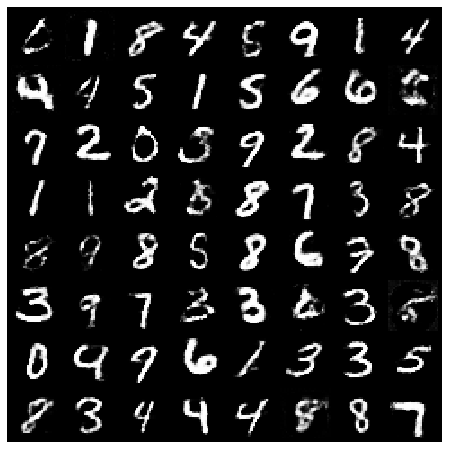

In [238]:
fig = plt.figure(figsize=(8, 8))
plt.axis('off')
images = [[plt.imshow(np.transpose(img, (1, 2, 0)), animated=True)] 
         for img in reconstructs]
ani = animation.ArtistAnimation(fig, images, interval=200, #repeat_delay=1000,
                                blit=True,
                                repeat=False)
ani.save(outdir + '/progression.gif', writer='imagemagick', fps=60)

# HTML(ani.to_jshtml())

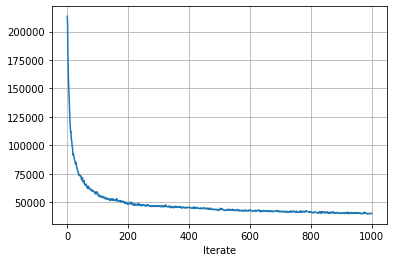

In [243]:
plt.plot(losses)
plt.grid()

plt.xlabel('Reconstruction loss')
plt.xlabel('Iterate')

plt.show()

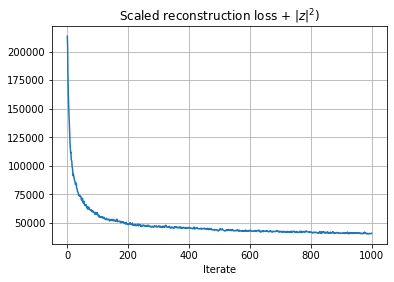

In [248]:
plt.plot([a*lbda + b for a, b in zip(losses, znorms)])
plt.grid()

plt.xlabel('Energy')
plt.xlabel('Iterate')
plt.title('Scaled reconstruction loss + $\| z\|^2$)')

plt.savefig('cs/descent-curve.pdf')

plt.show()

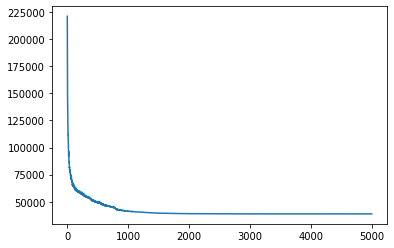

In [217]:
plt.plot(losses)
plt.show()

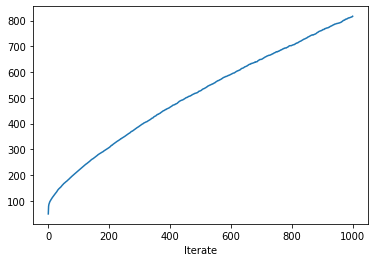

In [244]:
plt.plot(znorms)

plt.xlabel('$\| z\|^2$')
plt.xlabel('Iterate')

plt.show()

In [222]:
Image(url='progression512.gif')

In [213]:
eta

0.000387420489